# Uncertainty Estimates 

Our hypotheses are: 

1. The higher the exploitation, the worse the approximation of the partial dependence plot. 
2. The higher the exploitation, the higher the confidence intervals. 
3. Subsetting reduces the effect of this bias, and improves the shape of the partial dependence plots. 

In [187]:
library("ggplot2")
library("ParamHelpers")
library("data.table")
library("BBmisc")
library("iml")
library("philentropy")

library("ggpubr")

theme_set(theme_pubr())

source("../R/mbo_helpers.R")
source("../R/pdp_helpers.R")

## 1. Hypothesis - Higher Exploitation means worse PDPs 

#### Synthetic functions

We have 4 different values of lambda: 0.1, 1, 2, 10. 

In [198]:
compute_width_ci = function(dimension, lambda_vals, breaks) {
    # read all synthetic functions

    path = "../data/runs/synthetic/StyblinskiTang/"

    diffs = lapply(lambda_vals, function(lambda) {
        datapath = file.path(path, paste0(dimension, "D"), paste0("mlrmbo_run_lambda_", lambda, ".rds"))

        run = readRDS(datapath)
        obj = readRDS(file.path(path, paste0(dimension, "D"), "objective.rds"))
        ps = readRDS(file.path(path, paste0(dimension, "D"), "ps.rds"))

        opdf = as.data.frame(run$opt.path)
        
        model = run$models
        model = model[[length(model)]] 

        df = generateRandomDesign(n = 1000, par.set = ps)
        
        res = lapply(model$features, function(feature) {
            me = marginal_effect(obj = obj, feature = feature, data = df, model = model, grid.size = 20)
            pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

            md = mean(abs(me$mean - pme$mean))
            neg_loglik = mean(unlist(lapply(seq_row(pme), function(i) {
                - dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = TRUE) 
            })))
            mean_sd = mean(pme$sd)
            sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
            sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

            # compute the kullback-leibler distance 
            # myhist = hist(opdf[, c(feature)], breaks = breaks)
            # P = myhist$density
            # Q = 1 / length(myhist$density)
            # kld = sum(P * log(P / Q), na.rm = TRUE)
            
            cbind(md = md, mean_sd = mean_sd, sd_upper_q90 = sd_upper_q90, sd_lower_q10 = sd_lower_q10, neg_loglik = neg_loglik, feature = feature, lambda = lambda, dim = dimension)
        })

        do.call(rbind, res)
    })
    
    diffs = do.call(rbind, diffs)
    diffs = as.data.table(diffs)
    
    return(diffs)
} 

In [199]:
lambda_vals = c(0.1, 1, 2, 5, 10)

In [200]:
diffs = list()

In [201]:
diffs[["2D"]] = compute_width_ci(2, lambda_vals, breaks = 15)

In [202]:
diffs[["2D"]]

md               mean_sd          sd_upper_q90     sd_lower_q10    
1  19.9024364623661 7.83511929535723 11.5277700104088 5.30483147957676
2  25.2583799782717 7.834573847602   14.5770328602116 3.9534469522915 
3  7.86973232905286 7.19985882422985 13.2241027580846 3.27324898735245
4  17.6151875787302 8.18596828804638 13.9411138735296 4.26820743610503
5  9.32383412438922 5.43123618867026 6.71111877986149 3.53755021849802
6  8.88629696369423 5.55452035346607 9.00501202330642 2.54798944113278
7  4.38508948097638 3.05711311746457 4.77516549804466 1.41645593237461
8  3.98365255299825 2.793526913676   4.11698596164249 1.4539494711599 
9  2.49426413321806 2.20882165778361 3.31560782849915 1.2023930406928 
10 2.43145212288256 2.25270323992545 4.15373377563287 1.32850539455551
   neg_loglik       feature lambda dim
1  6.90330286075231 x1      0.1    2  
2  8.02340691038865 x2      0.1    2  
3  3.79089014460567 x1      1      2  
4  4.57582542137515 x2      1      2  
5  4.44568611316042 x1      2      2  
6  3.83432155386158 x2      2      2  
7  3.12661784206548 x1      5      2  
8  2.93459073233547 x2      5      2  
9  2.3708505255568  x1      10     2  
10 2.21391033486263 x2      10     2

In [204]:
diffs[["3D"]] = compute_width_ci(3, lambda_vals, breaks = 20)

In [221]:
diffs[["3D"]][, mean(as.numeric(neg_loglik)), by = c("lambda", "dim")]

lambda dim V1      
1 0.1    3   4.998530
2 1      3   3.769878
3 2      3   3.426655
4 5      3   4.564668
5 10     3   4.352413

In [205]:
diffs[["5D"]] = compute_width_ci(5, lambda_vals, breaks = 30)

In [220]:
diffs[["5D"]][, mean(as.numeric(neg_loglik)), by = c("lambda", "dim")]

lambda dim V1      
1 0.1    5   5.360500
2 1      5   4.715639
3 2      5   4.899138
4 5      5   7.066407
5 10     5   9.443030

In [206]:
diffs[["10D"]] = compute_width_ci(10, lambda_vals, breaks = 40)

In [219]:
diffs[["10D"]][, mean(as.numeric(neg_loglik)), by = c("lambda", "dim")]

lambda dim V1       
1 0.1    10   4.831558
2 1      10   4.448118
3 2      10   4.445358
4 5      10   6.213014
5 10     10  34.410540

In [207]:
diffs2 = do.call(rbind, diffs)

In [222]:
diffs2$md = as.numeric(diffs2$md)
diffs2$kld = as.numeric(diffs2$kld)
diffs2$feature = as.factor(diffs2$feature)
diffs2$lambda = as.numeric(diffs2$lambda)
diffs2$dim = as.factor(diffs2$dim)
diffs2$neg_loglik = as.numeric(diffs2$neg_loglik)

In [223]:
diffs2_summary = diffs2[, .(mean_kld = mean(kld), mean_error_pdp = mean(md), mean_neg_loglik = mean(neg_loglik)), by = c("dim", "lambda")]

In [224]:
diffs2_summary

dim lambda mean_kld mean_error_pdp mean_neg_loglik
1  2    0.1   NA       22.580408       7.463355      
2  2    1.0   NA       12.742460       4.183358      
3  2    2.0   NA        9.105066       4.140004      
4  2    5.0   NA        4.184371       3.030604      
5  2   10.0   NA        2.462858       2.292380      
6  3    0.1   NA       18.716525       4.998530      
7  3    1.0   NA        9.529657       3.769878      
8  3    2.0   NA        6.138350       3.426655      
9  3    5.0   NA        6.421013       4.564668      
10 3   10.0   NA        3.203822       4.352413      
11 5    0.1   NA       19.173002       5.360500      
12 5    1.0   NA       15.353866       4.715639      
13 5    2.0   NA       12.810913       4.899138      
14 5    5.0   NA       10.726926       7.066407      
15 5   10.0   NA       27.694947       9.443030      
16 10   0.1   NA       19.656575       4.831558      
17 10   1.0   NA       15.358843       4.448118      
18 10   2.0   NA       14.729241       4.445358      
19 10   5.0   NA       20.706980       6.213014      
20 10  10.0   NA       82.624802      34.410540

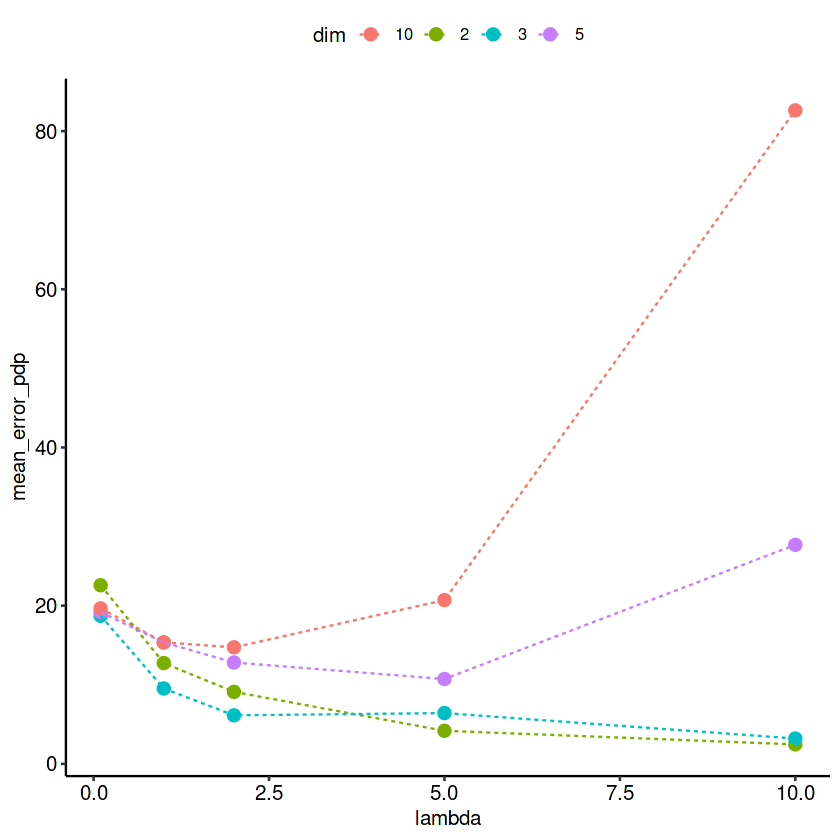

In [210]:
p = ggplot(diffs2_summary, aes(x = lambda, y = mean_error_pdp, colour = dim)) + geom_point(size = 3) + geom_line(lty = 2)
p

The hypothesis is only partially correct. In particular in high dimensions, a higher lambda can mean a worse partial dependence plot, because we have a sampling bias towards the border of the search space in the beginning. 

## 2. The width of the confidence intervals is correlated with the quality of a PDP 

In [211]:
diffs[["3D"]]

md               mean_sd          sd_upper_q90     sd_lower_q10     
1  17.9296476991511 11.9350844114215 13.458566567254  10.1762317697425 
2  20.656672766546  11.344719786427  16.860740001727  7.90025919685759 
3  17.5632558272726 11.8512766992412 16.668109558891  7.46662091023249 
4  9.7262224347381  7.1348540719045  10.7620708609778 4.26625315452012 
5  9.82900388380468 7.42853782495899 12.7478155246464 4.20018359499549 
6  9.03374528820567 6.96183267533023 9.74125038754073 4.3950593183189  
7  7.26936880370747 5.18684500218687 7.85341172948714 3.45376918757689 
8  5.94593217931758 5.35336836976474 8.06465316216799 2.89105925845883 
9  5.19974969858542 5.70251169690911 9.10289479952652 2.83900874589485 
10 6.32774362771257 3.57781262323432 5.54326392318644 2.16464494245521 
11 6.50244225702072 3.726110385683   5.58396668454306 1.88963262796251 
12 6.43285376188185 3.49747028044255 4.84026336276986 2.18688035646473 
13 3.04026285914737 1.5385191961407  2.49474623678846 0.859064097364701
14 3.21321950729542 1.55724257967858 2.35233721323958 0.870215424718771
15 3.35798356274477 1.52605267929906 2.74679174121358 0.823558694693832
   neg_loglik       feature lambda dim
1  5.08247546279237 x1      0.1    3  
2  5.35270801497359 x2      0.1    3  
3  4.56040543166043 x3      0.1    3  
4  3.92343223077827 x1      1      3  
5  3.67590314911165 x2      1      3  
6  3.71029929406825 x3      1      3  
7  3.62738568575357 x1      2      3  
8  3.28649744395844 x2      2      3  
9  3.36608245141309 x3      2      3  
10 4.41121728816384 x1      5      3  
11 4.33184593013247 x2      5      3  
12 4.95094012388314 x3      5      3  
13 4.23753469888899 x1      10     3  
14 4.62265068948654 x2      10     3  
15 4.19705229161747 x3      10     3

In [40]:
dimension = 5
lambda = 10
path = "../data/runs/synthetic/StyblinskiTang/"
datapath = file.path(path, paste0(dimension, "D"), paste0("mlrmbo_run_lambda_", lambda, ".rds"))

run = readRDS(datapath)
obj = readRDS(file.path(path, paste0(dimension, "D"), "objective.rds"))
ps = readRDS(file.path(path, paste0(dimension, "D"), "ps.rds"))

opdf = as.data.frame(run$opt.path)

In [50]:
P = opdf$x1
Q = runif(n = length(P), min = ps$pars$x$lower, max = ps$pars$x$upper)

In [54]:
KL(rbind(P, Q), est.prob = "empirical")

Metric: 'kullback-leibler' using unit: 'log2'; comparing: 2 vectors.



kullback-leibler 
             NaN

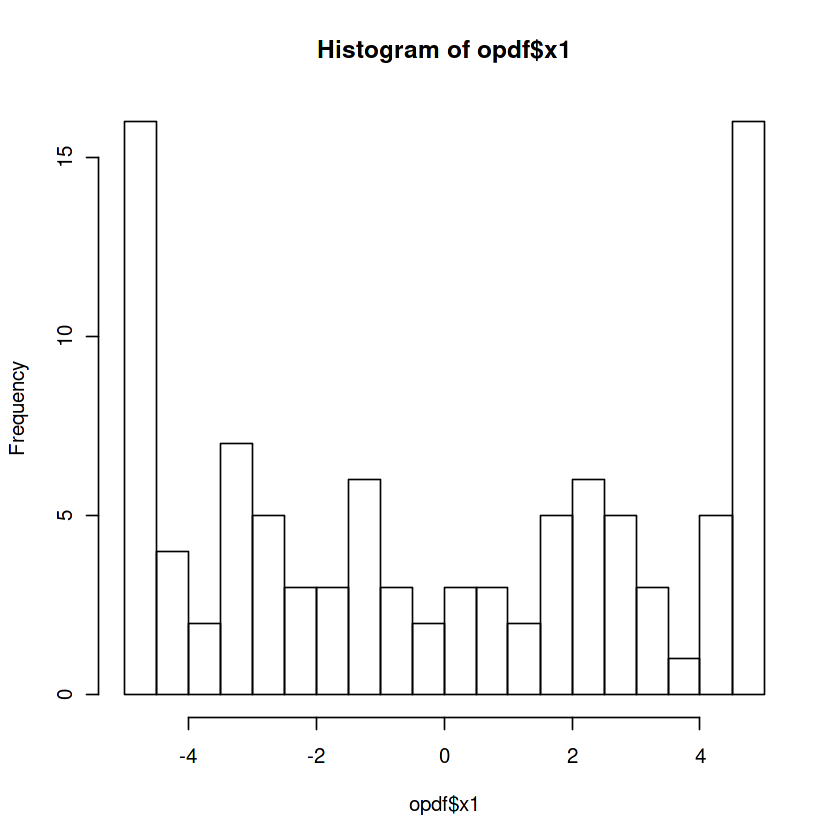

In [81]:
myhist = hist(opdf$x1, breaks = 30)

In [82]:
P = myhist$density
Q = 1 / length(myhist$density)

In [83]:
sum(P * log(P / Q))

[1] 1.877682

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



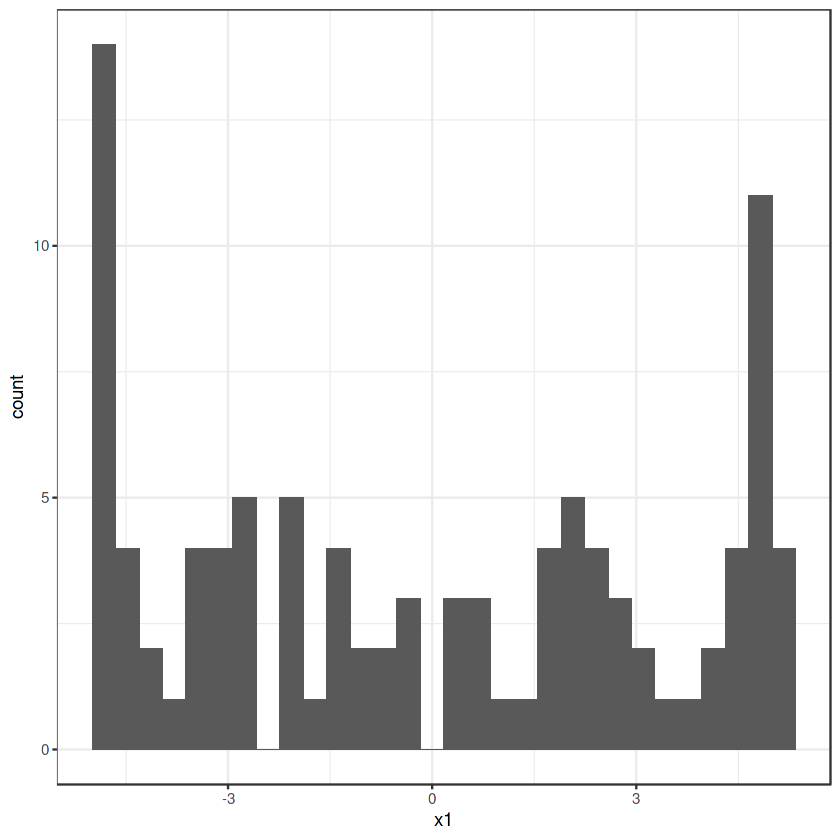

In [61]:
ggplot(data = opdf, aes(x = x1)) + geom_histogram() + geom_line(aes(x = yintercept = )

#### MLP Data

We have 4 different values of lambda: 0.5, 1, 2, 10. For each run, we have 30 replications

In [22]:
dataset = "kc1"

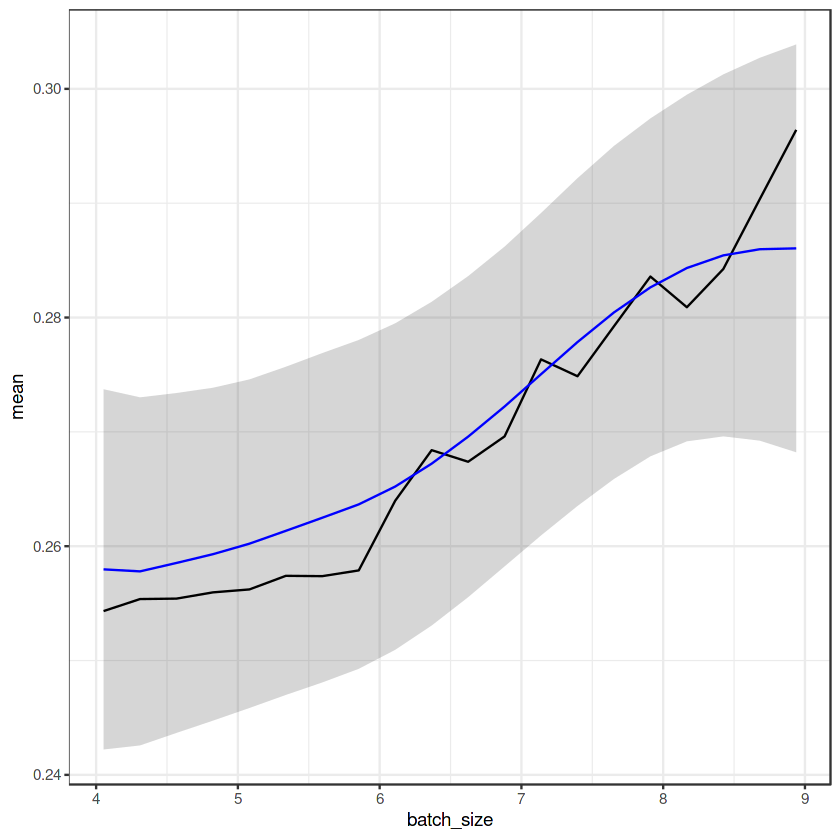

In [72]:
p = ggplot() + geom_ribbon(data = pme, aes(x = batch_size, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p = p + geom_line(data = me, aes(x = batch_size, y = mean)) + geom_line(data = pme, aes(x = batch_size, y = mean), colour = "blue")
p

In [175]:
compute_width_ci = function(dataset, lambda_vals, breaks, feature) {

    path = file.path("../data/runs/mlp_new", dataset)
    df = generateRandomDesign(n = 100, par.set = ps)

    obj = readRDS(file.path(path, "obj.rds"))
    ps = getParamSet(obj)
    # Is needed within the objective 
    surr_val = readRDS(file.path(path, "surrogate.rds"))$result[[1]]$model_val_balanced_acc
    
    # Compute the ground-truth PDP once 
    me = marginal_effect_mlp(obj = obj, feature = feature, data = df, model = model, grid.size = 20)
    
    diffs = lapply(lambda_vals, function(lambda) {
        
        datapath = file.path(path, paste0("mlrmbo_run_lambda_", lambda, "_30repls.rds"))
        runs = readRDS(datapath)

        res = lapply(1:5, function(i) {
            run = runs$result[[i]]
            opdf = as.data.frame(run$opt.path)

            model = run$models
            model = model[[length(model)]] 
            
            pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

            md = mean(abs(me$mean - pme$mean))
            neg_loglik = sum(unlist(lapply(seq_row(pme), function(i) {
                - dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = TRUE) 
            })))
            mean_sd = mean(pme$sd)
            sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
            sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

            # compute the kullback-leibler distance 
            myhist = hist(opdf[, c(feature)], breaks = breaks, main = paste0("lambda = ", lambda))
            P = myhist$density 
            P = P / sum(P)
            Q = rep(1 / length(myhist$density), length(myhist$density))
            els = Q * log(Q / P)
            
            cbind(md = md, mean_sd = mean_sd, kld = sum(els[is.finite(els)], na.rm = TRUE), sd_upper_q90 = sd_upper_q90, sd_lower_q10 = sd_lower_q10, feature = feature, lambda = lambda, dataset = dataset)
        })

        do.call(rbind, res)
    })
    
    diffs = do.call(rbind, diffs)
    diffs = as.data.table(diffs)
    
    return(diffs)
} 

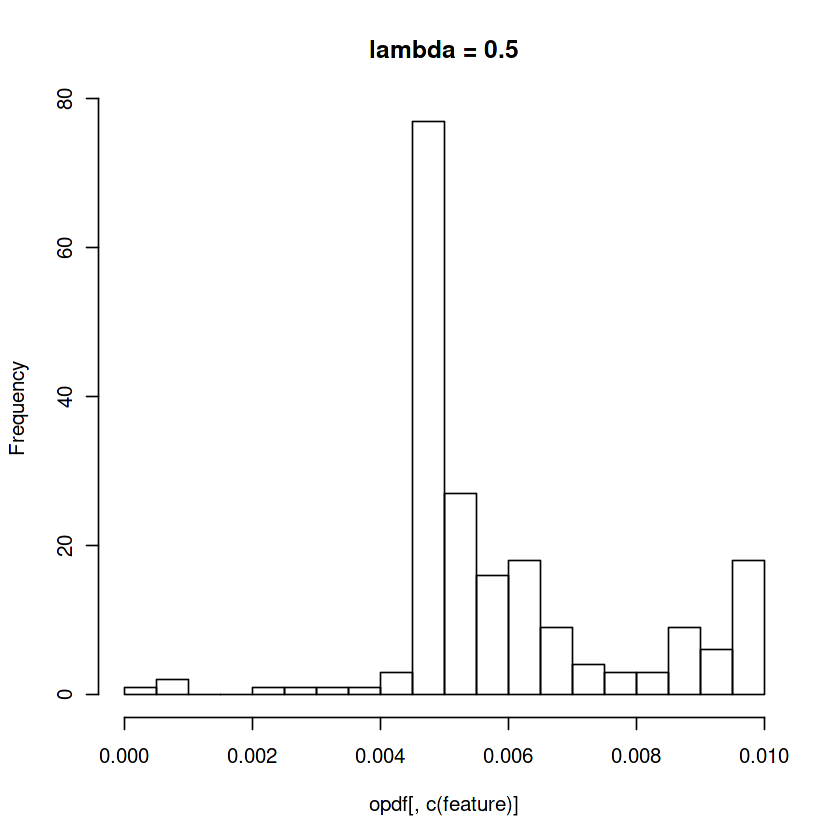

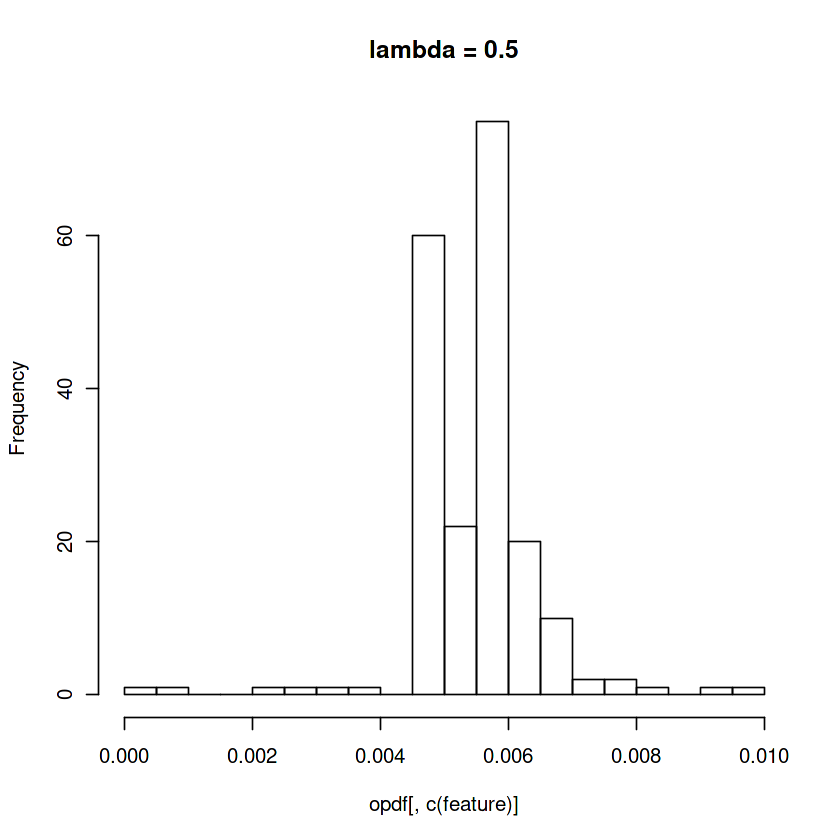

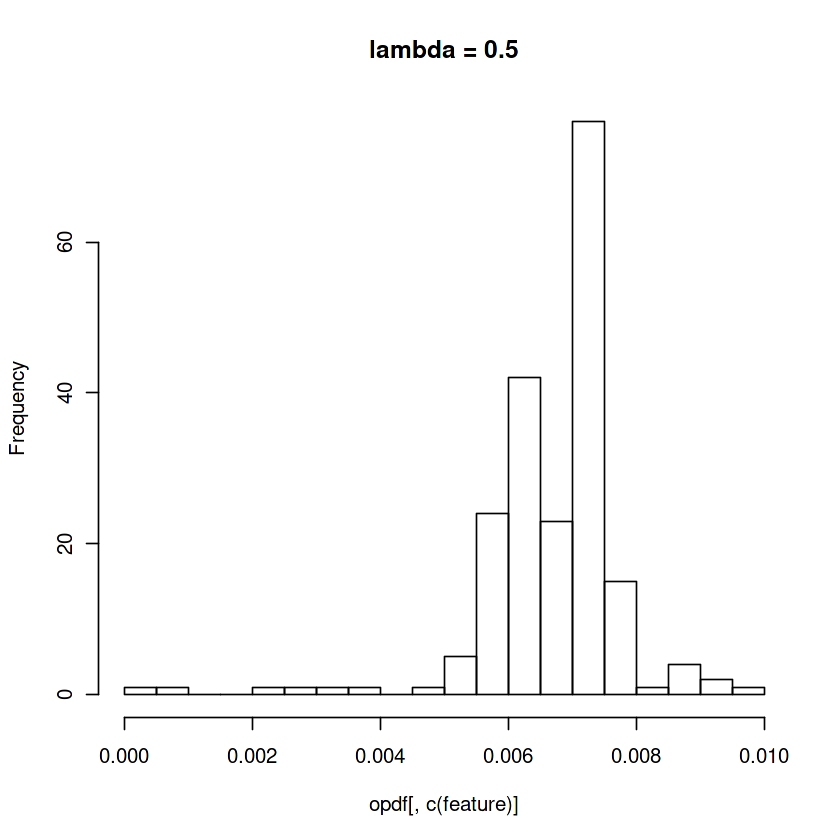

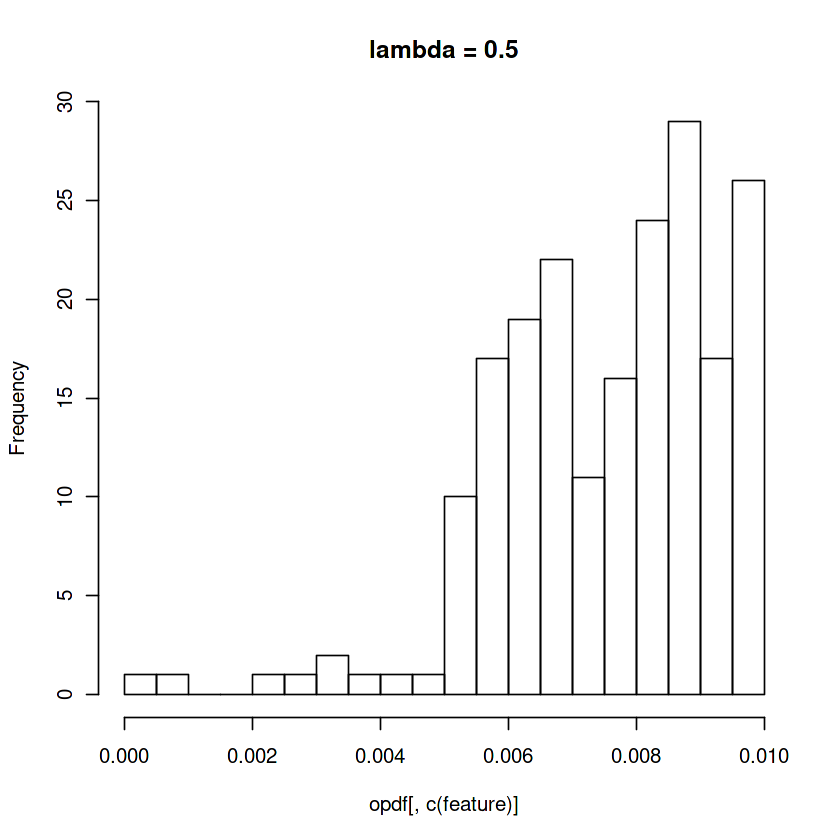

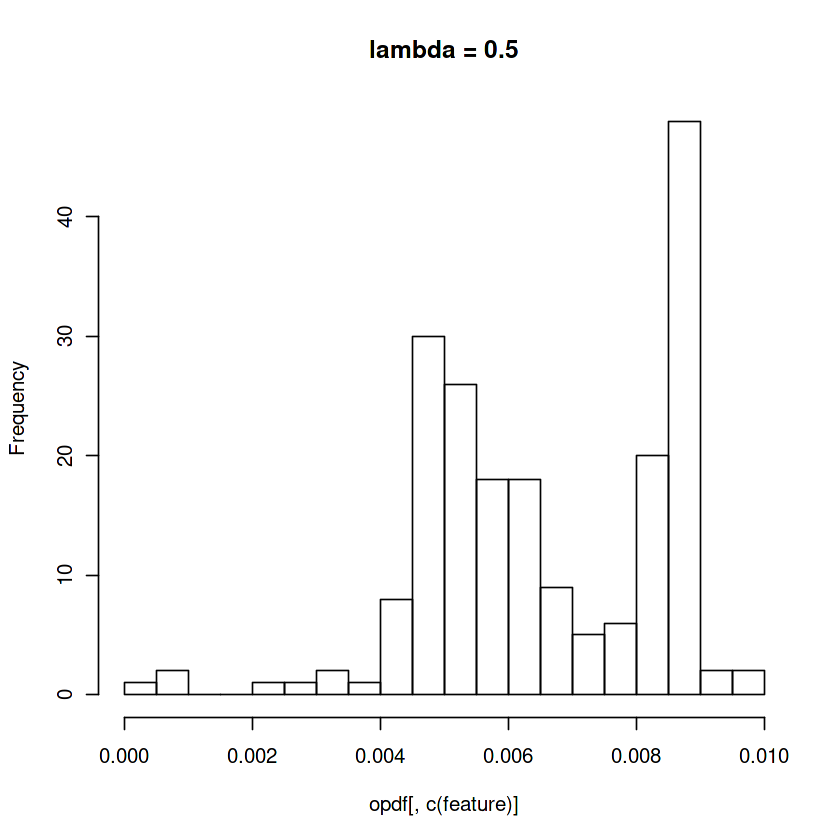

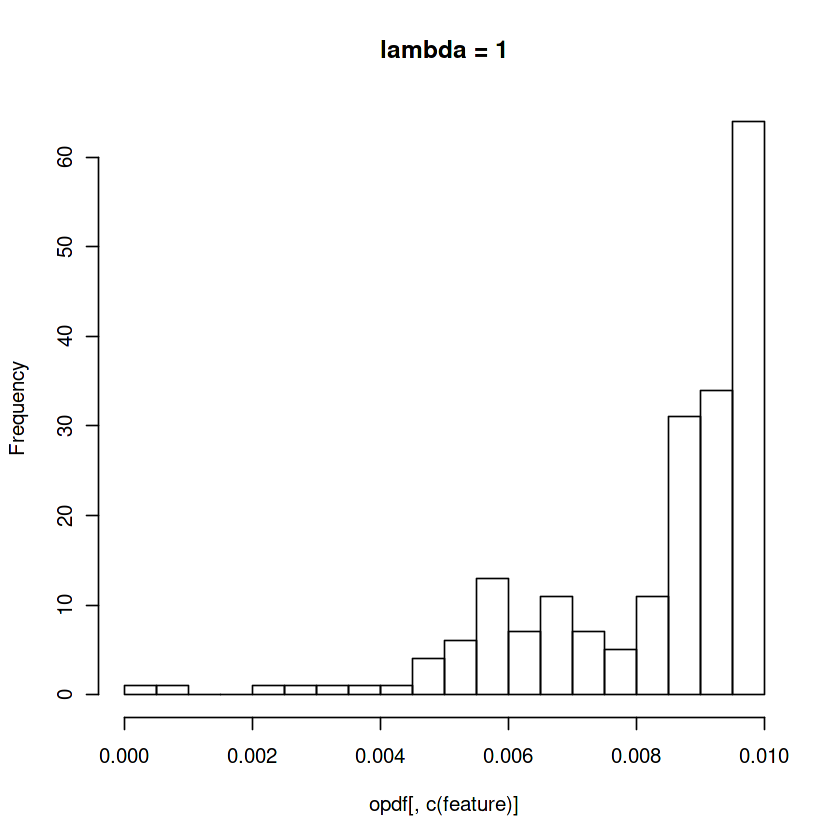

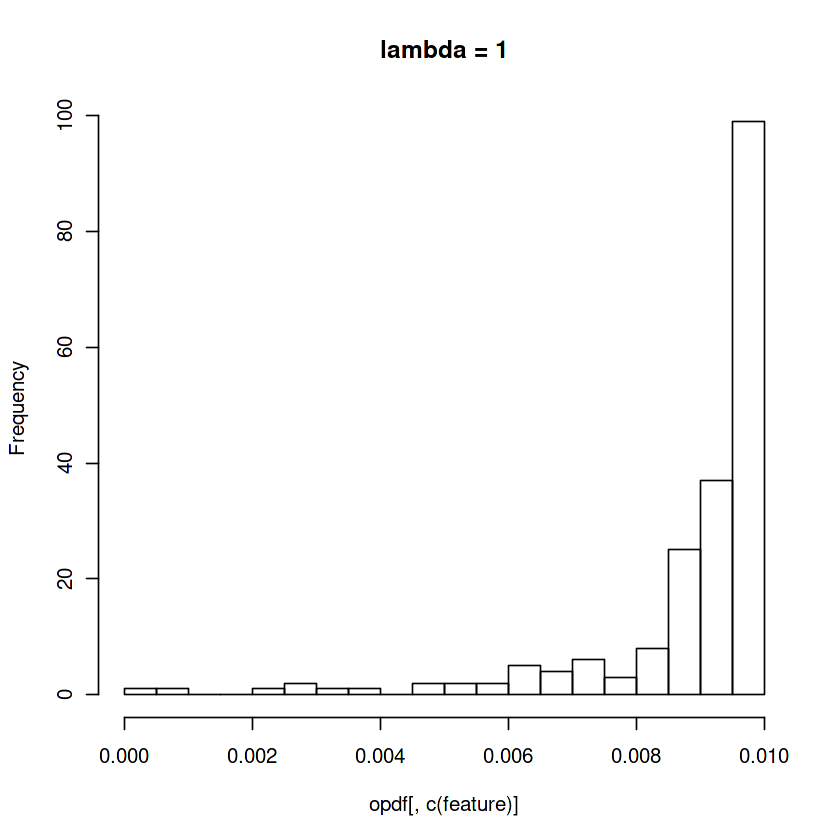

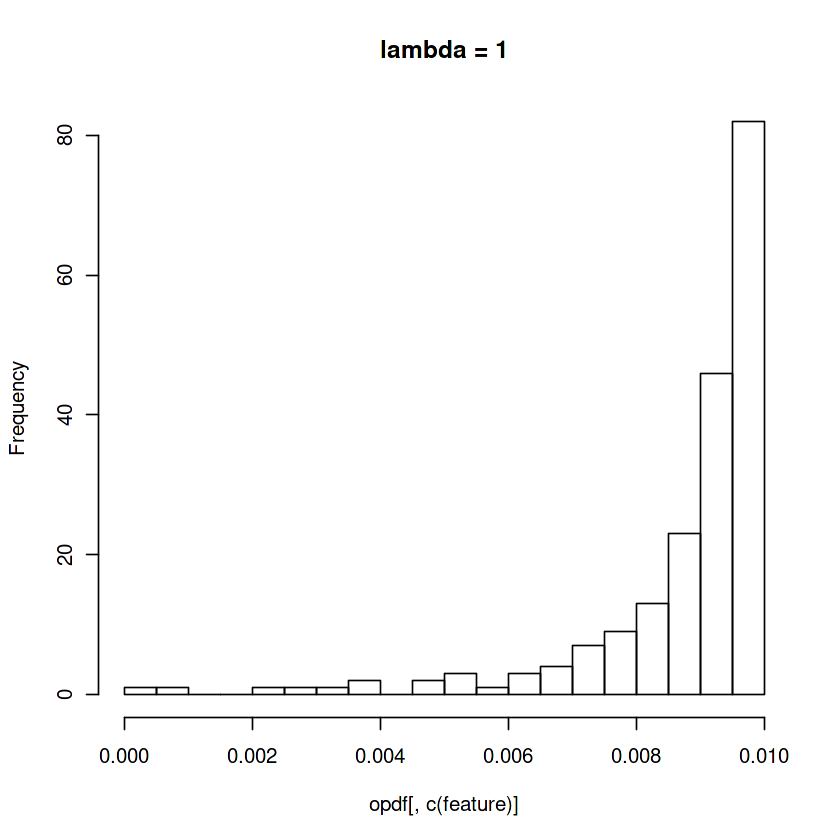

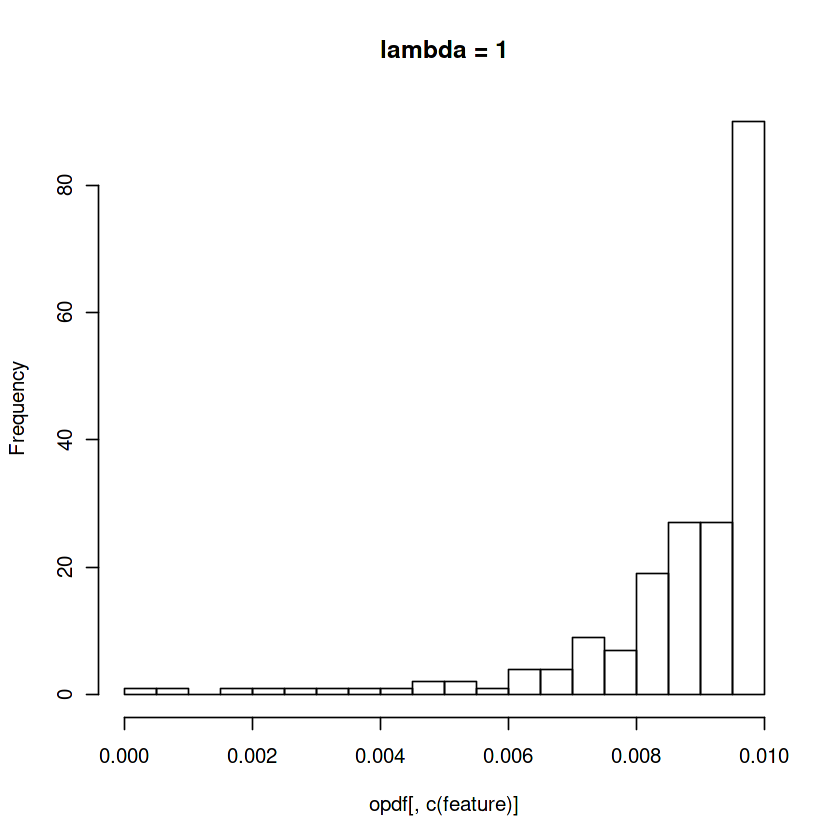

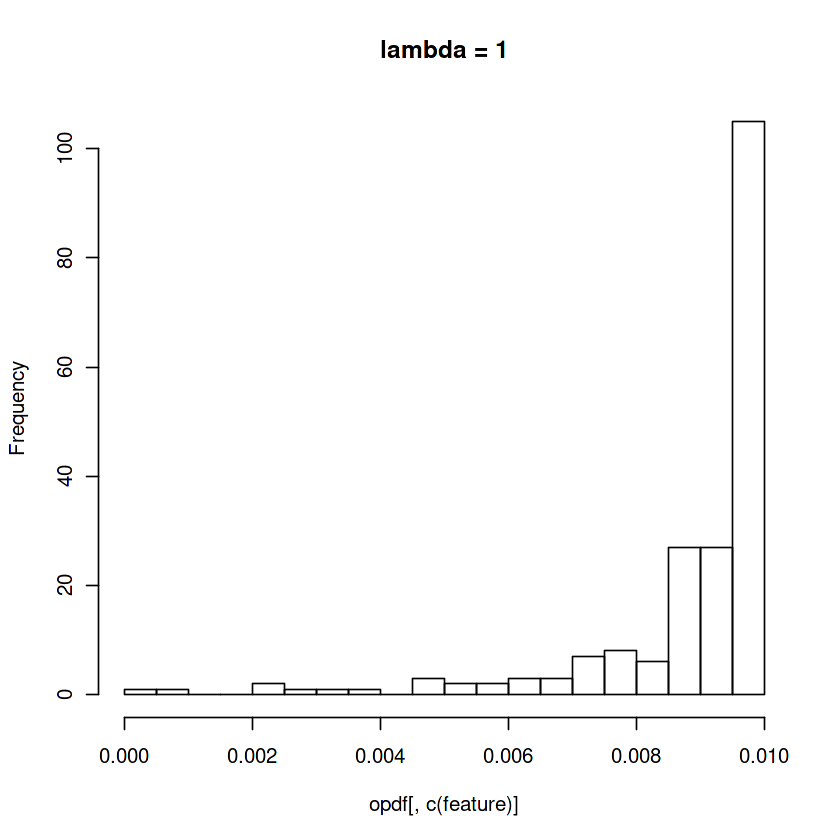

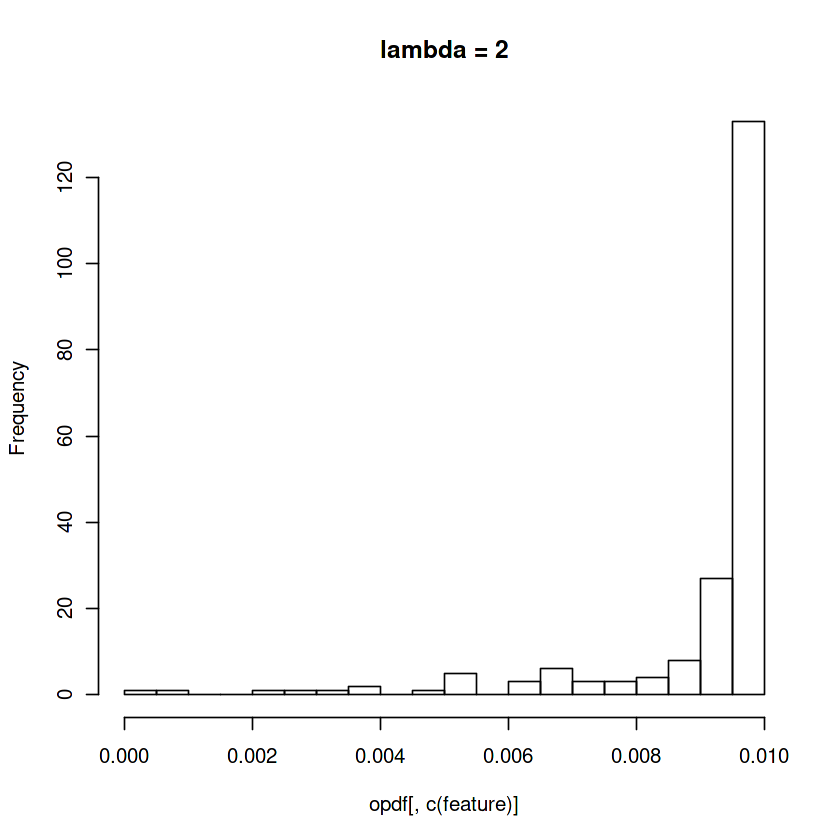

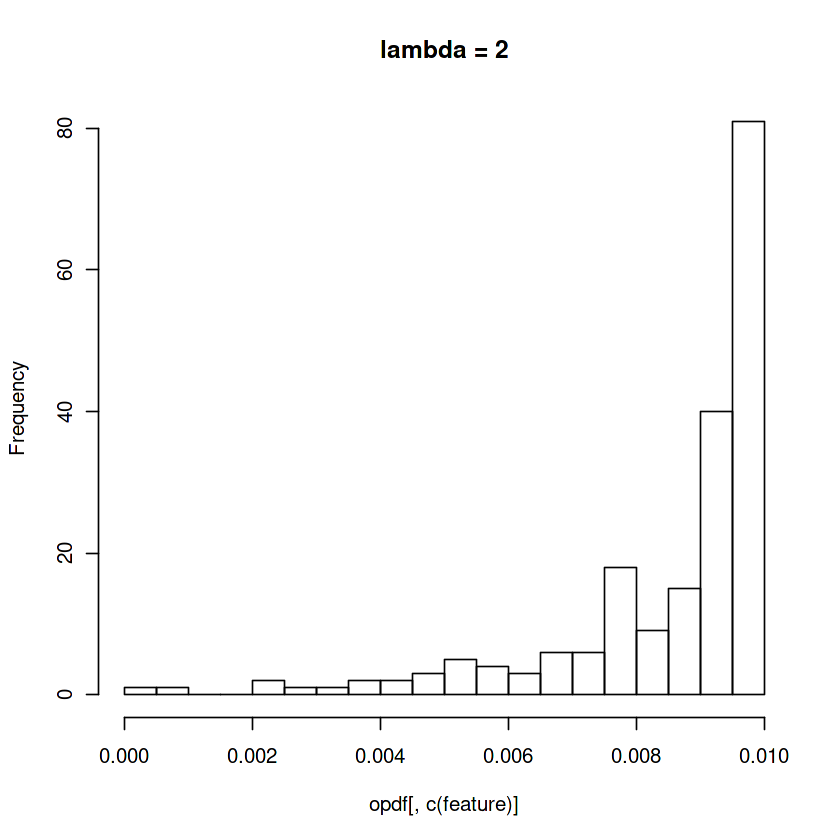

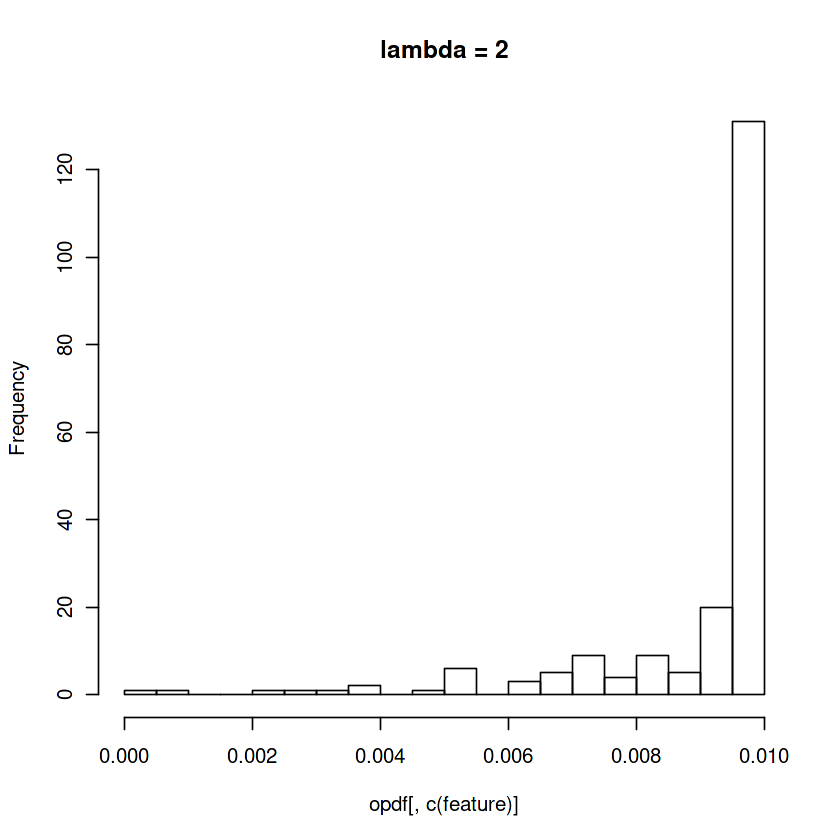

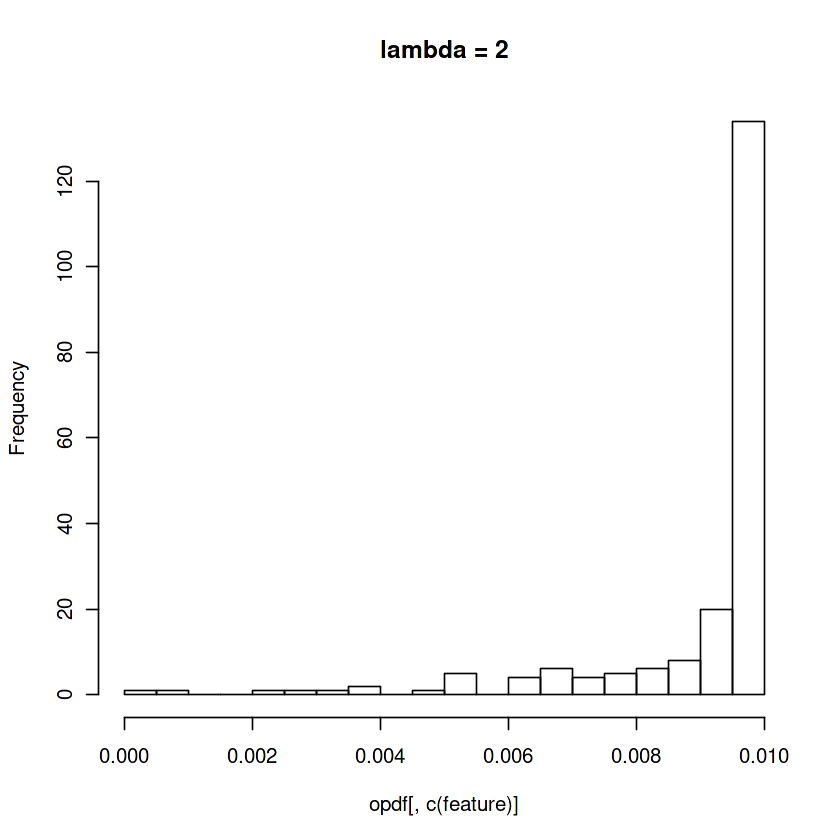

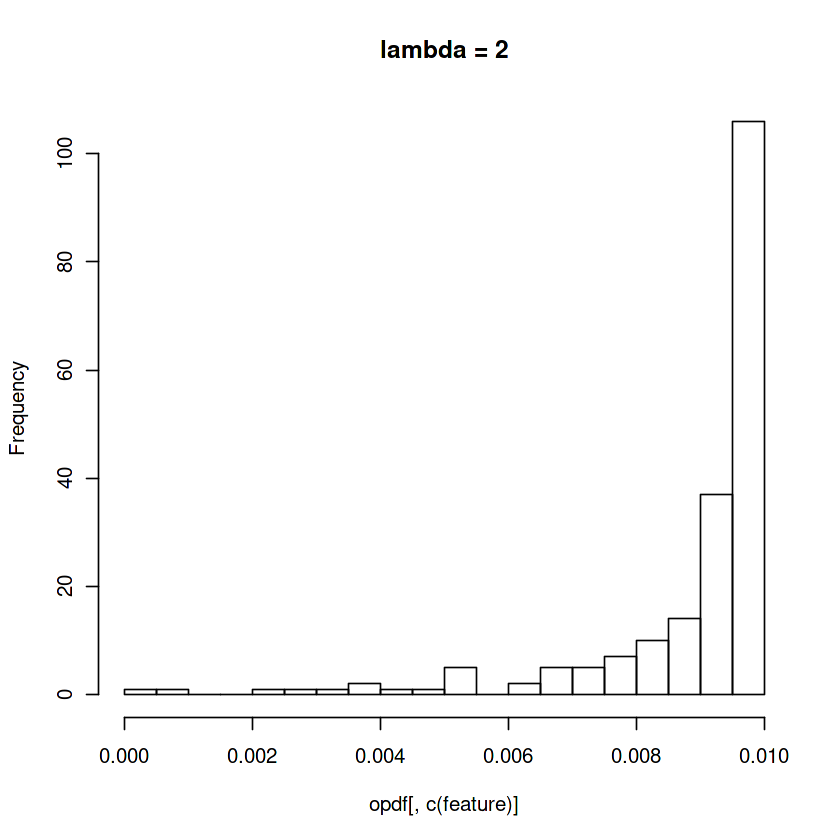

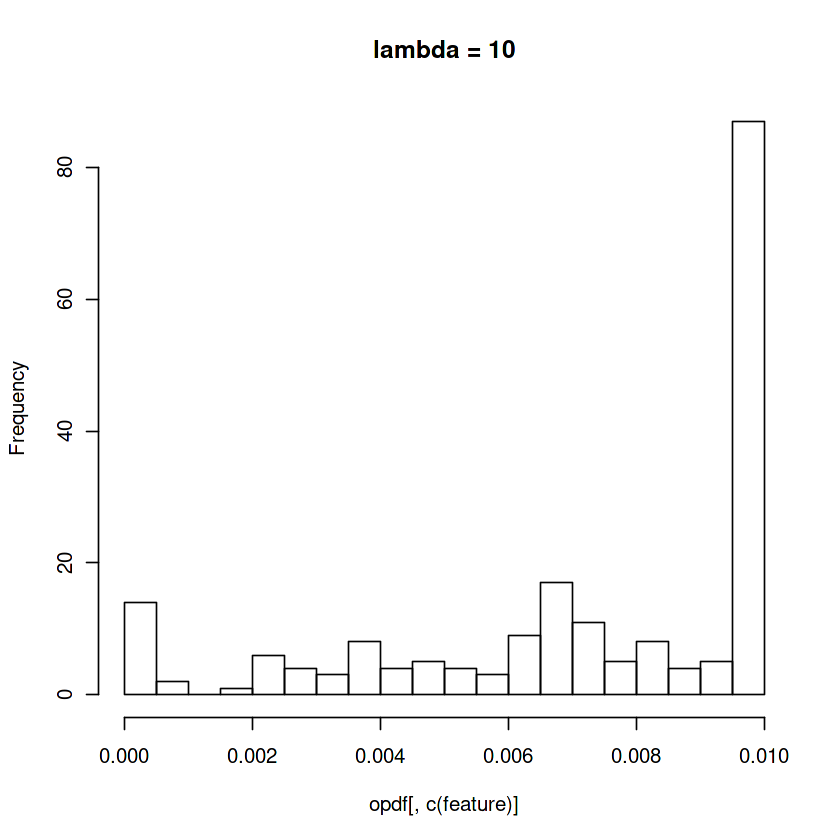

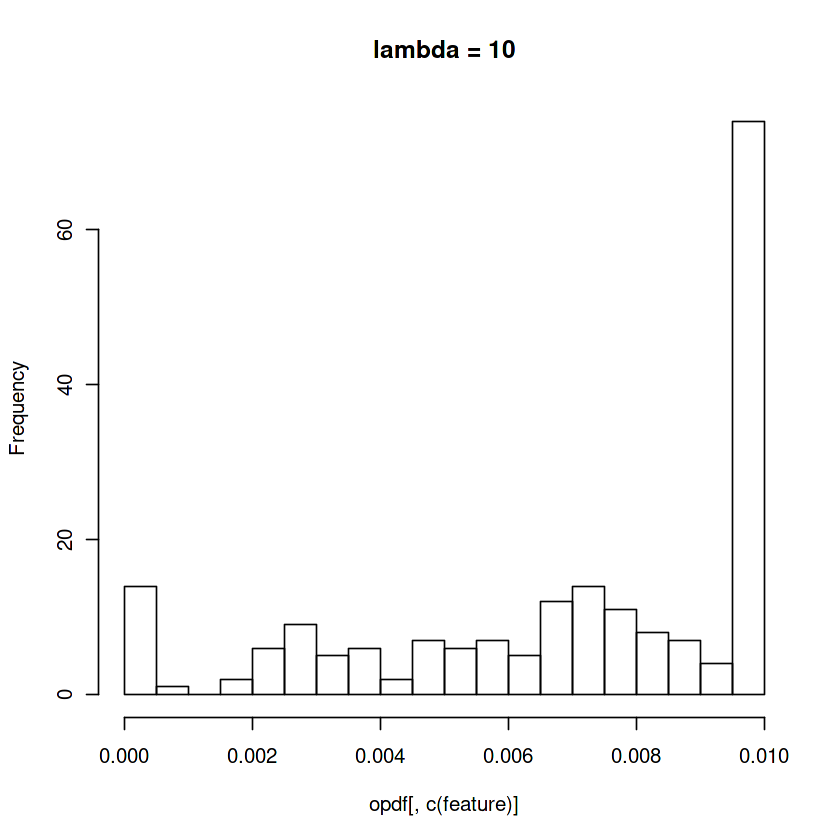

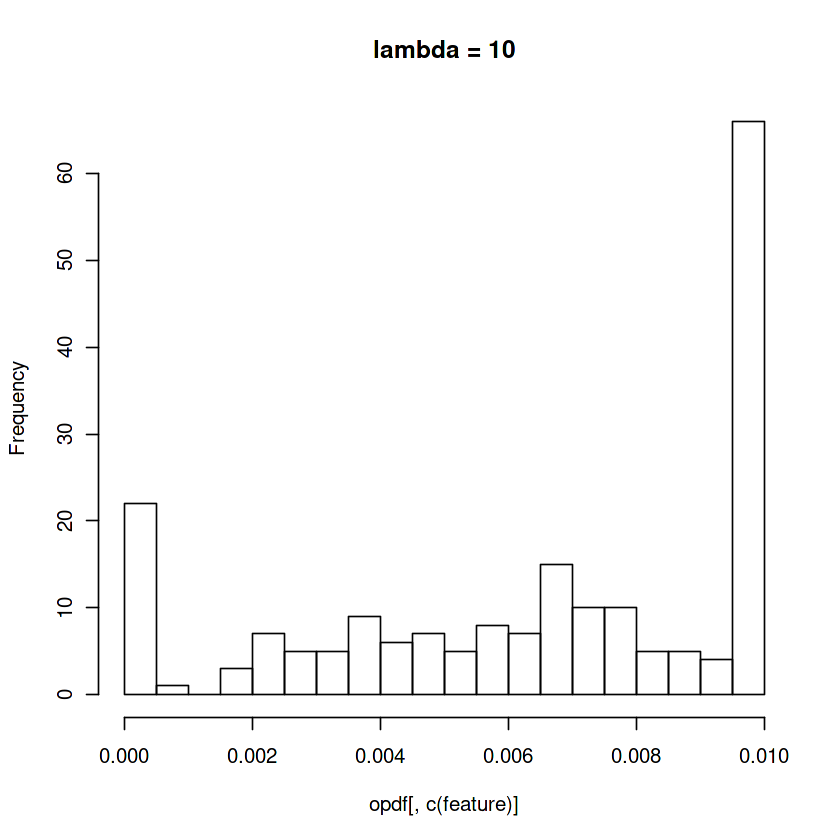

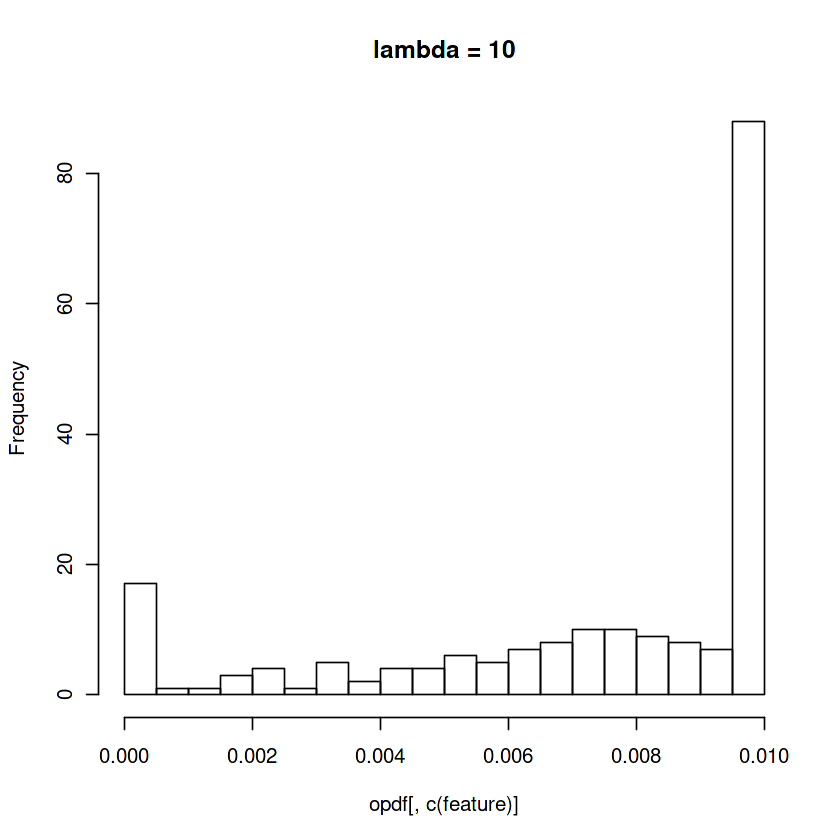

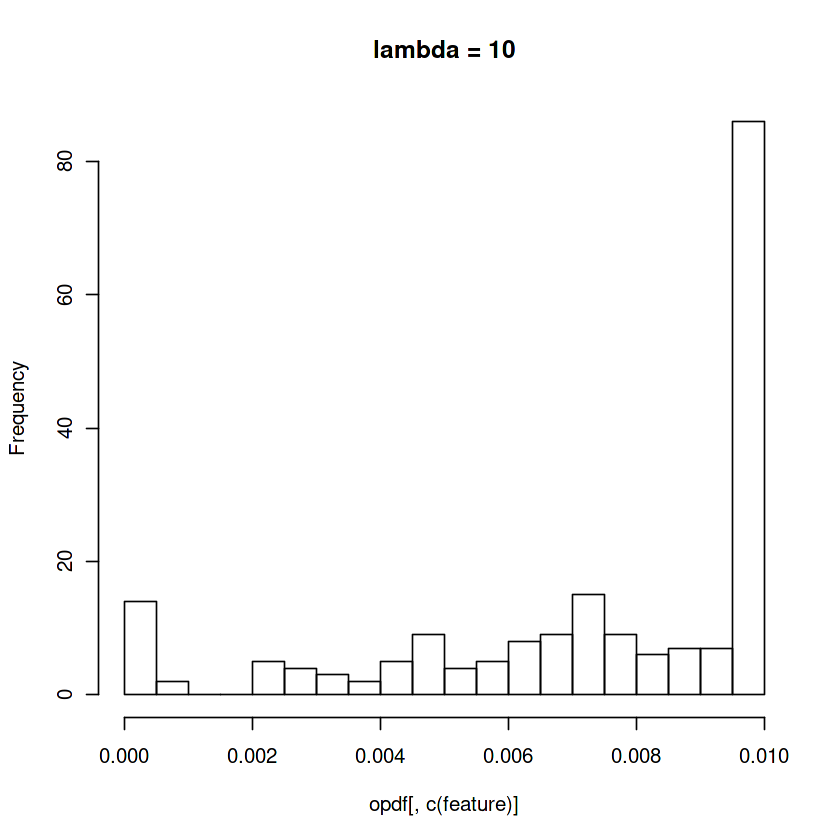

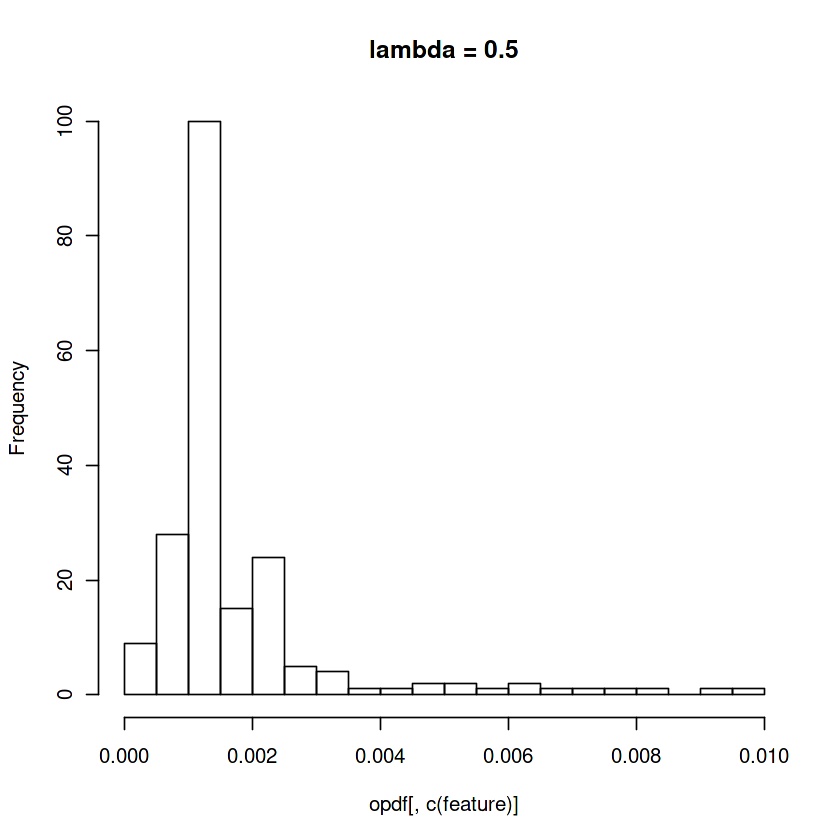

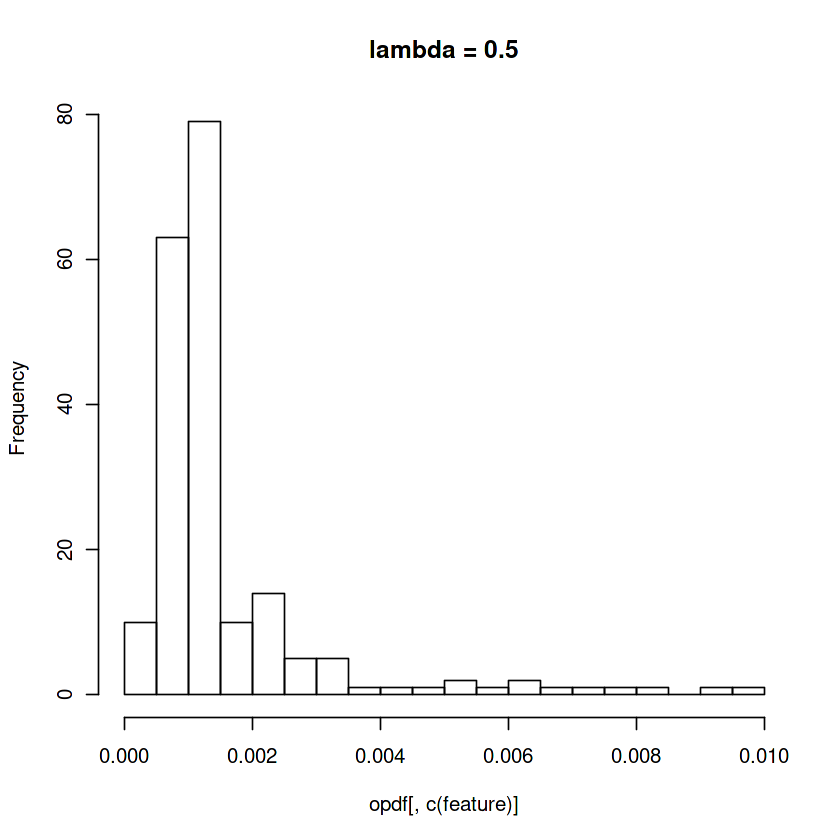

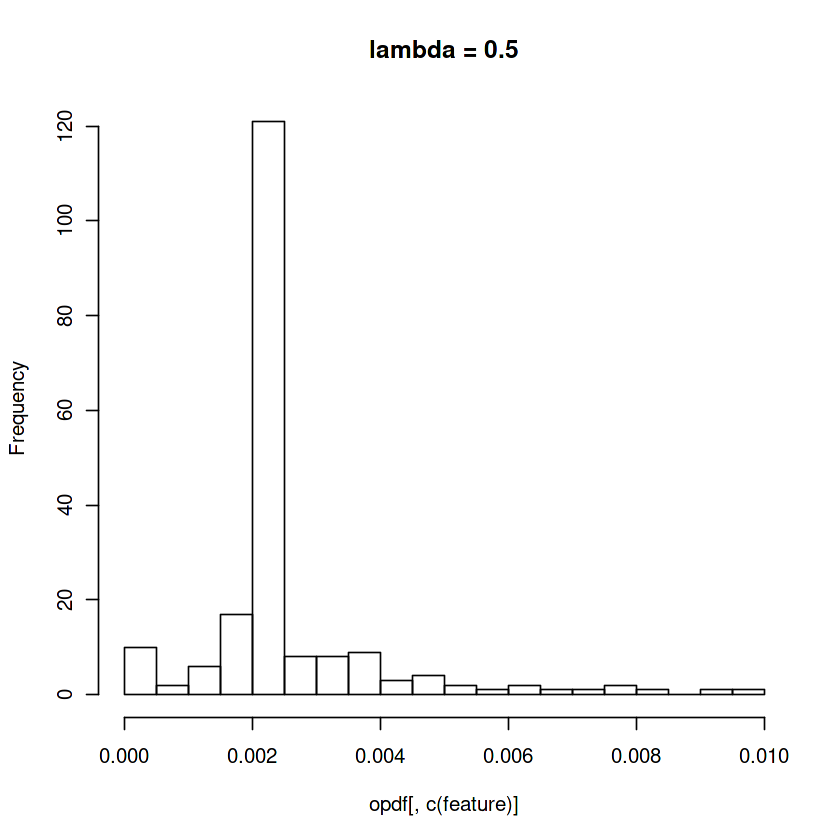

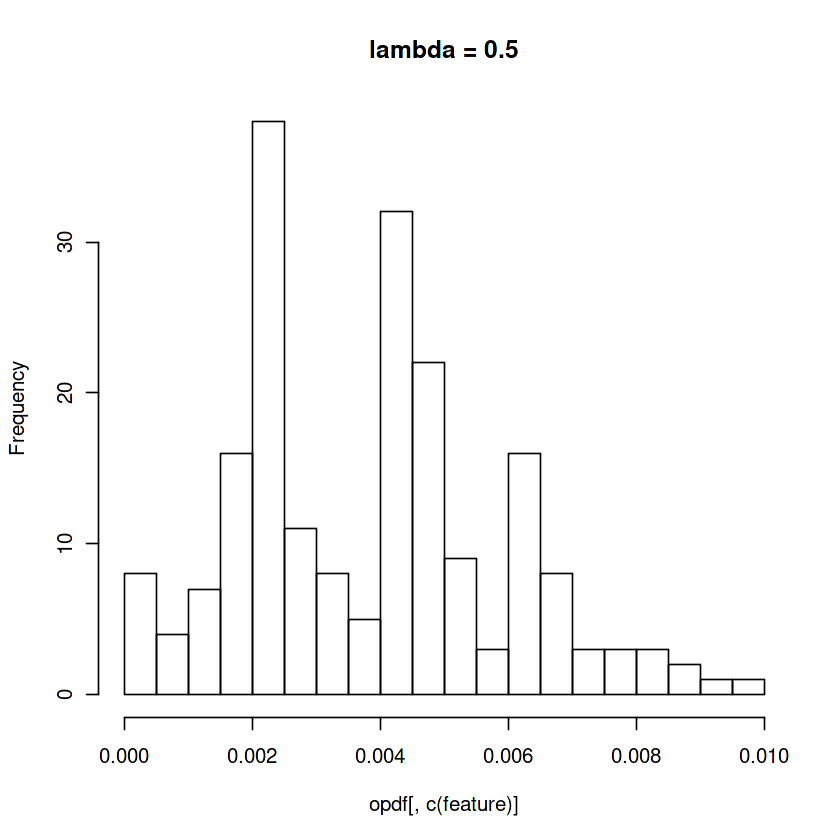

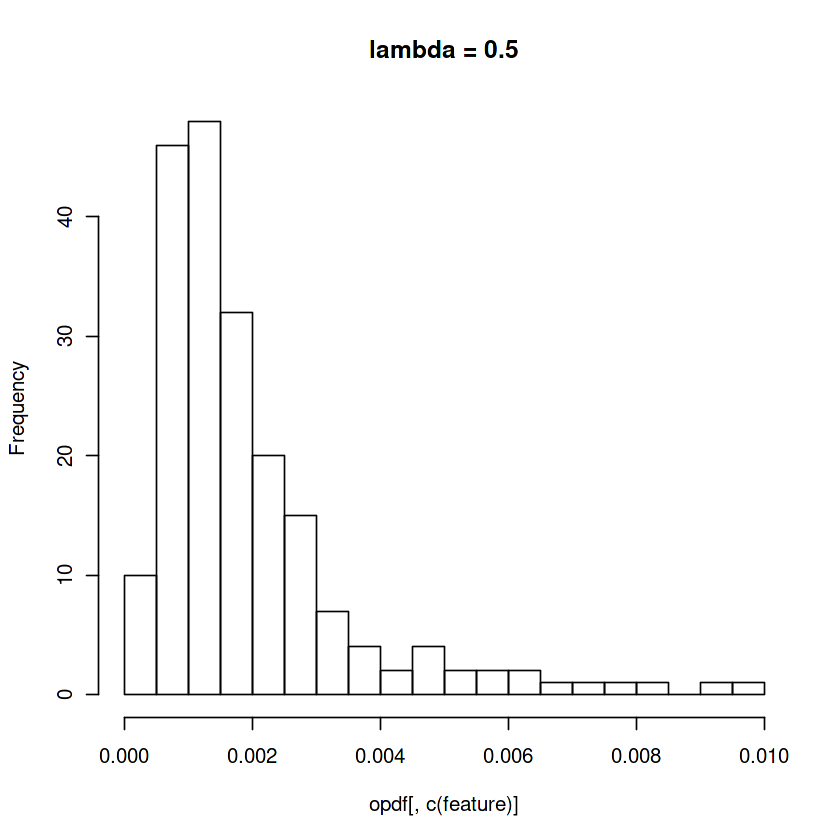

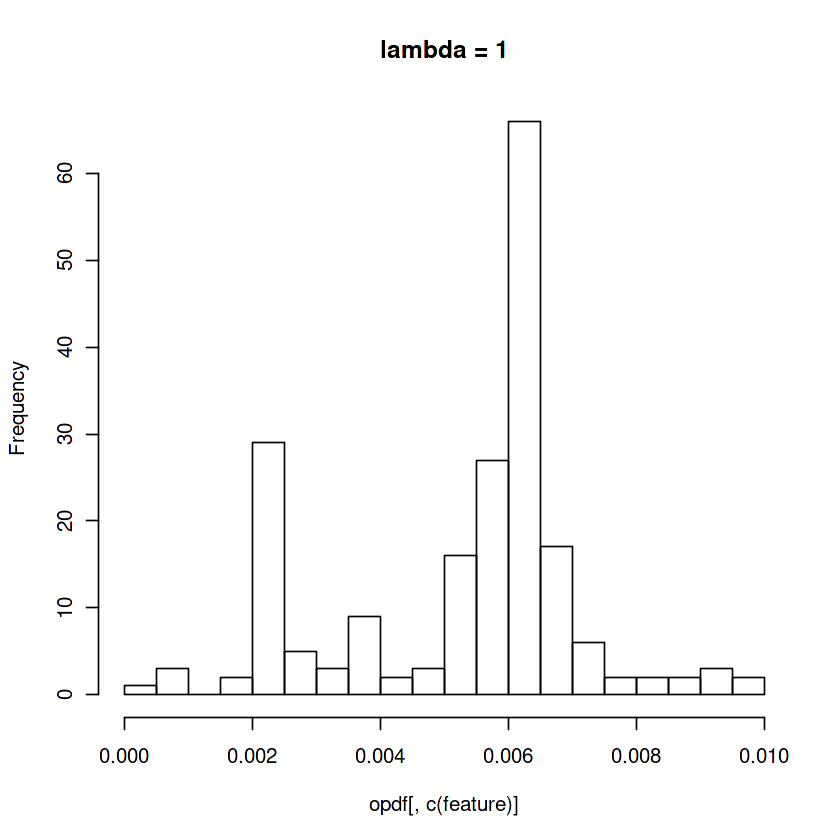

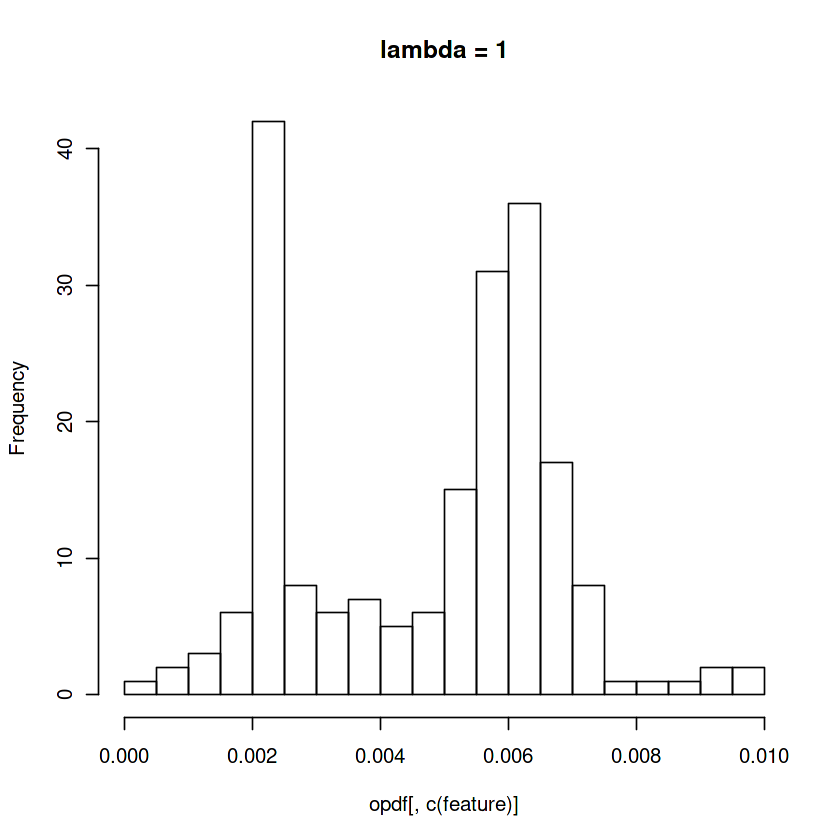

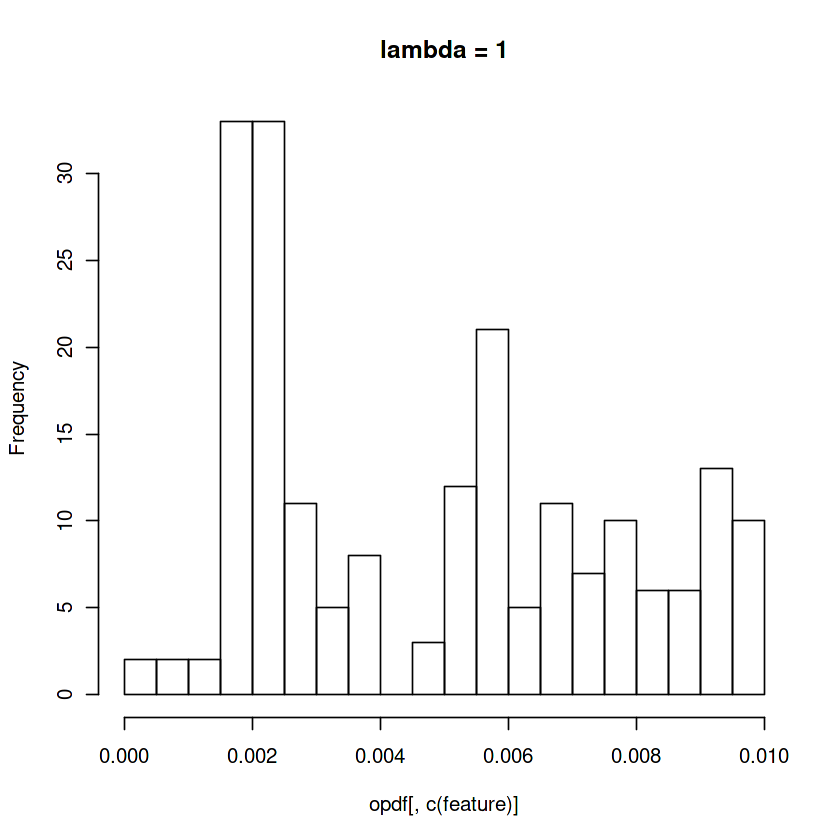

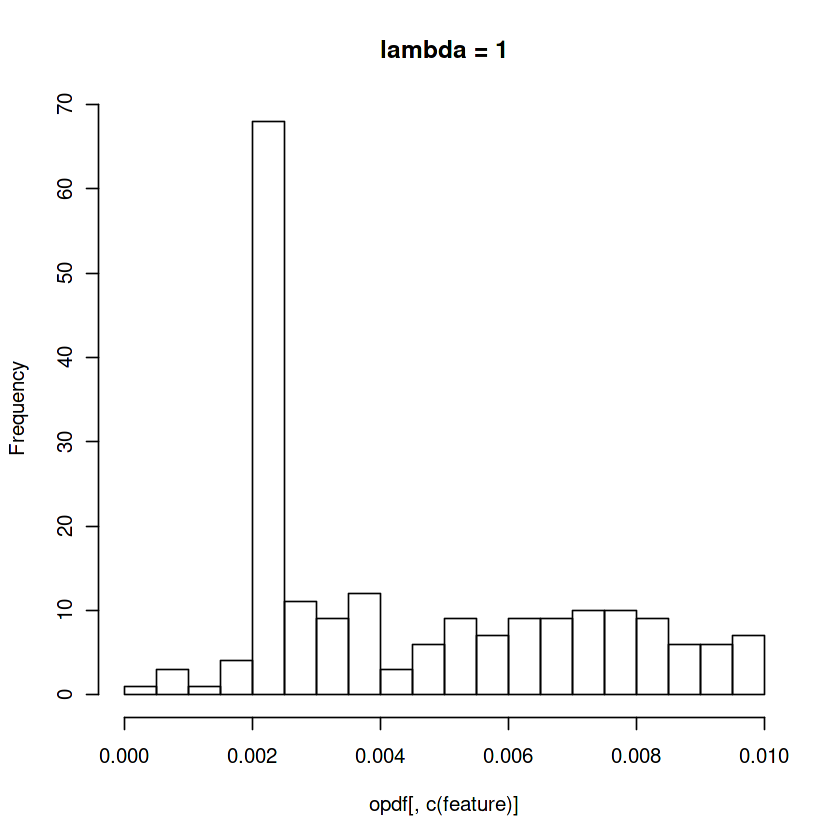

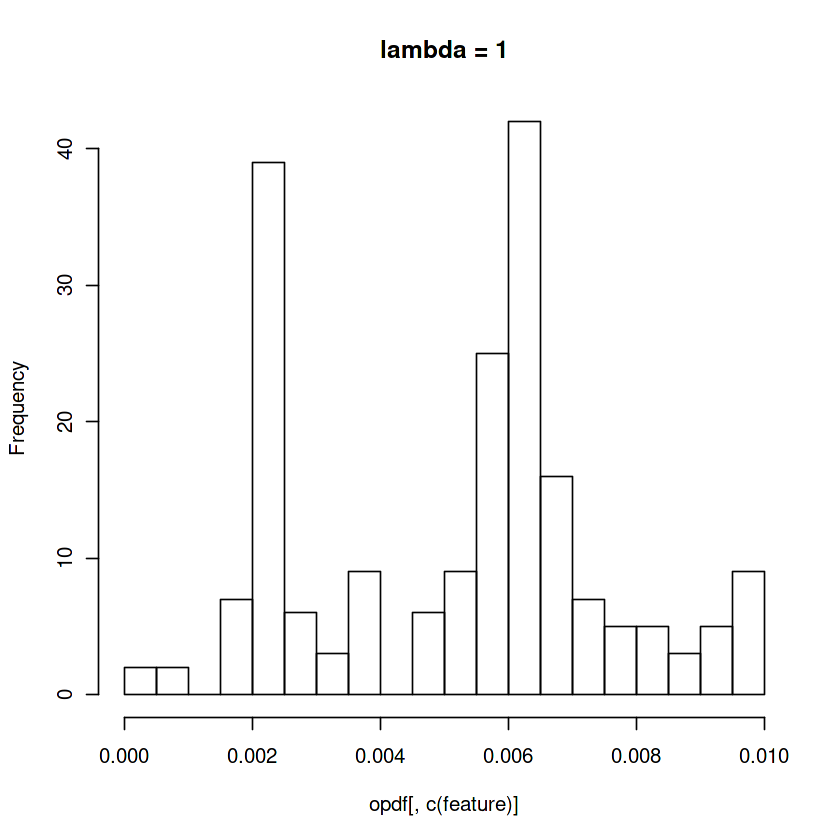

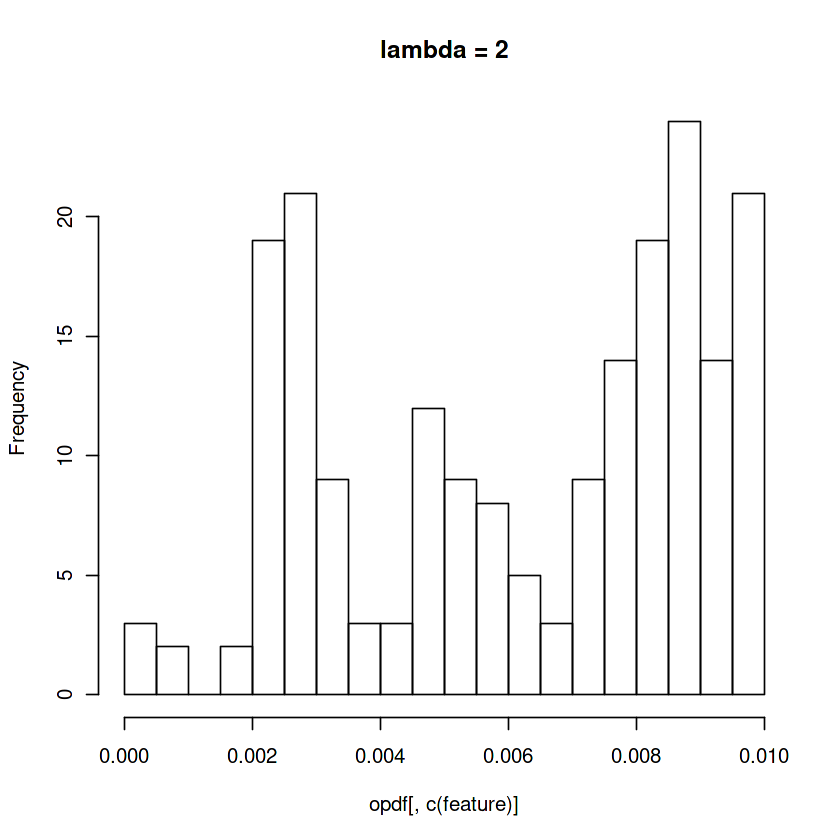

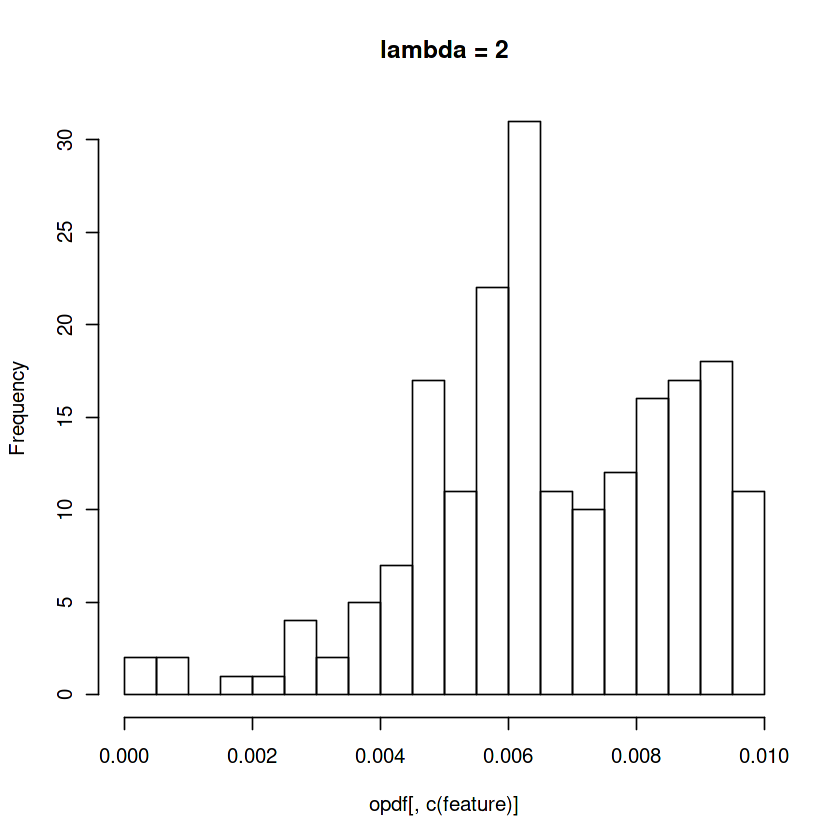

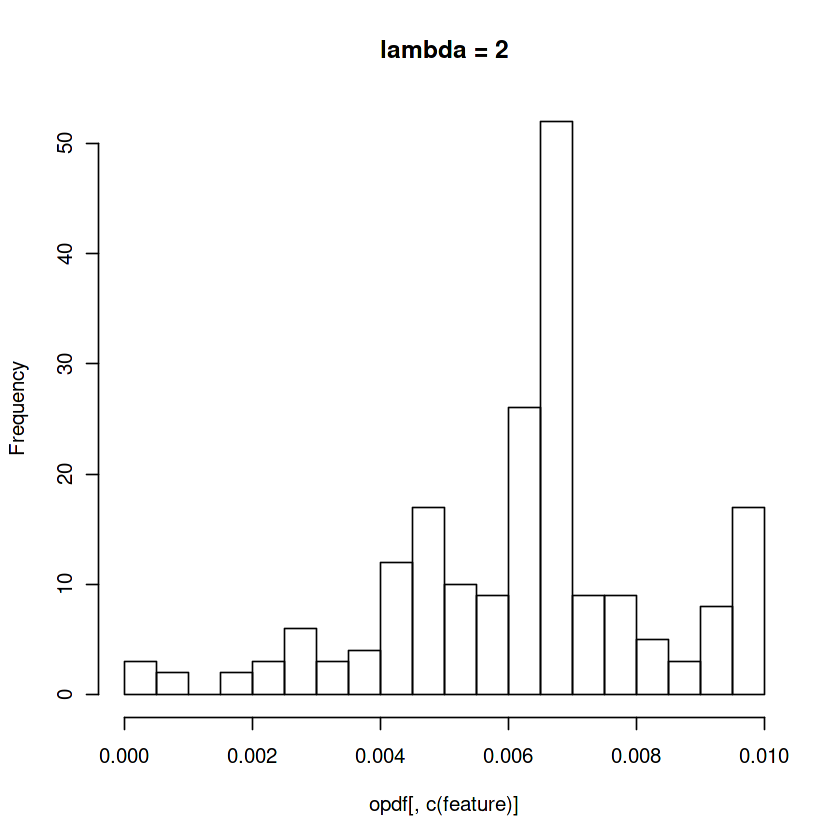

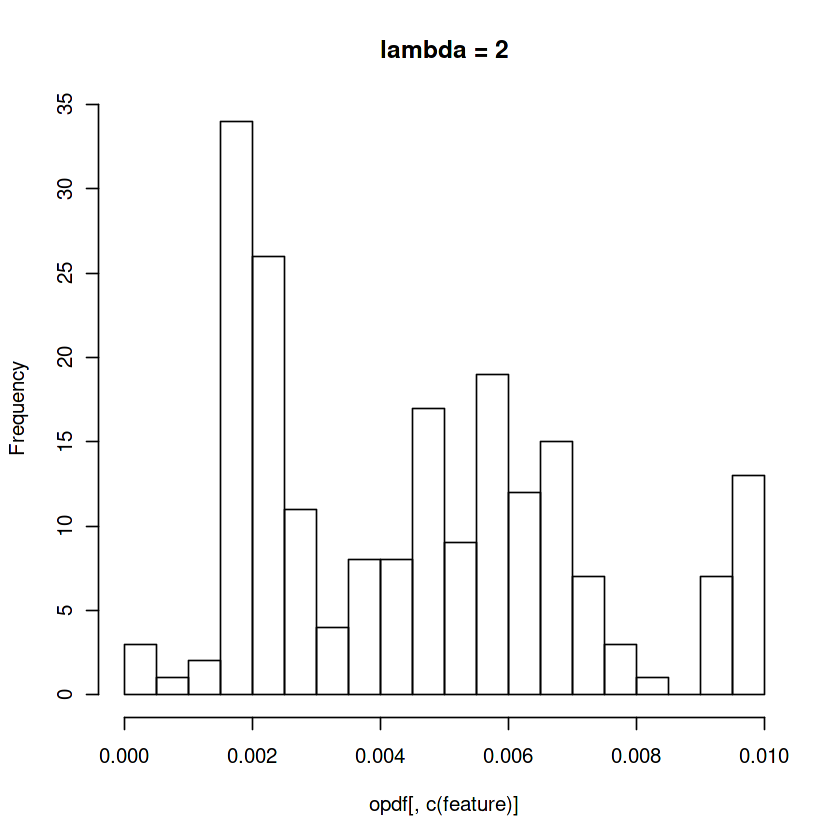

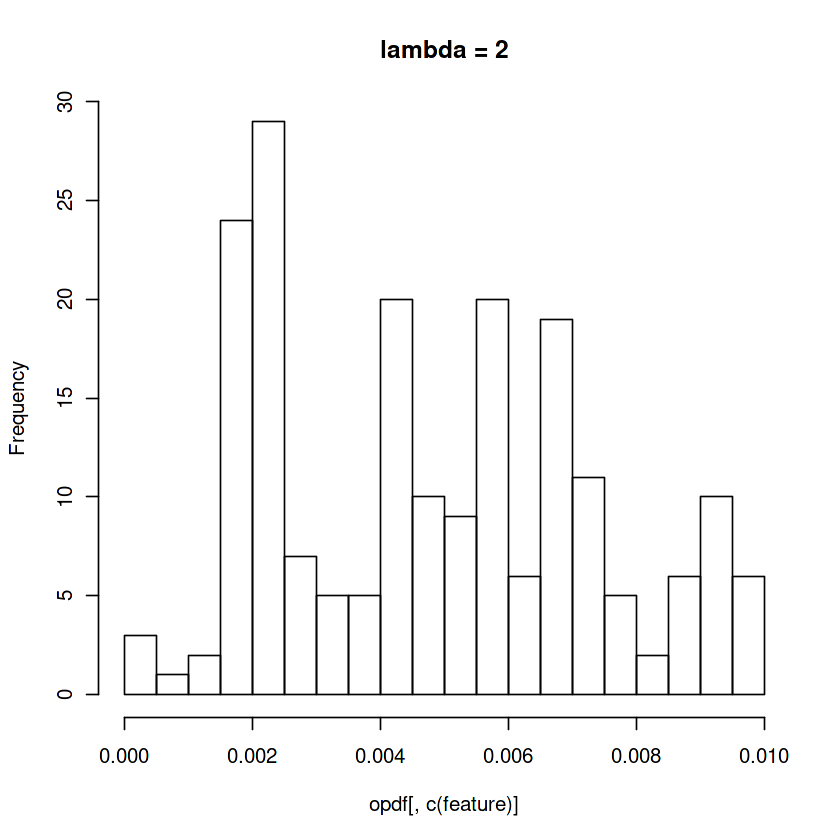

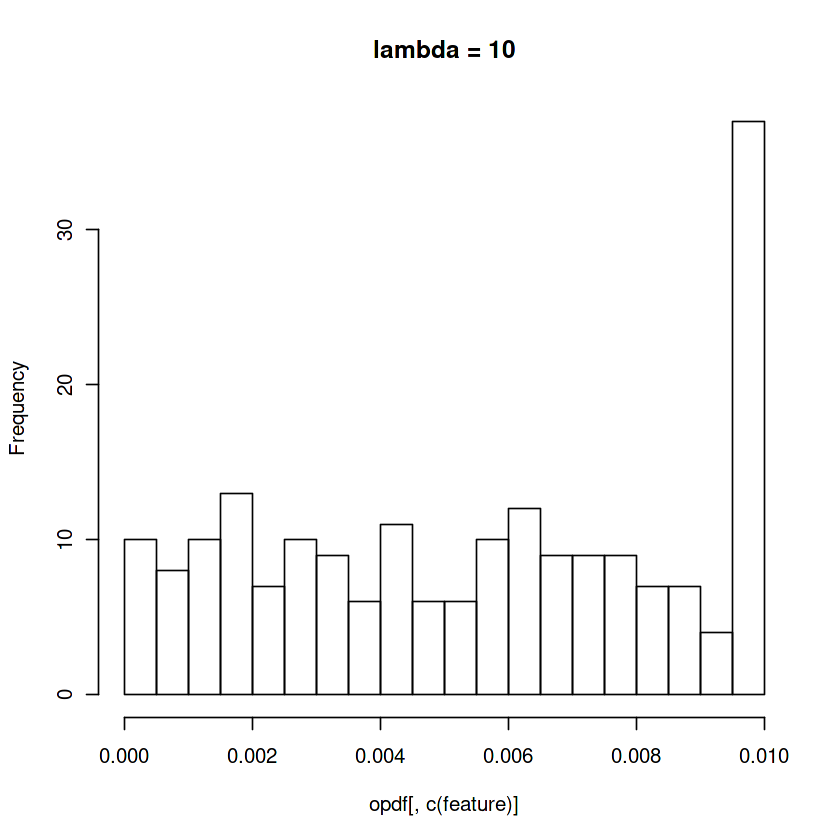

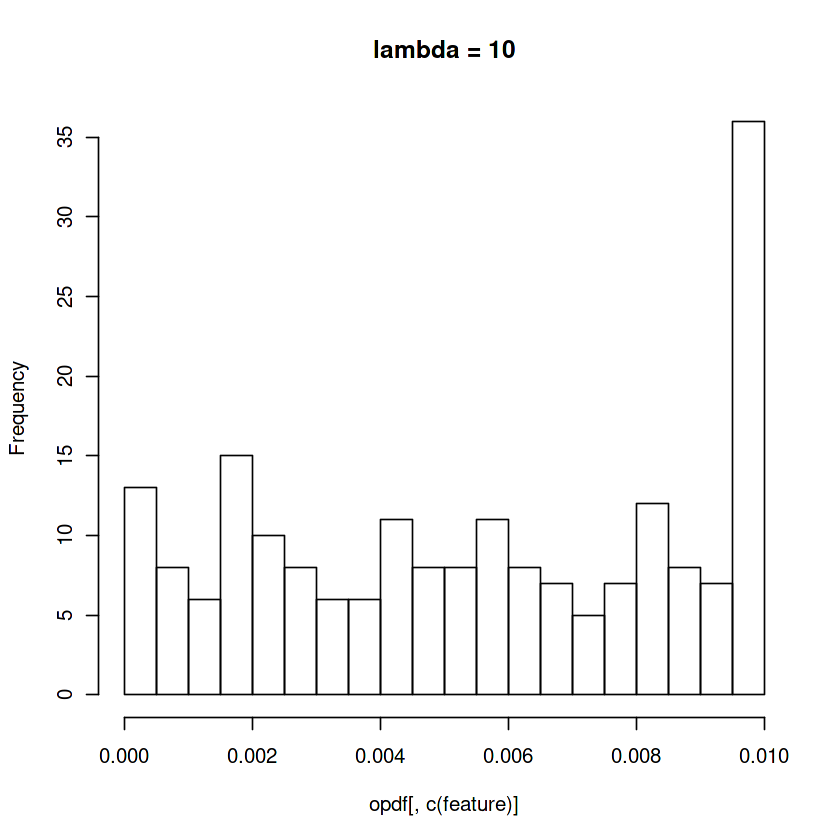

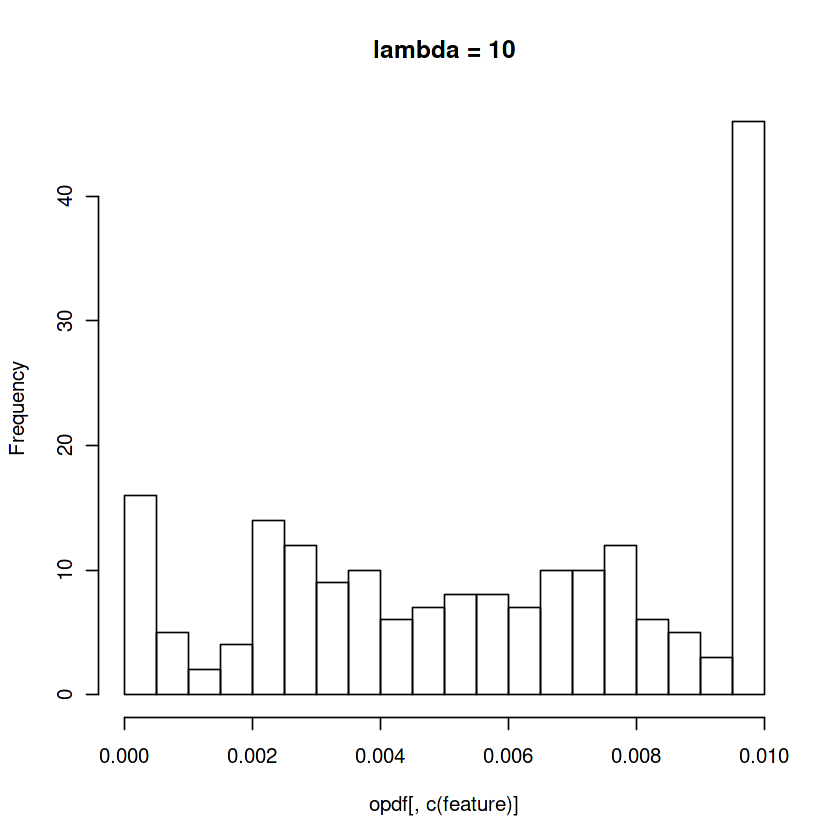

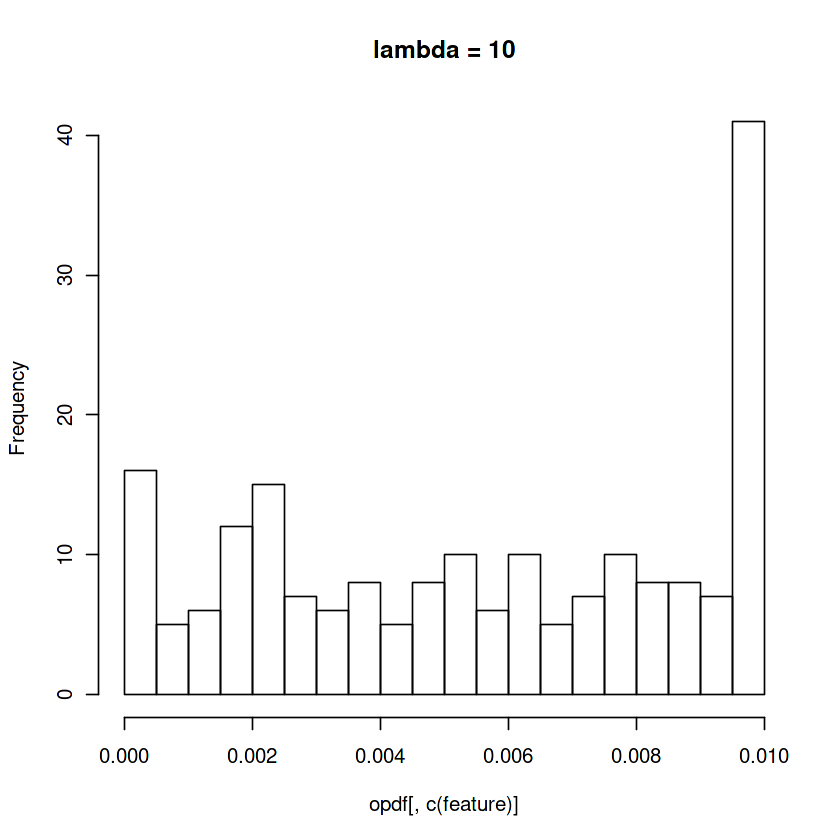

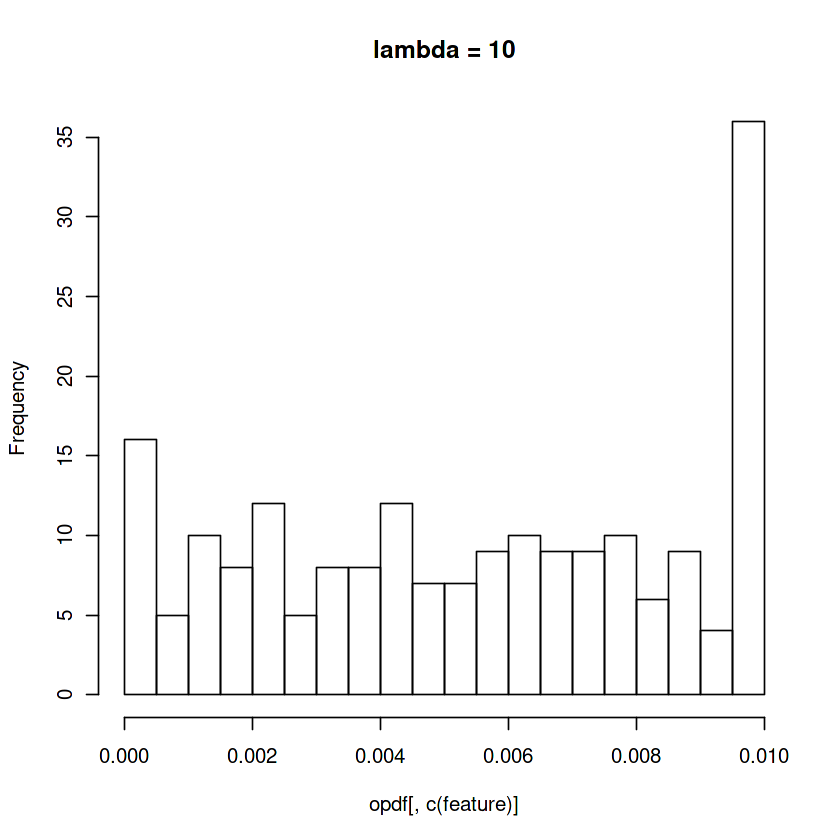

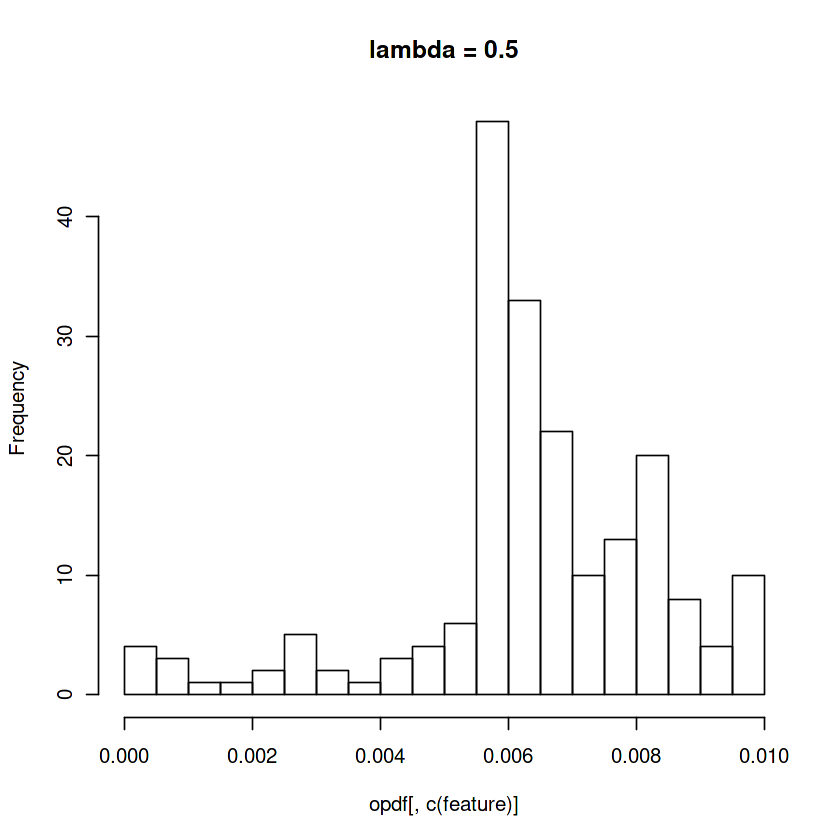

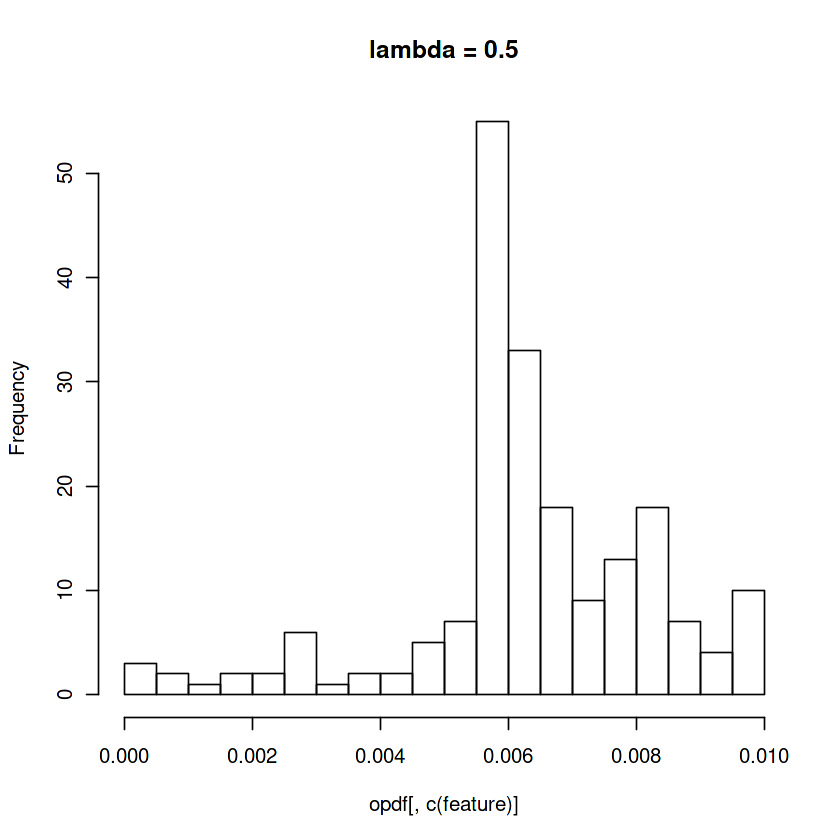

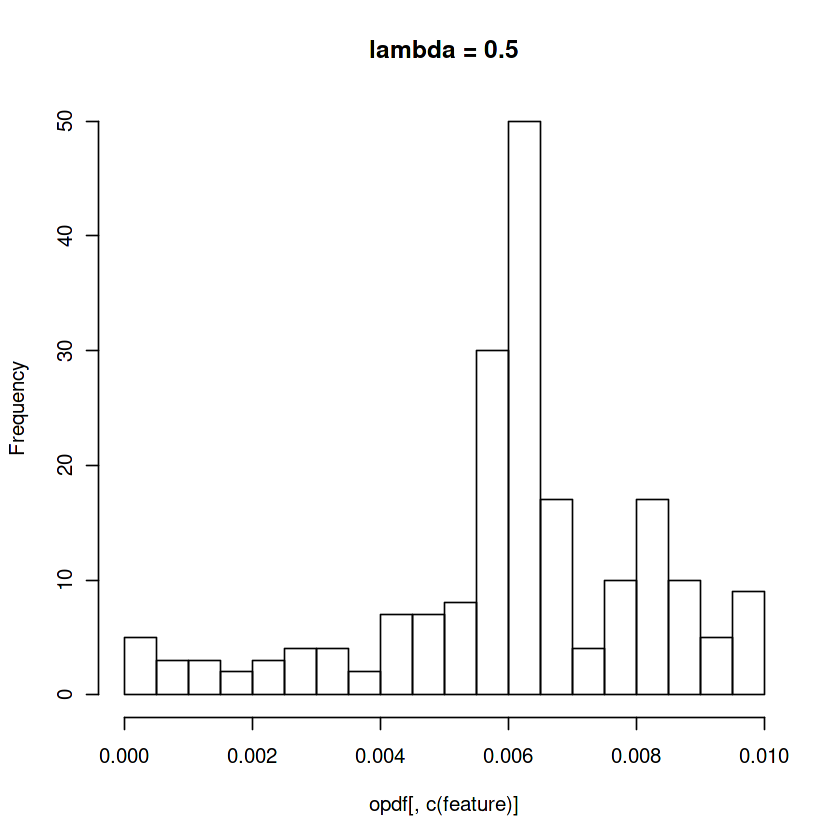

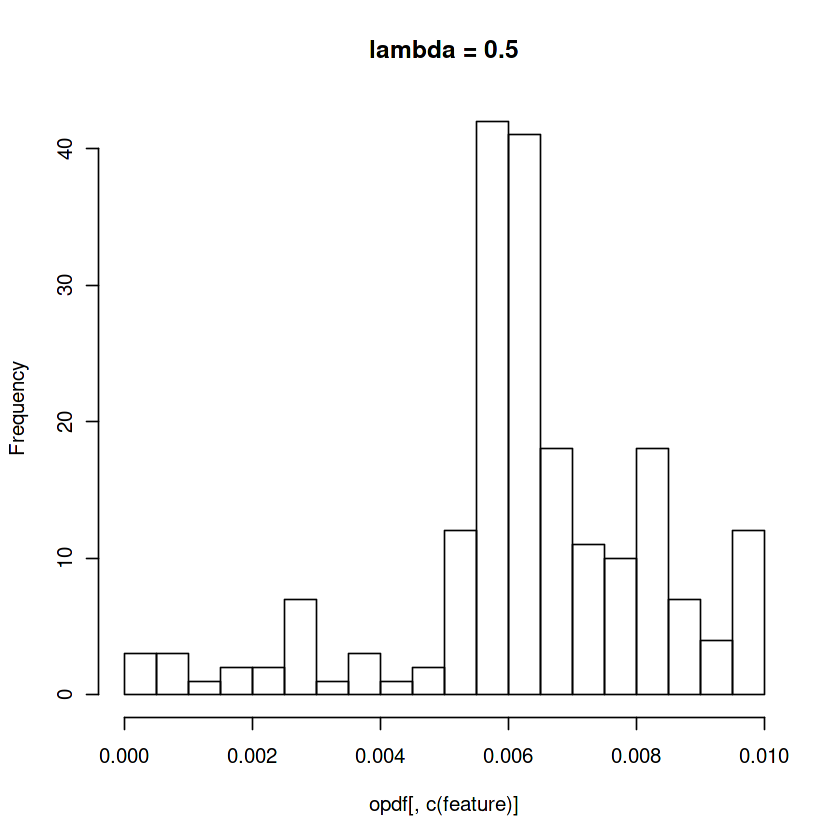

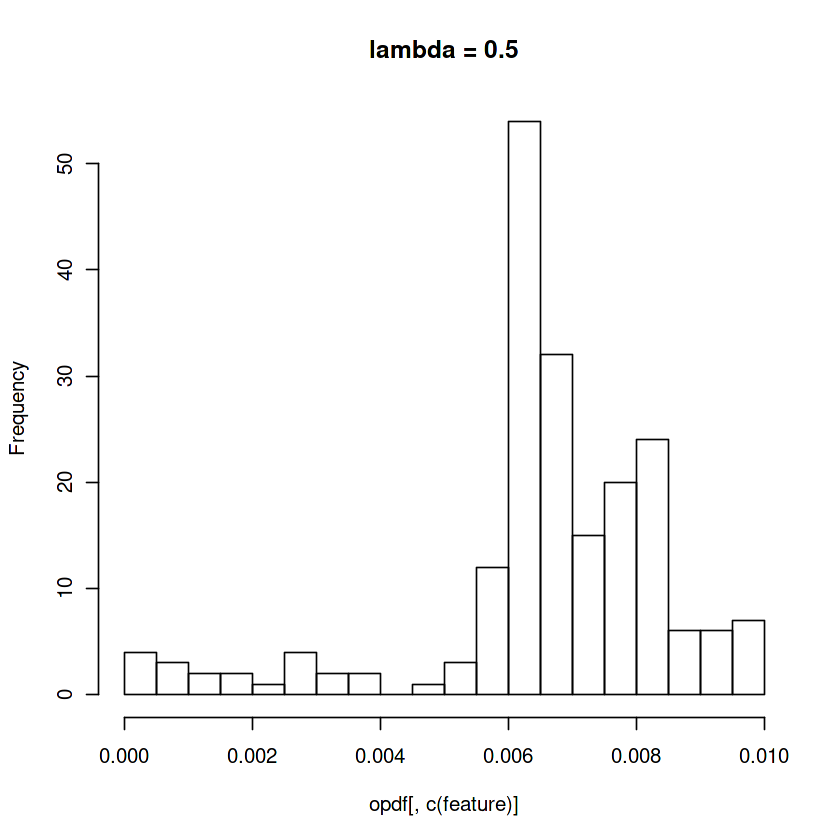

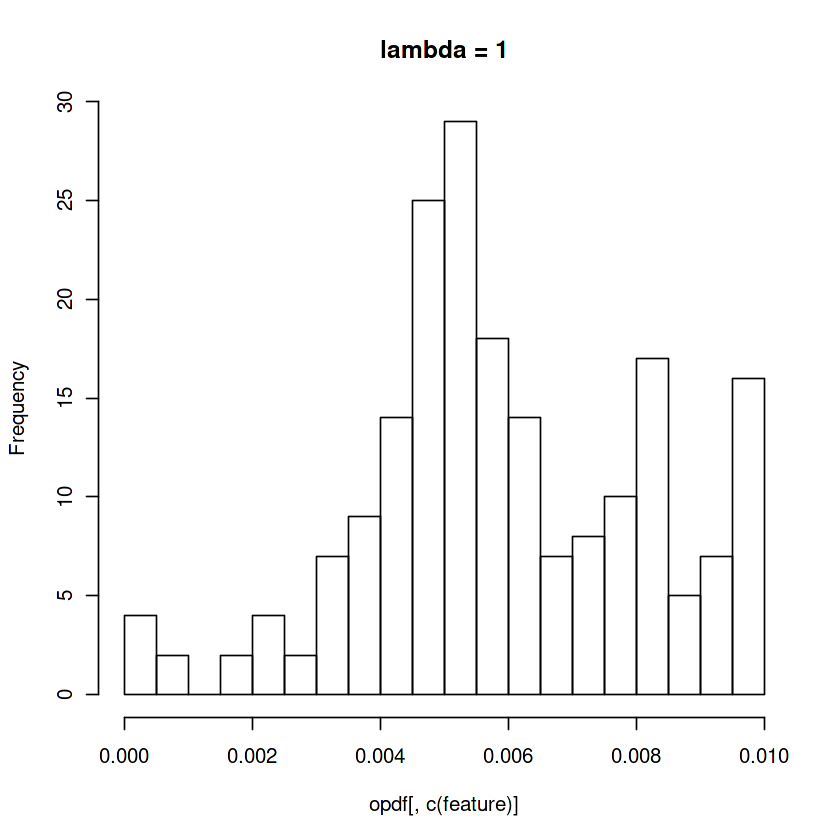

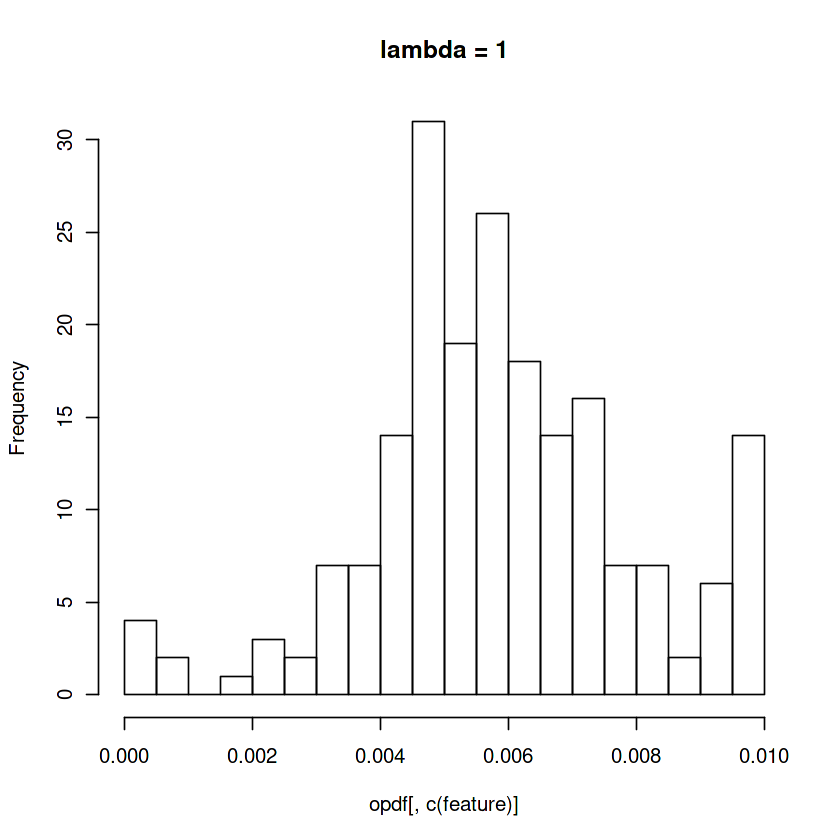

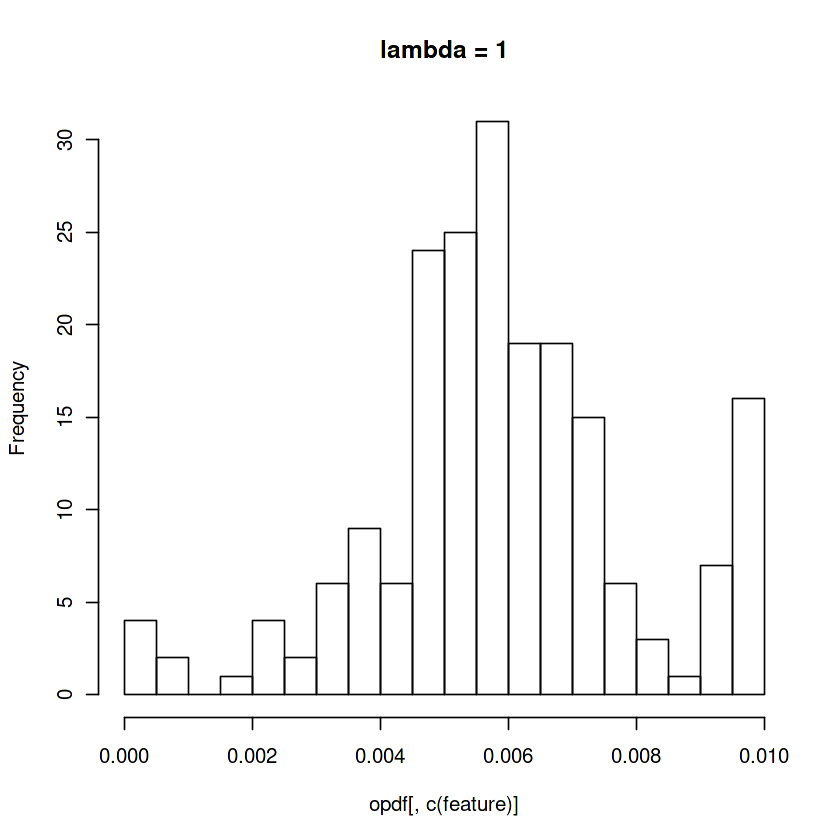

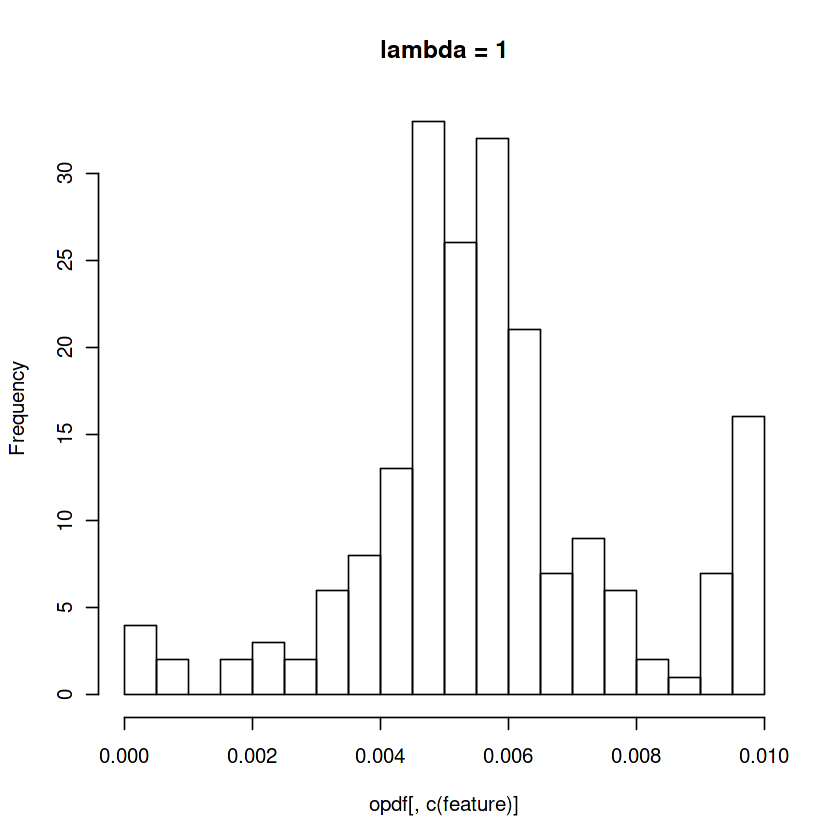

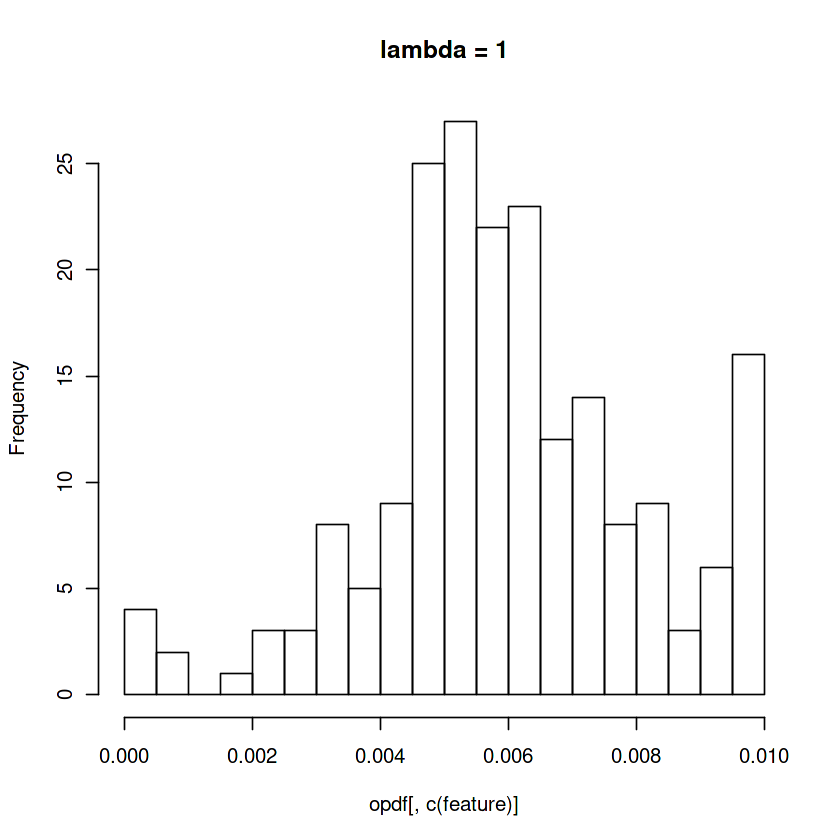

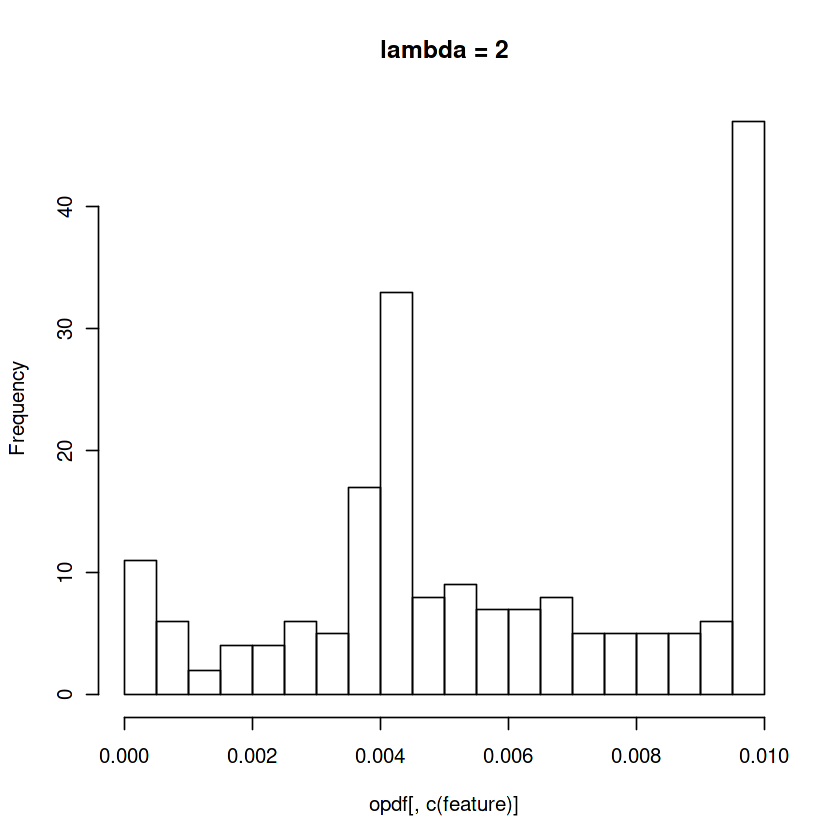

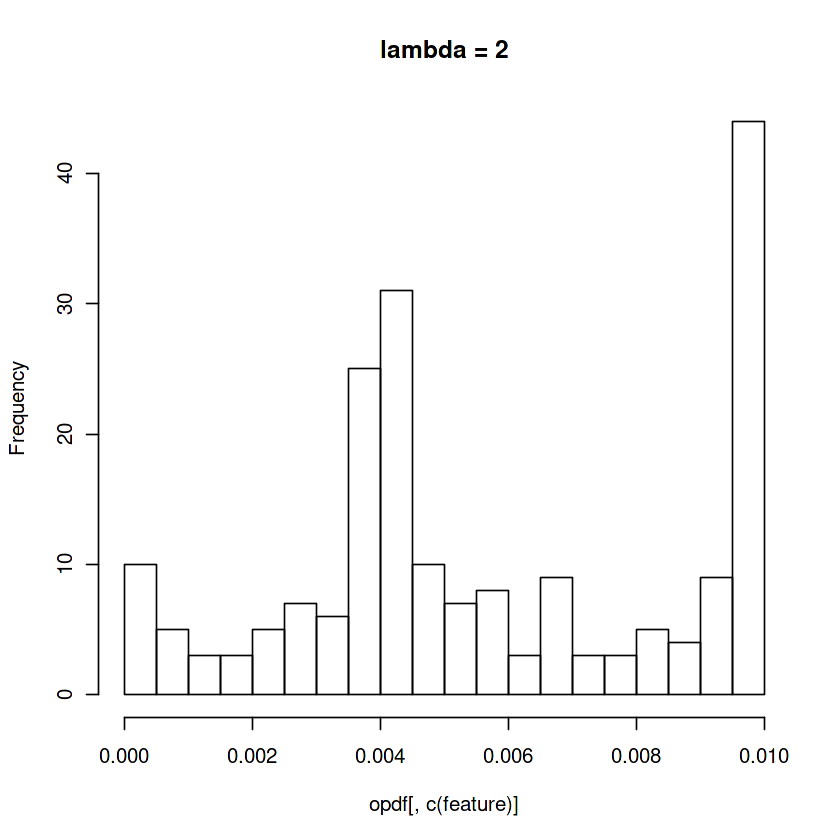

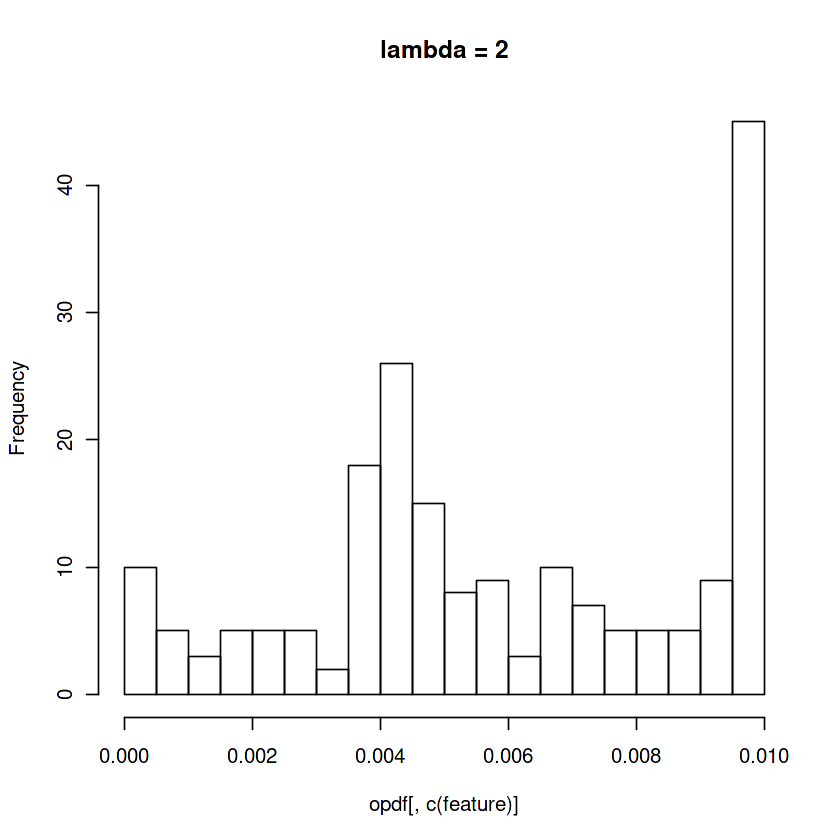

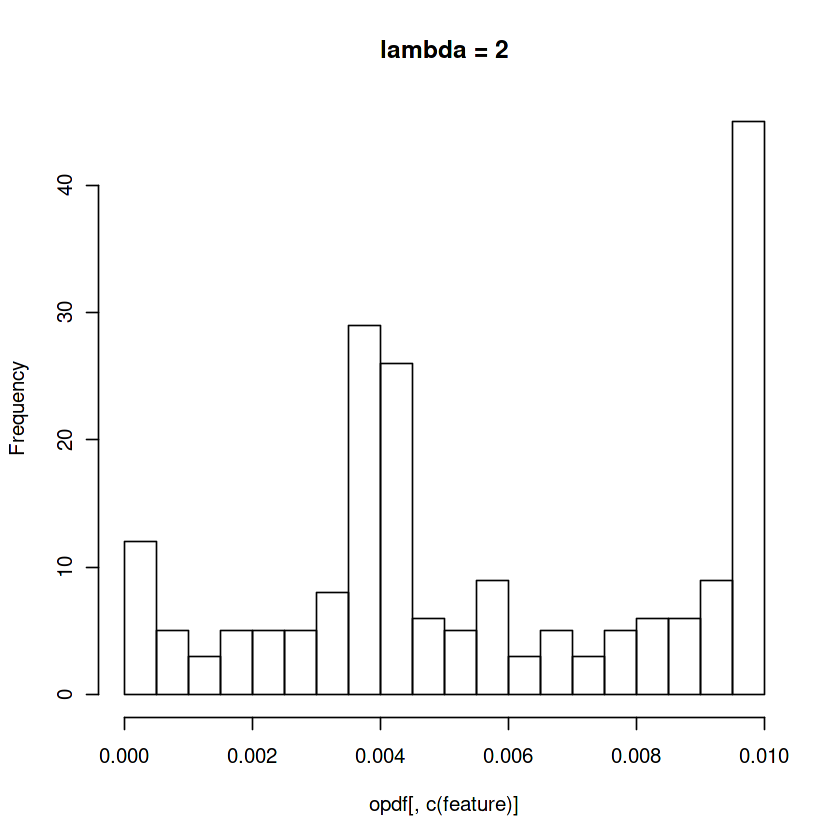

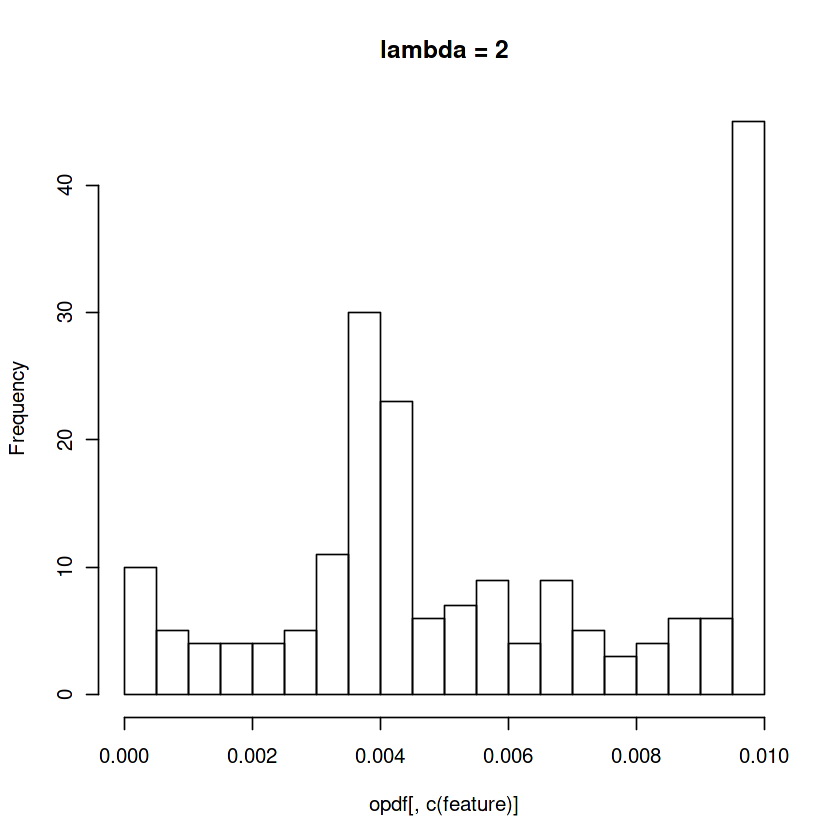

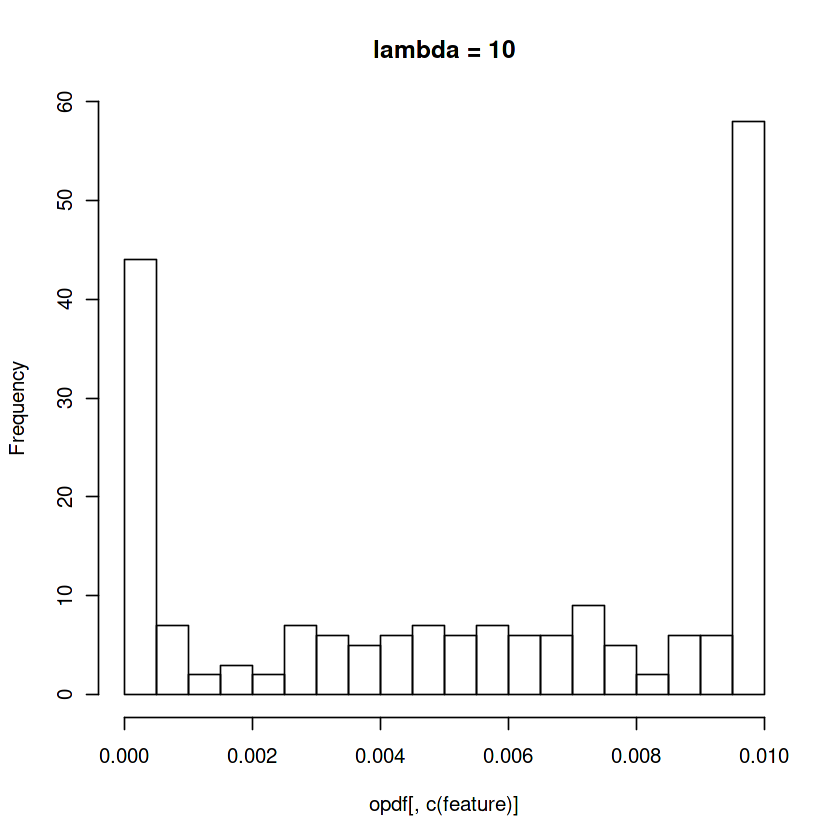

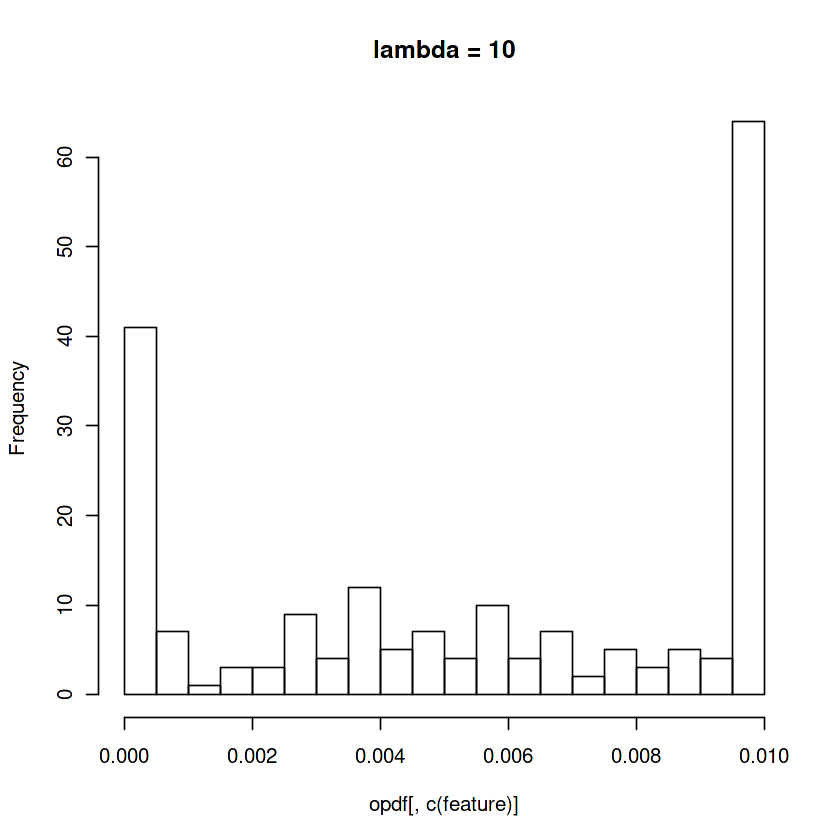

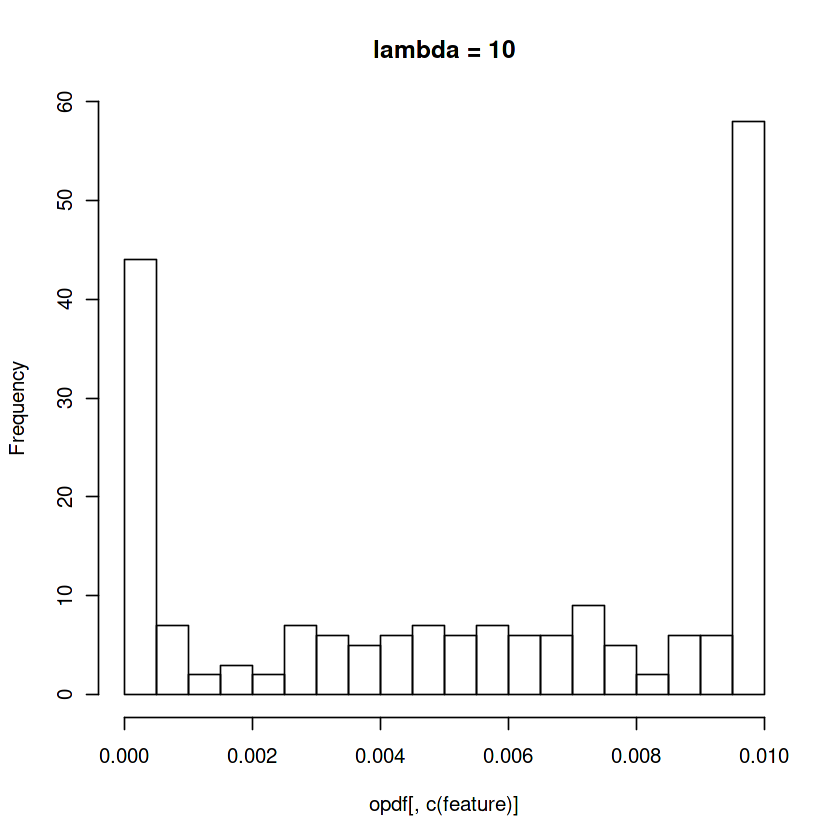

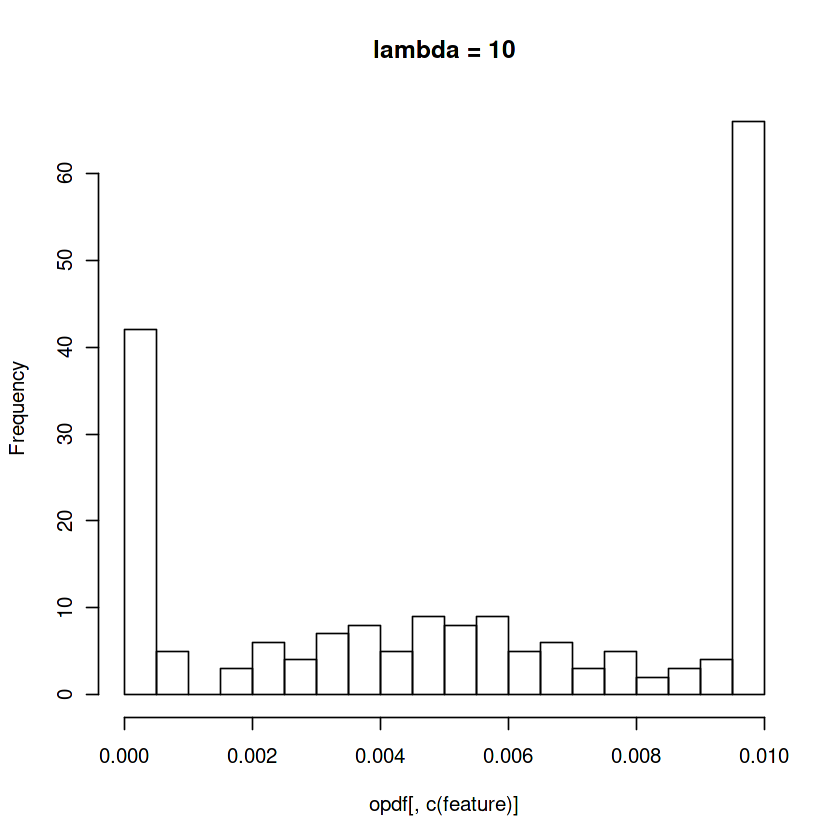

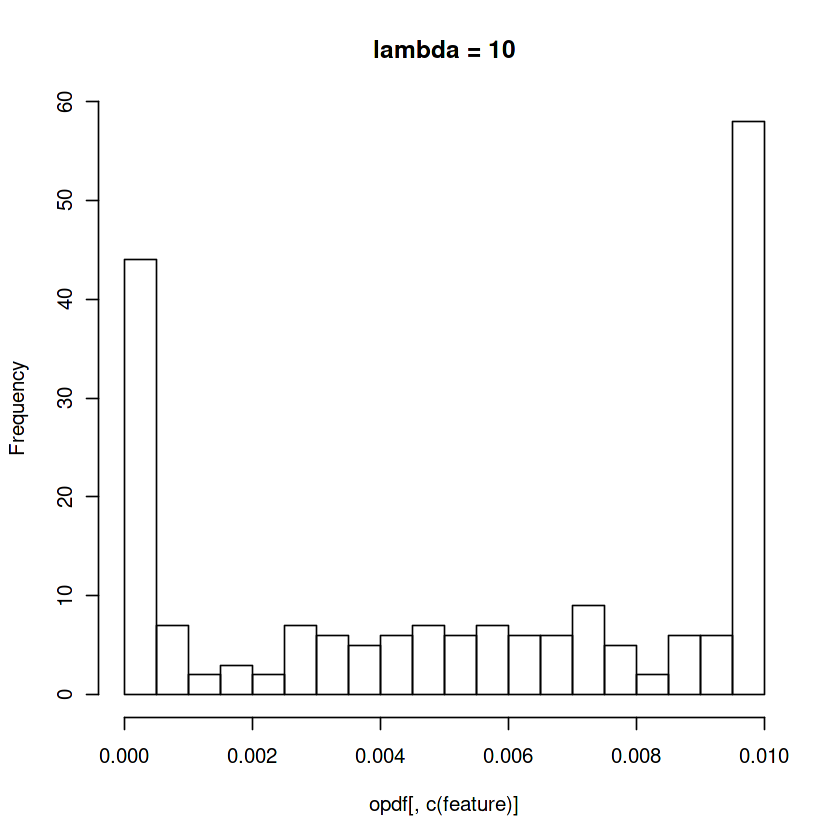

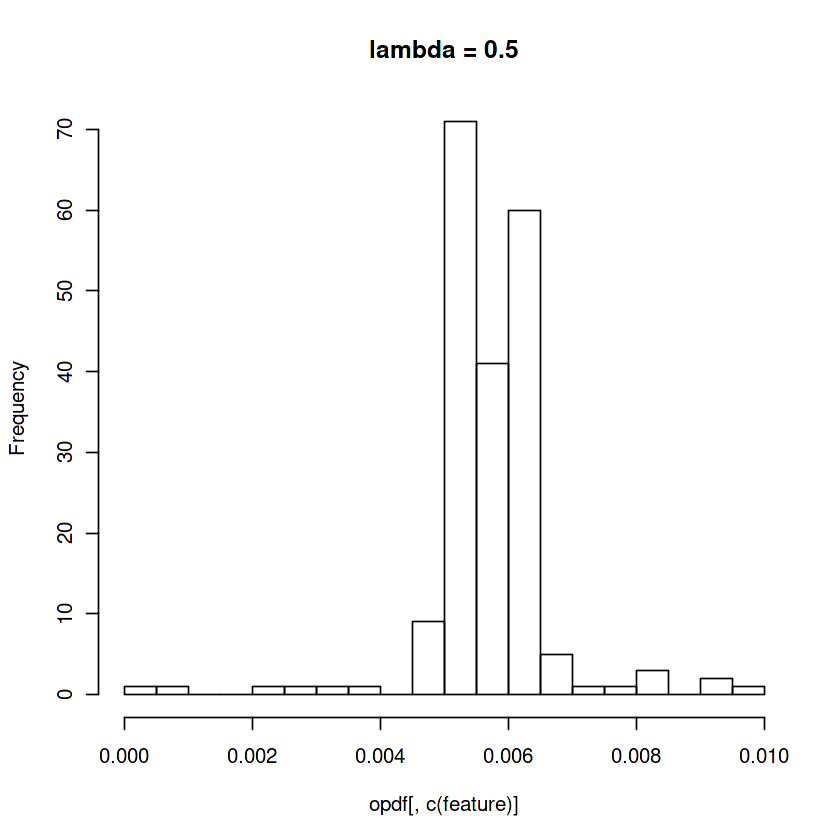

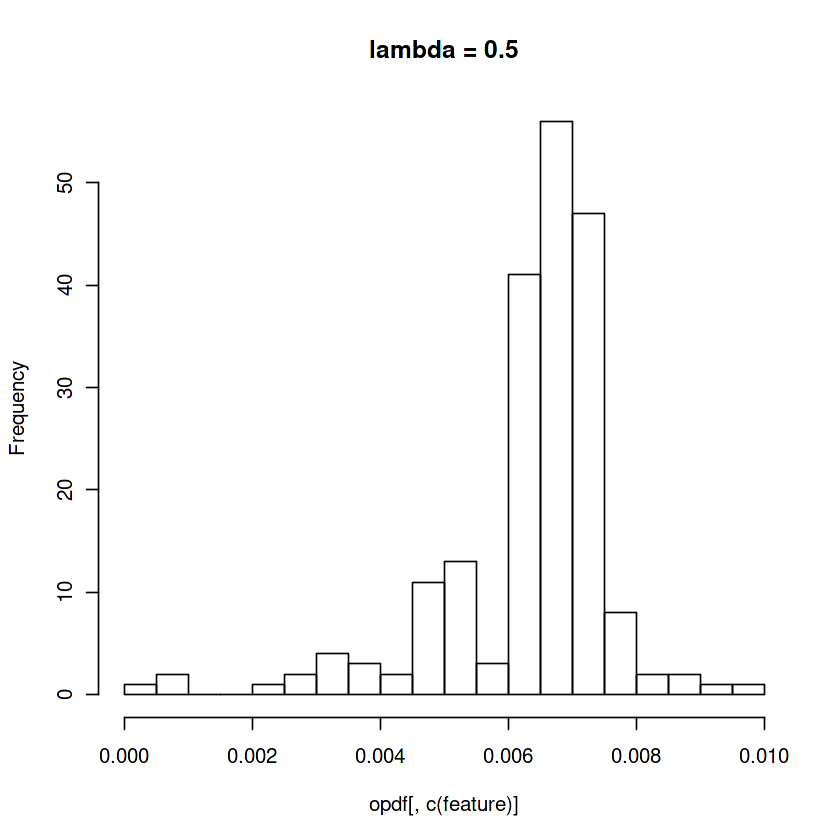

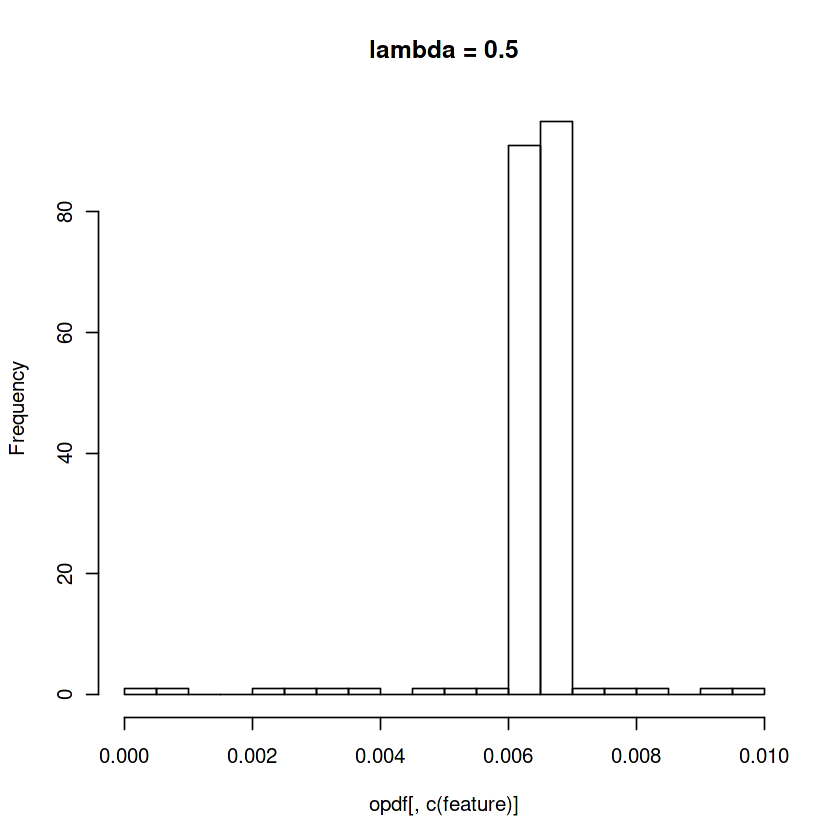

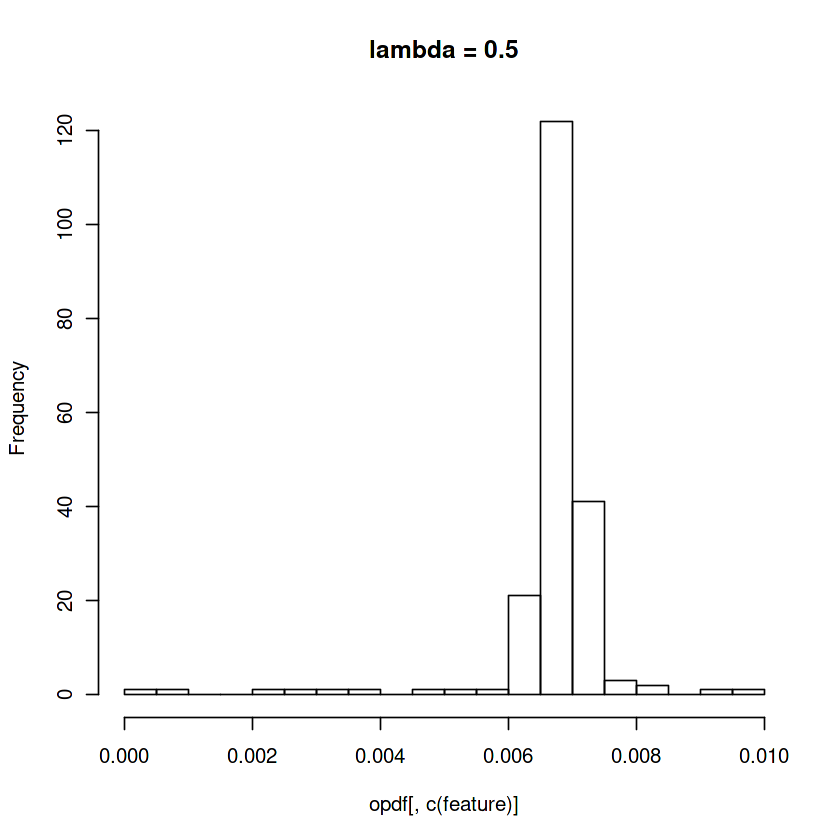

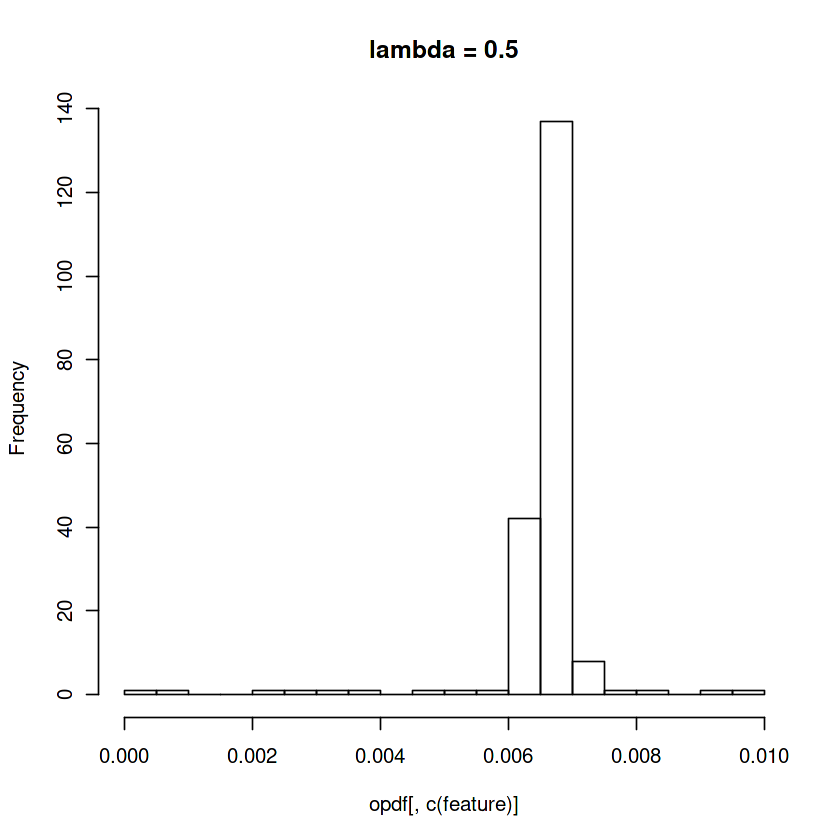

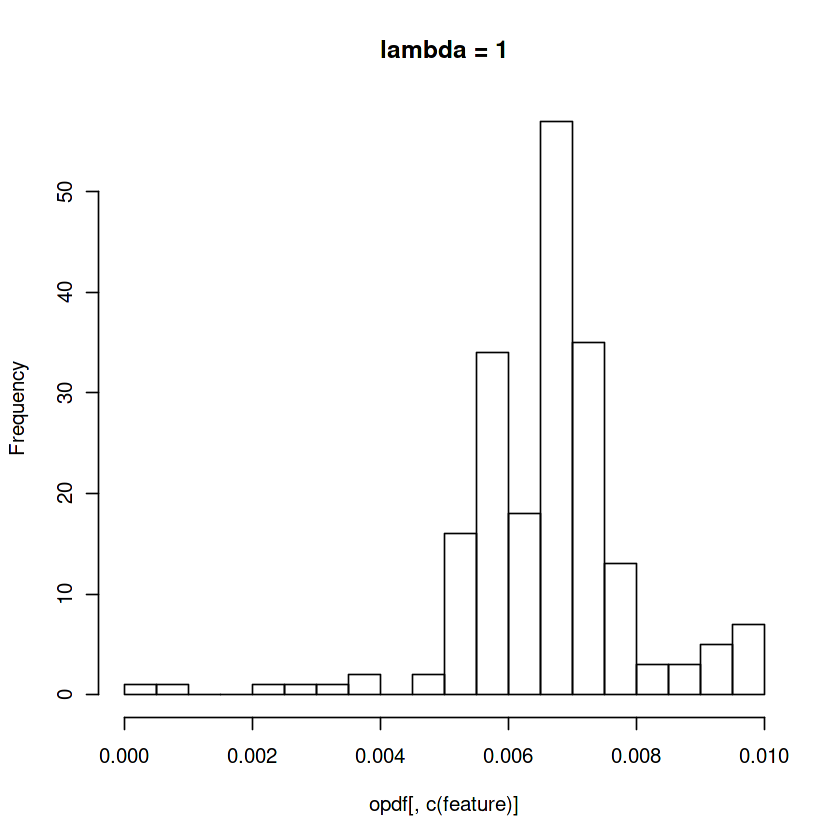

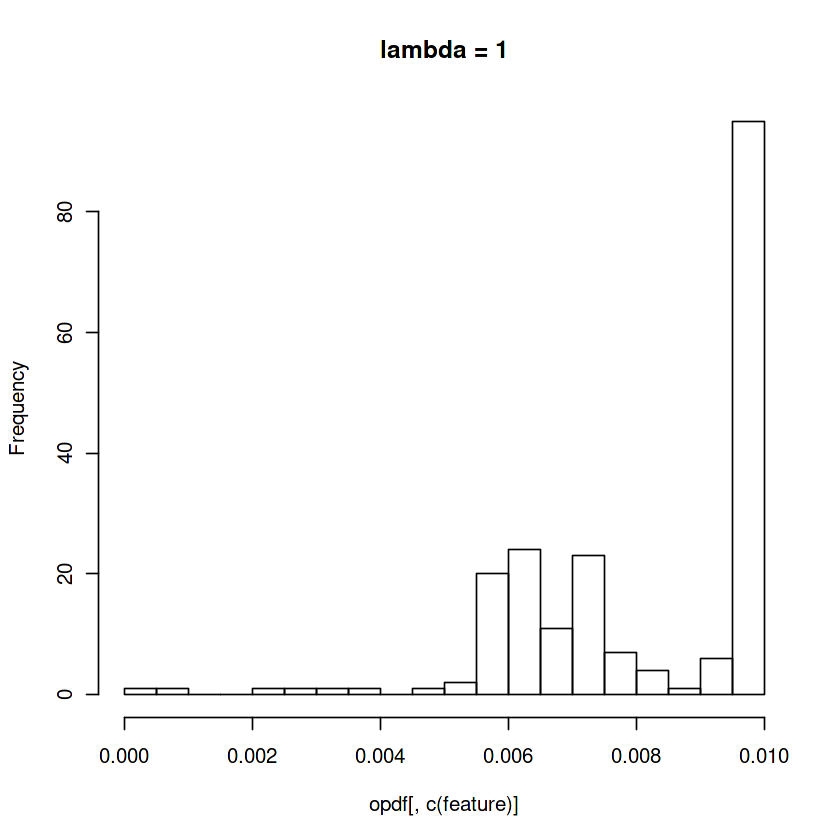

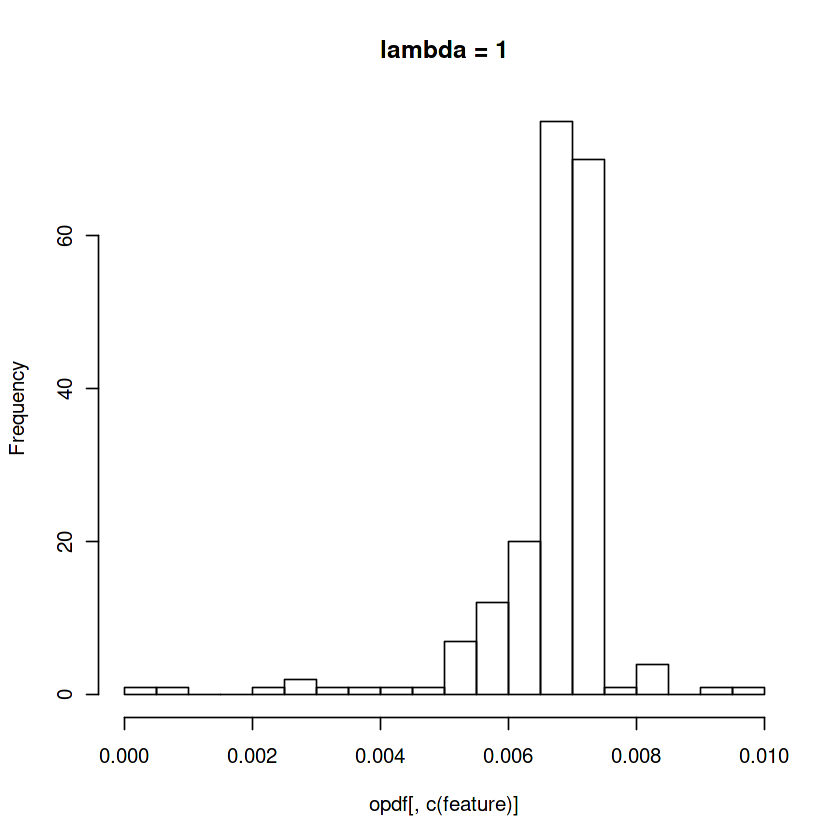

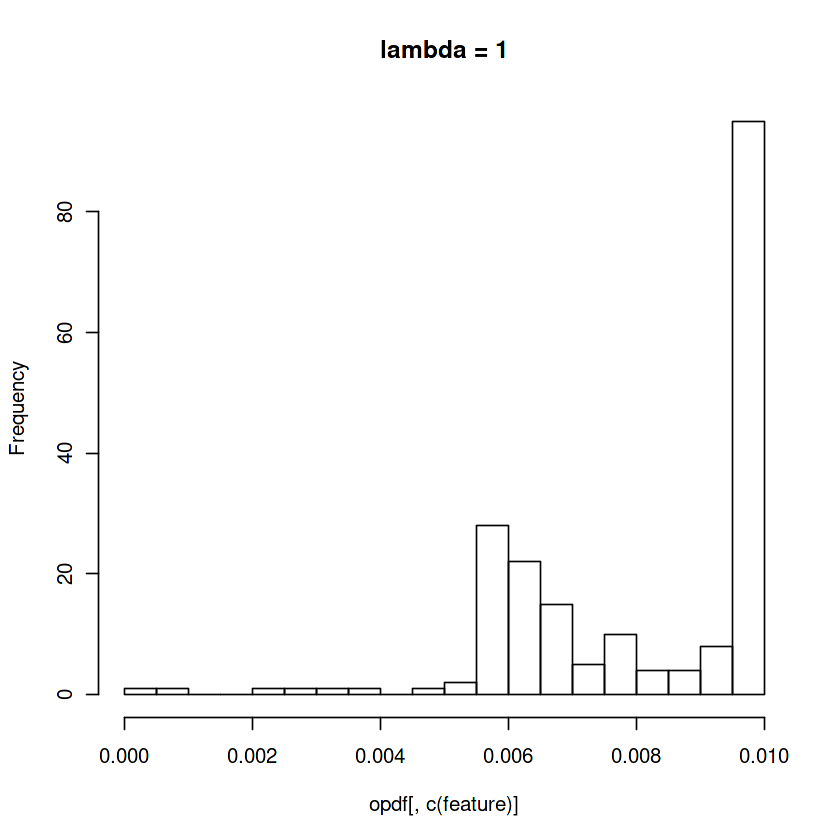

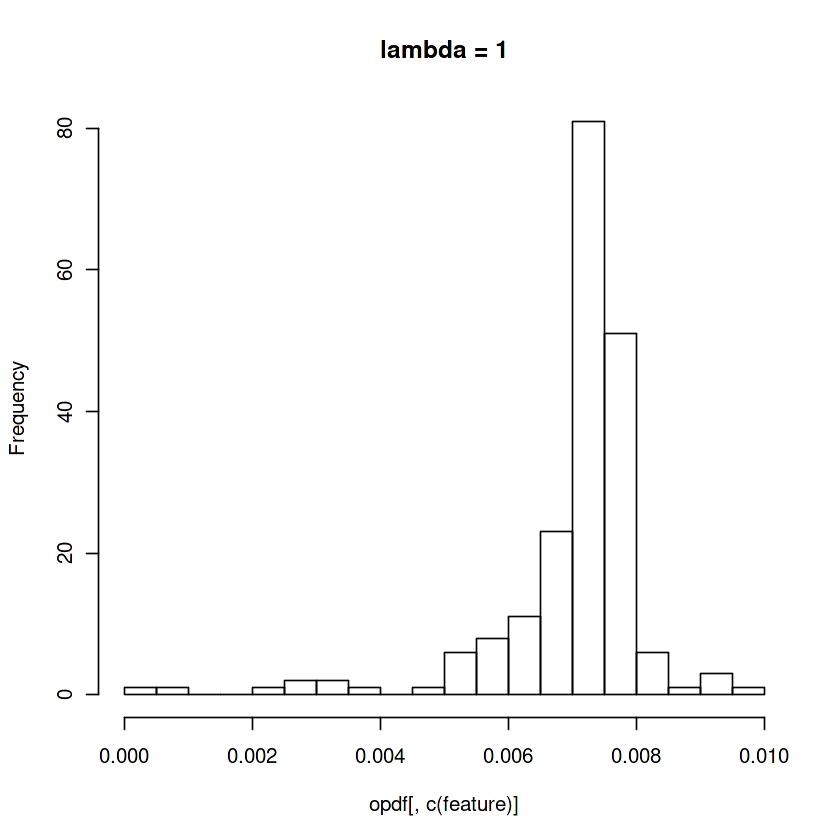

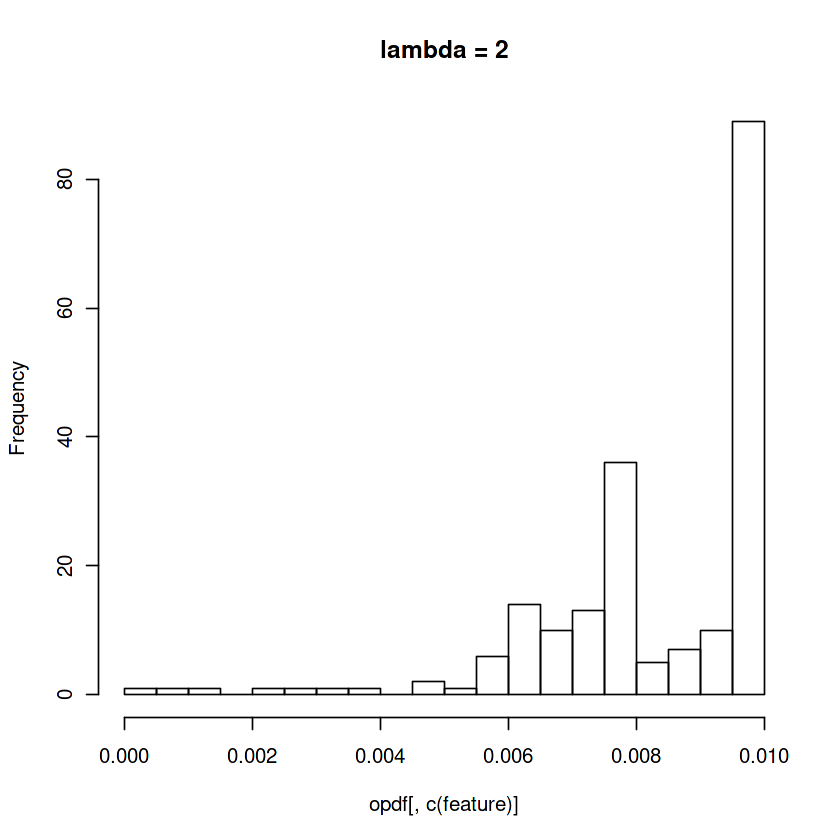

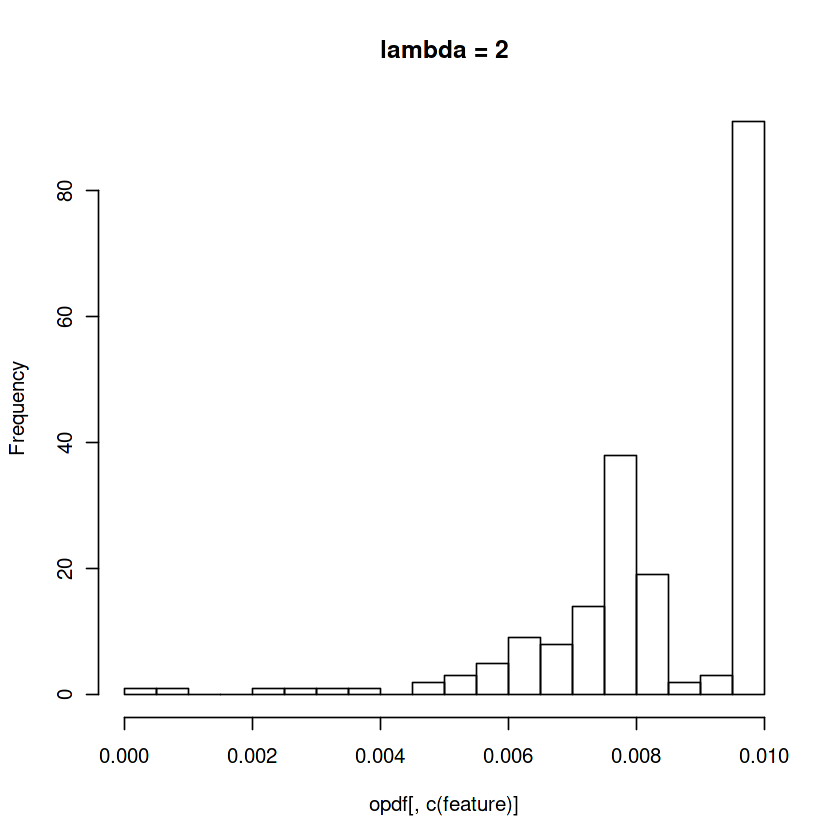

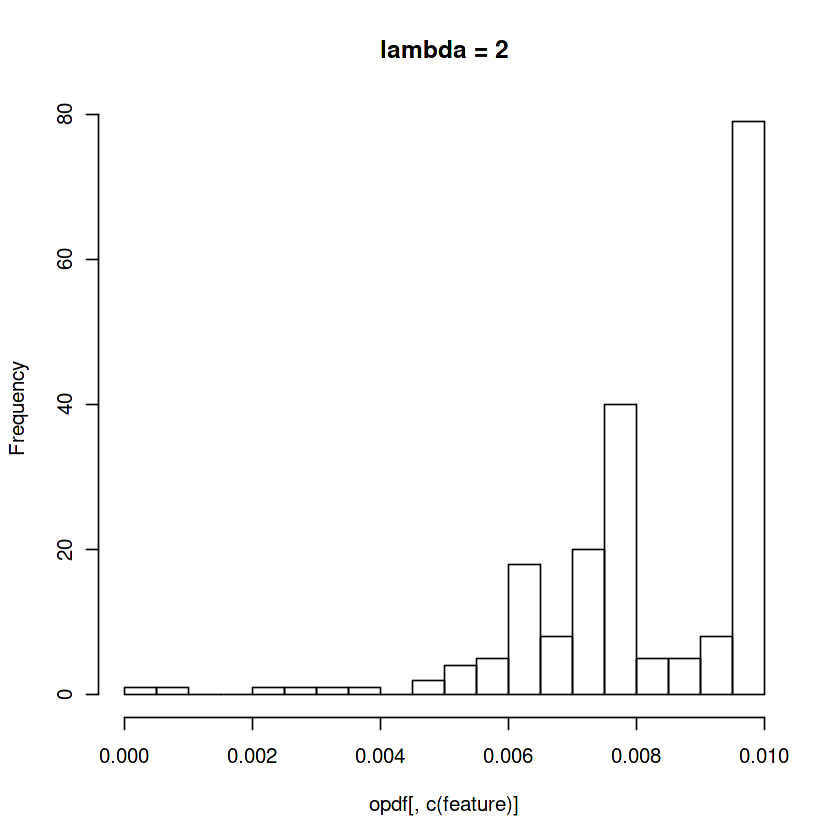

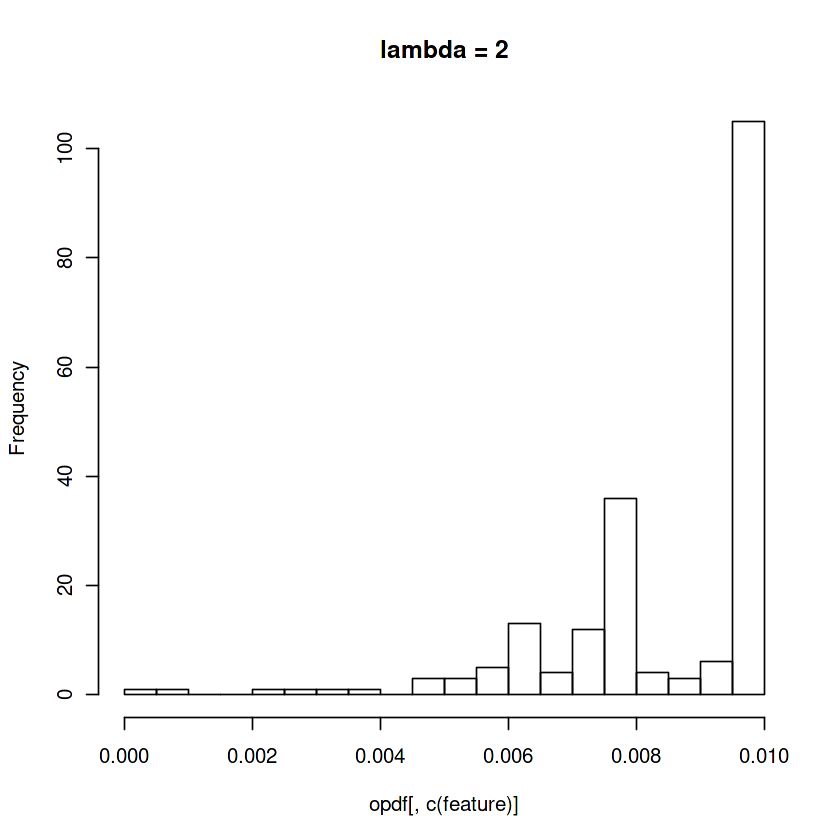

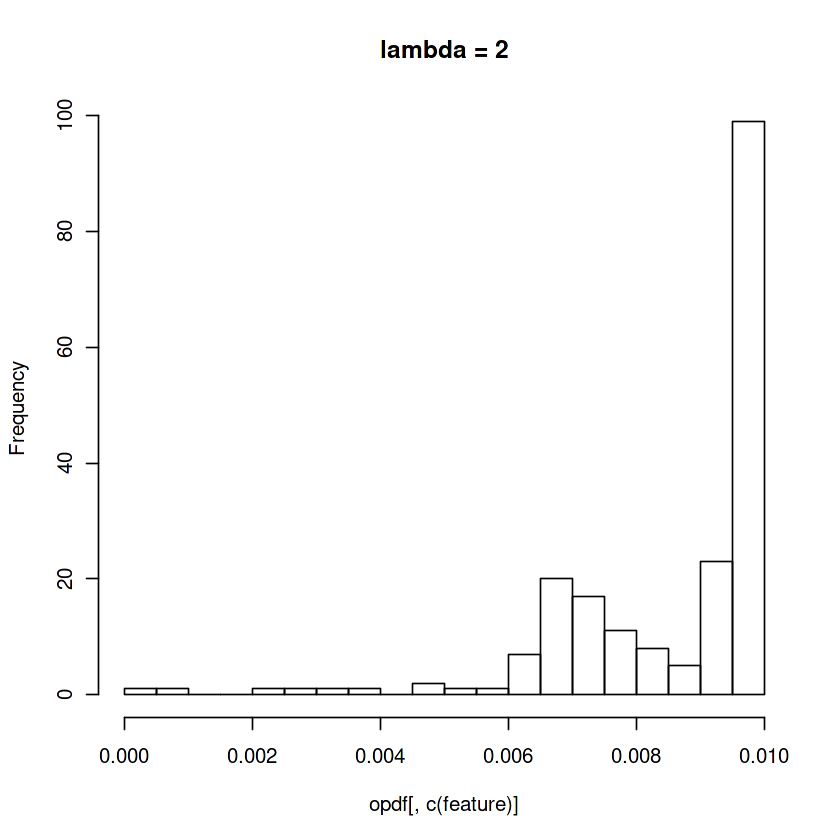

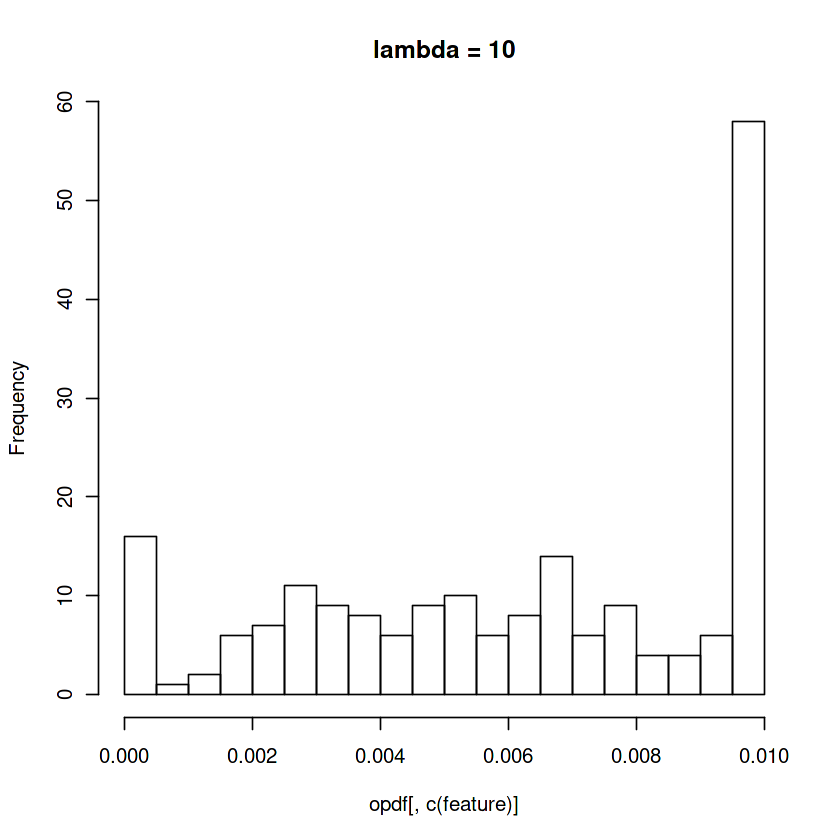

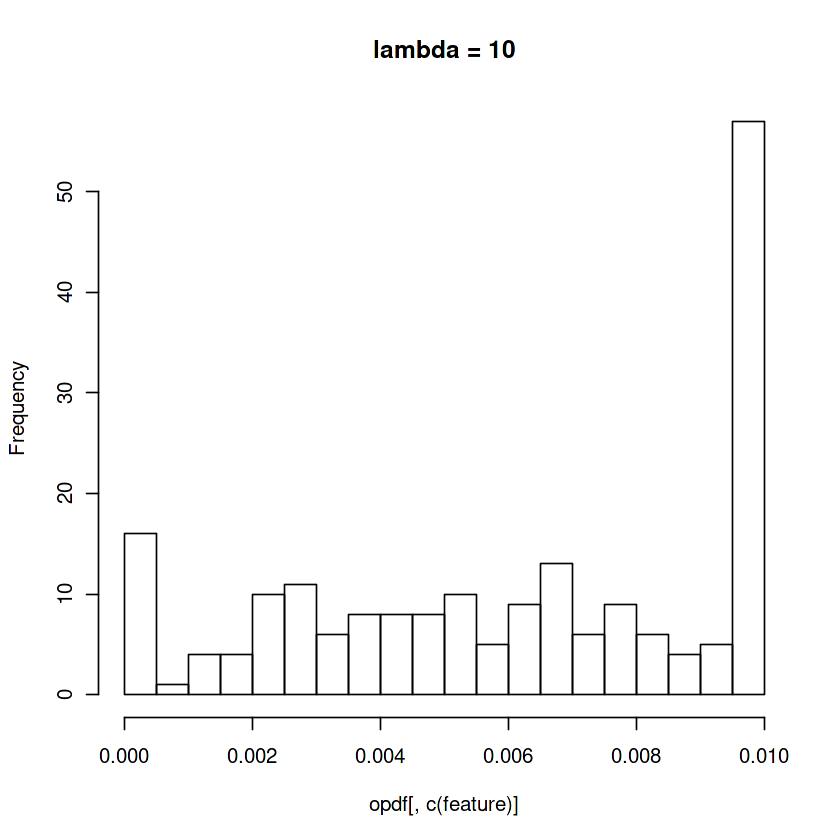

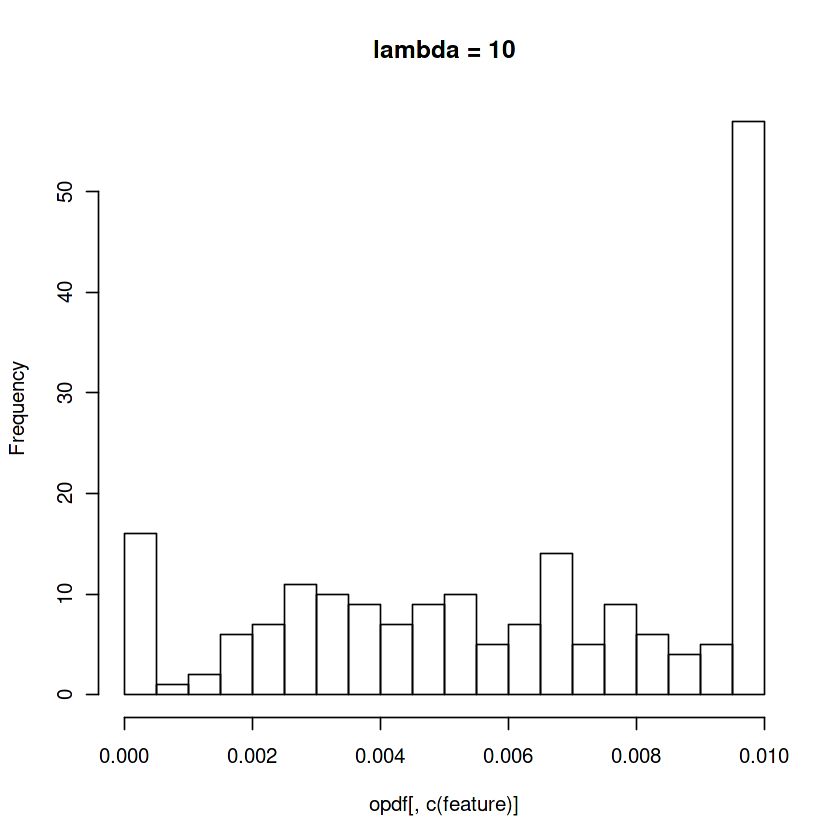

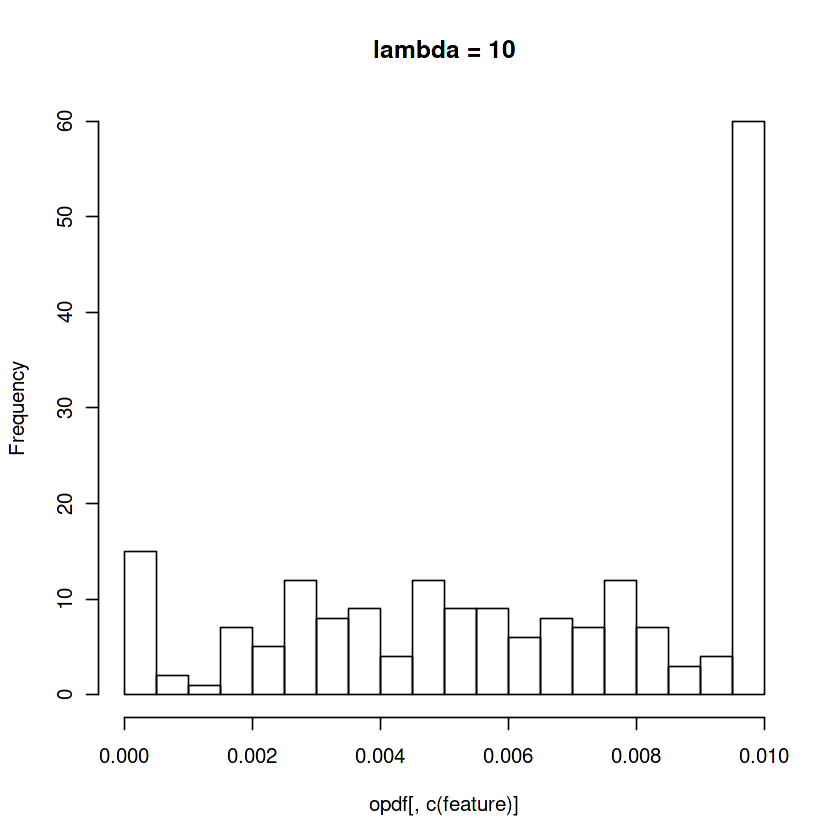

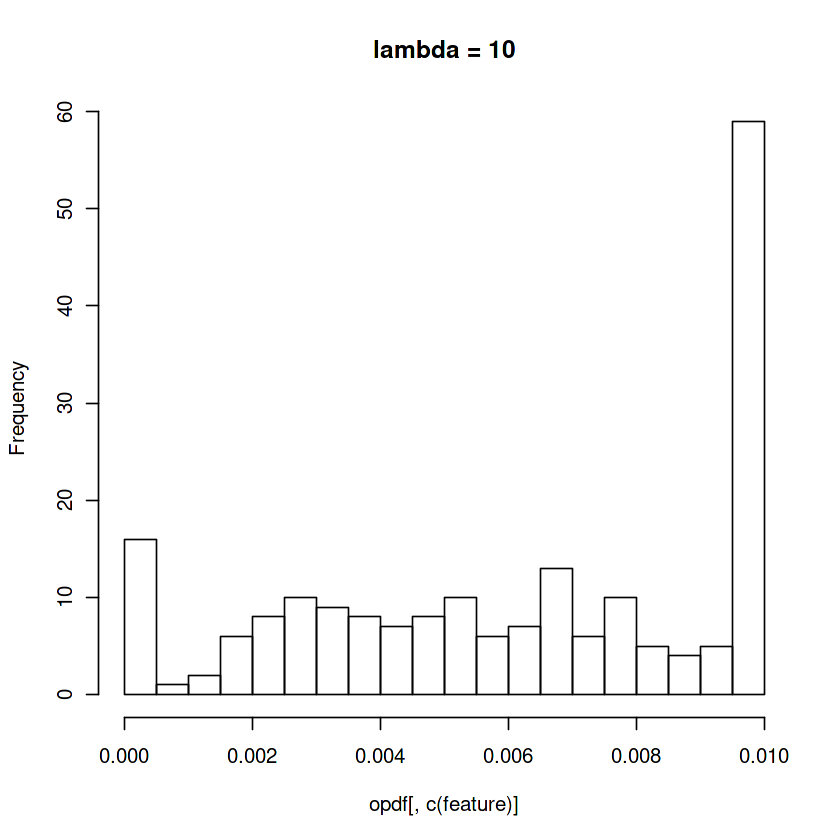

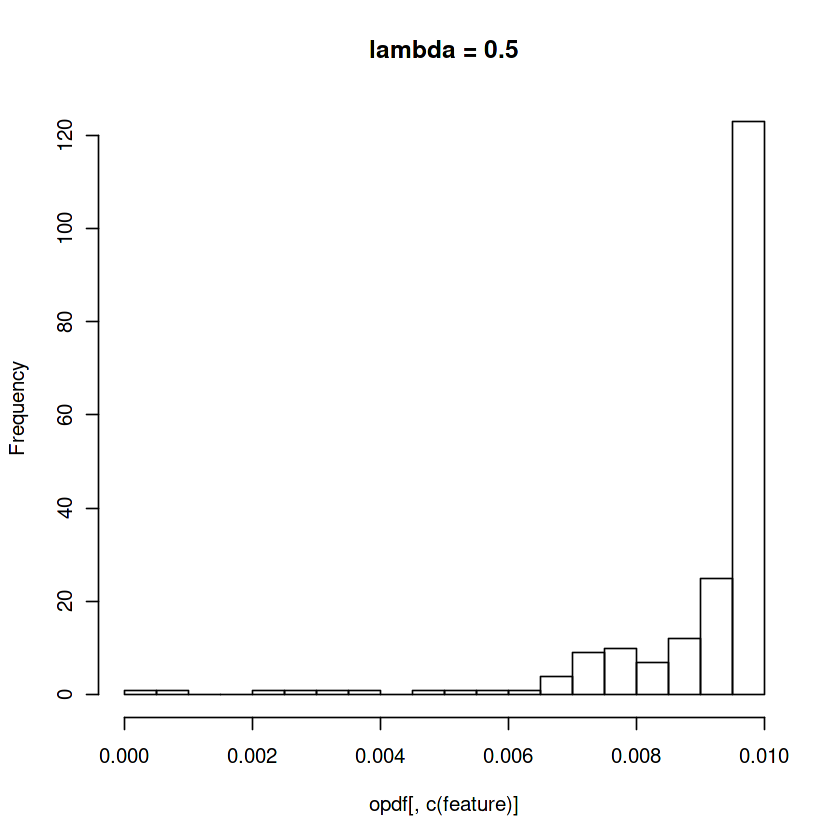

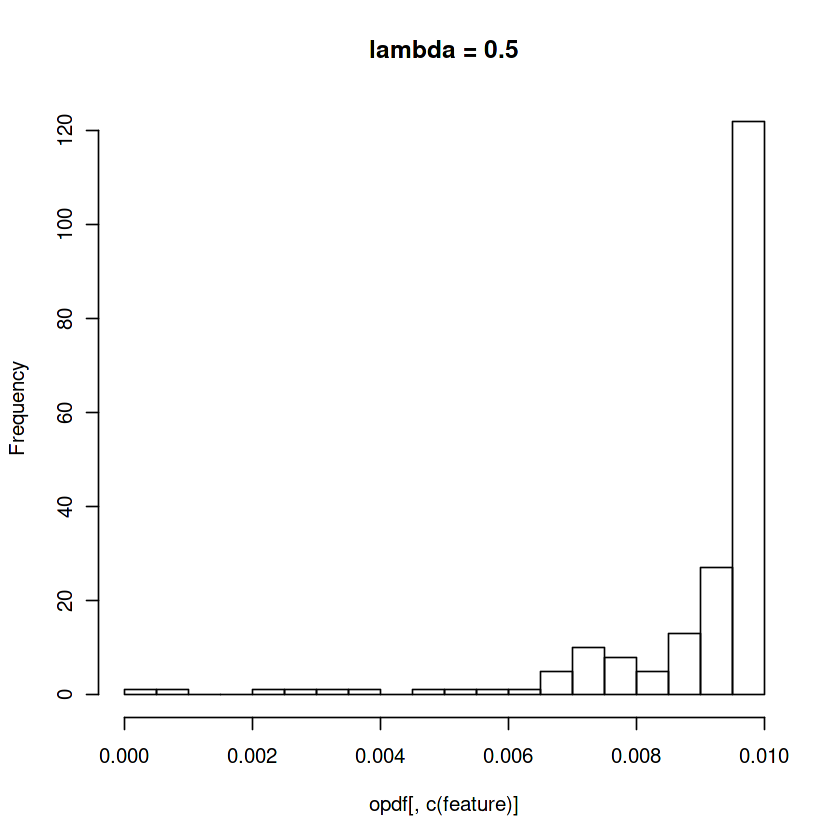

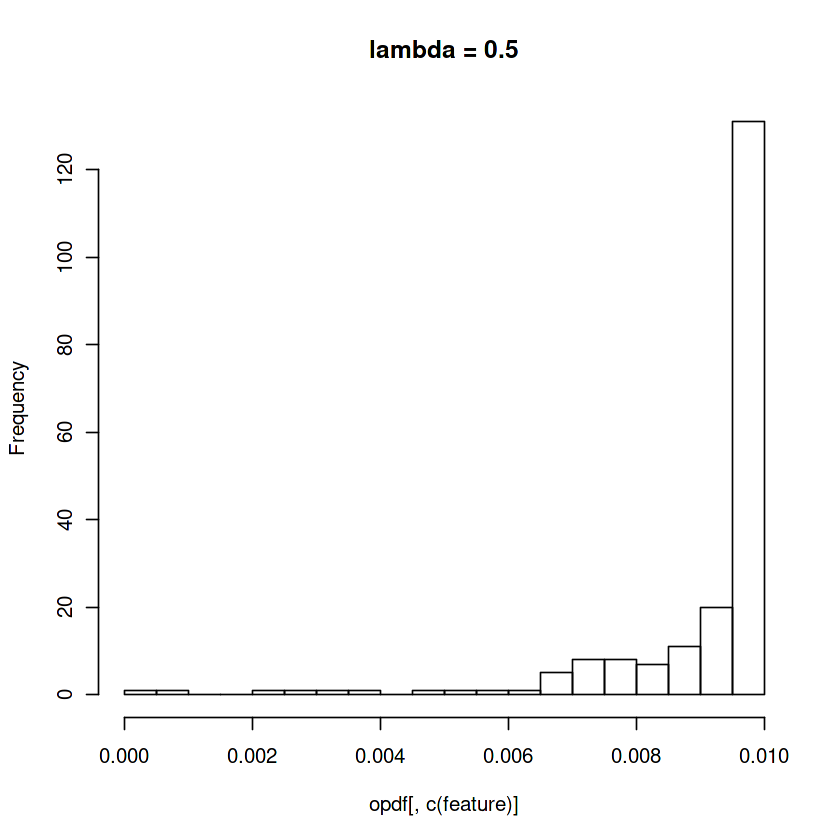

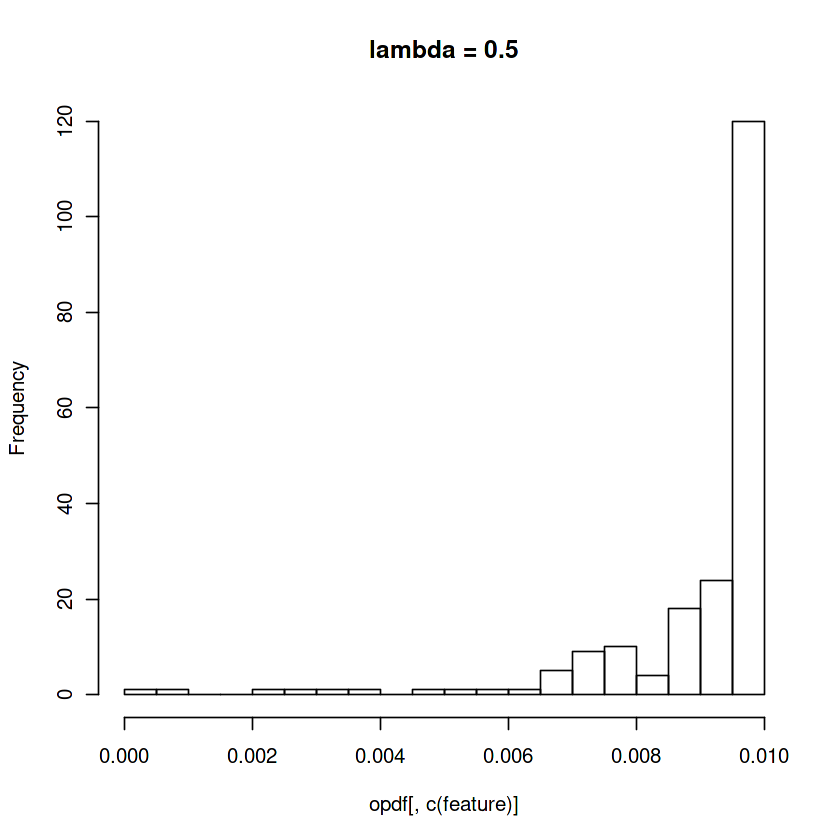

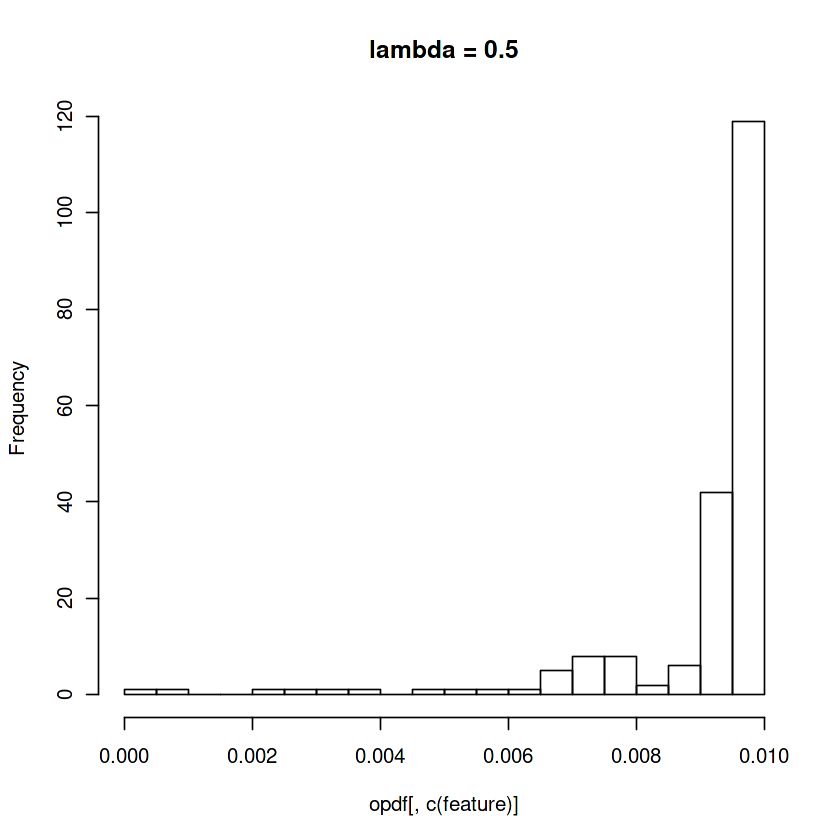

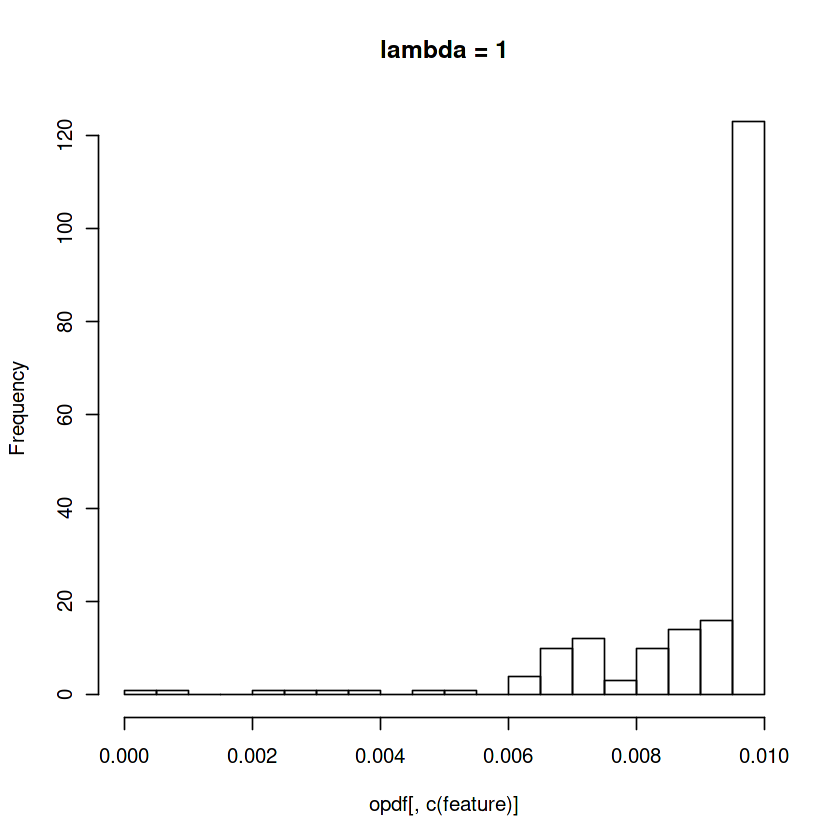

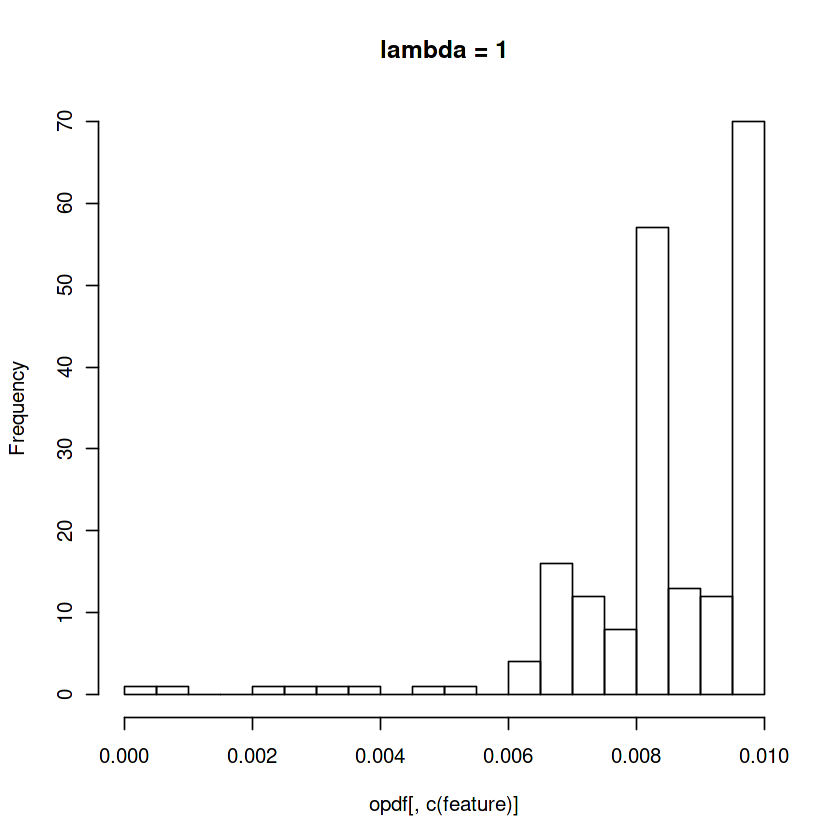

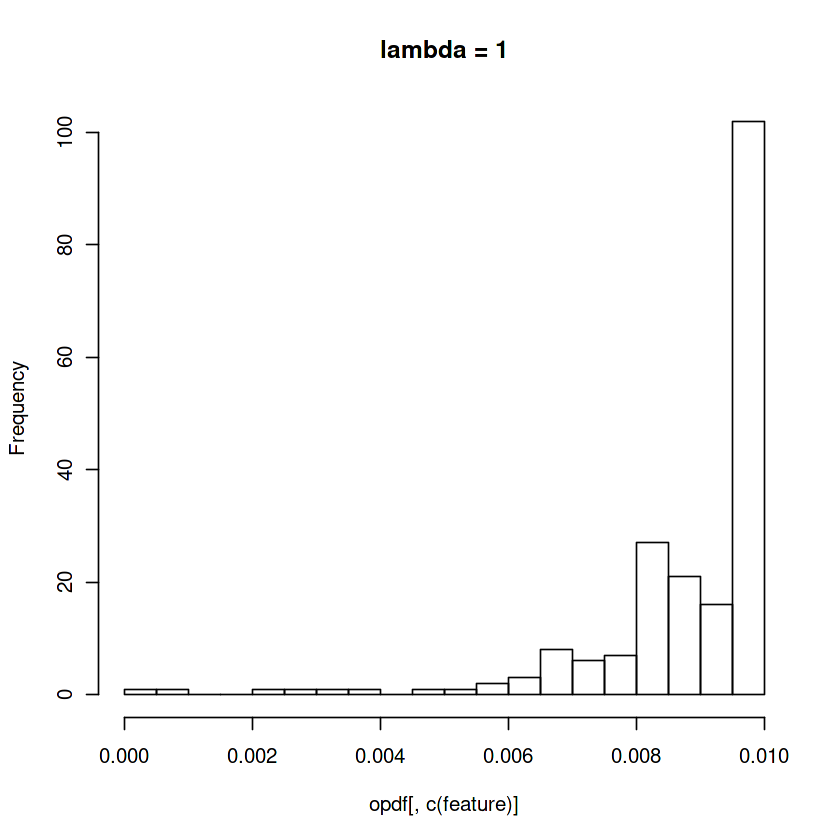

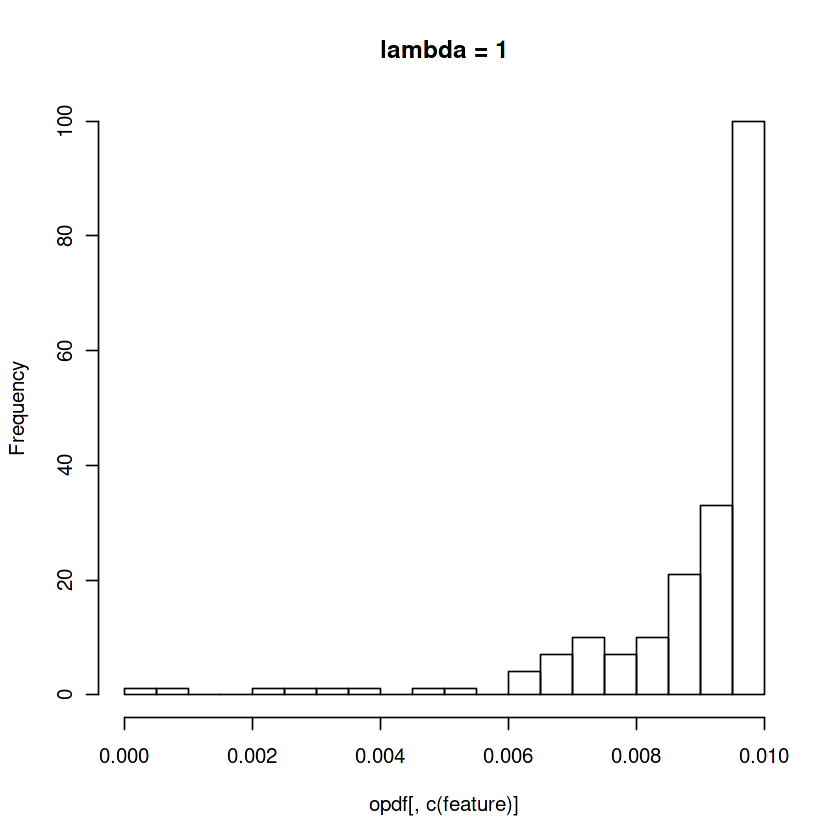

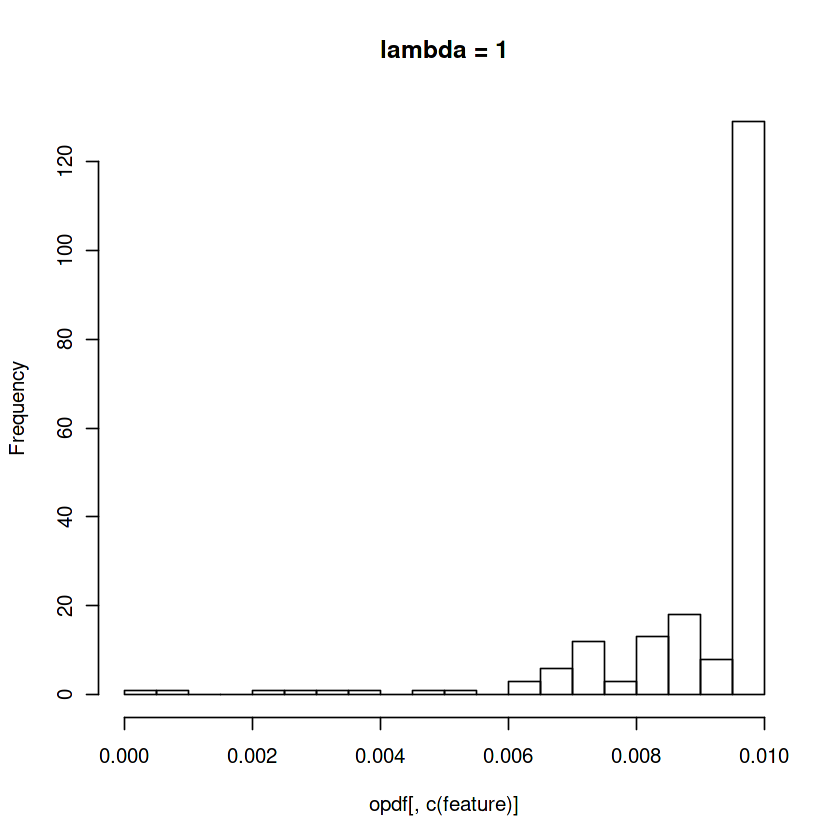

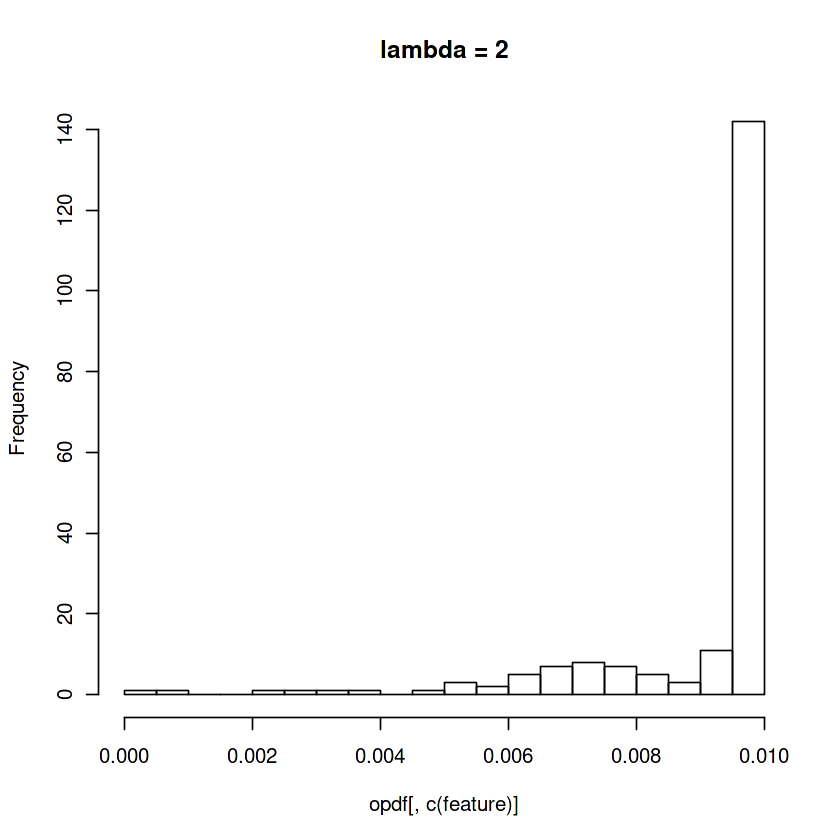

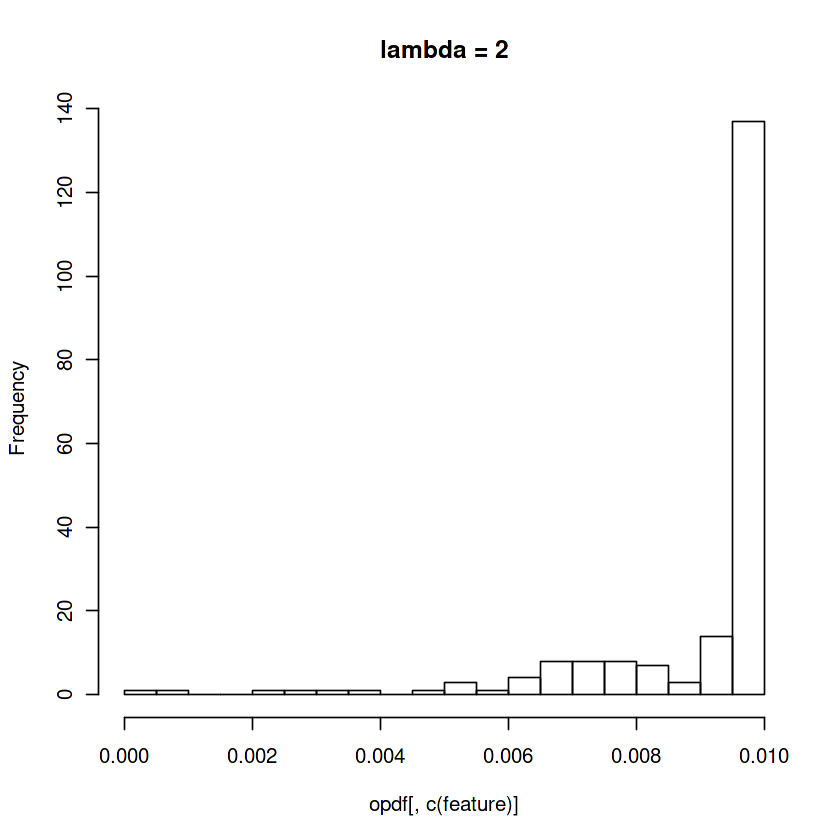

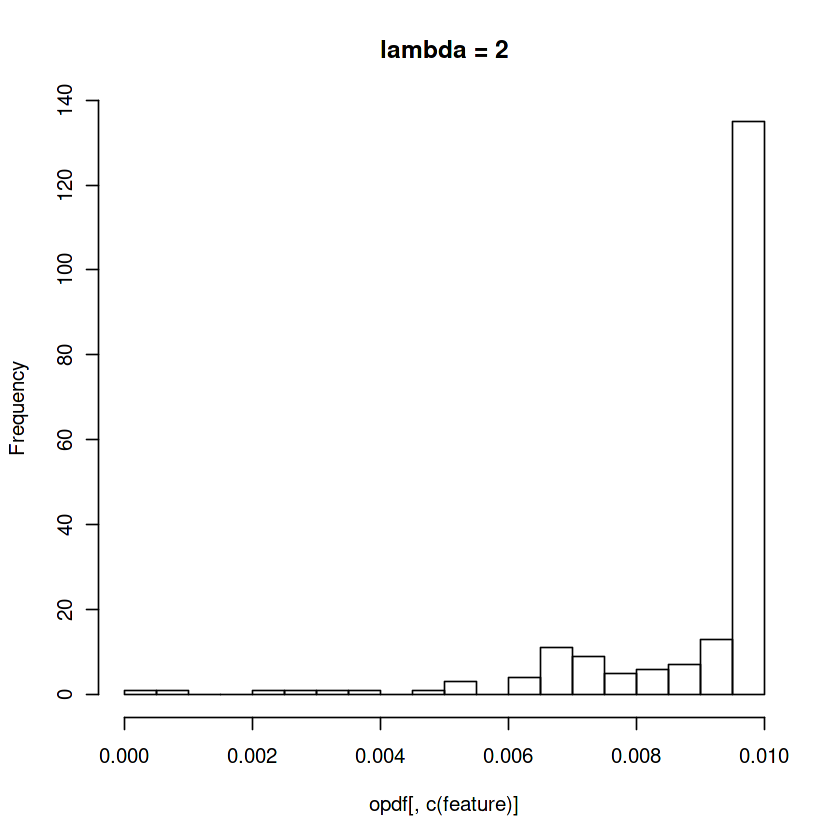

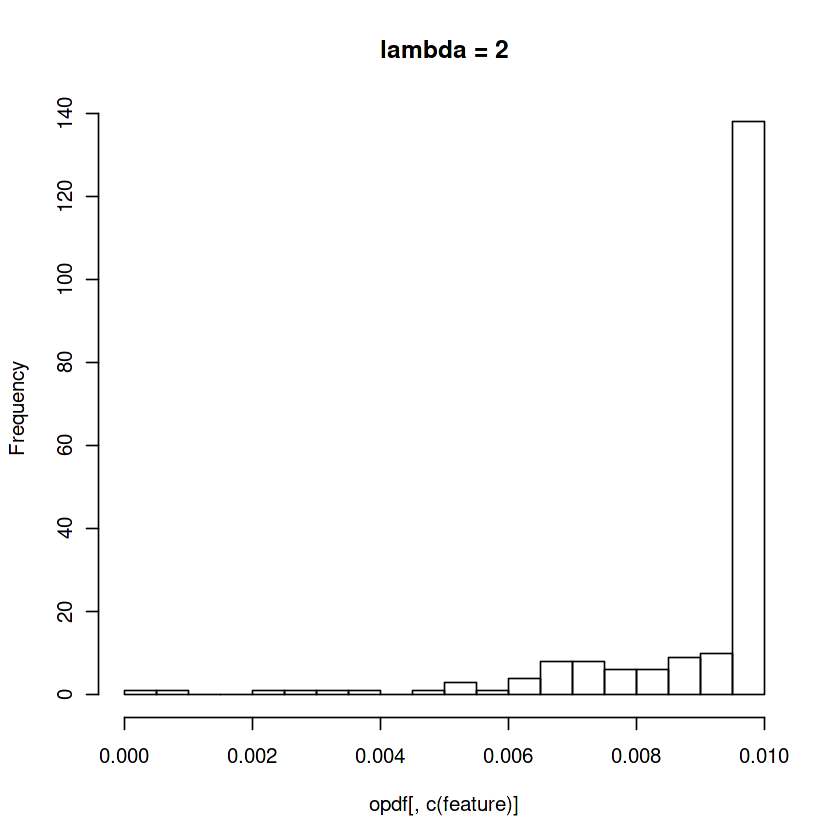

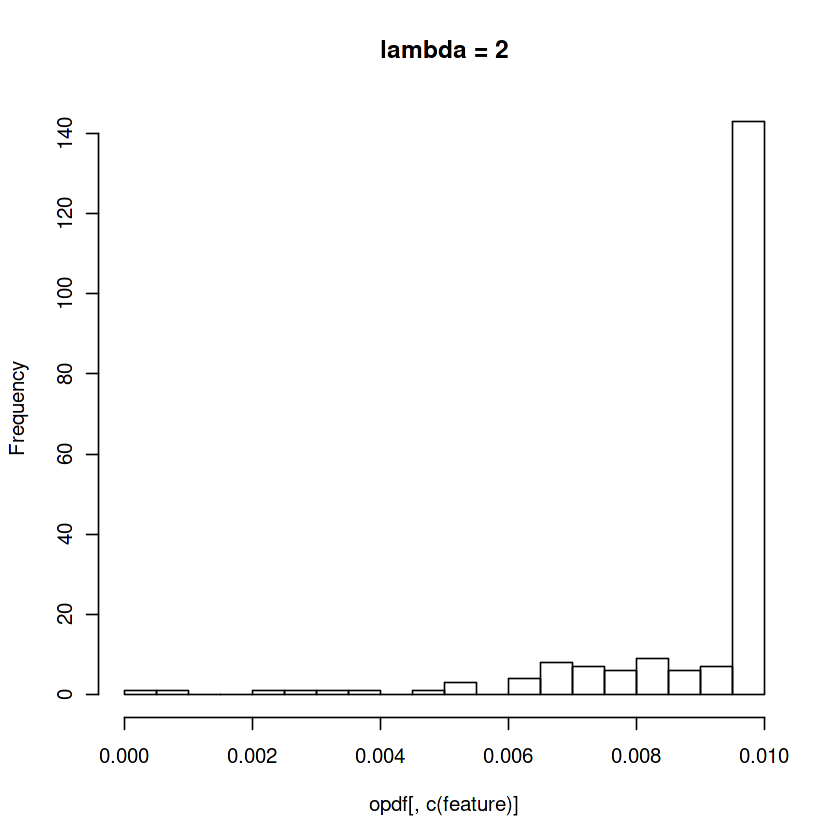

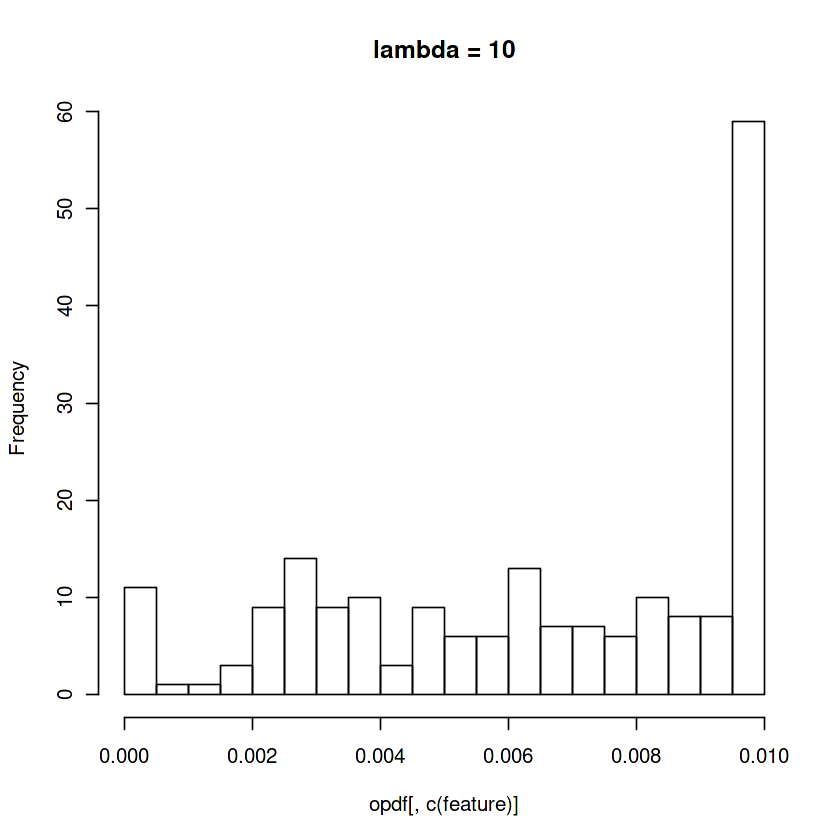

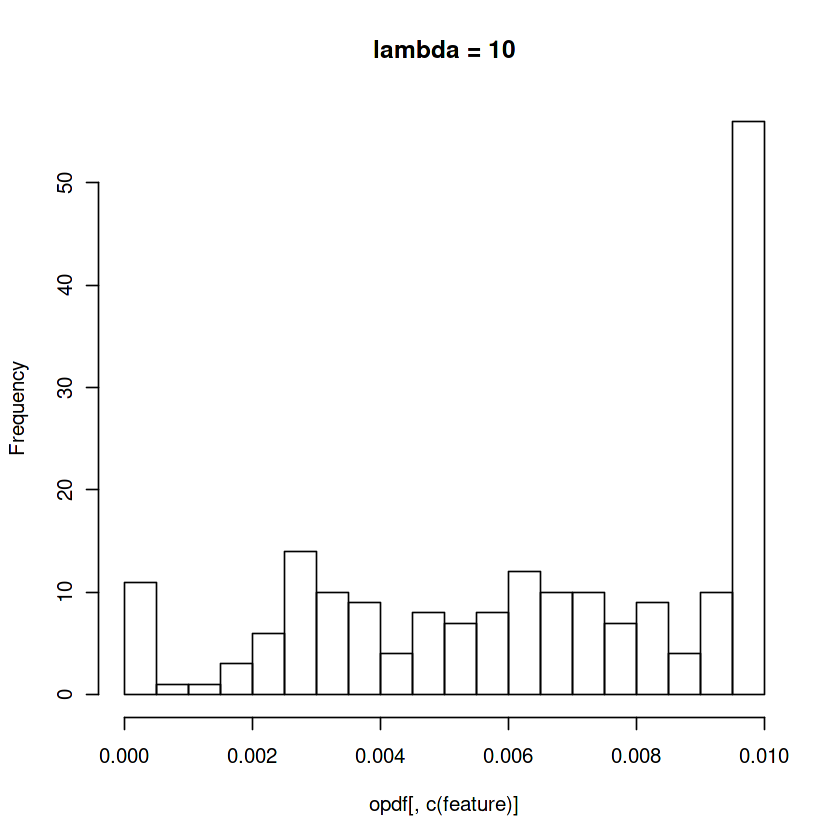

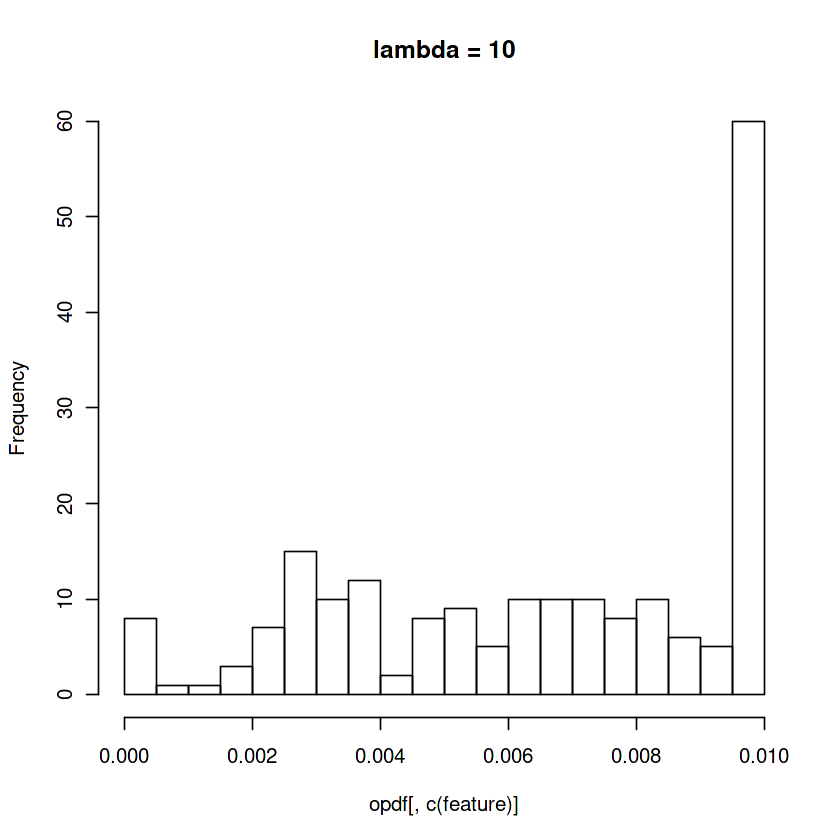

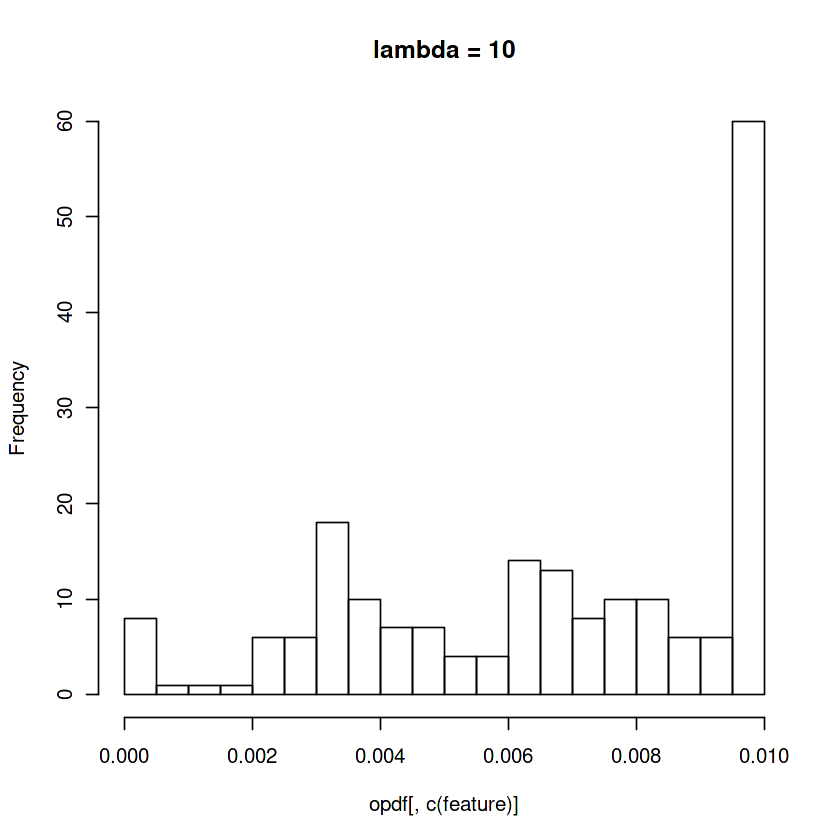

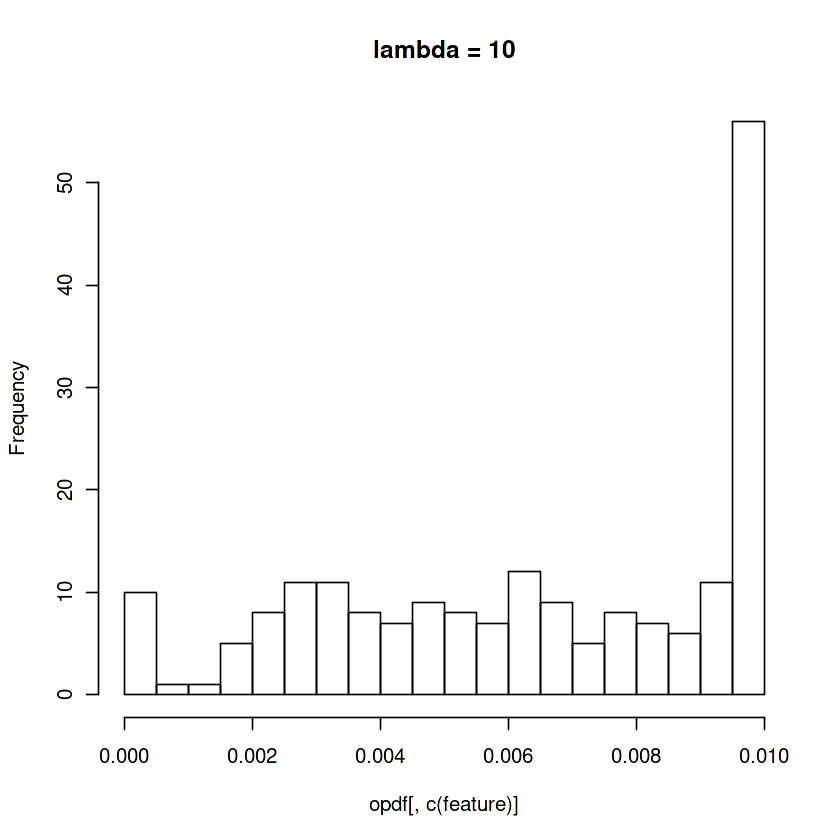

In [180]:
res = lapply(c("blood-transfusion-service-center", "kc1", "numerai28.6", "phoneme", "sylvine"), function(data) {
    compute_width_ci(data, c(0.5, 1, 2, 10), breaks = 20, "learning_rate")
})

In [181]:
res_mod = do.call(rbind, res)
res_mod = setDT(res_mod)
res_mod$md = as.numeric(res_mod$md)
res_mod$kld = as.numeric(res_mod$kld)

In [182]:
res_mod_sum = res_mod[, .("mean_md" = mean(md), "mean_kld" = mean(kld)), by = c("lambda", "dataset")]

In [183]:
res_mod_sum

lambda dataset                          mean_md     mean_kld 
1  0.5    blood-transfusion-service-center 0.137354571 0.7417508
2  1      blood-transfusion-service-center 0.139598795 0.8548044
3  2      blood-transfusion-service-center 0.123801340 0.8326584
4  10     blood-transfusion-service-center 0.143868995 0.4465260
5  0.5    kc1                              0.007167882 0.9298810
6  1      kc1                              0.006620579 0.4596391
7  2      kc1                              0.005359269 0.3175013
8  10     kc1                              0.005853094 0.1494112
9  0.5    numerai28.6                      0.217615985 0.5705312
10 1      numerai28.6                      0.217825185 0.3259442
11 2      numerai28.6                      0.217484728 0.3284676
12 10     numerai28.6                      0.217728866 0.4739491
13 0.5    phoneme                          0.013444011 1.1230664
14 1      phoneme                          0.012643574 0.8392815
15 2      phoneme                          0.012426235 0.8084575
16 10     phoneme                          0.013038209 0.3368229
17 0.5    sylvine                          0.103921755 1.0600151
18 1      sylvine                          0.108899547 0.8340120
19 2      sylvine                          0.106763358 0.9360205
20 10     sylvine                          0.107488716 0.3825536

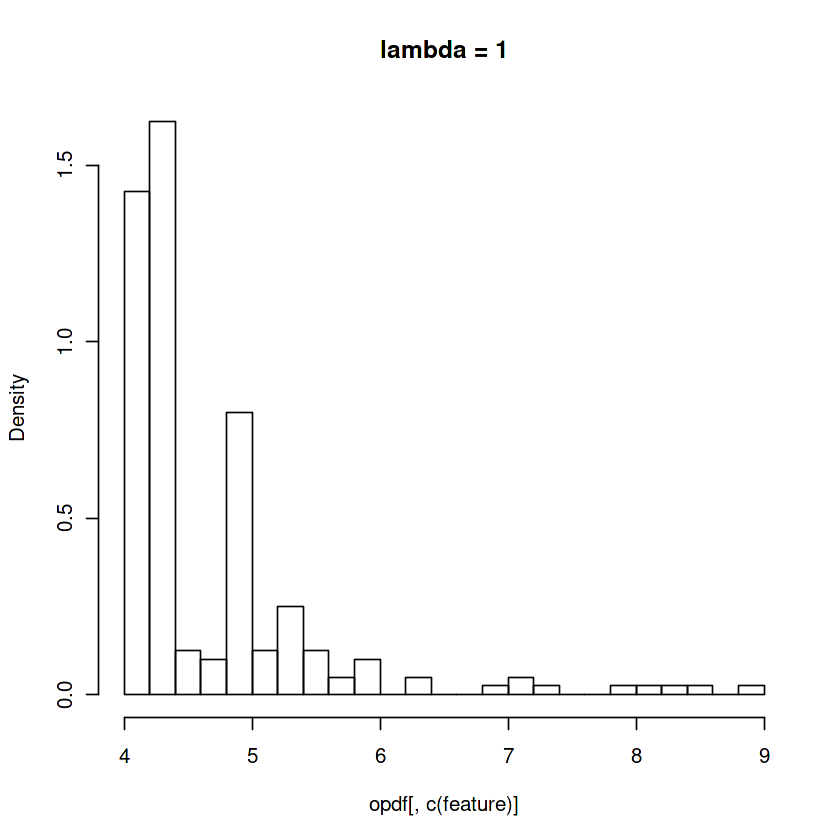

In [157]:
i = 1
breaks = 20
run = runs$result[[i]]
opdf = as.data.frame(run$opt.path)

model = run$models
model = model[[length(model)]] 

pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

md = mean(abs(me$mean - pme$mean))
neg_loglik = sum(unlist(lapply(seq_row(pme), function(i) {
    dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = FALSE) 
})))
mean_sd = mean(pme$sd)
sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

# compute the kullback-leibler distance 
myhist = hist(opdf[, c(feature)], breaks = breaks, main = paste0("lambda = ", lambda), freq = FALSE)
P = myhist$density
Q = rep(1 / length(myhist$density), length(myhist$density))


In [159]:
P = P * 1 / 5

In [161]:
sum(P)

[1] 1

In [154]:
Q = rep(1 / length(myhist$density), length(myhist$density))
Q

[1] 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
[16] 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04

In [168]:
bla = Q / P
idx = is.finite(Q / P)
els = Q * log(Q / P)
sum(els[is.finite(els)])

[1] 0.6337314

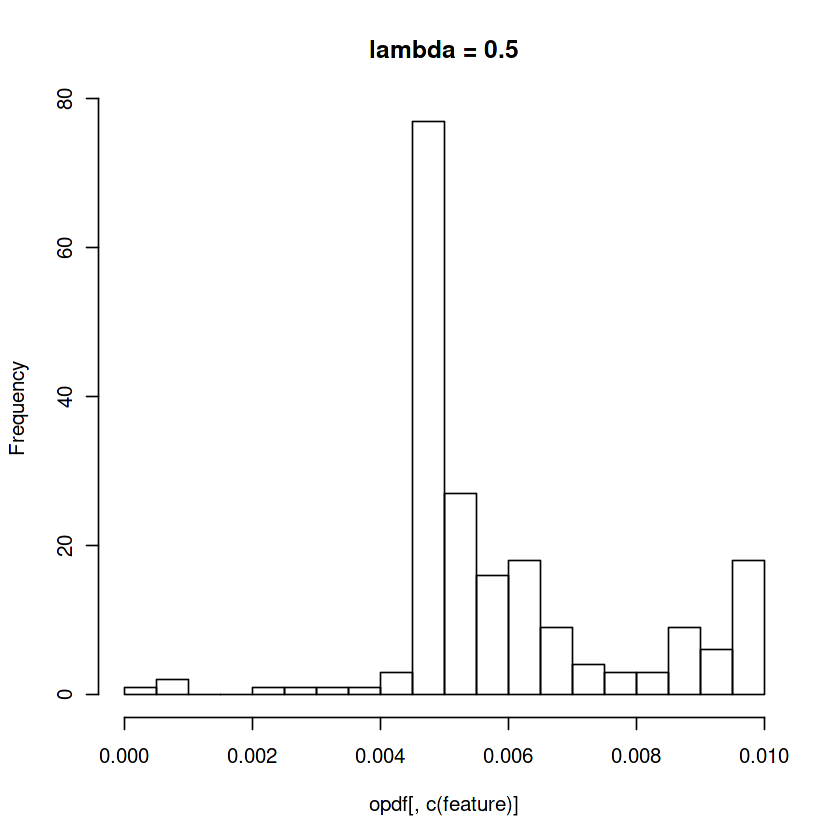

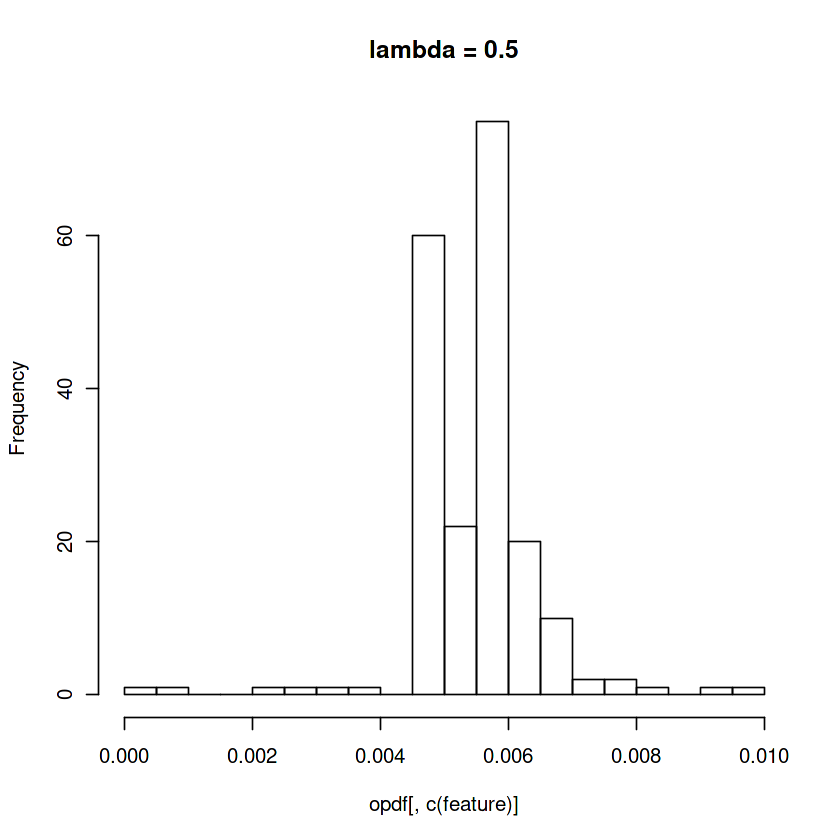

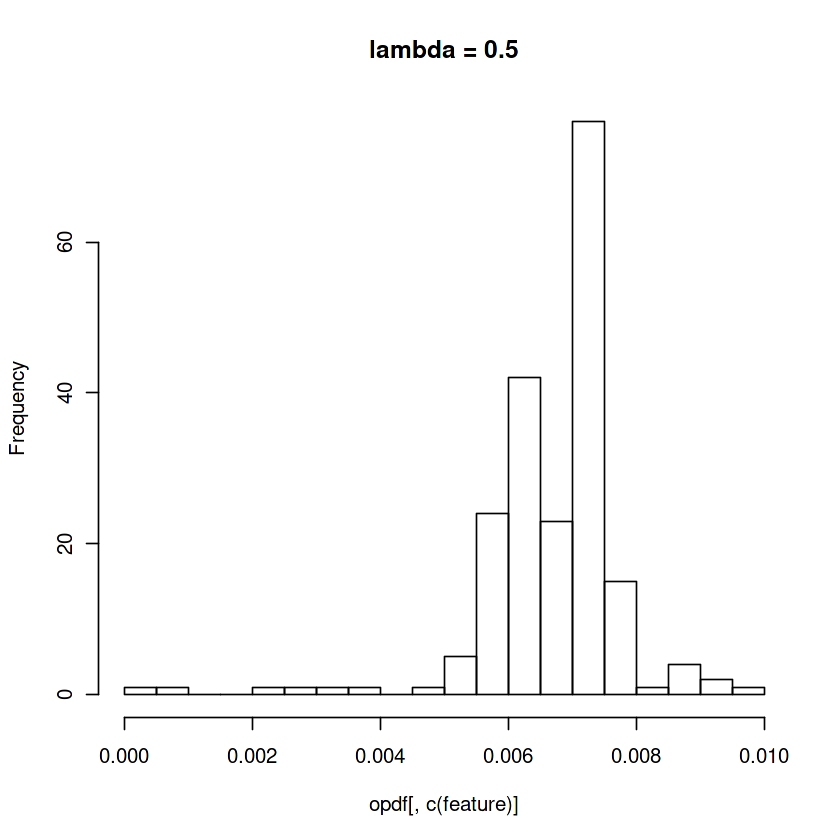

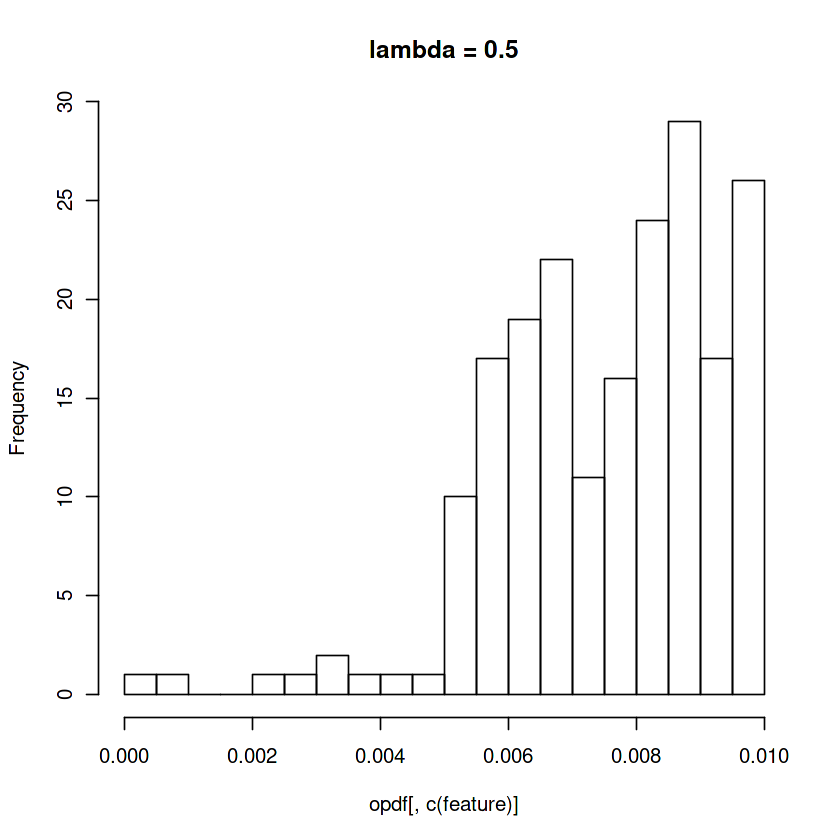

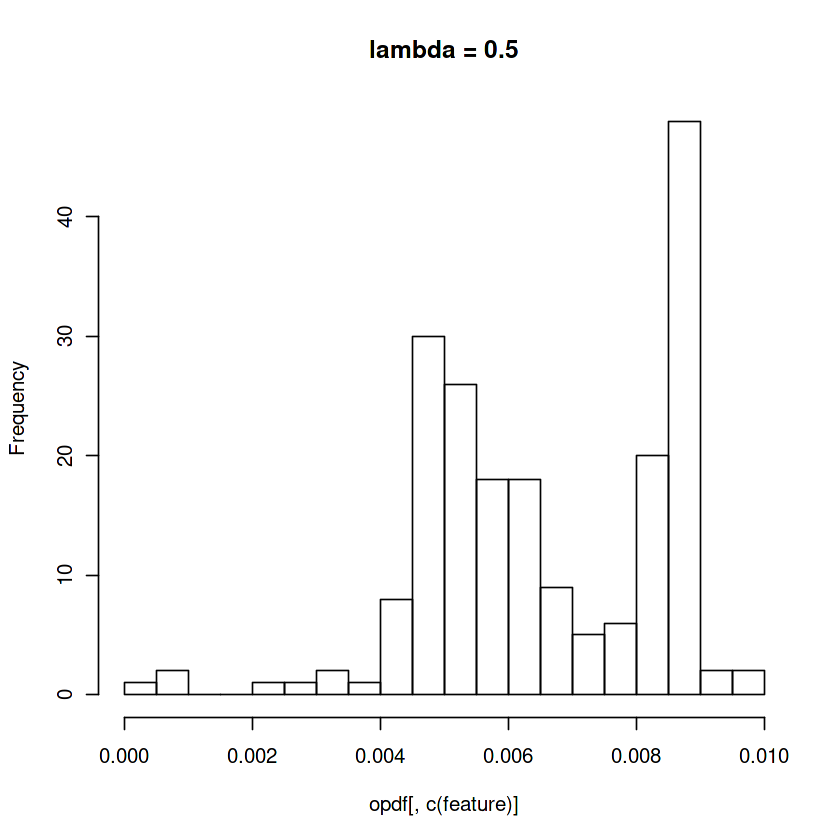

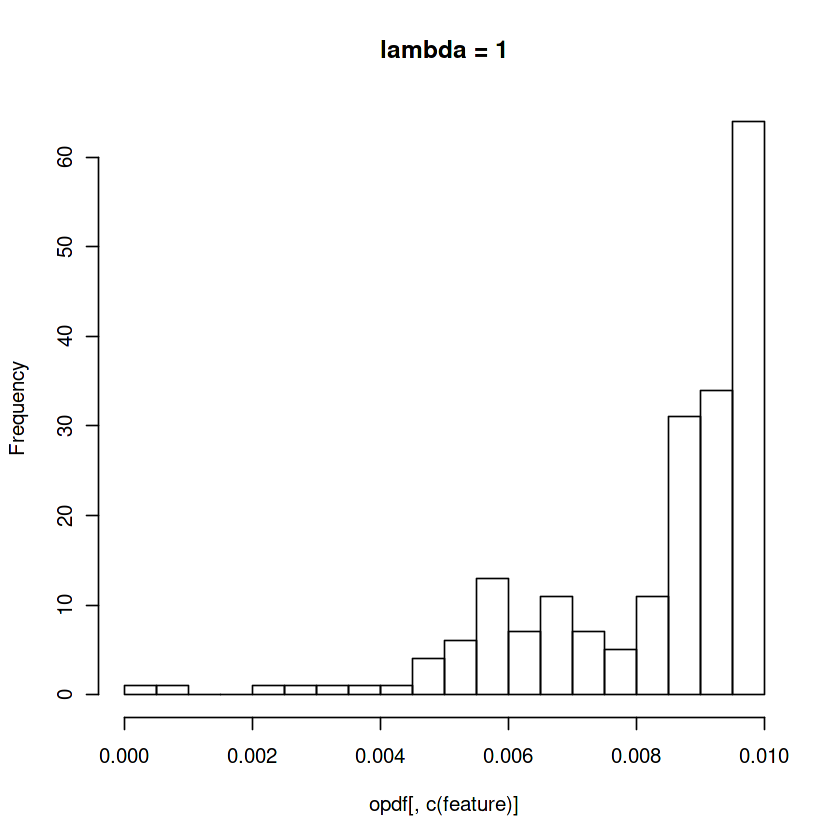

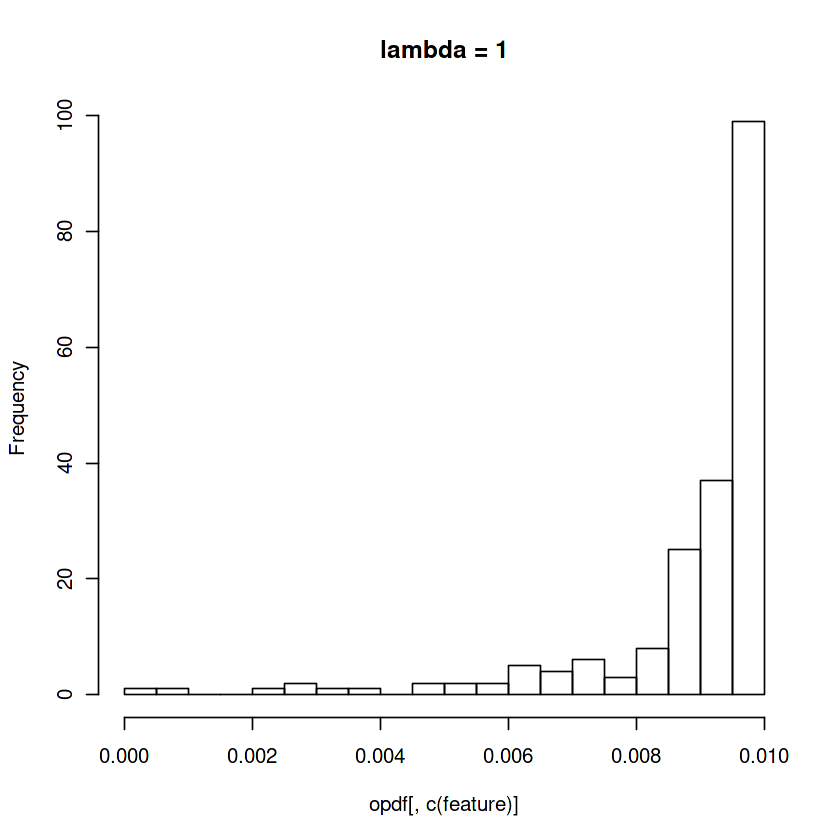

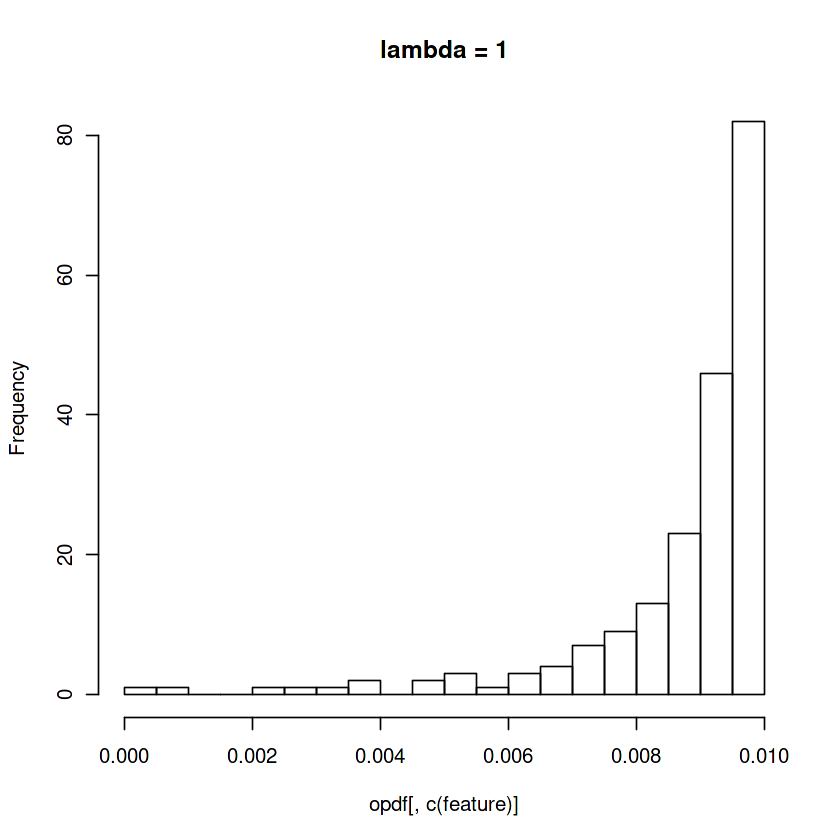

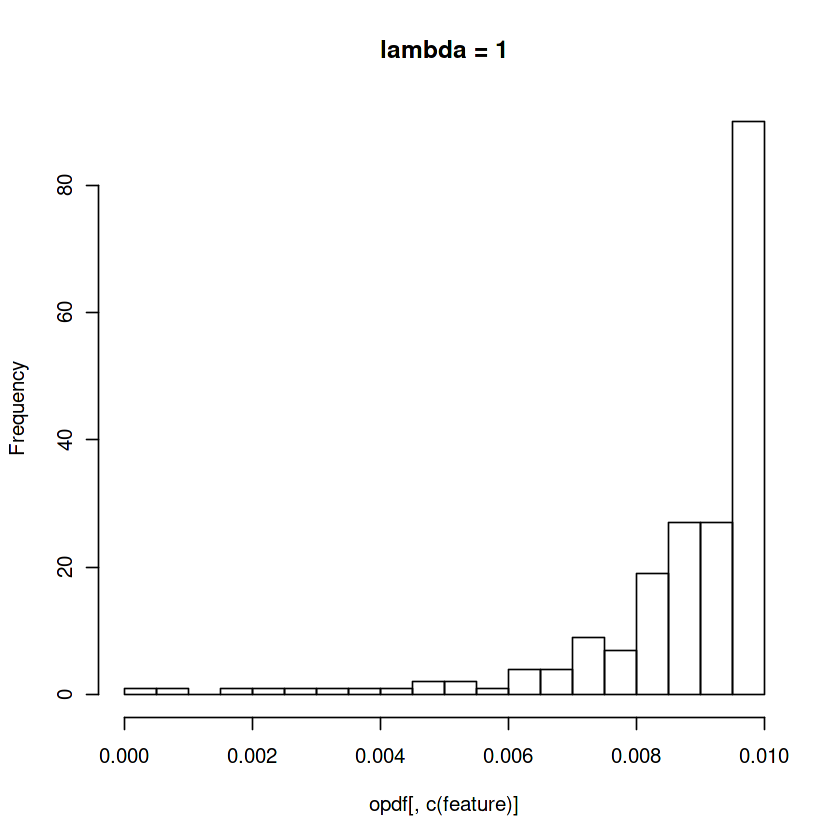

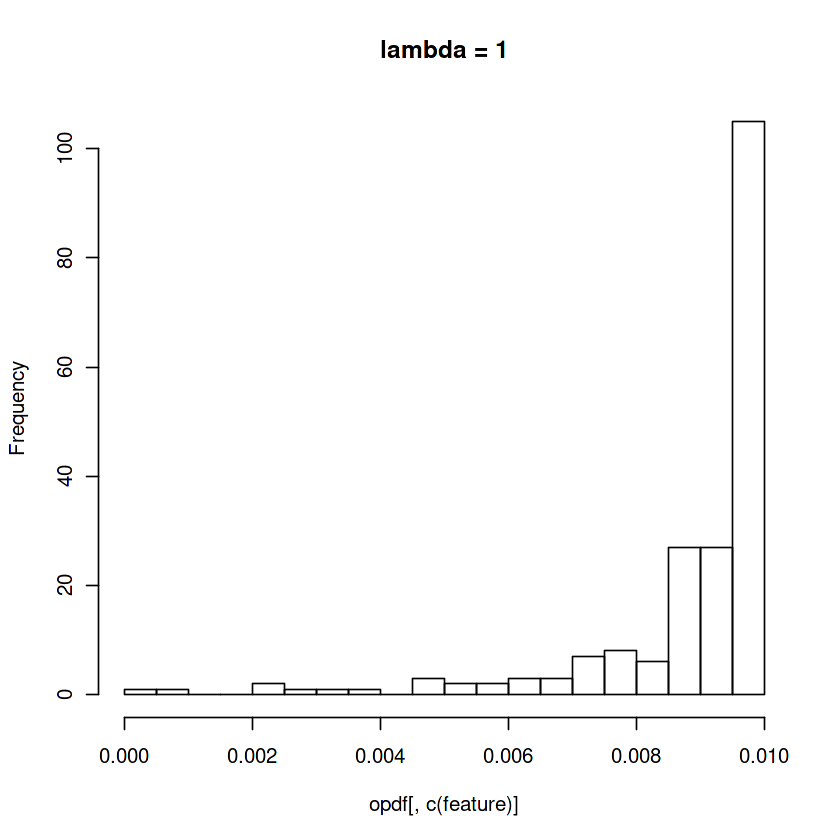

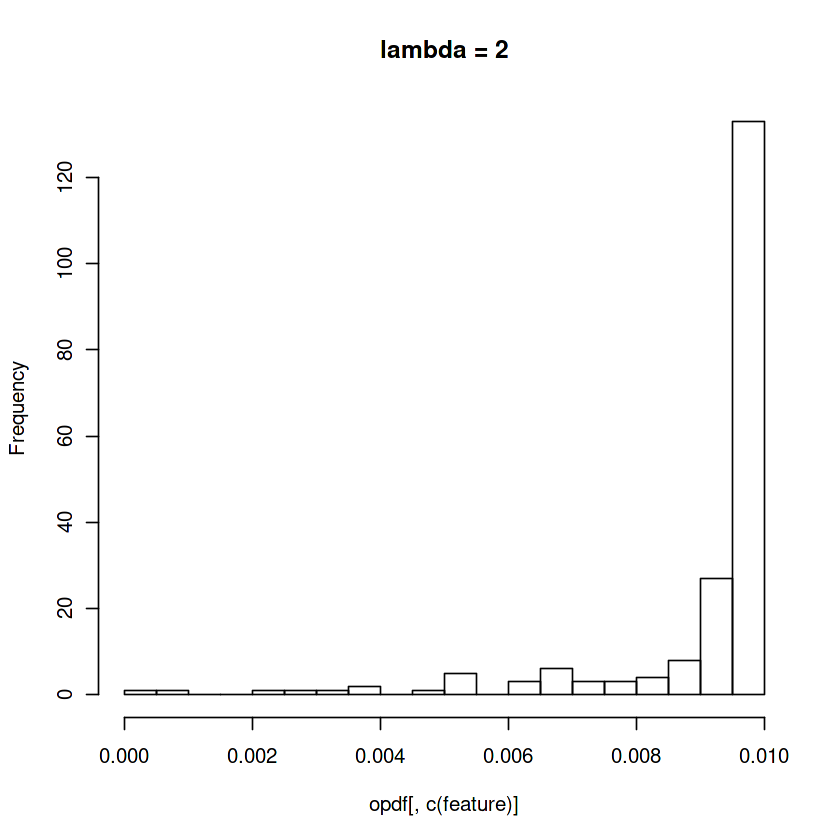

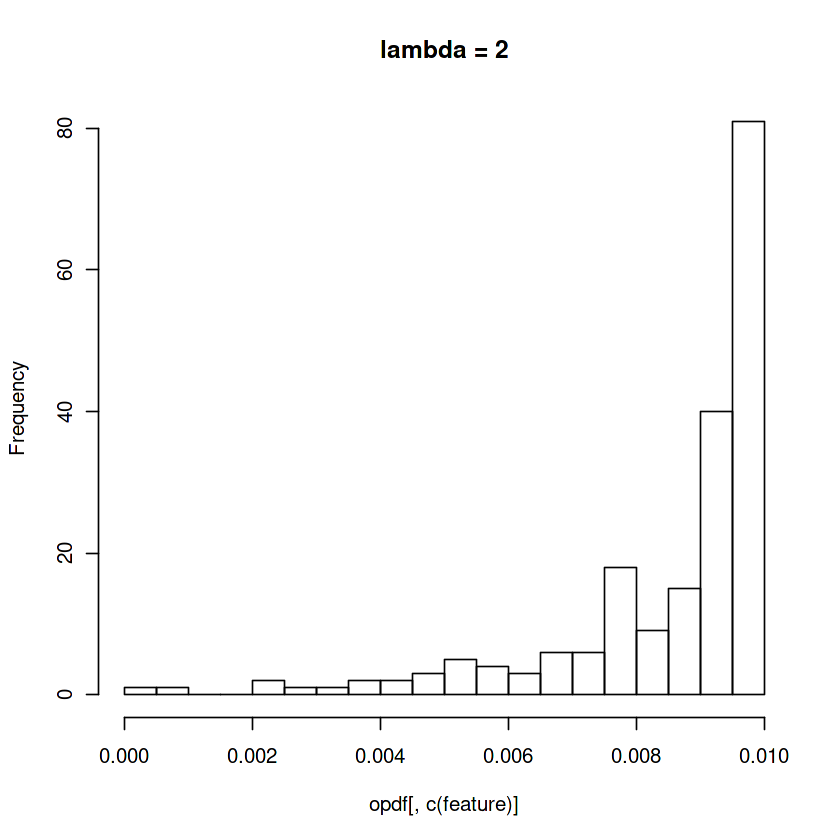

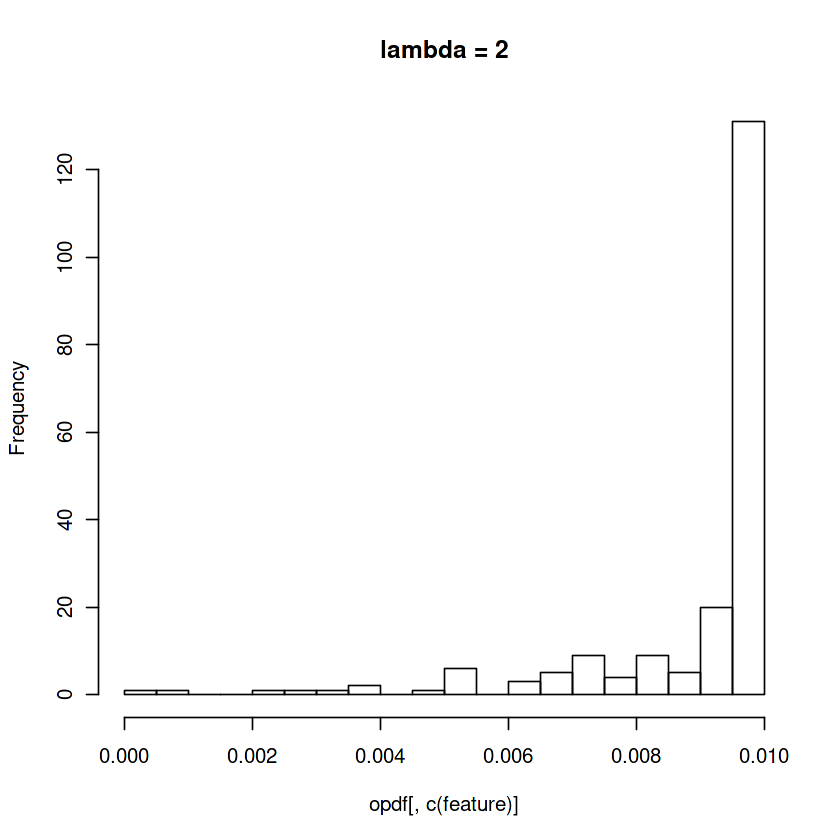

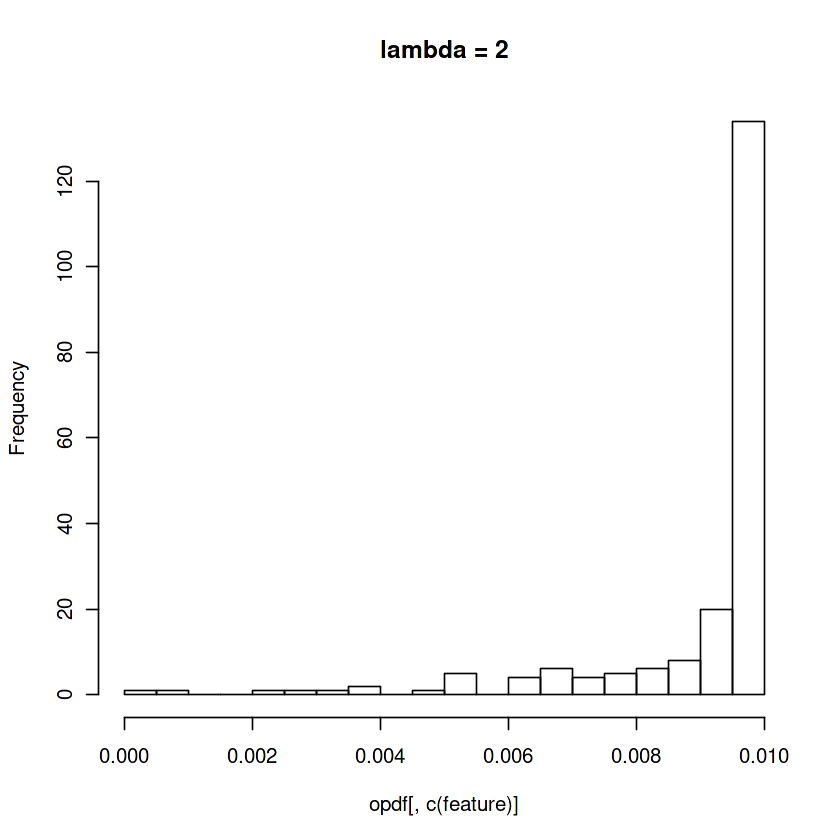

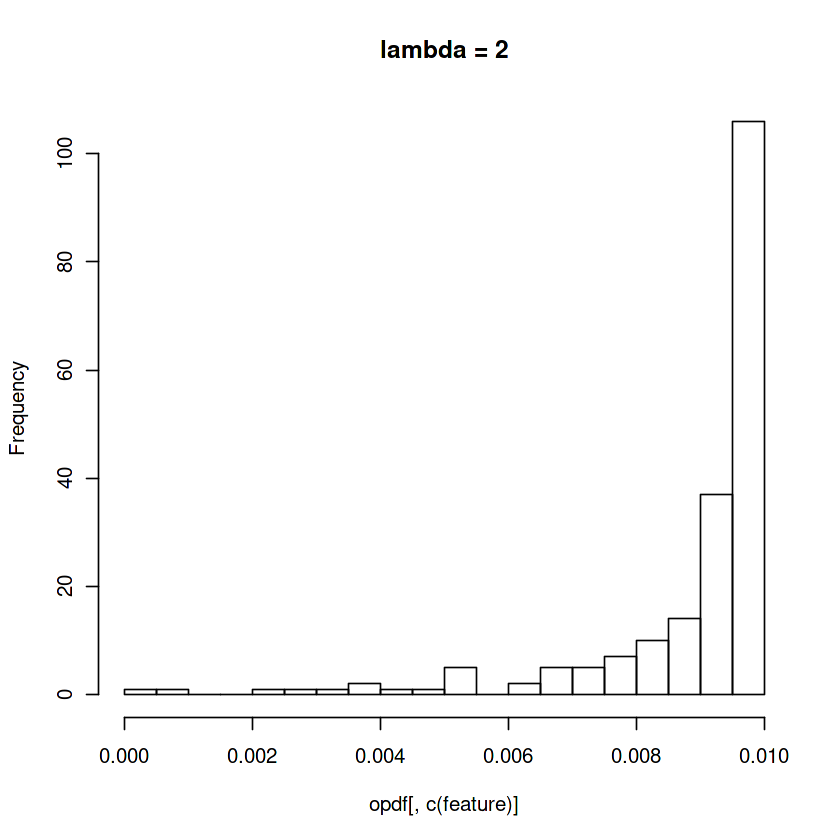

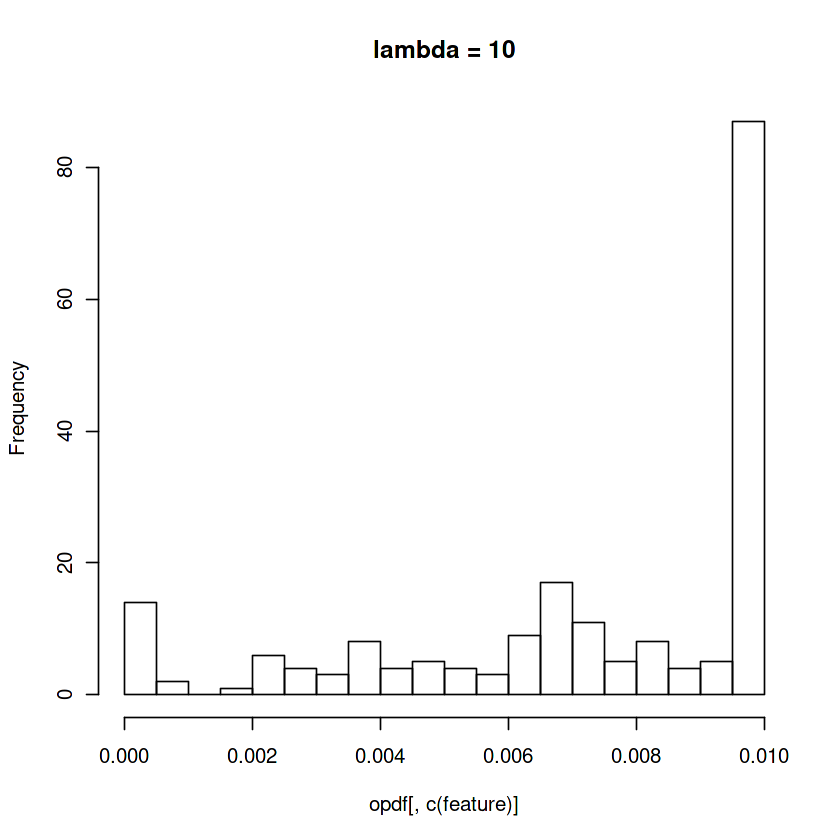

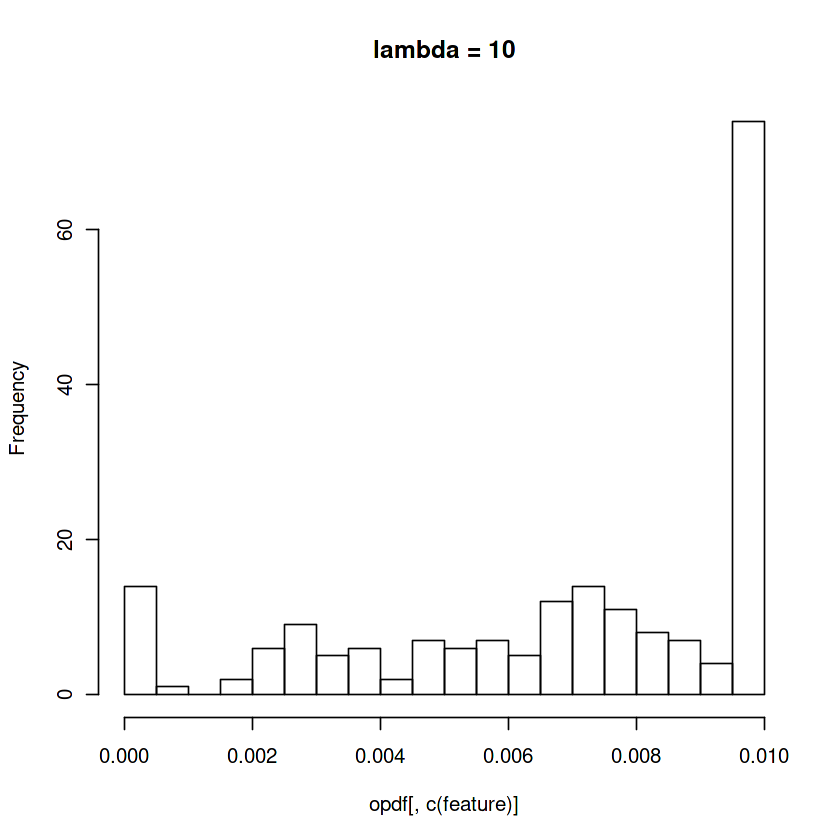

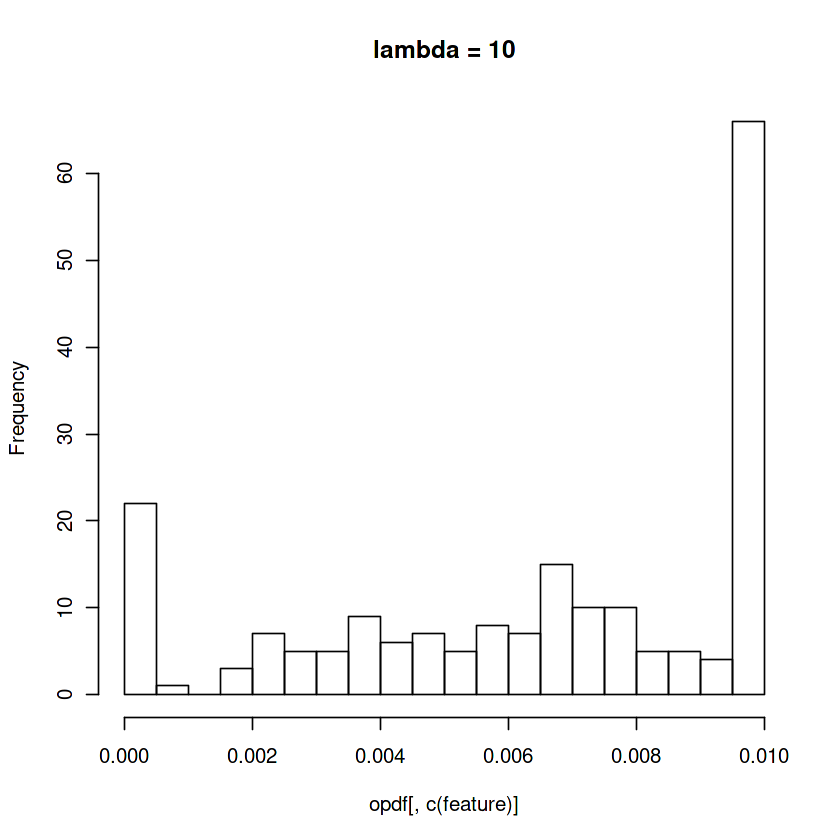

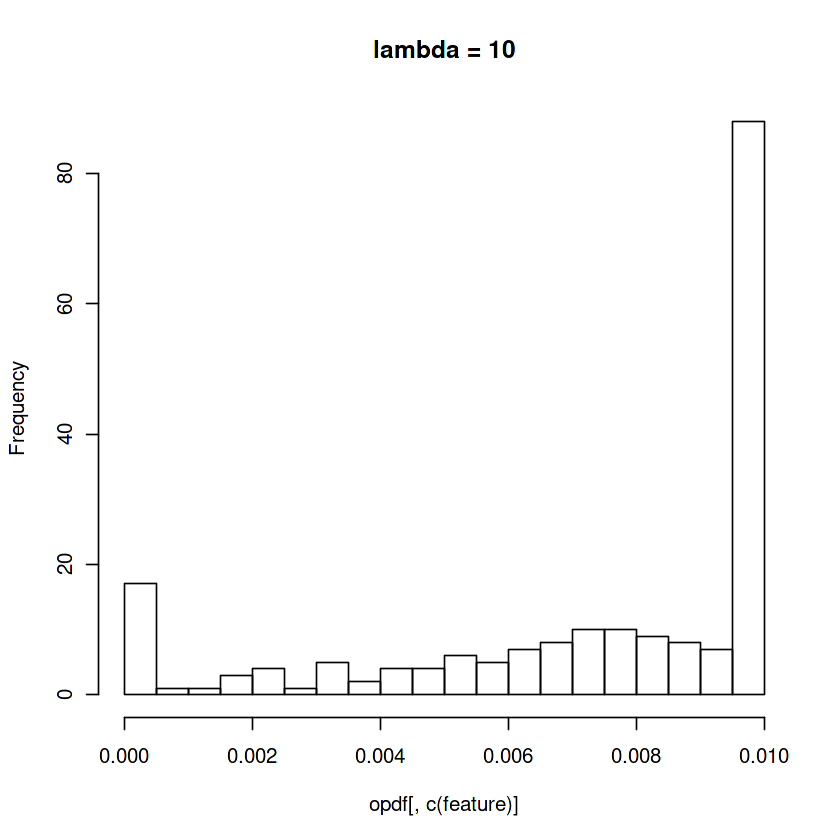

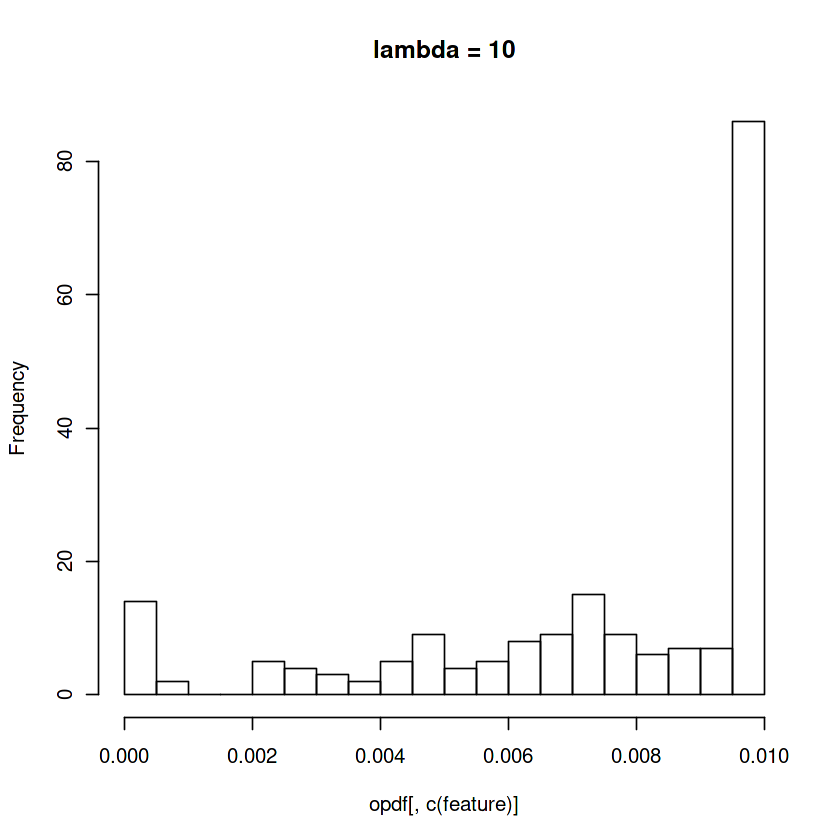

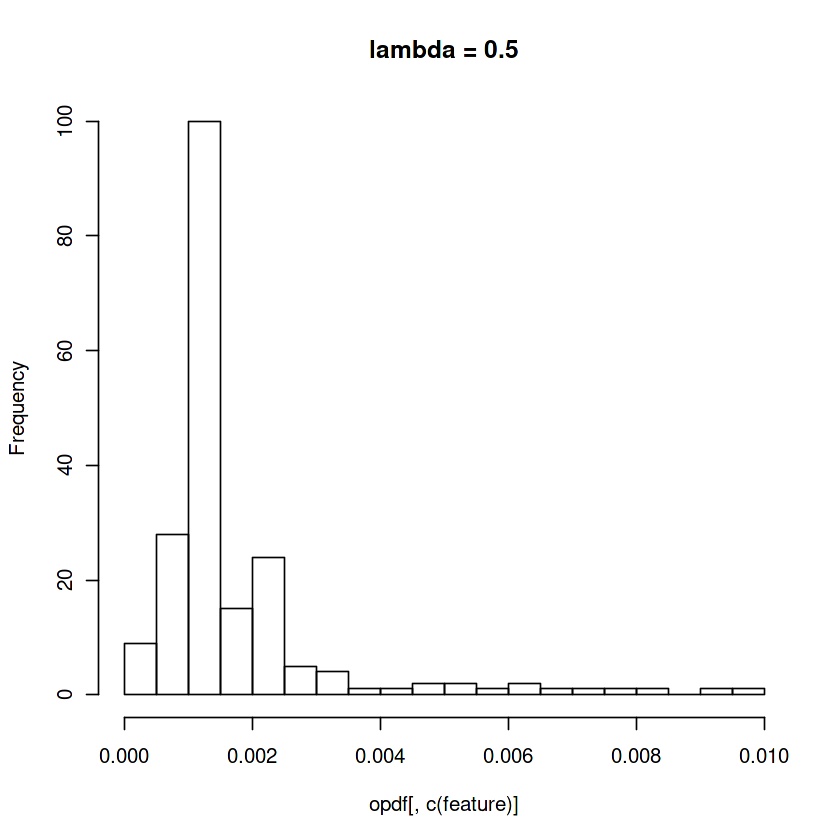

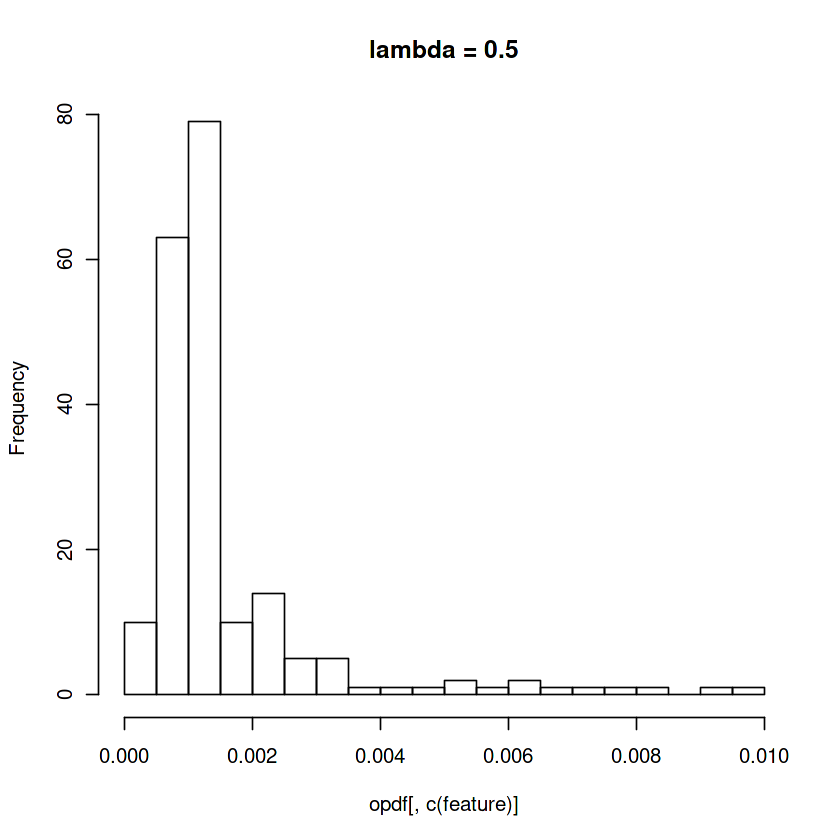

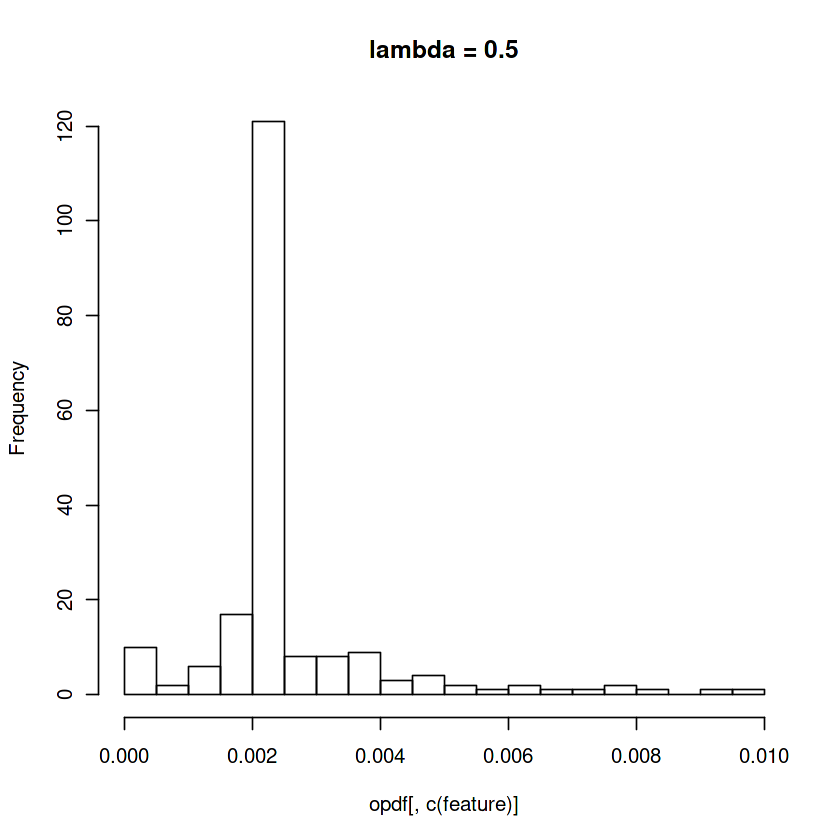

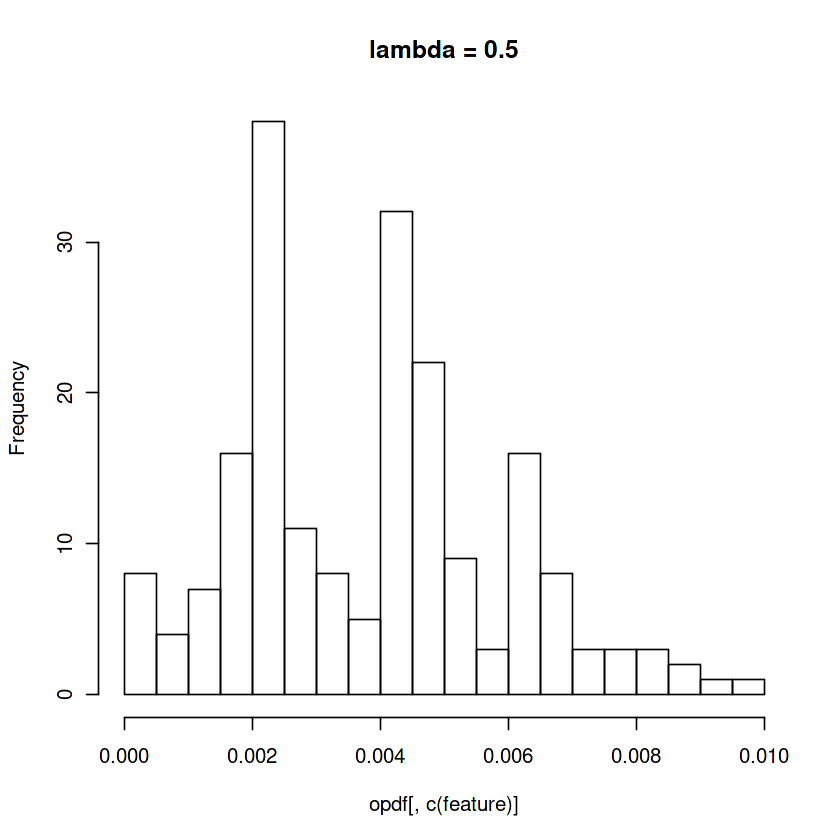

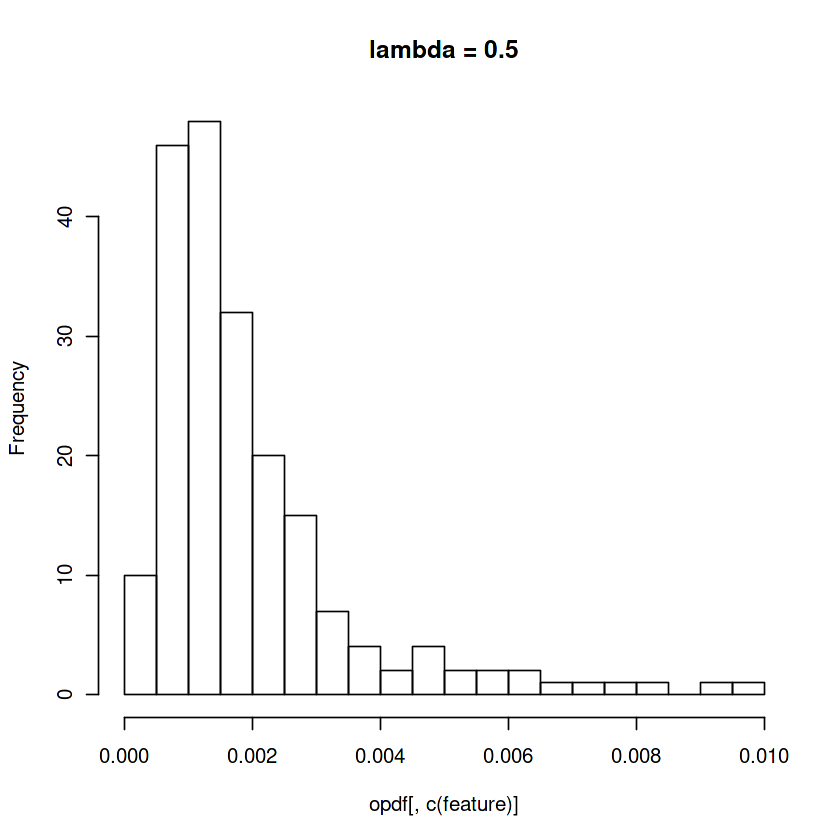

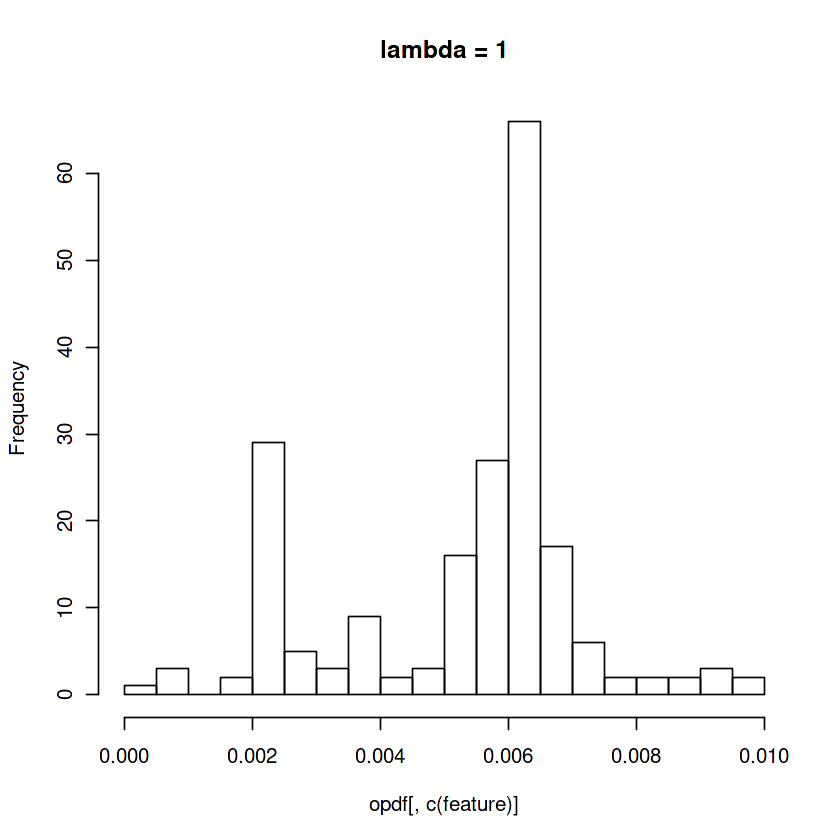

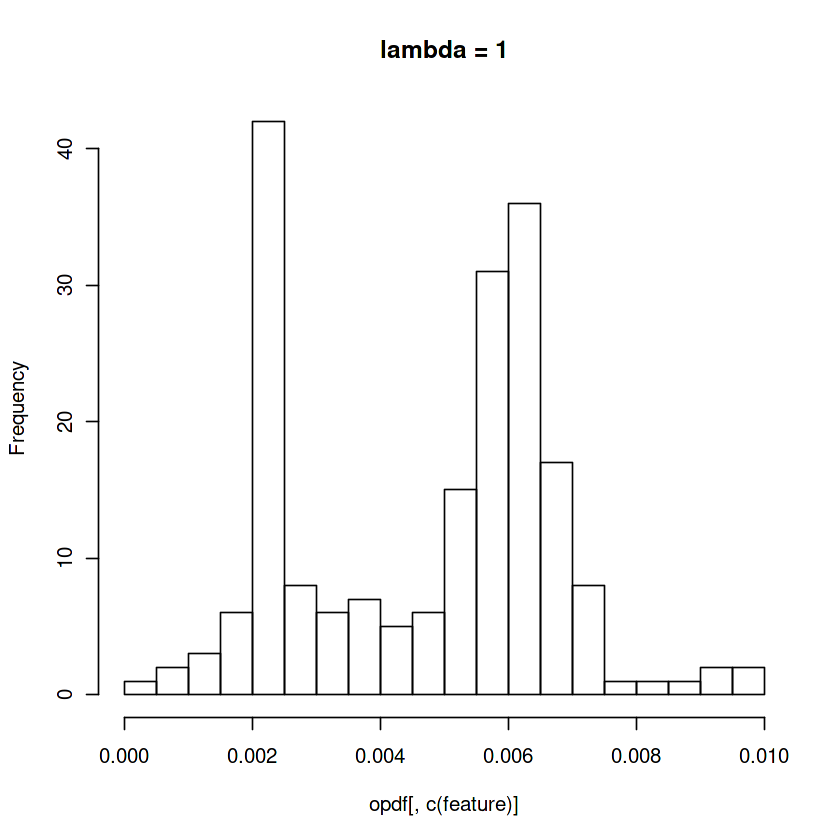

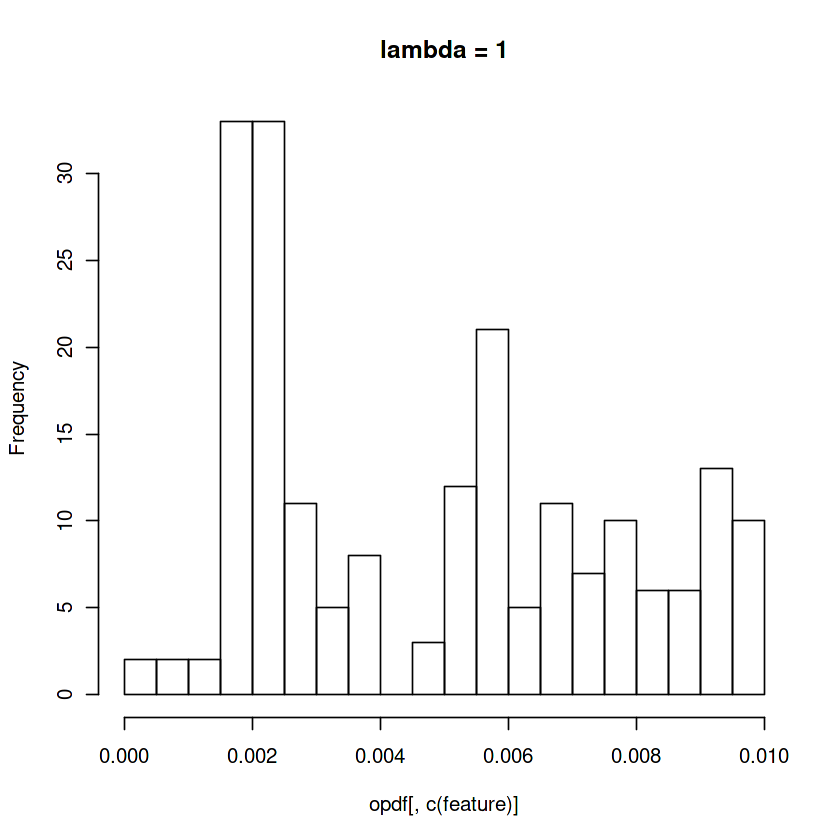

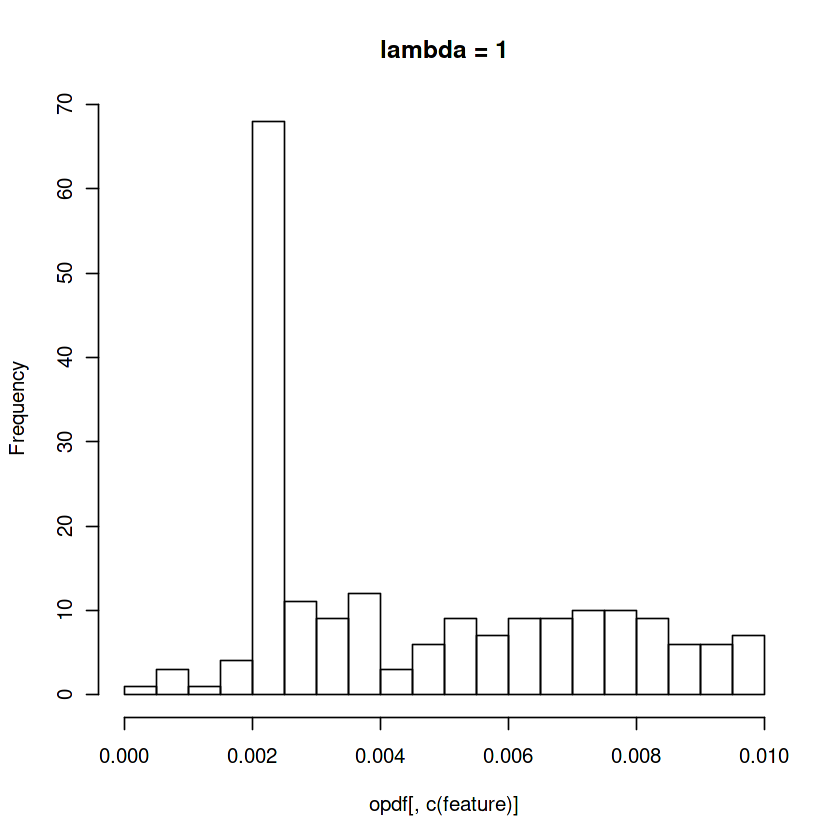

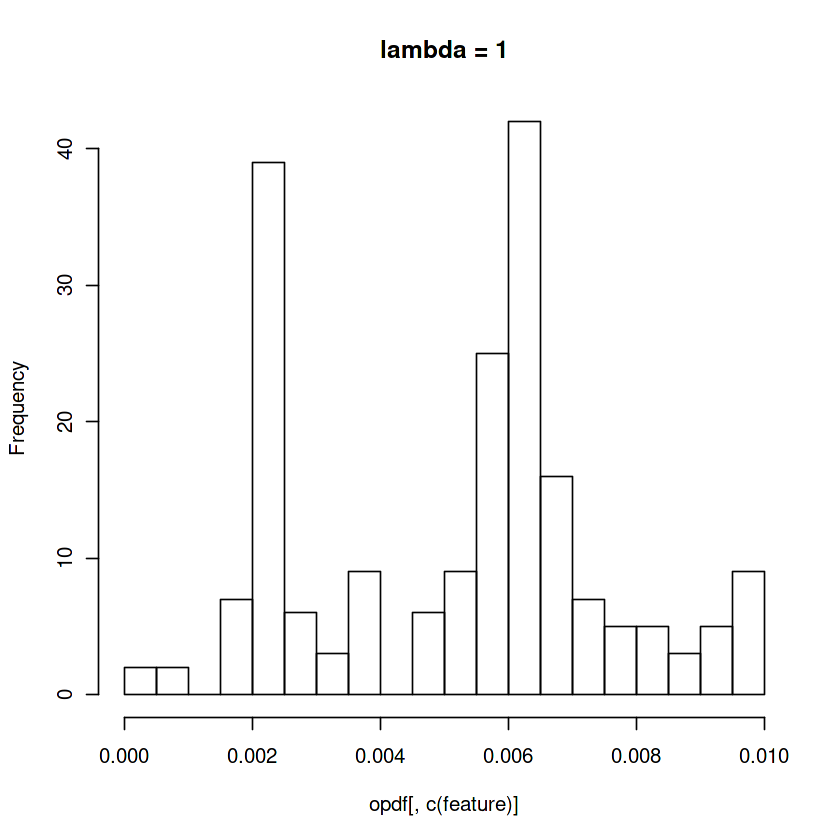

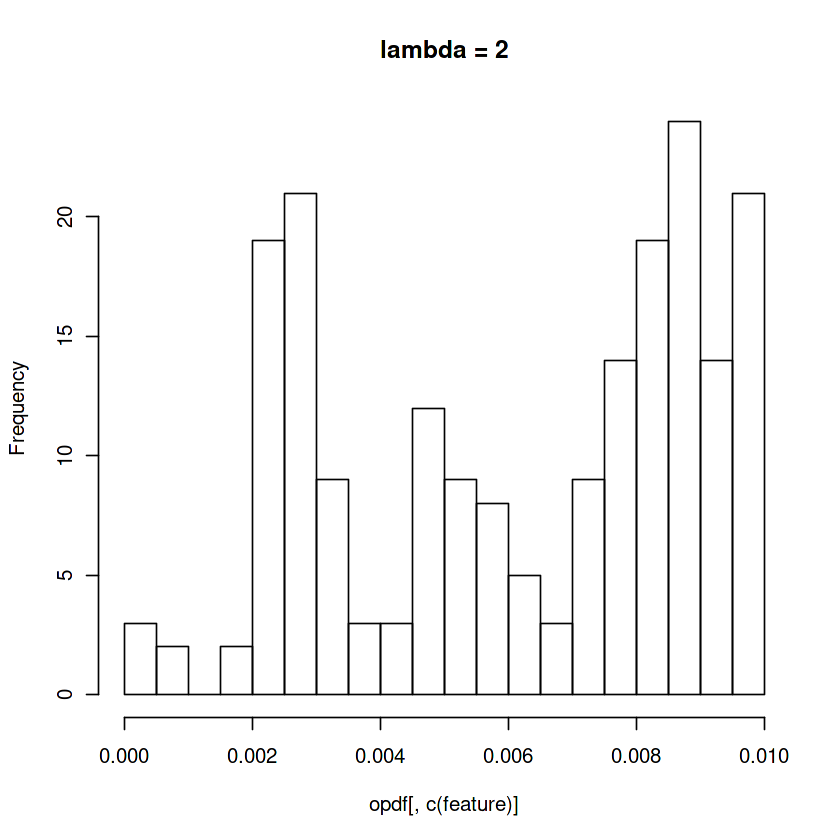

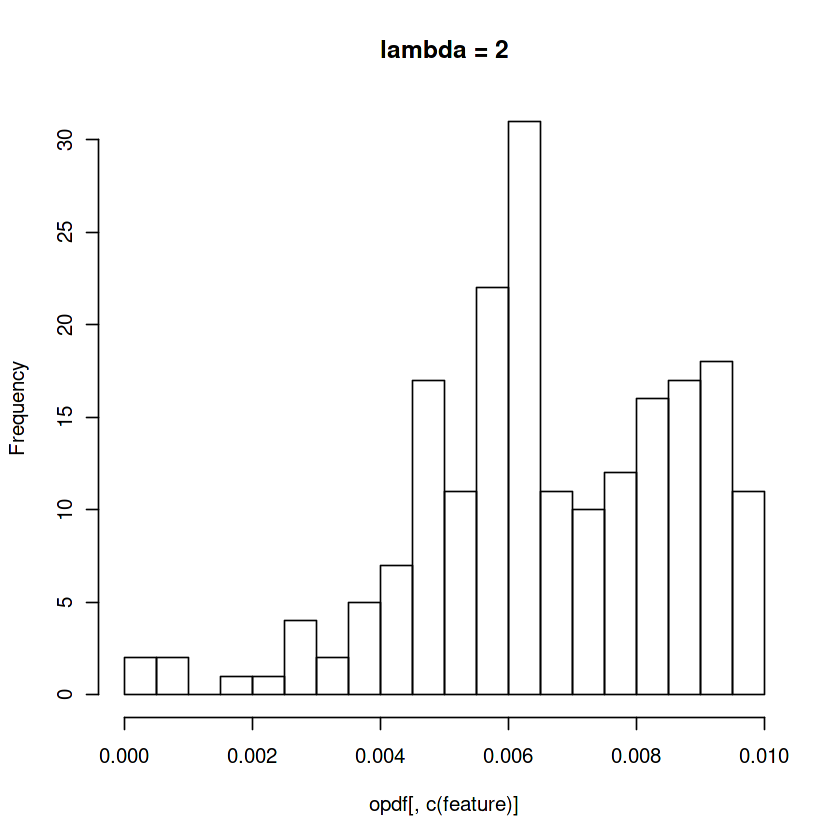

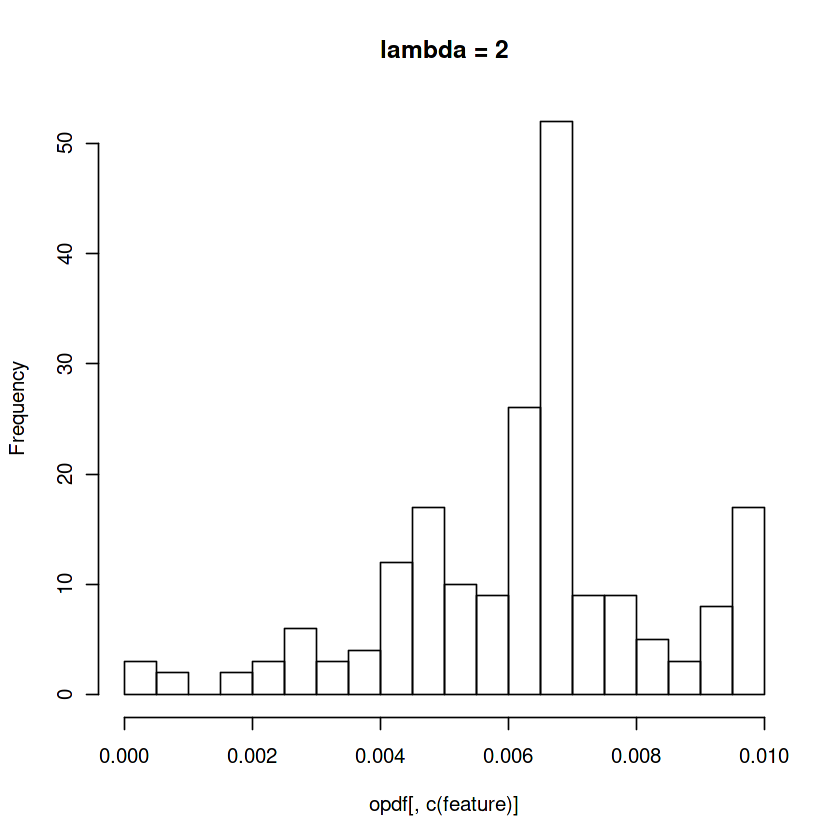

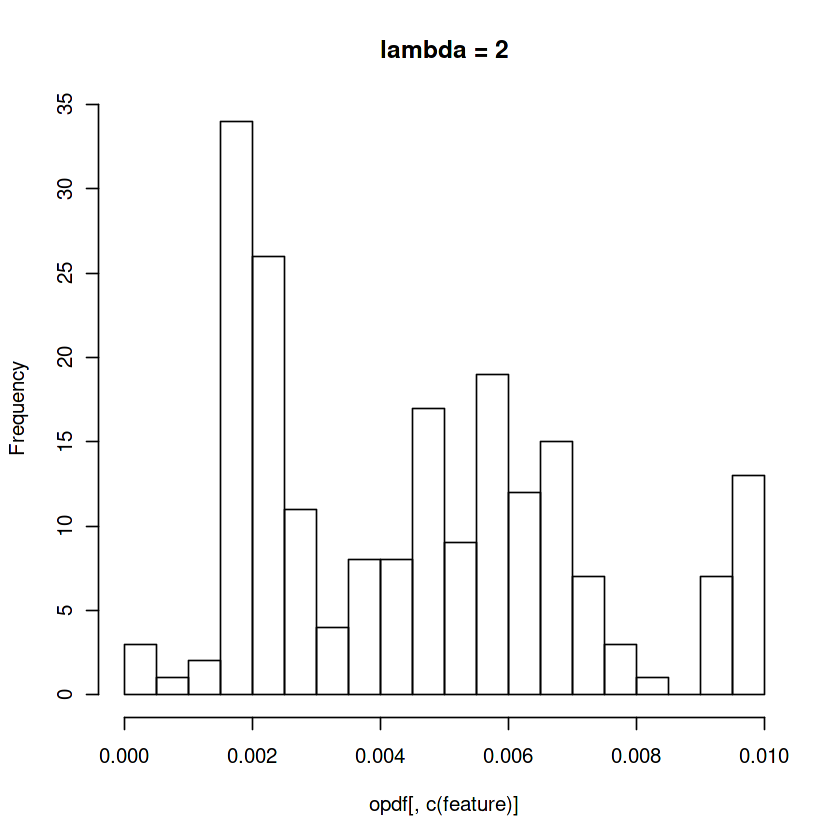

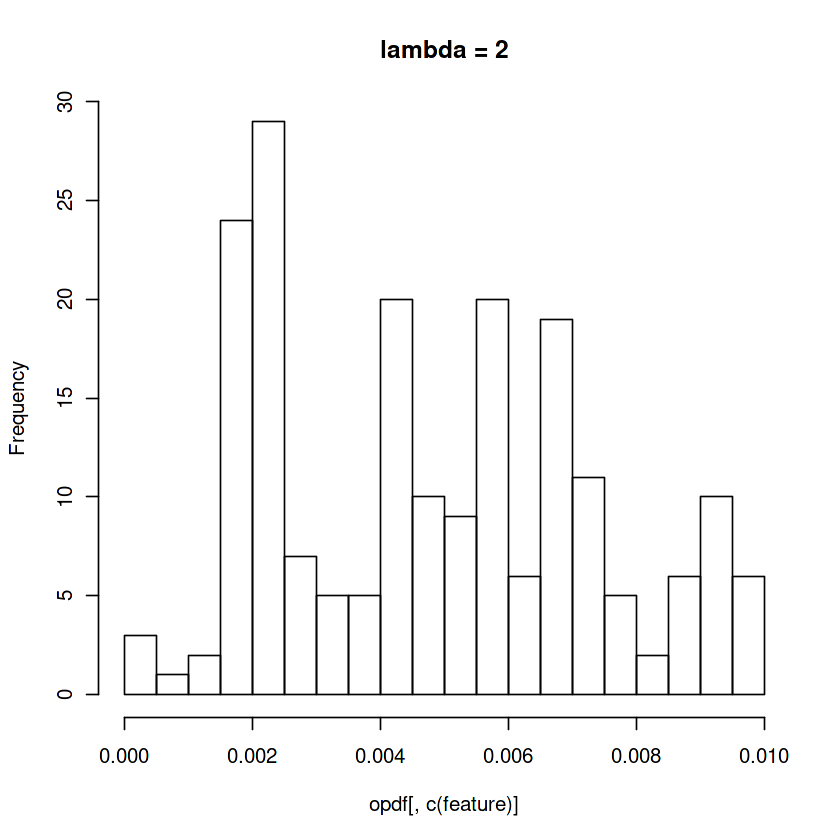

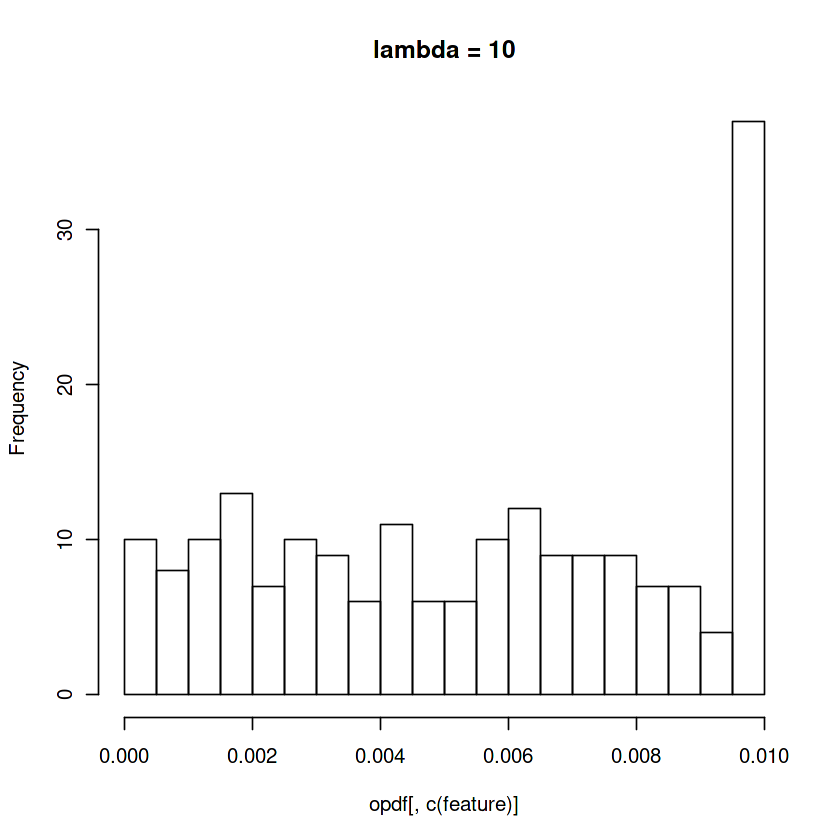

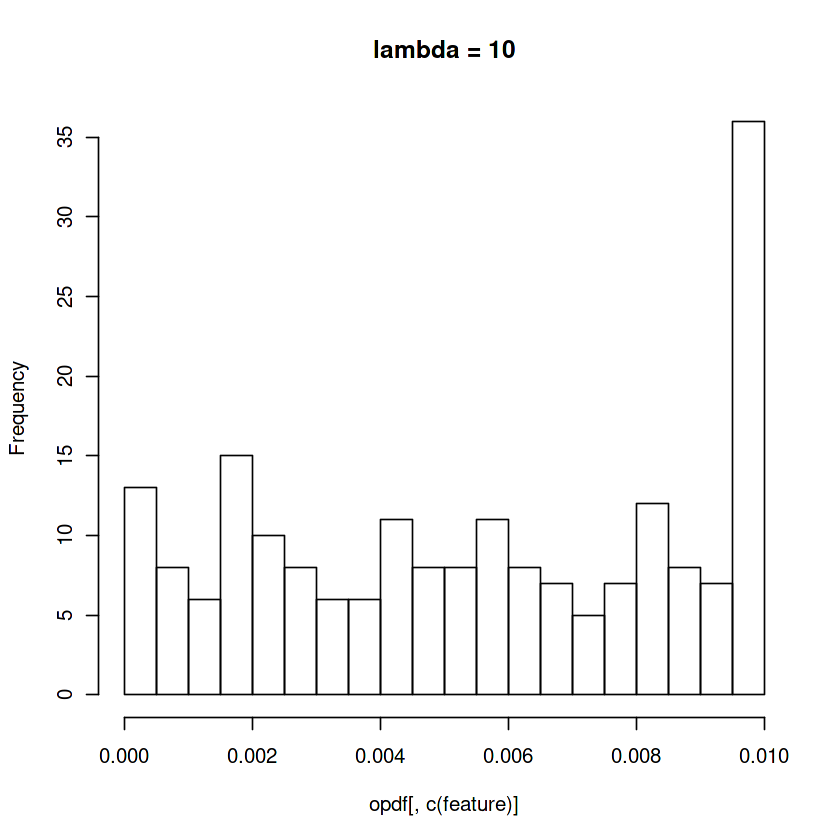

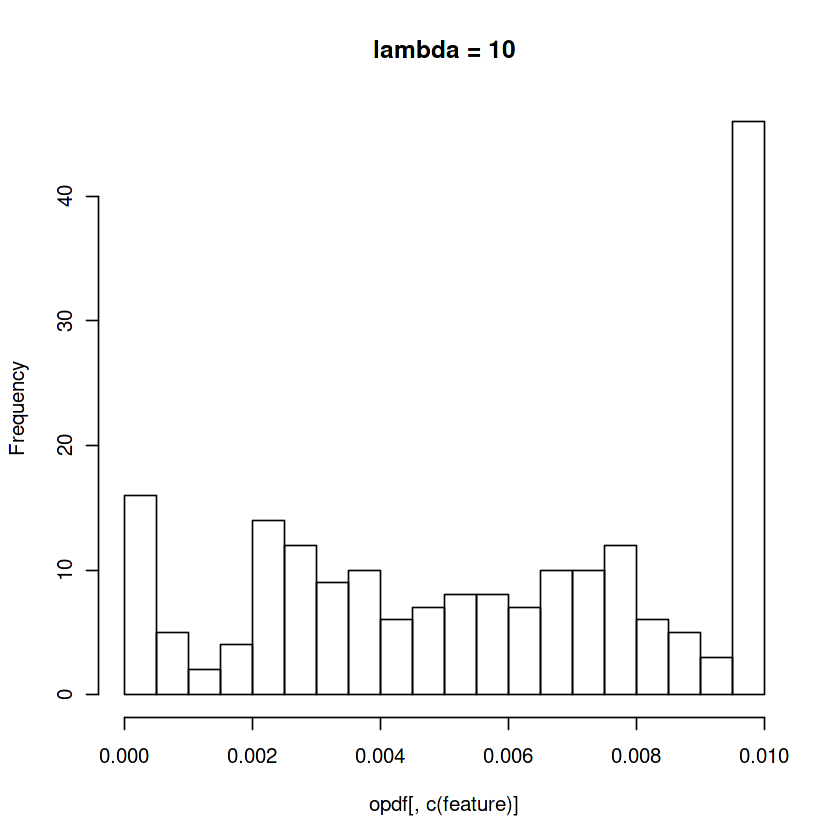

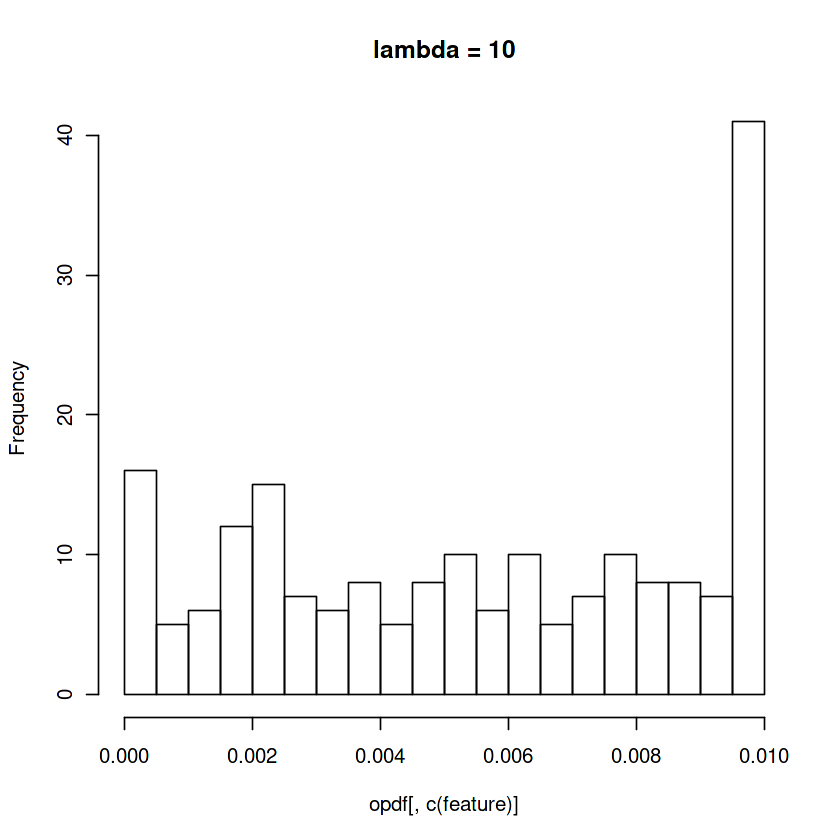

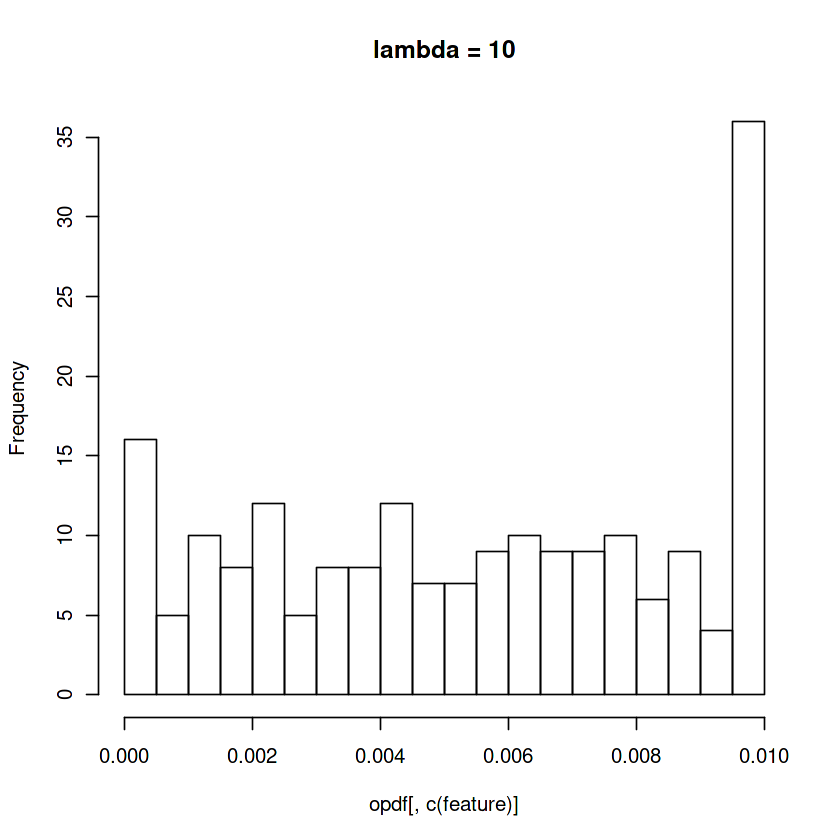

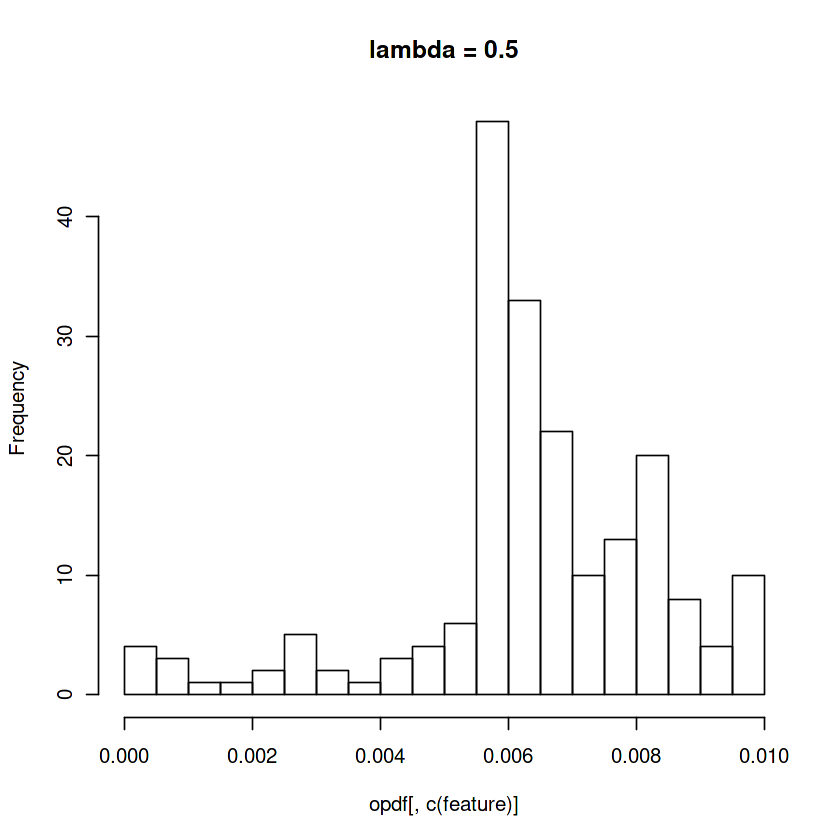

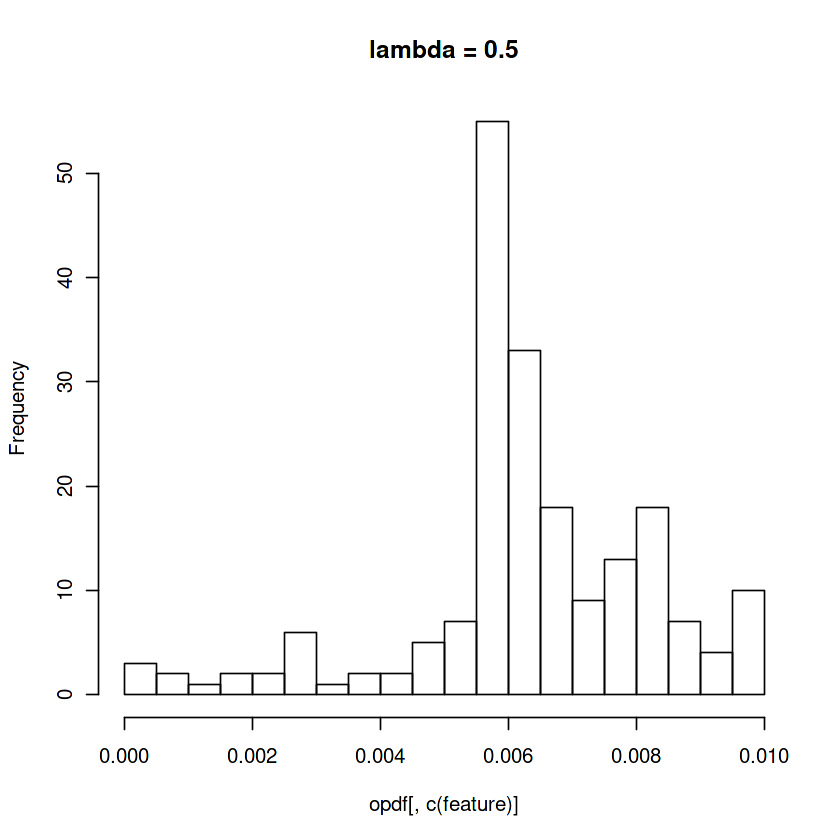

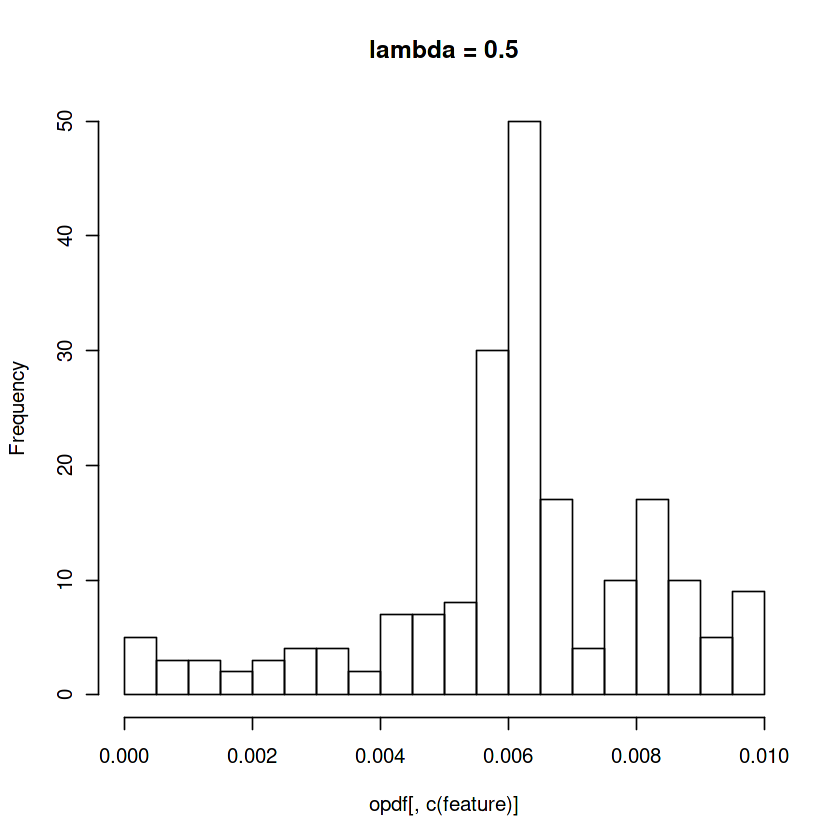

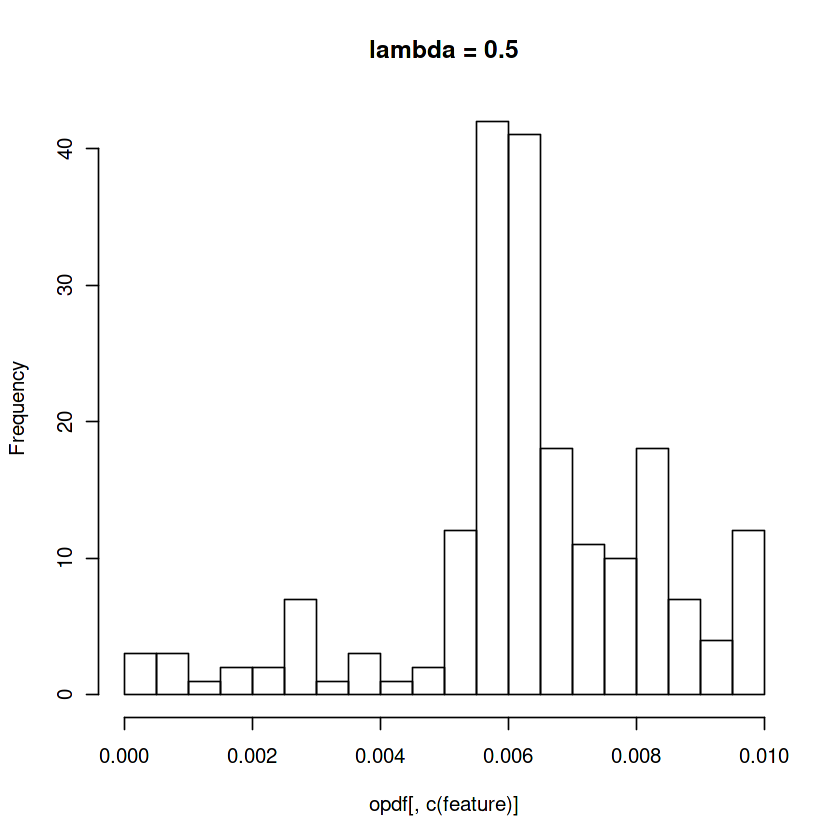

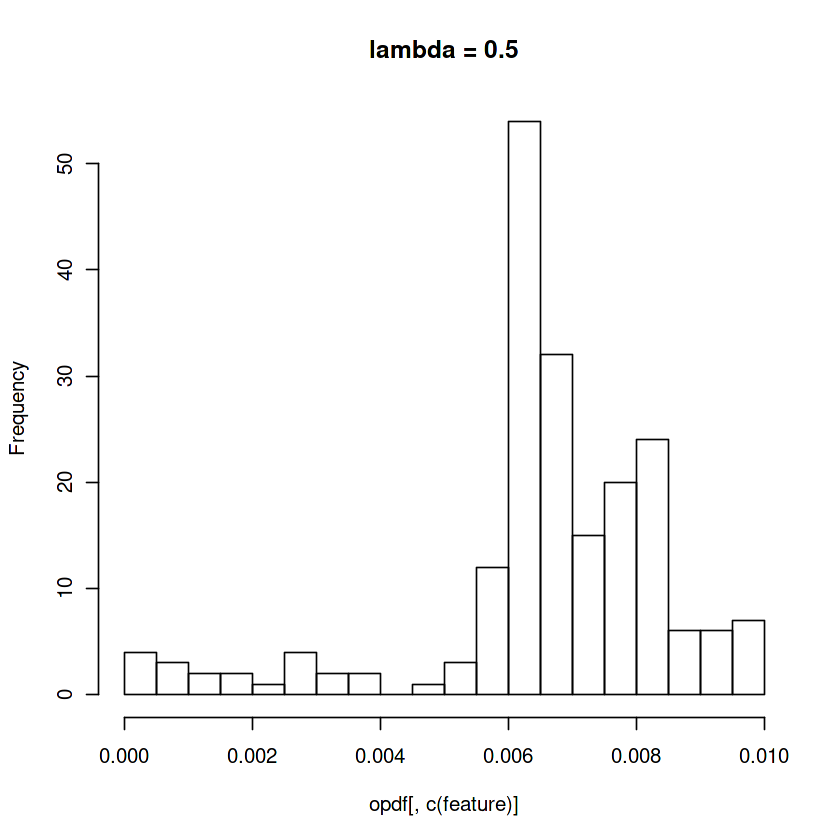

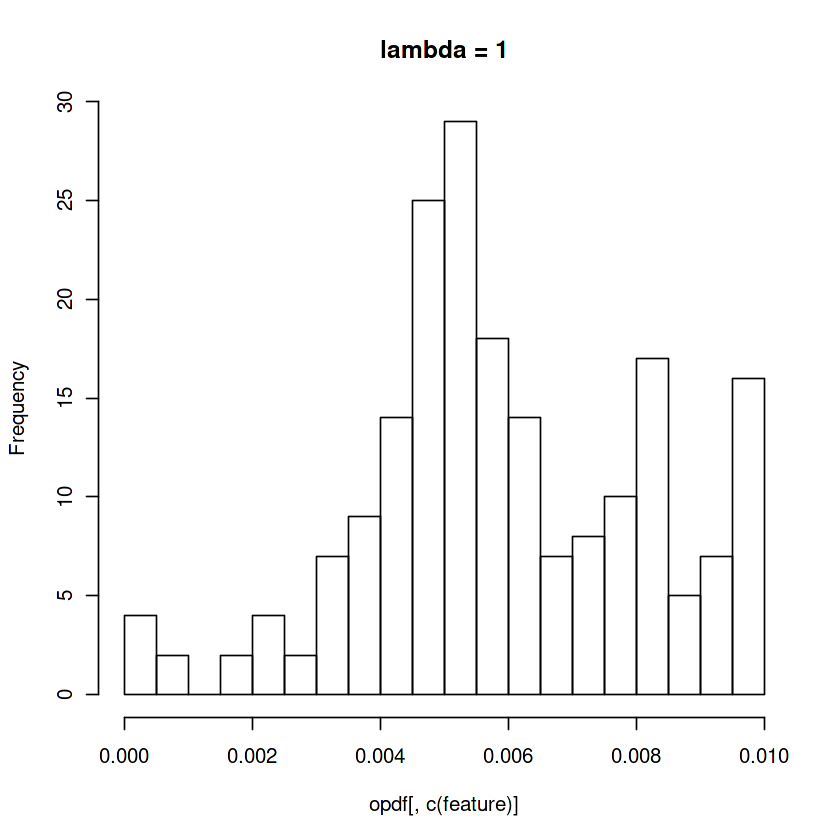

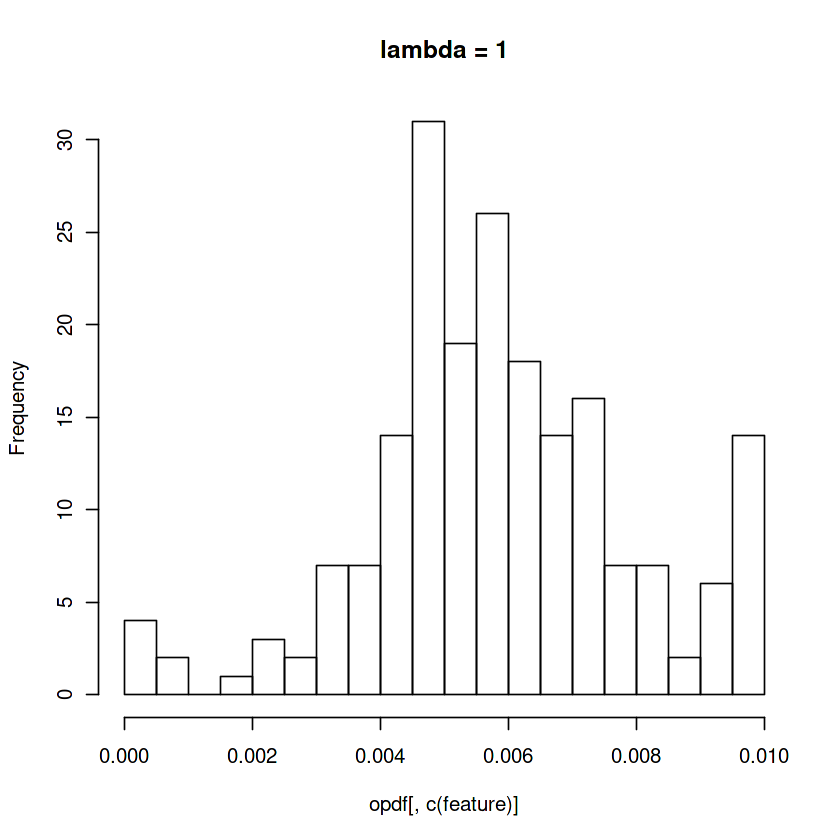

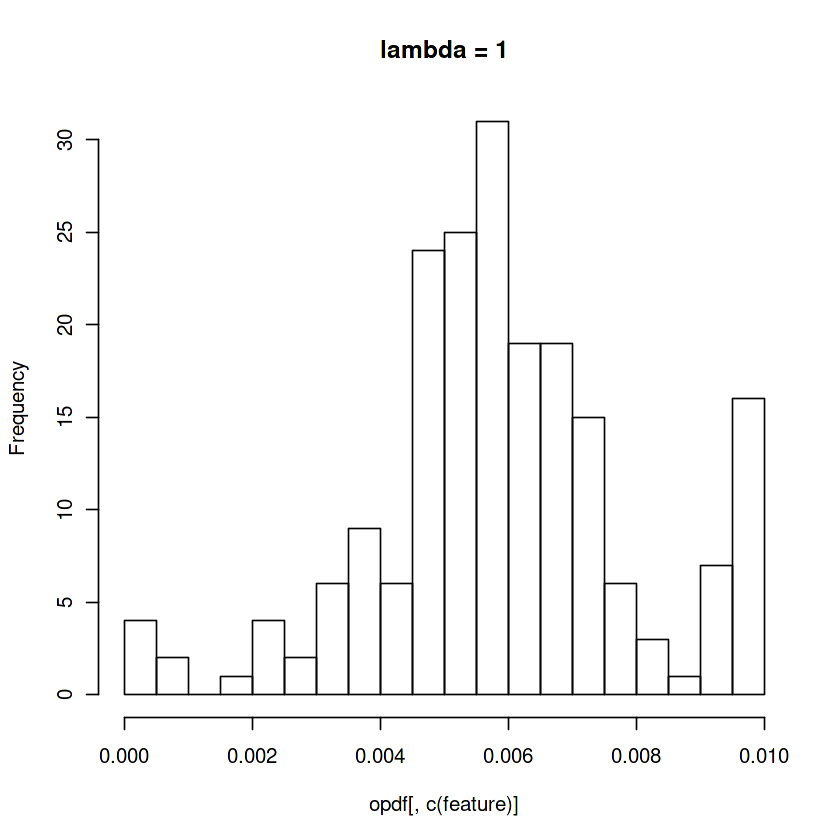

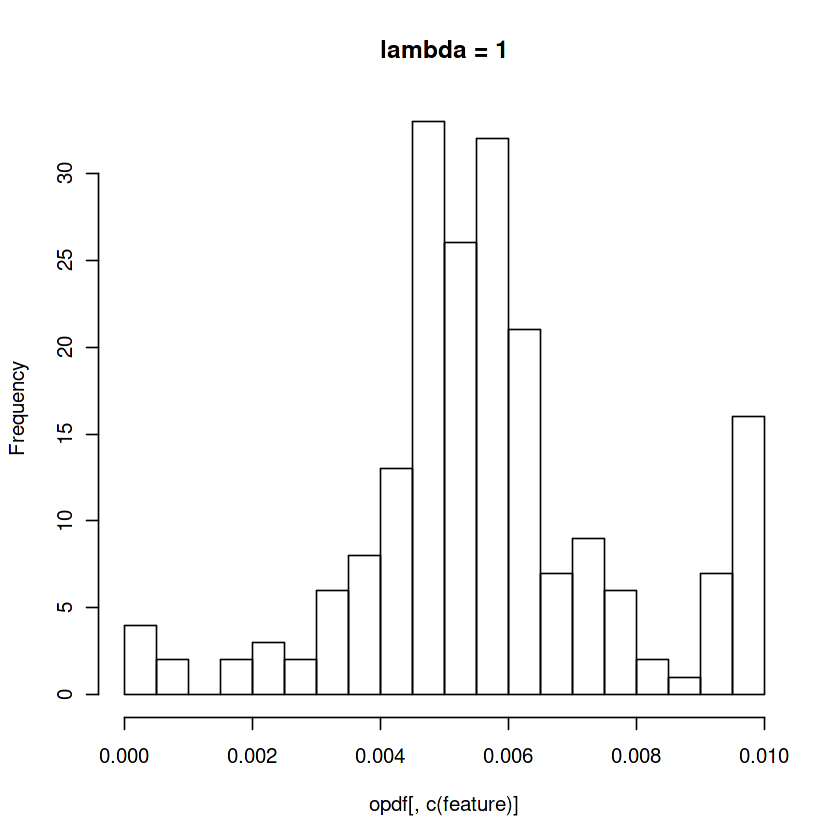

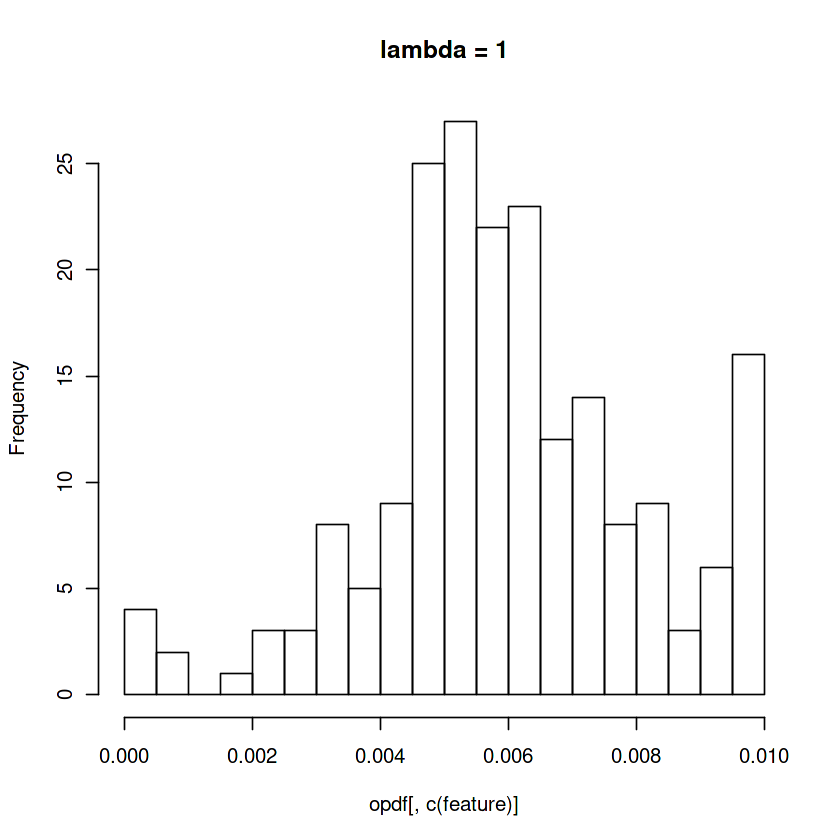

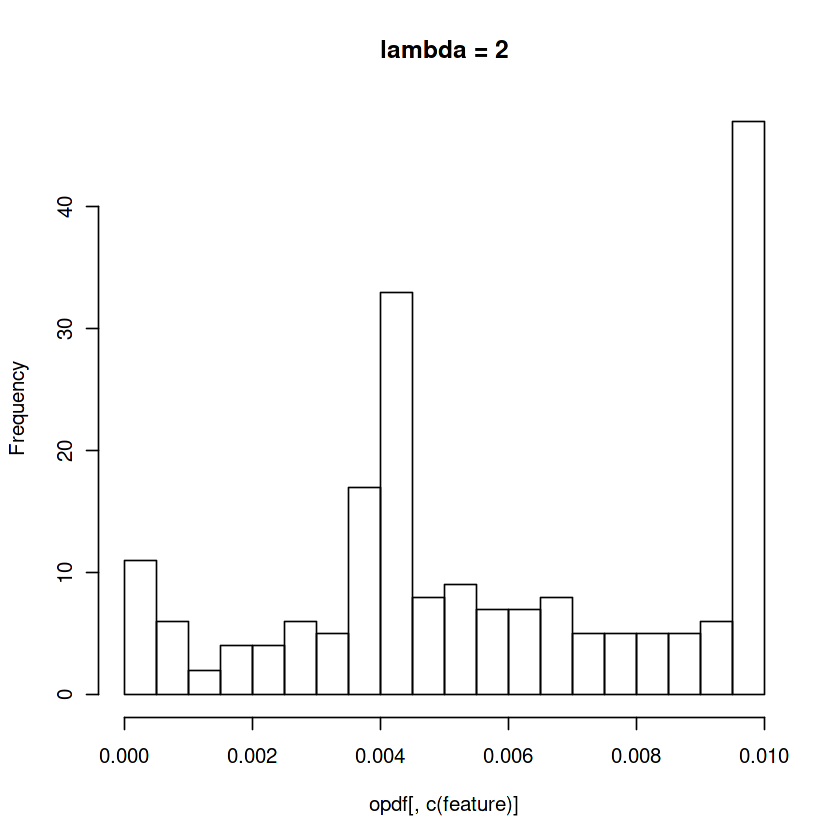

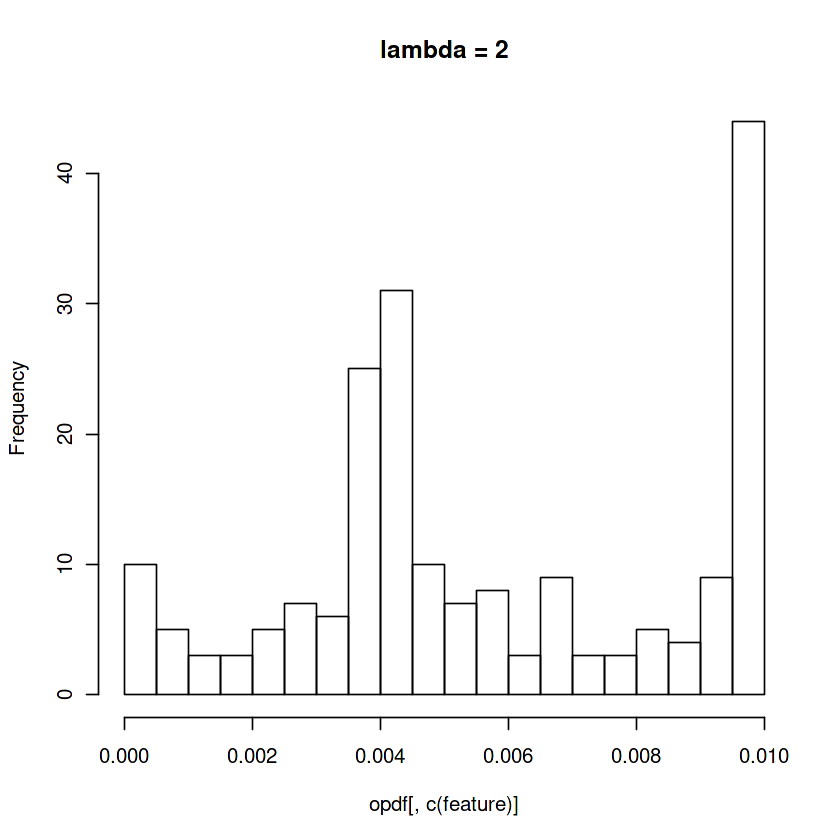

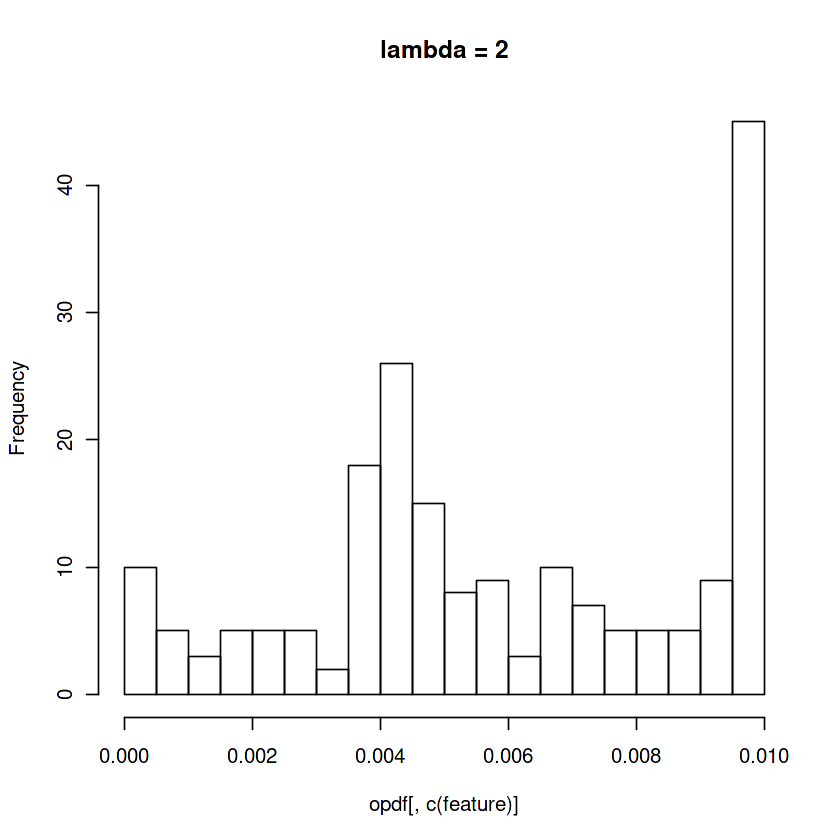

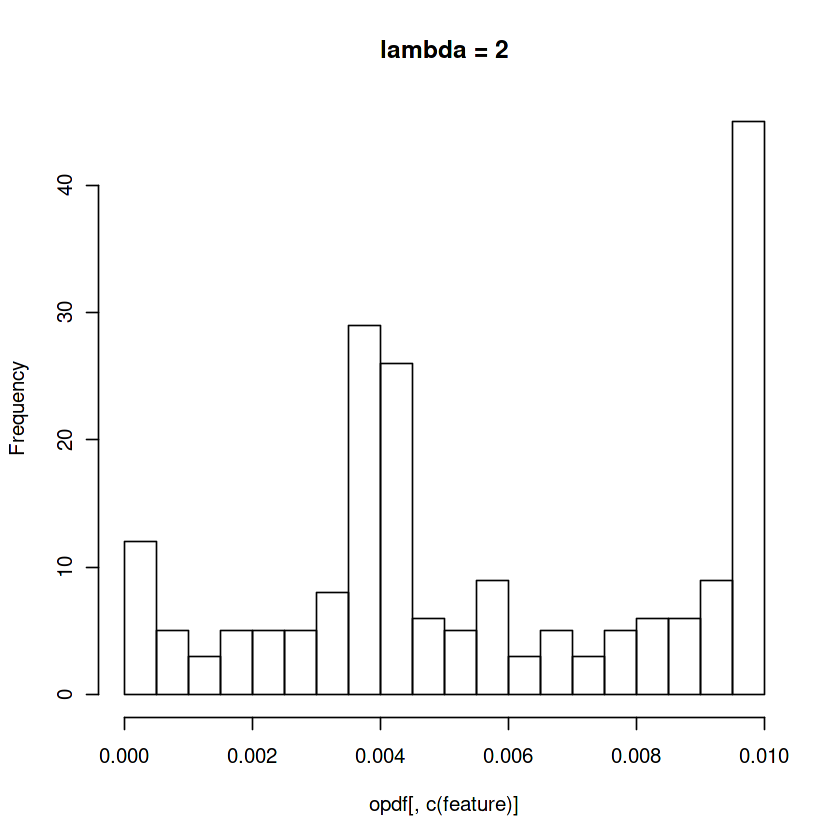

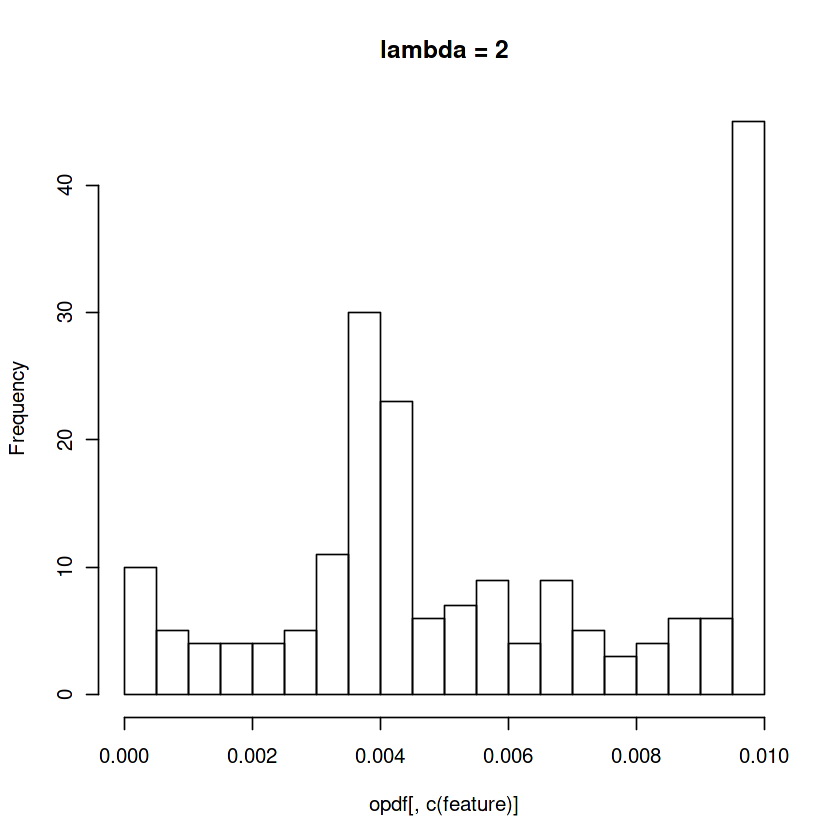

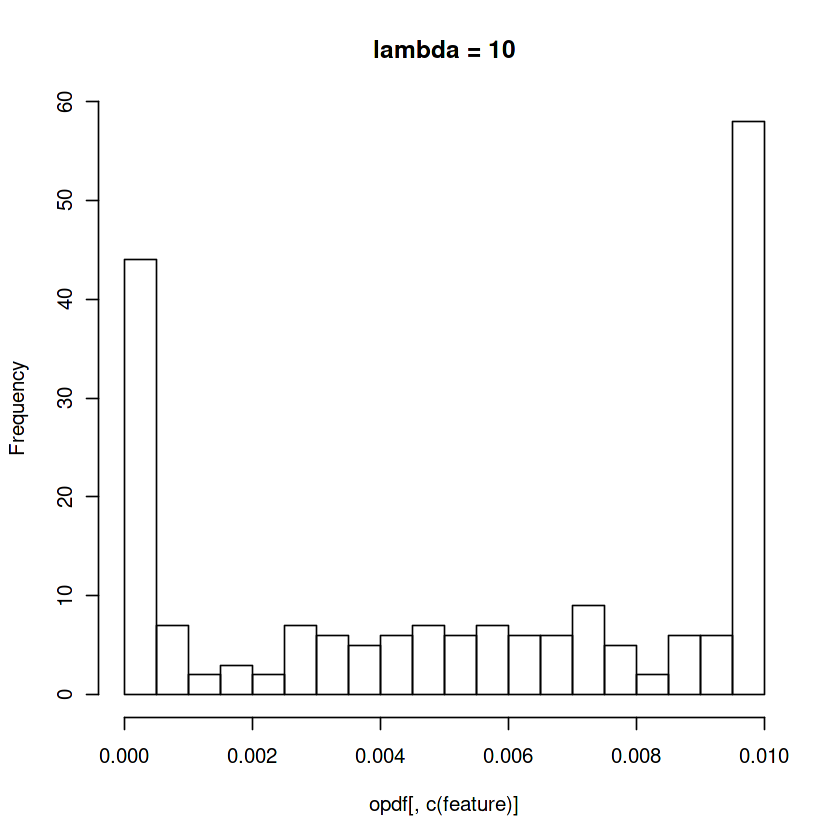

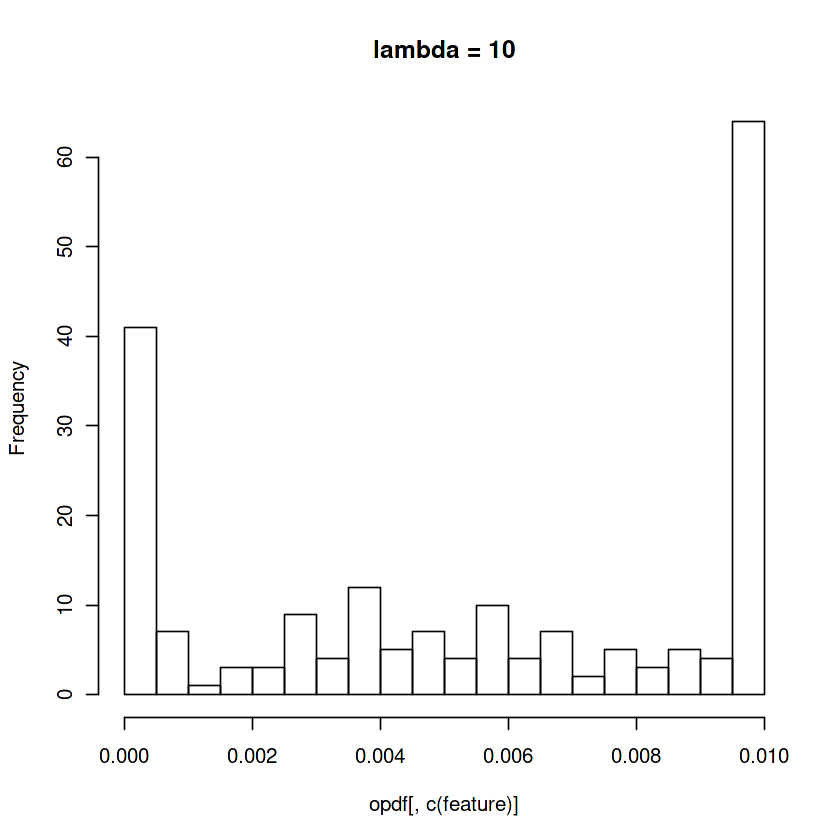

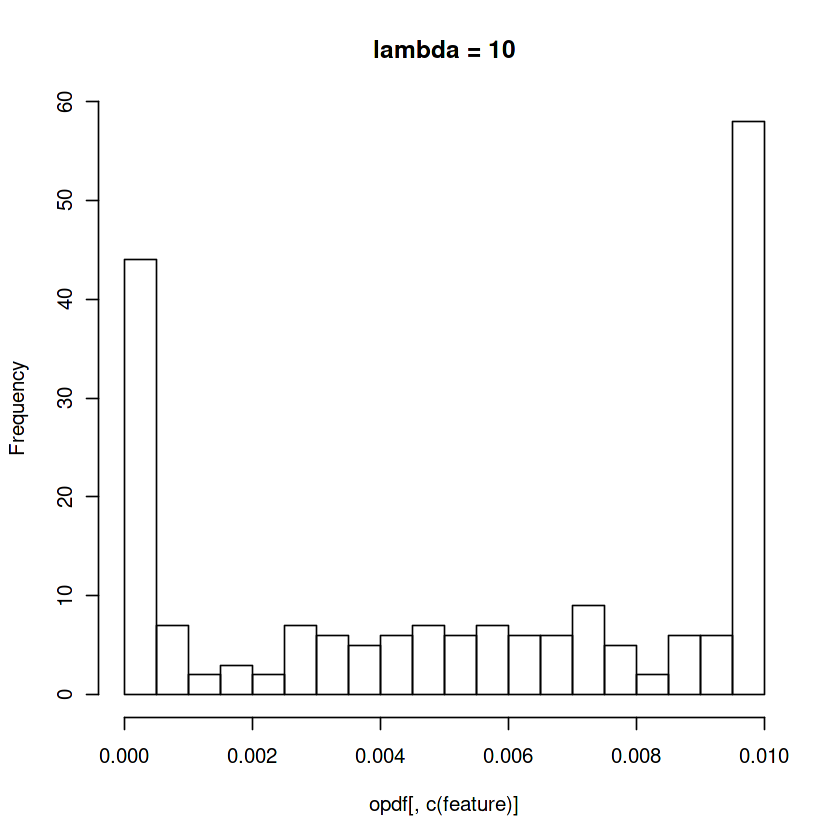

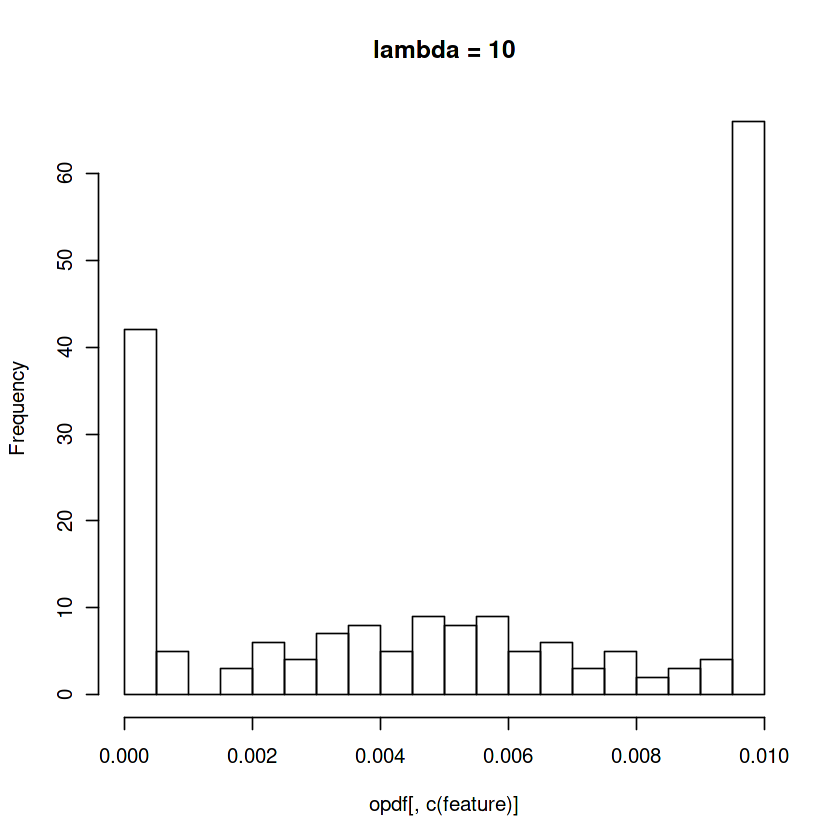

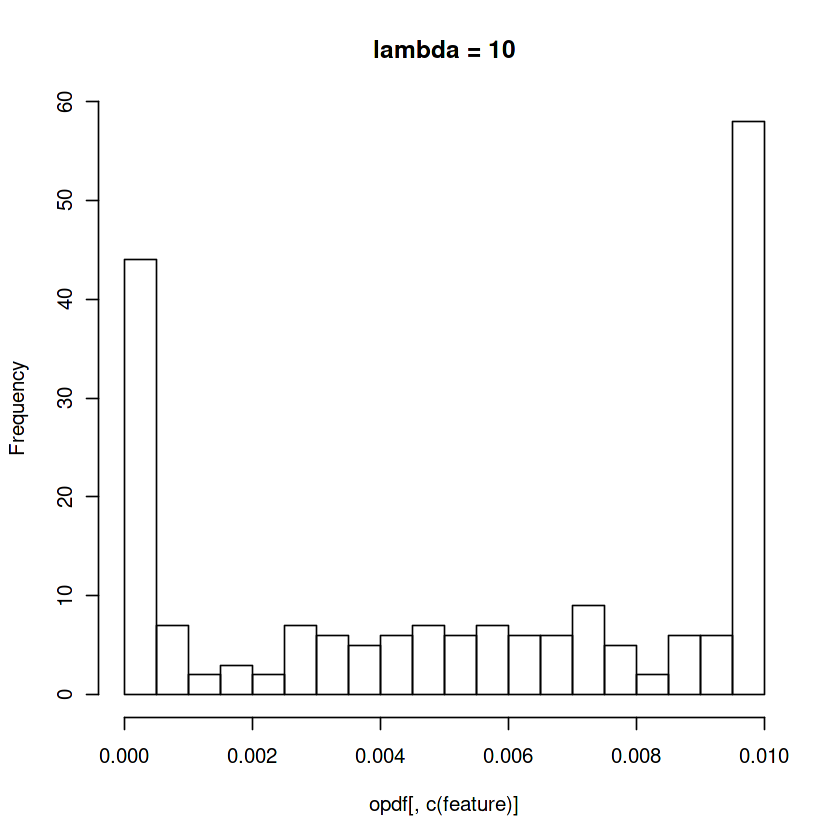

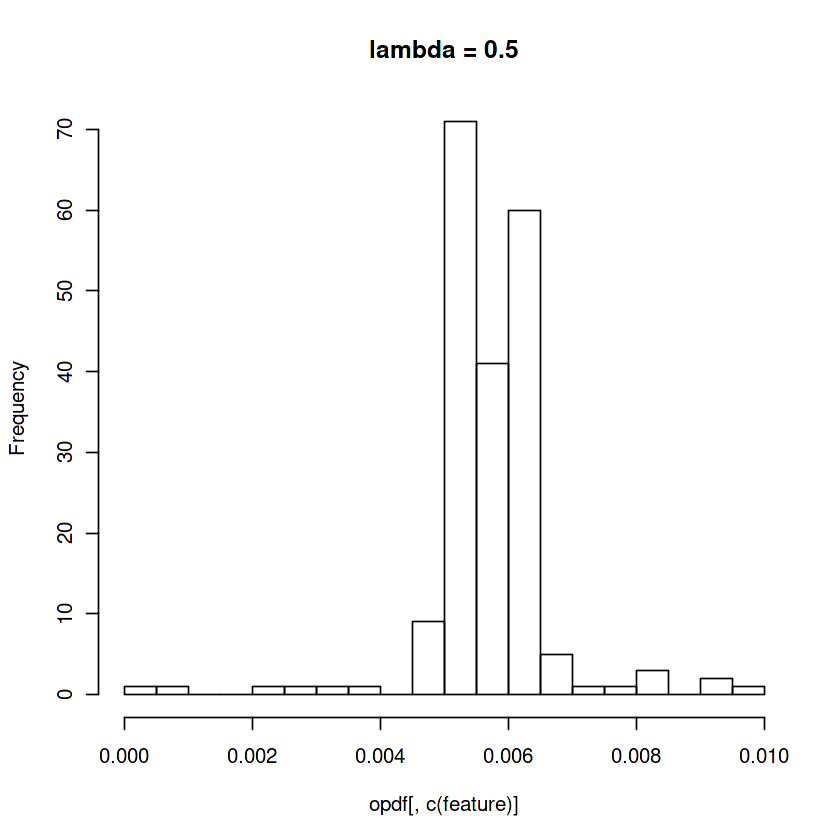

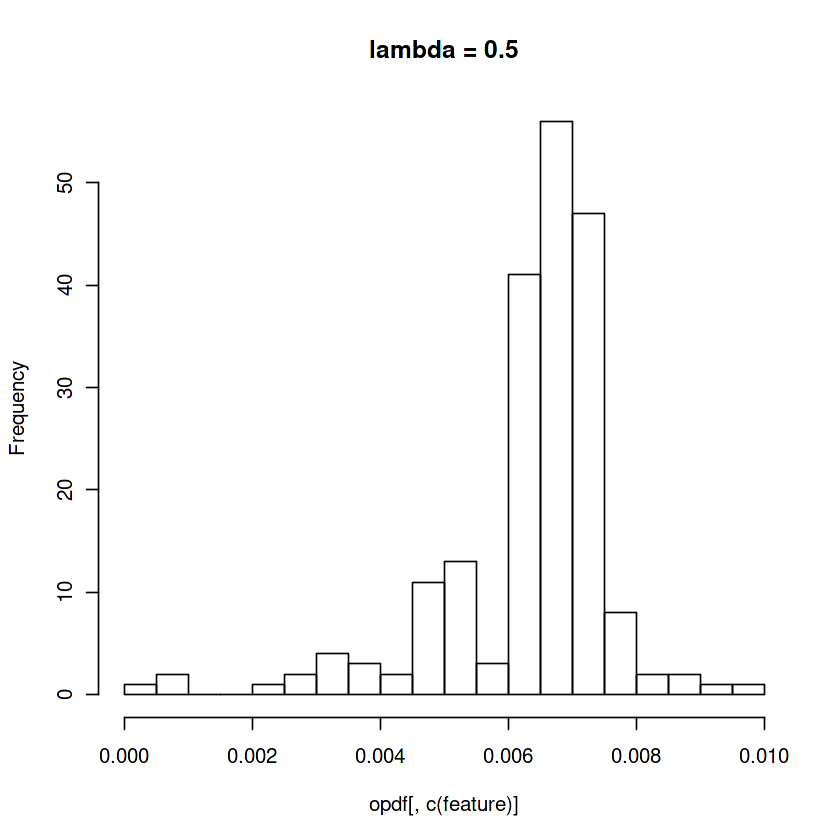

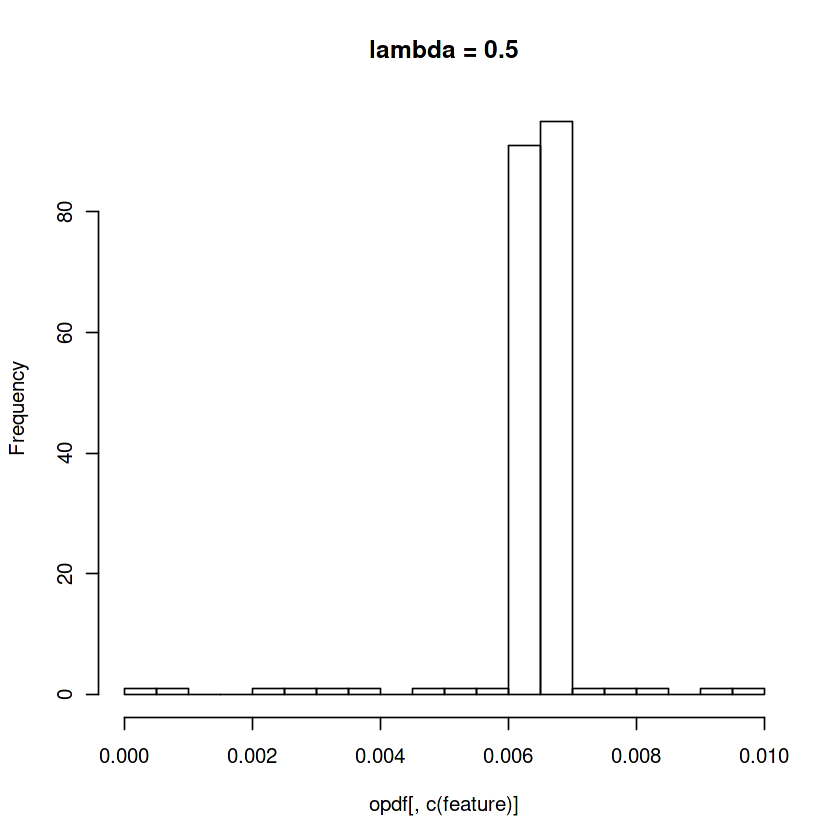

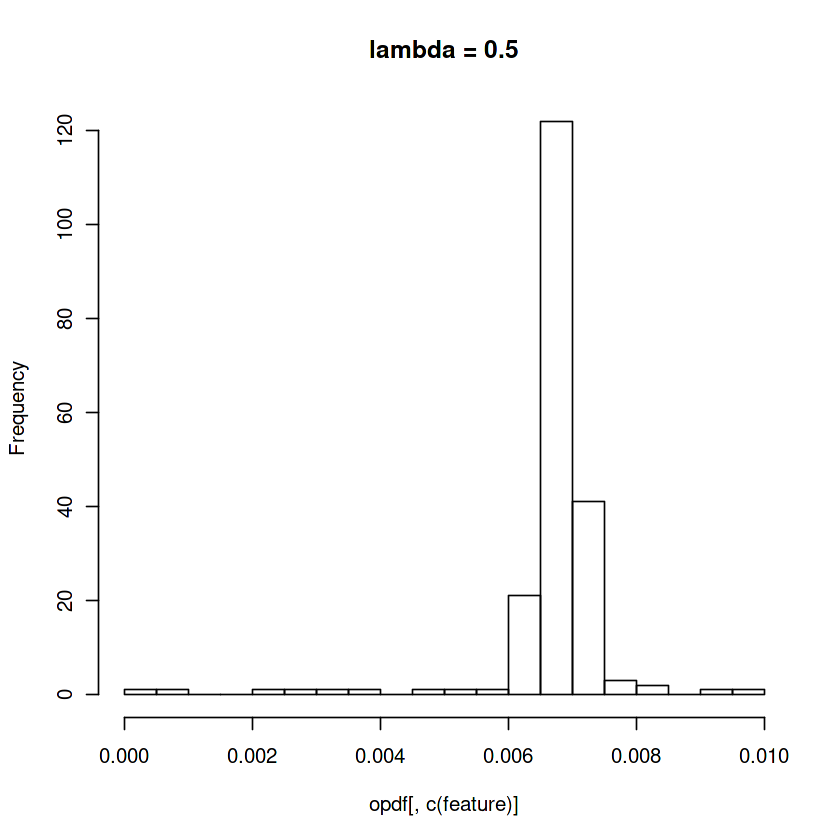

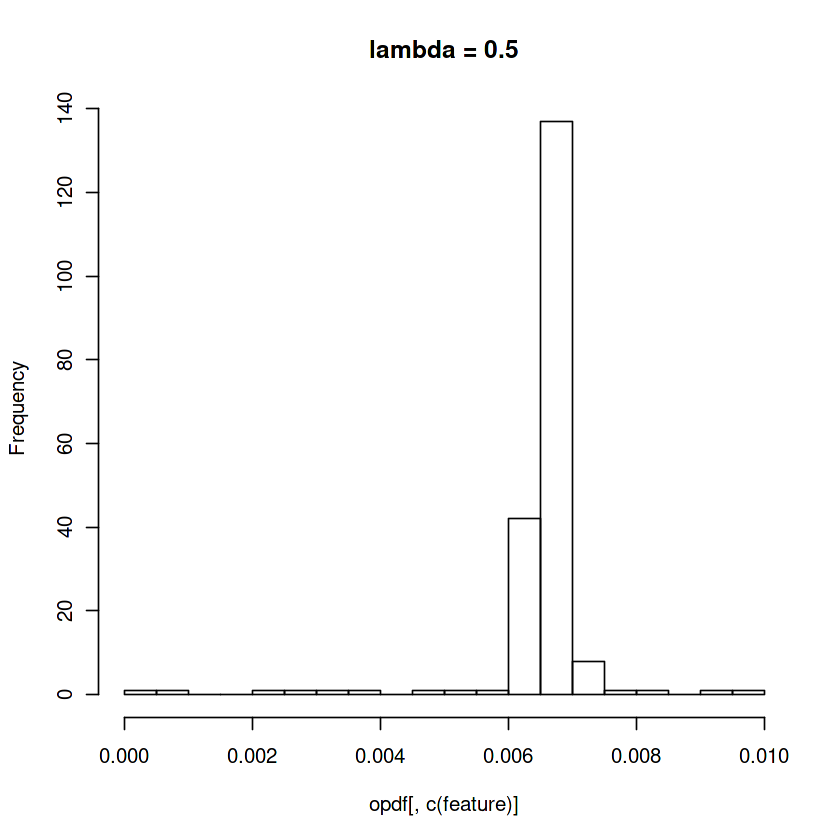

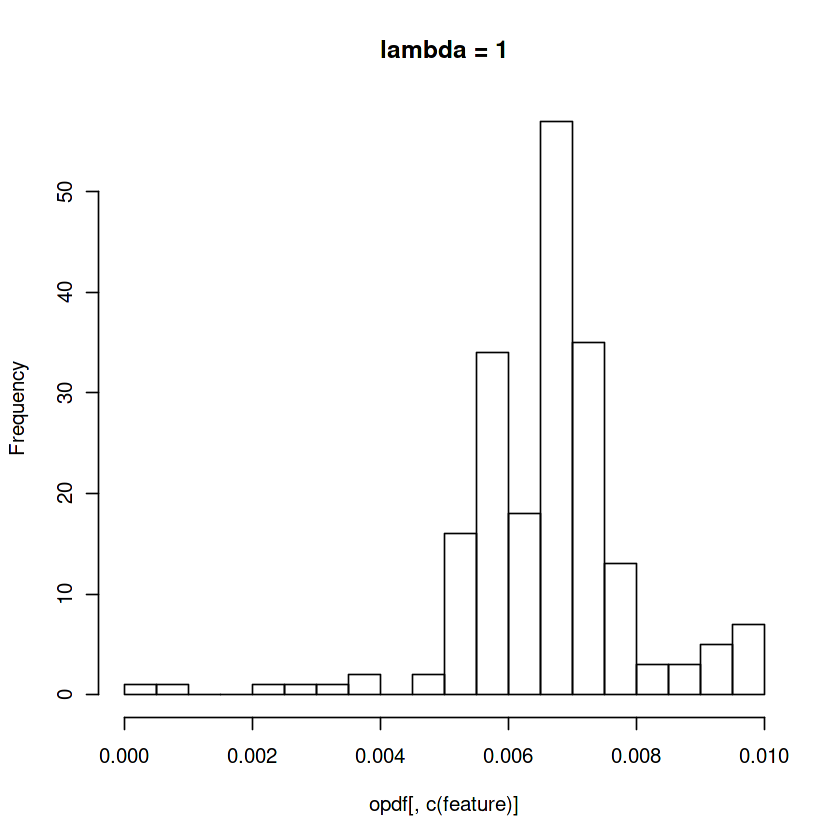

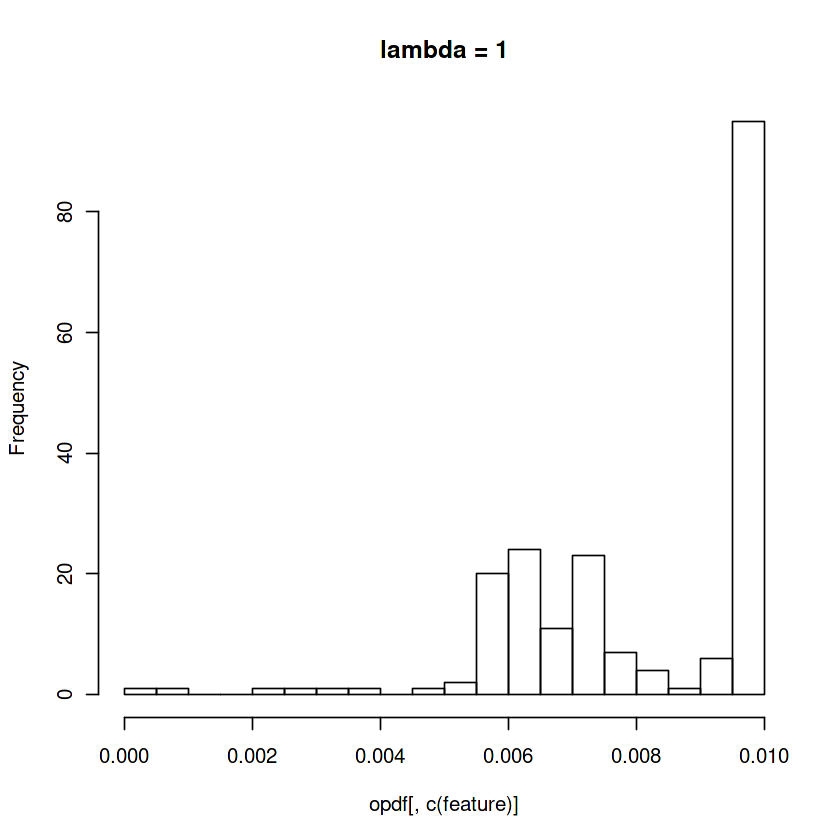

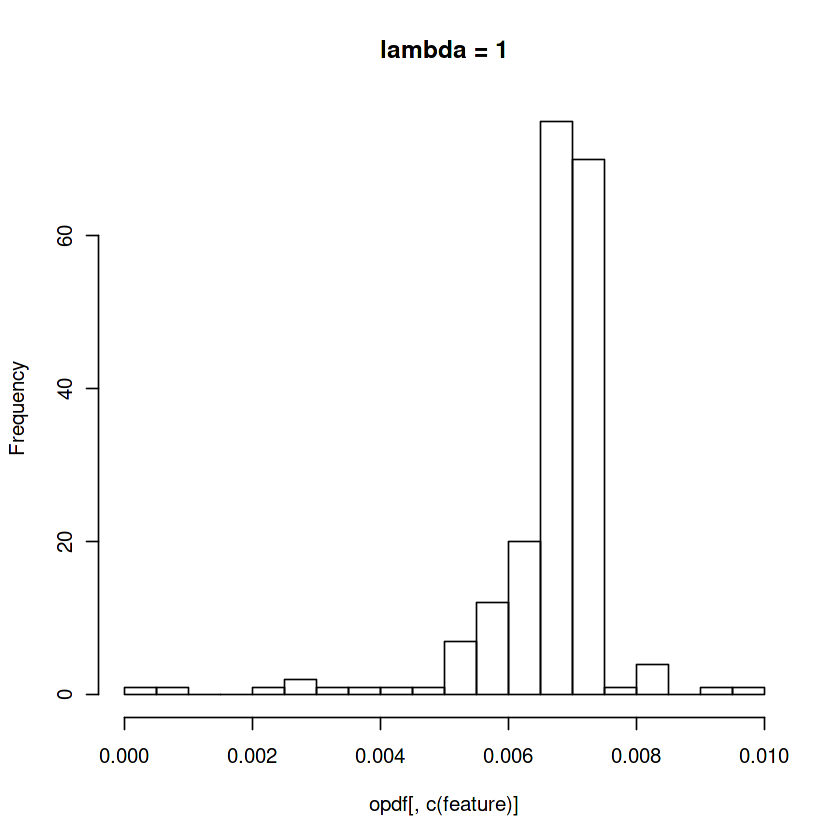

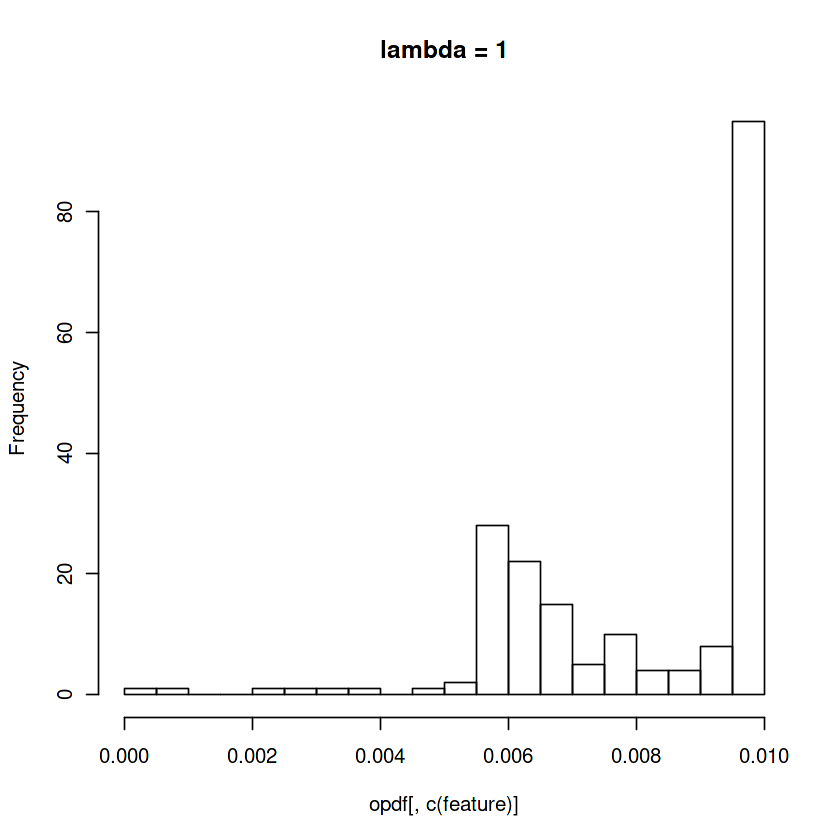

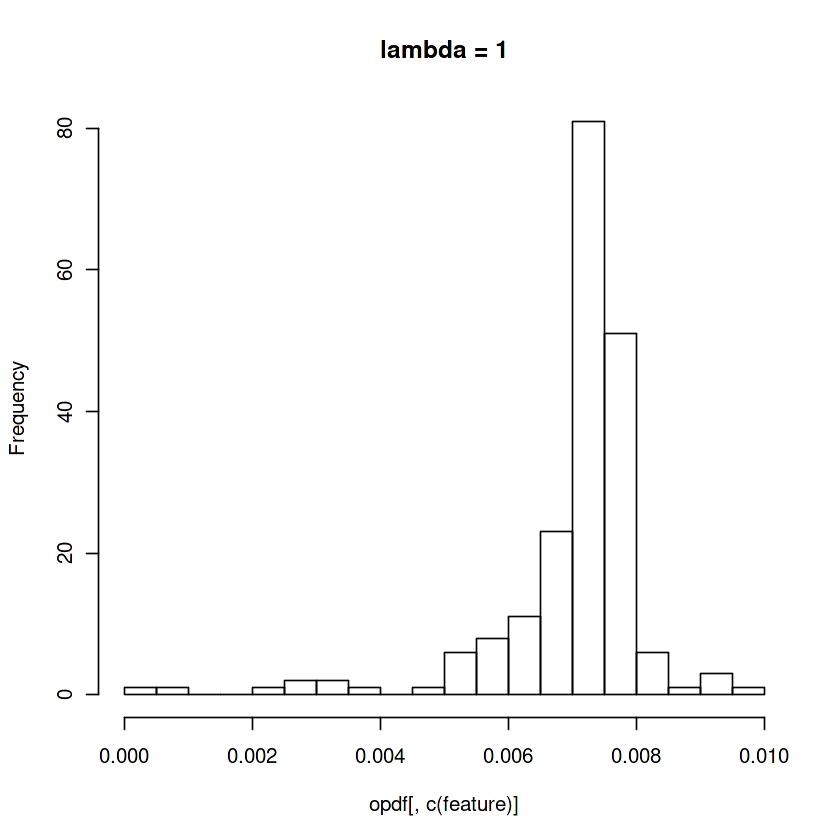

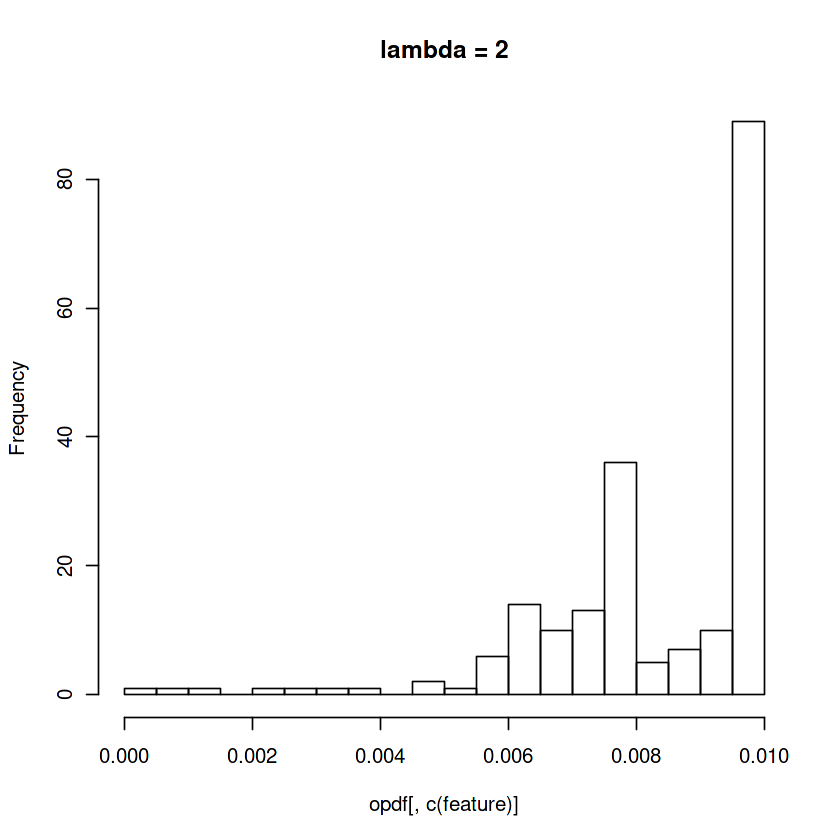

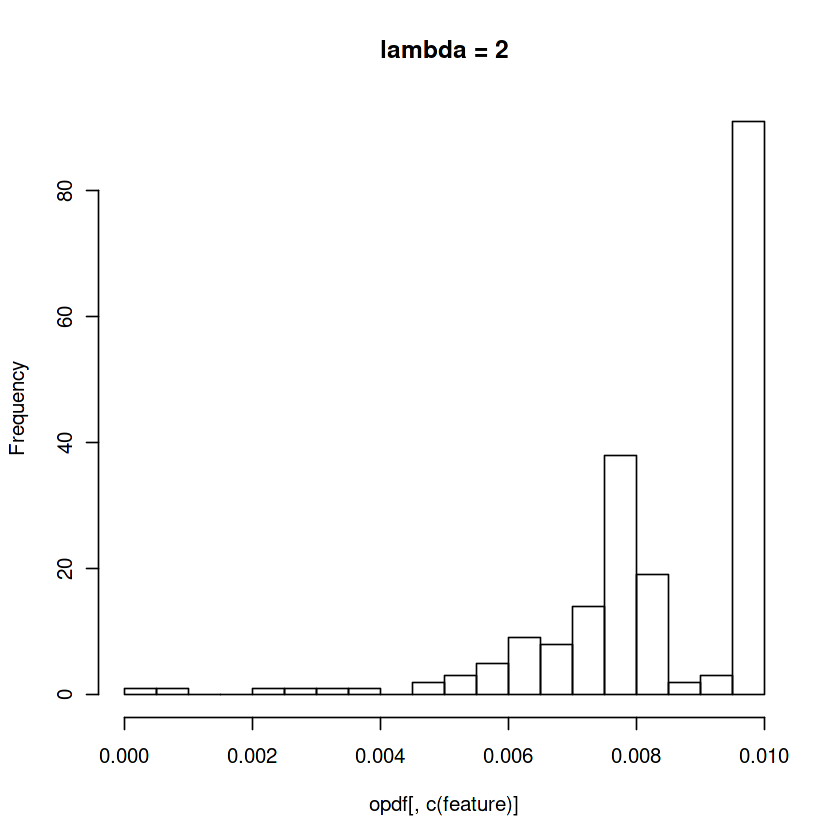

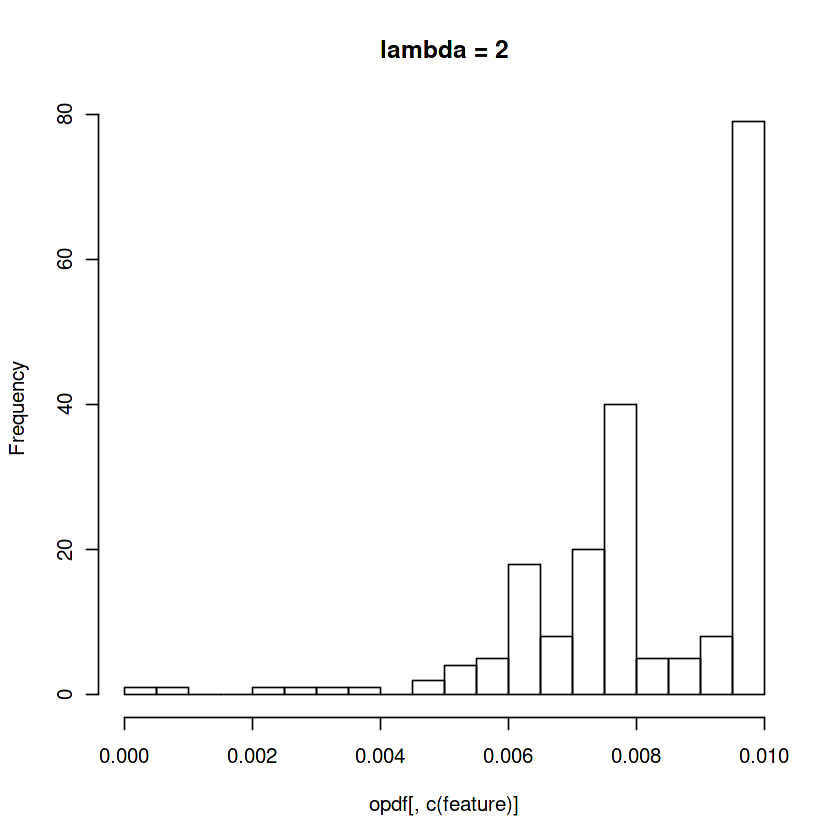

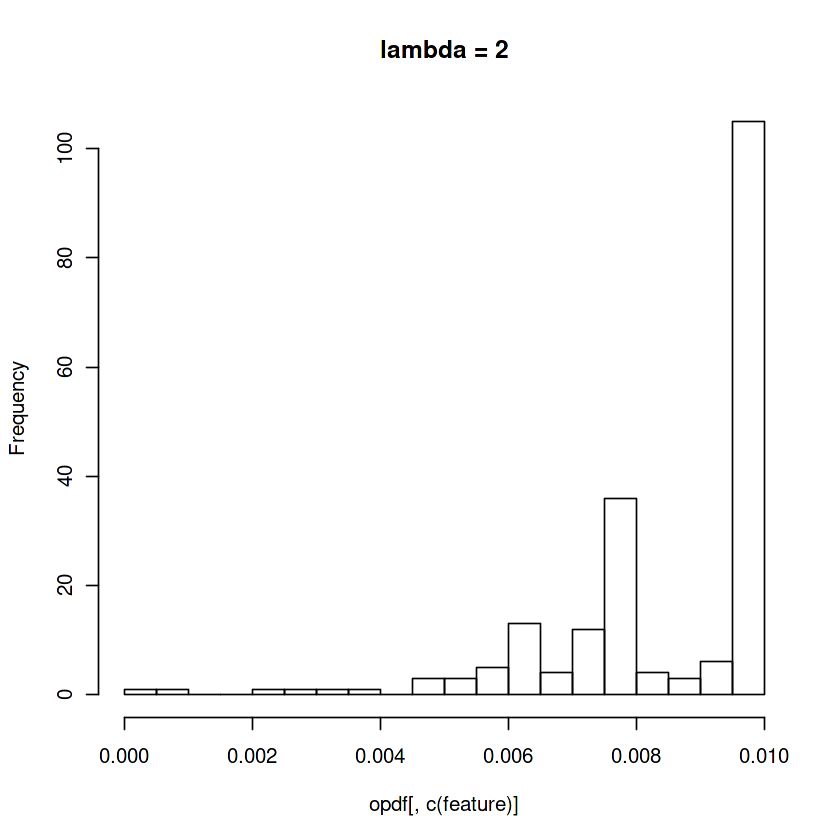

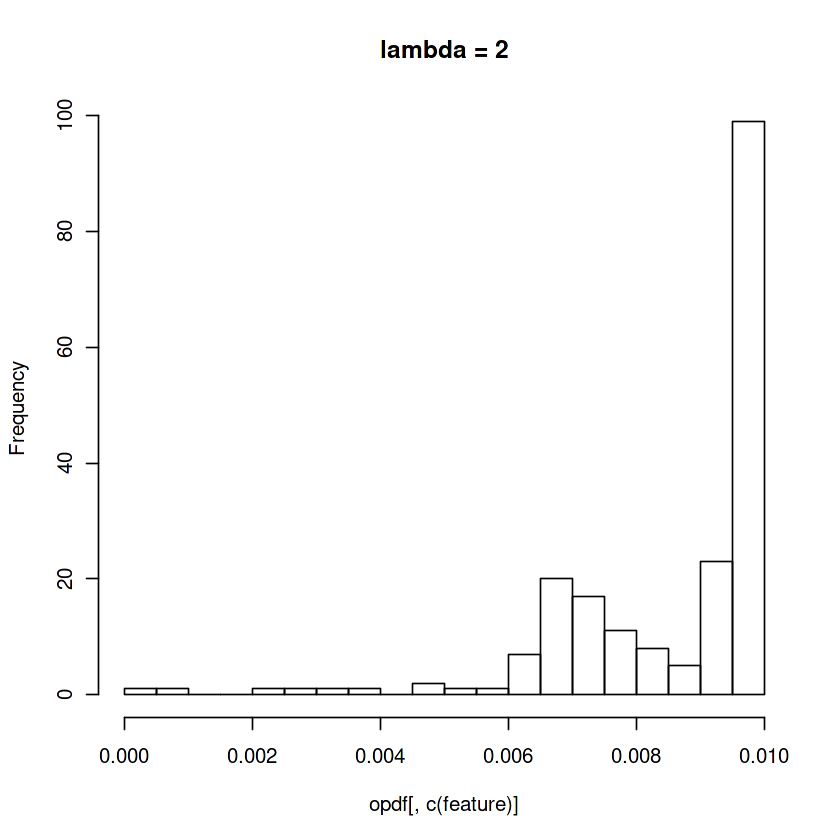

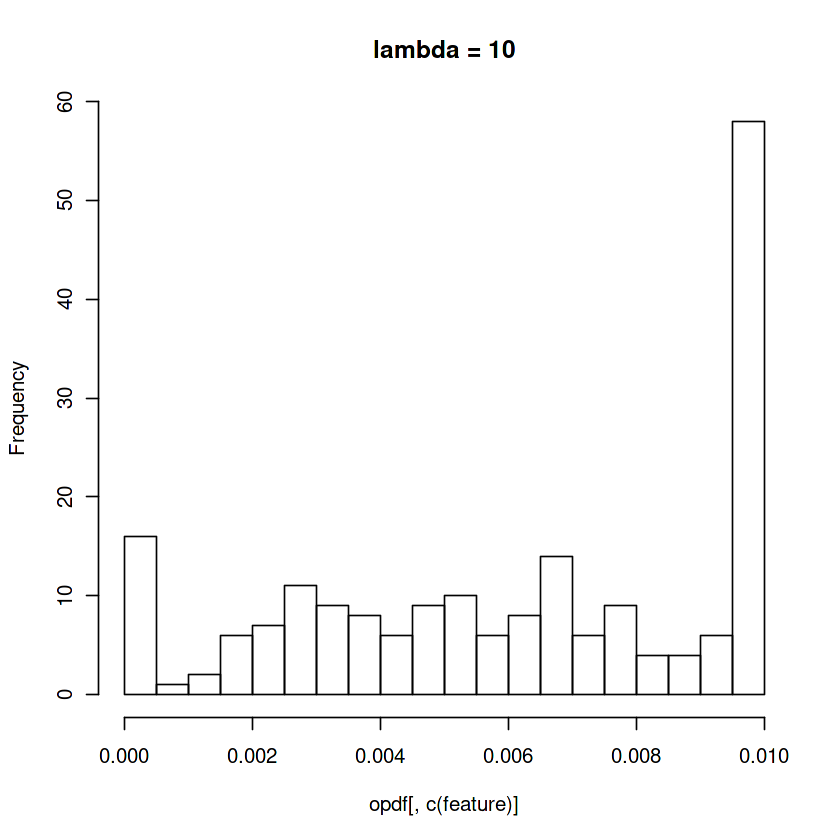

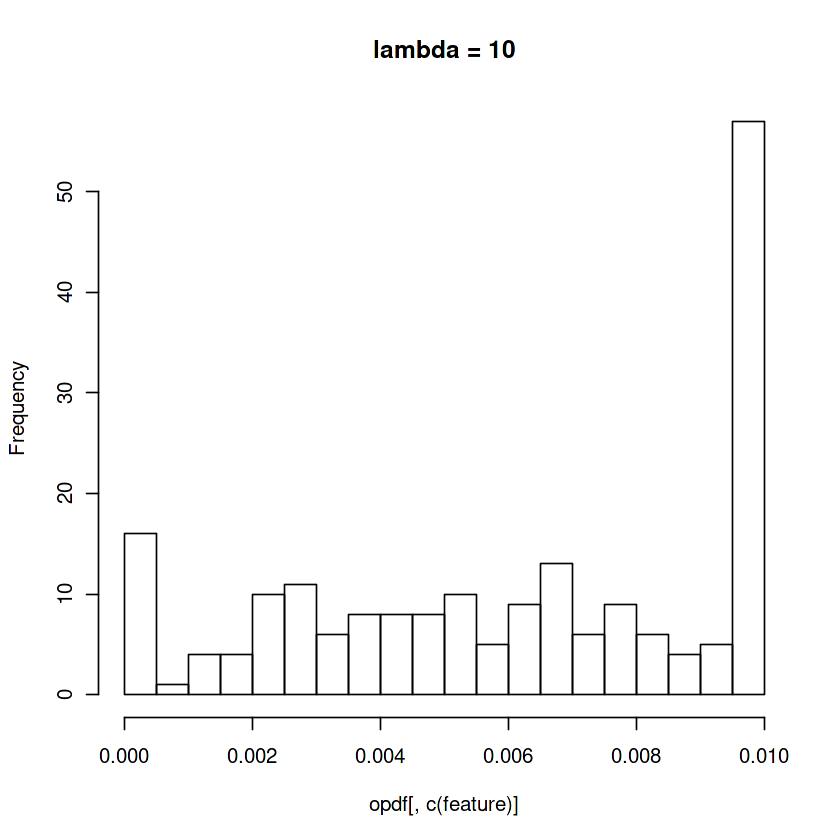

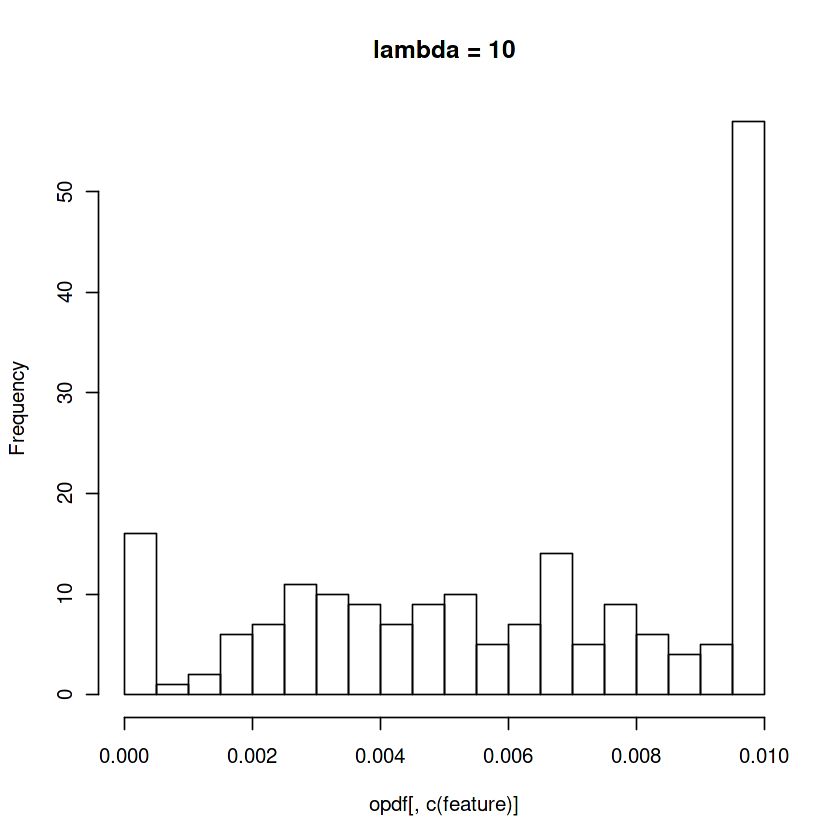

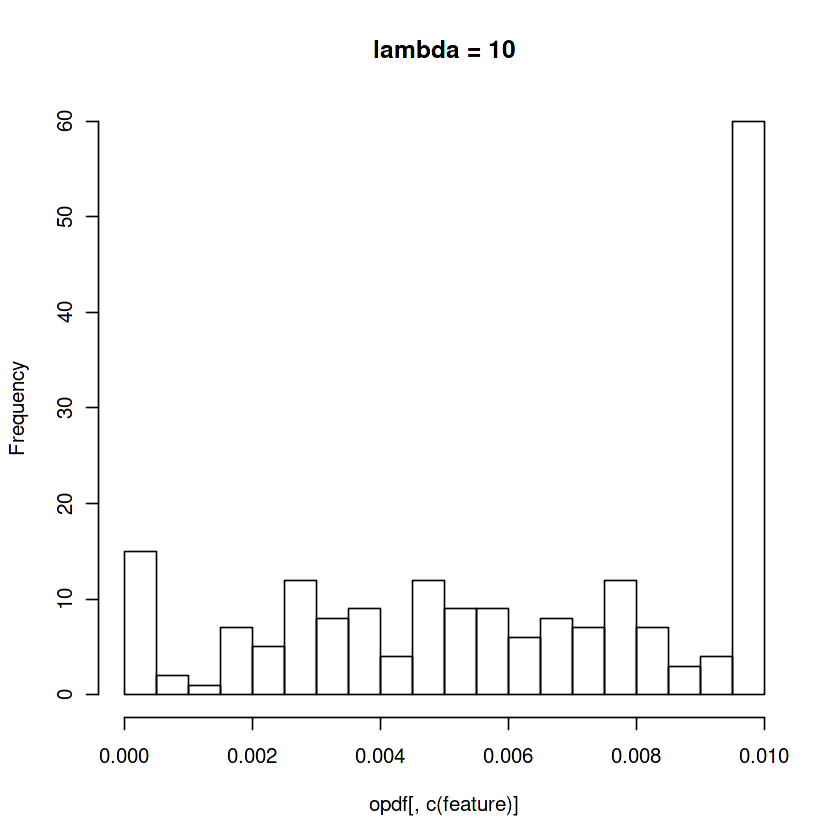

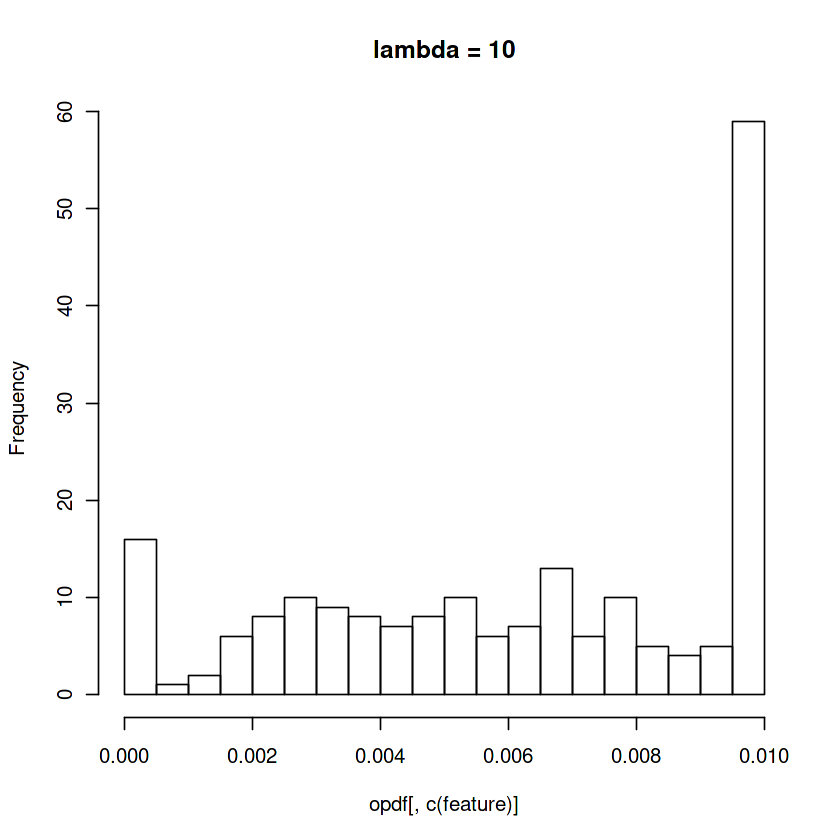

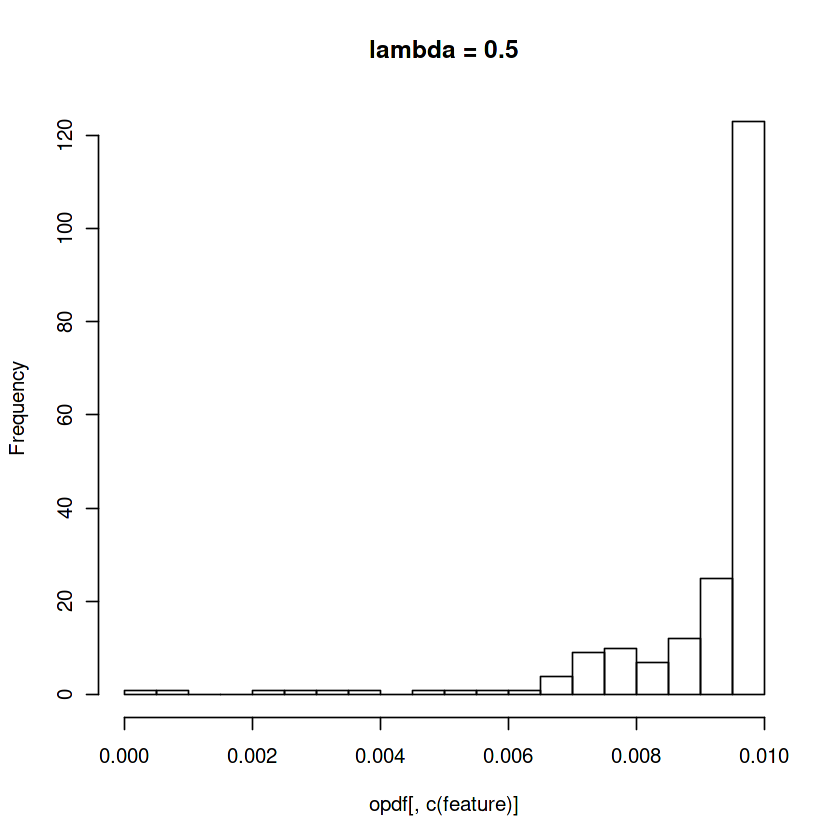

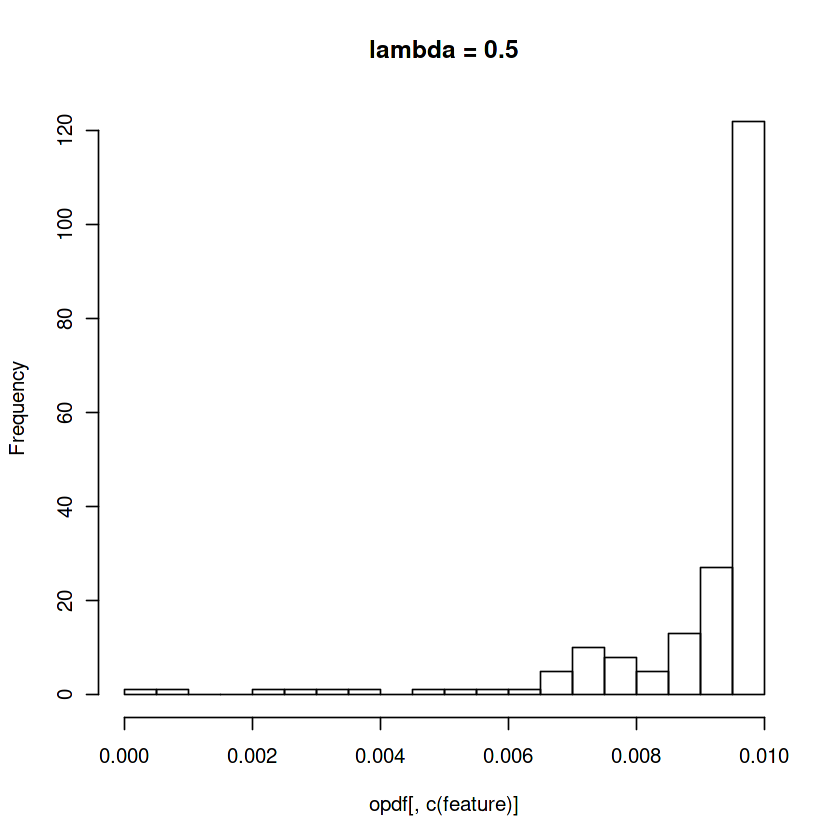

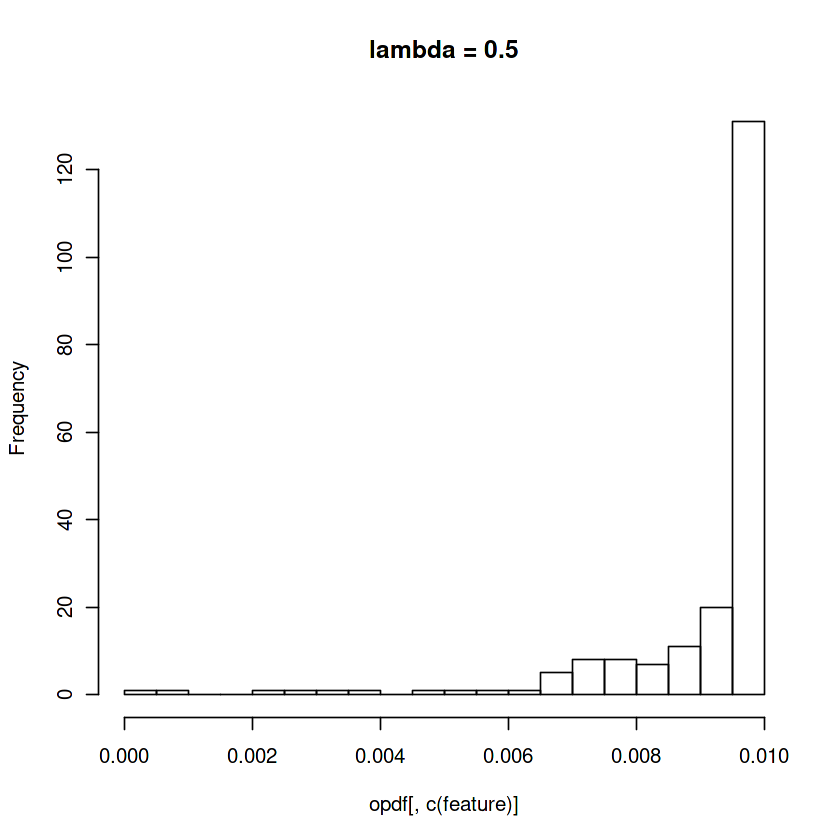

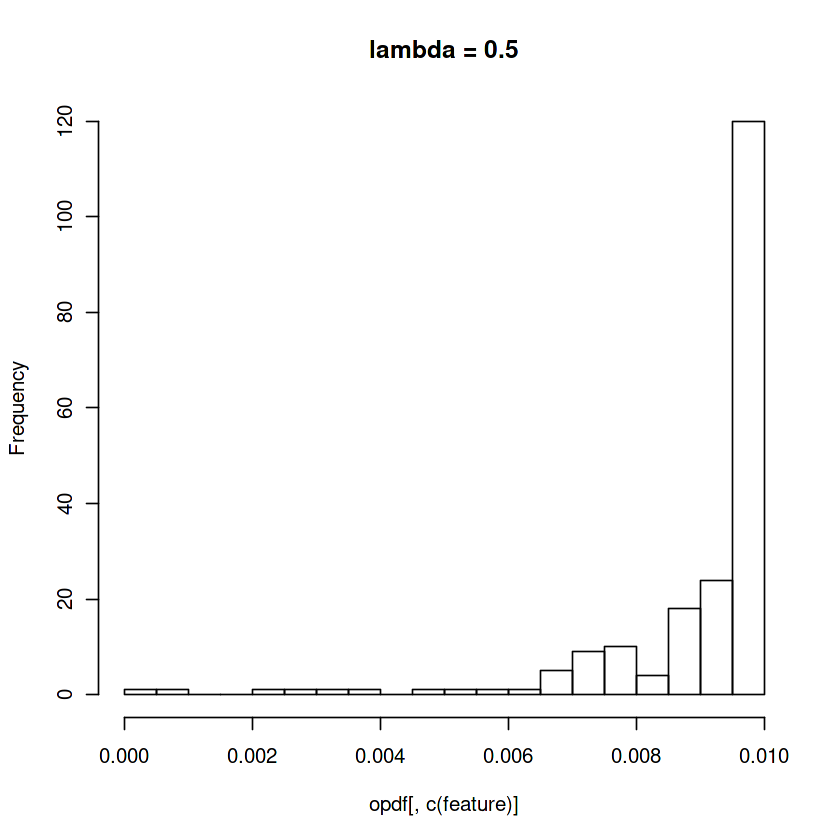

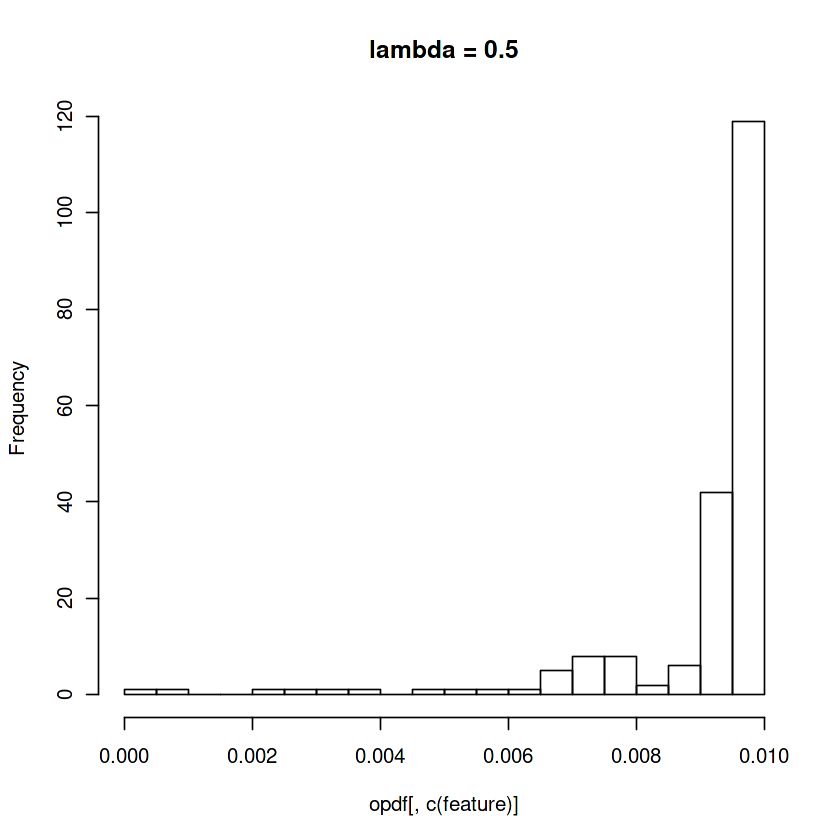

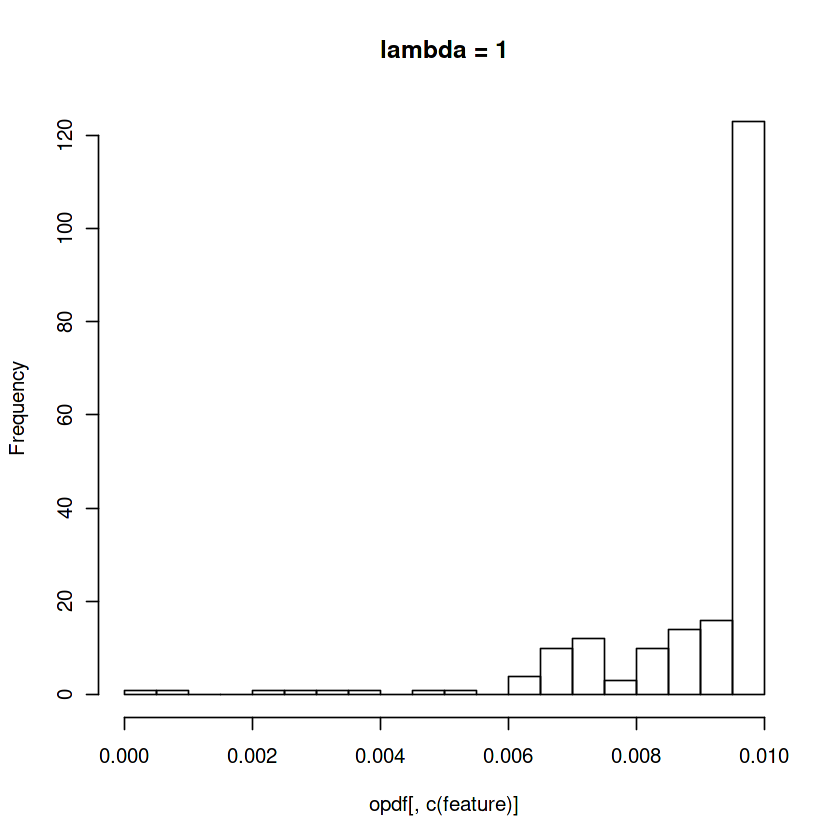

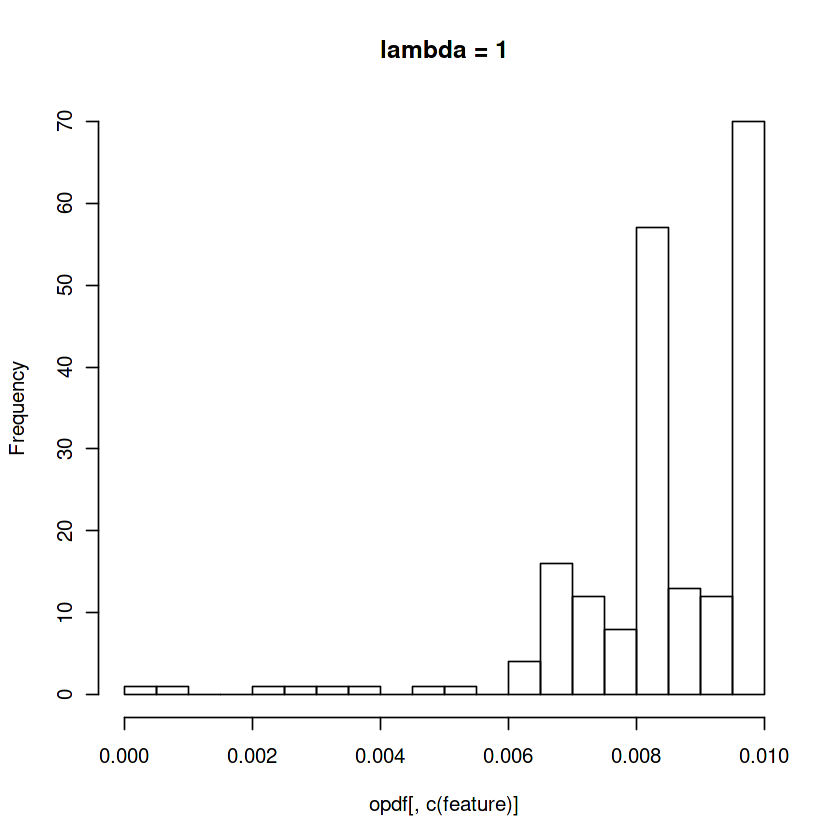

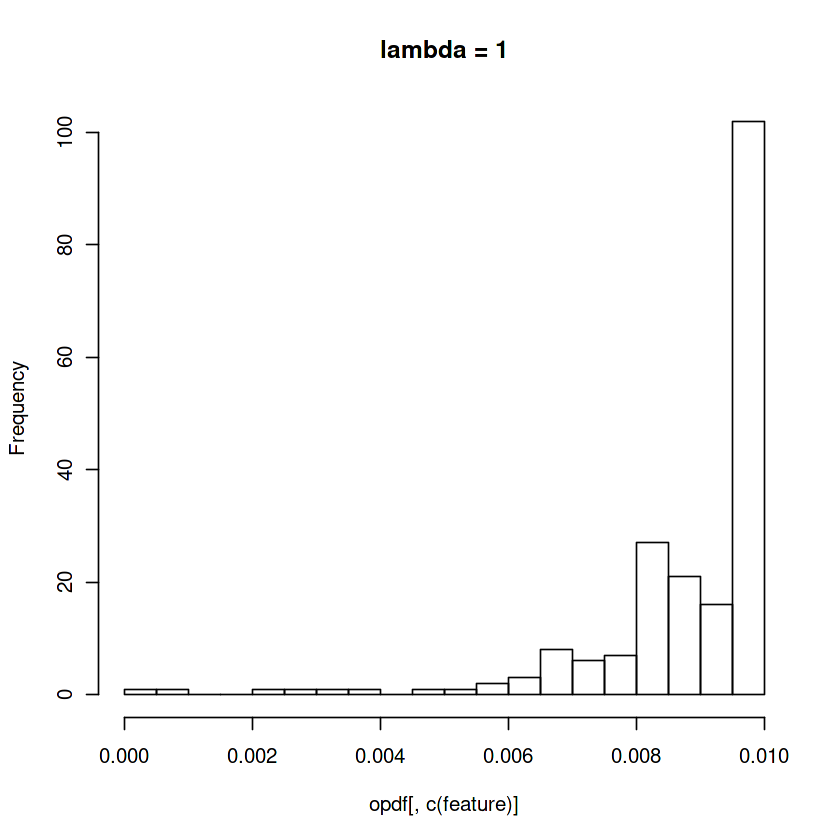

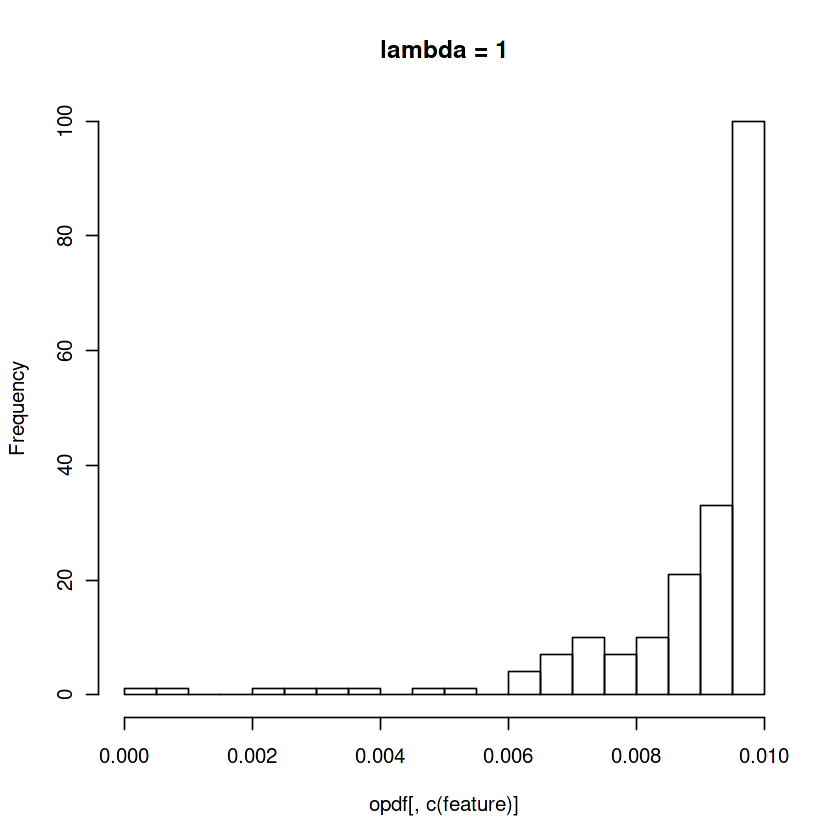

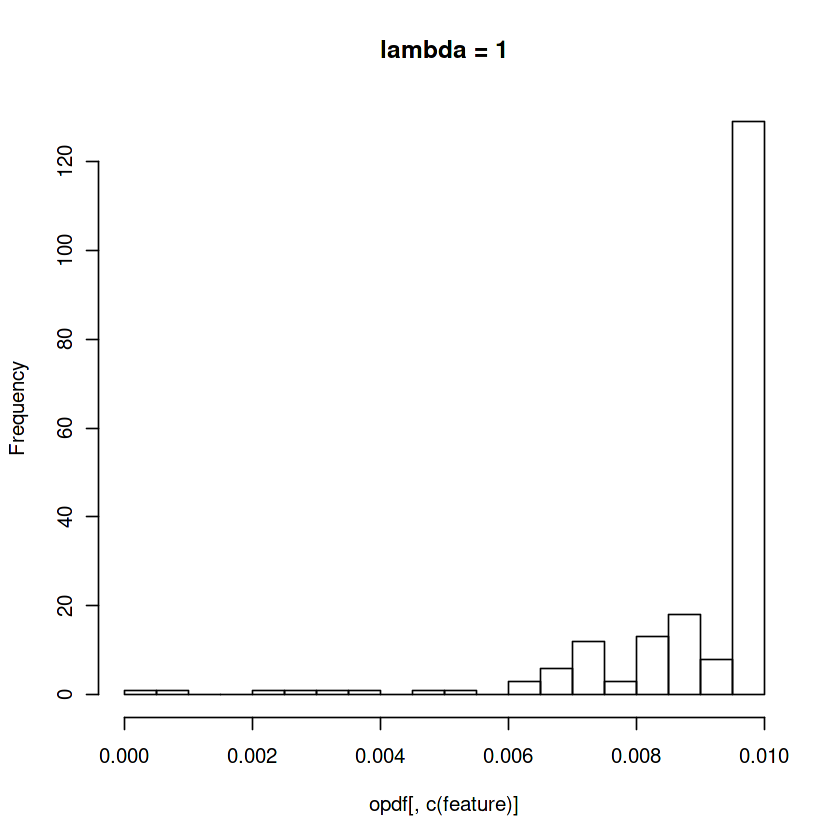

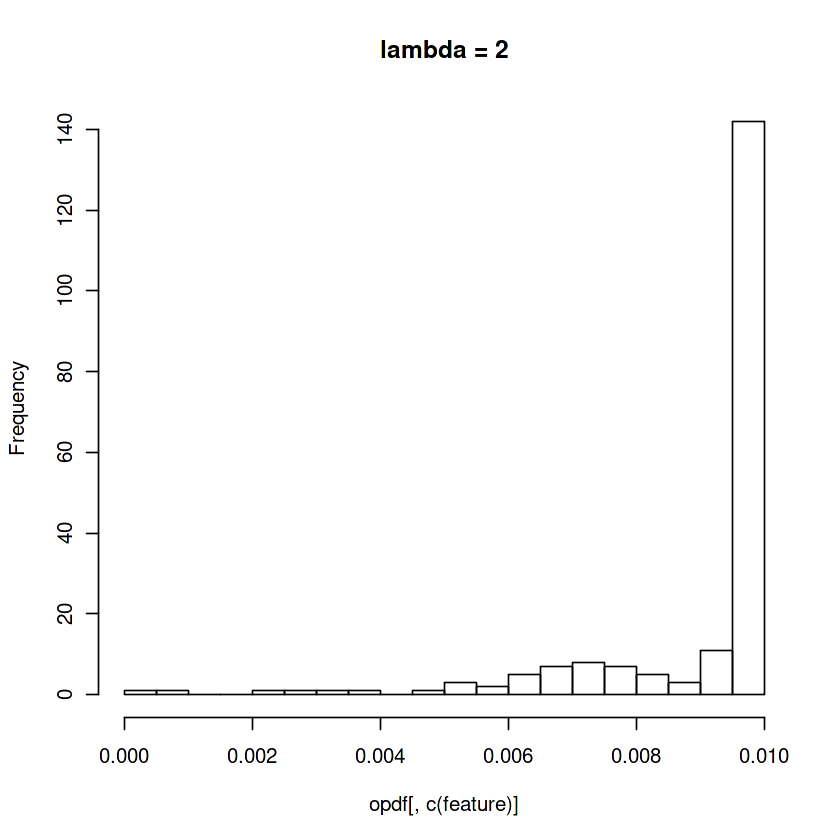

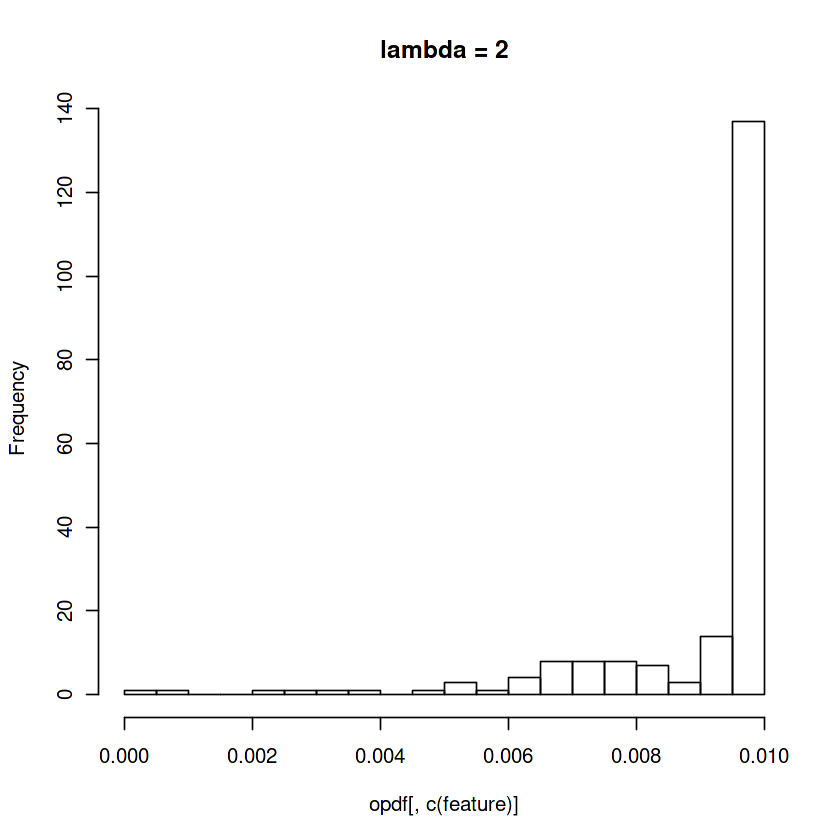

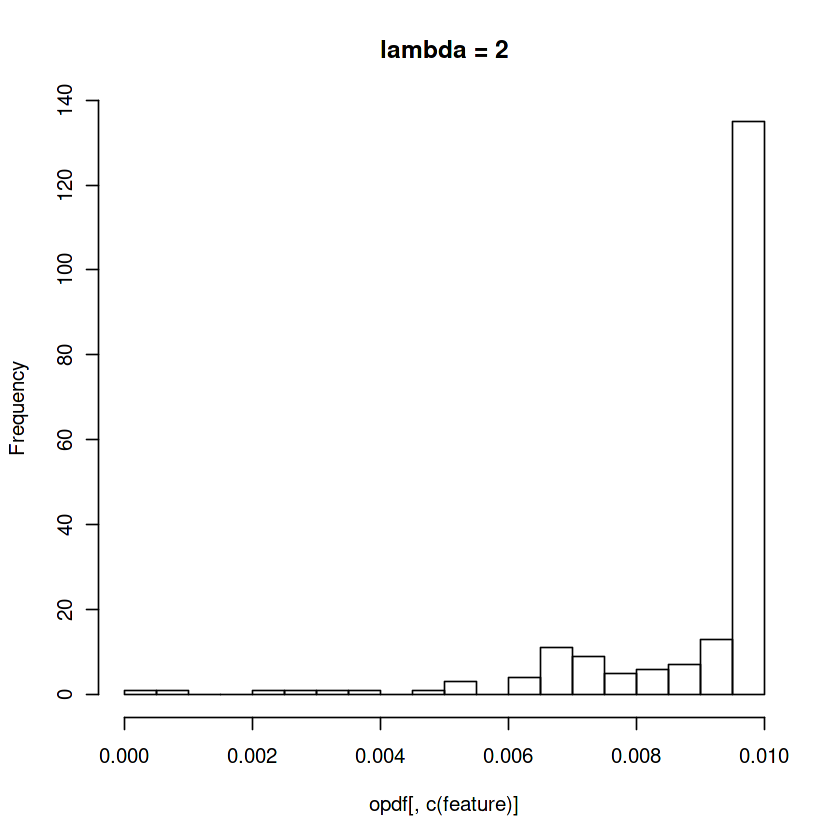

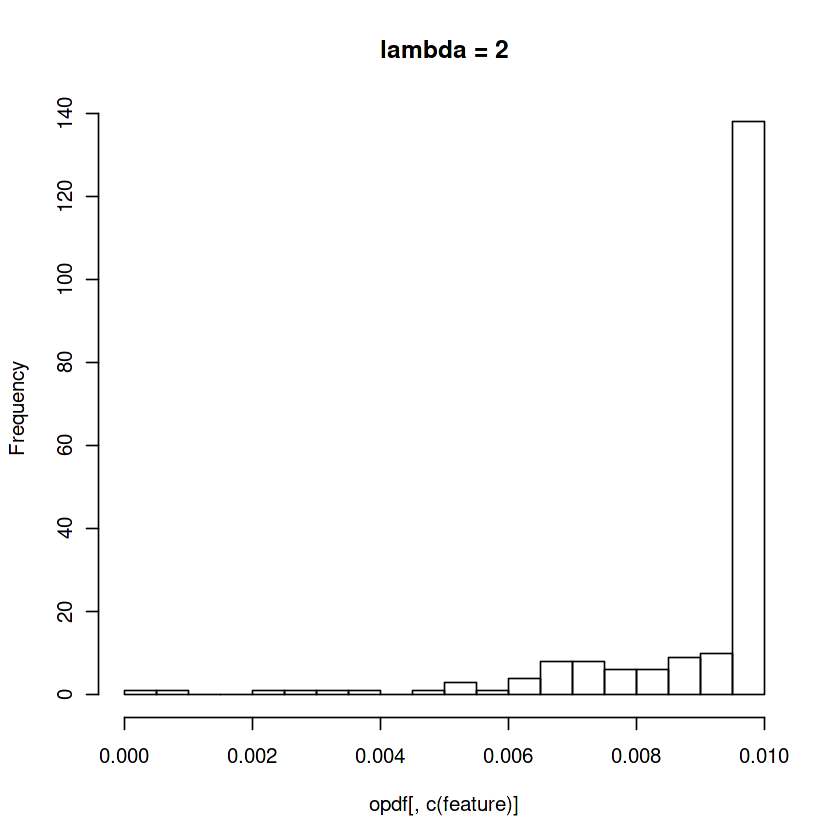

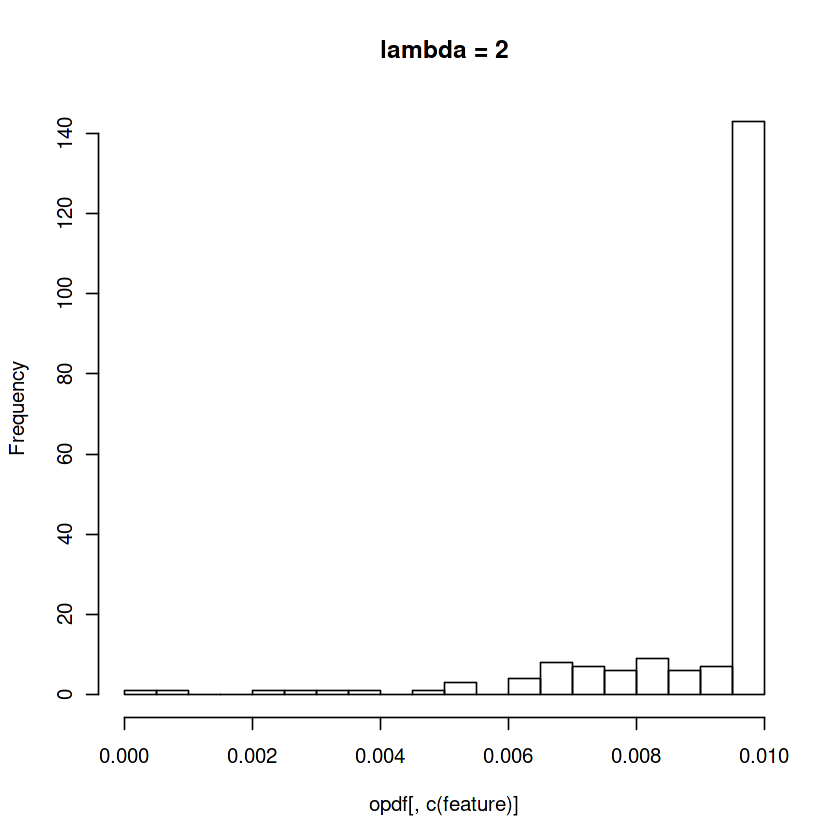

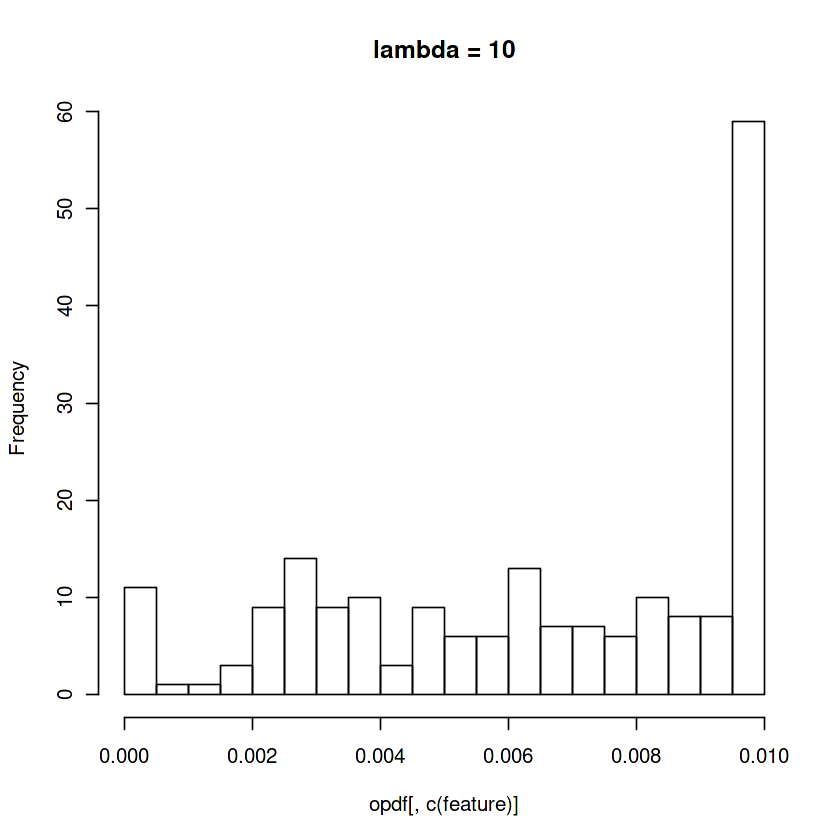

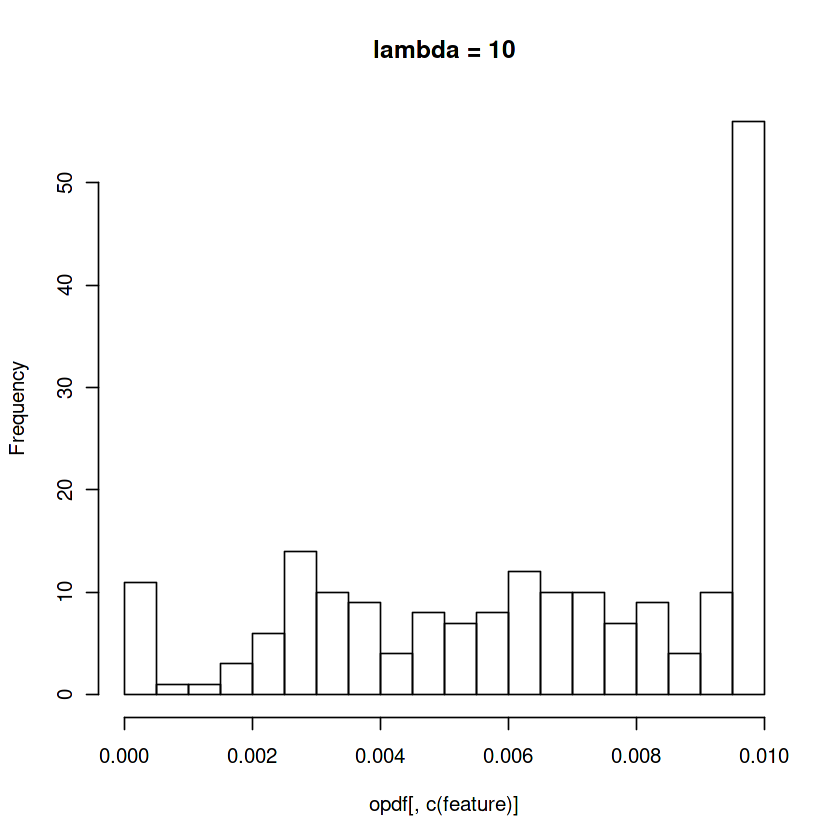

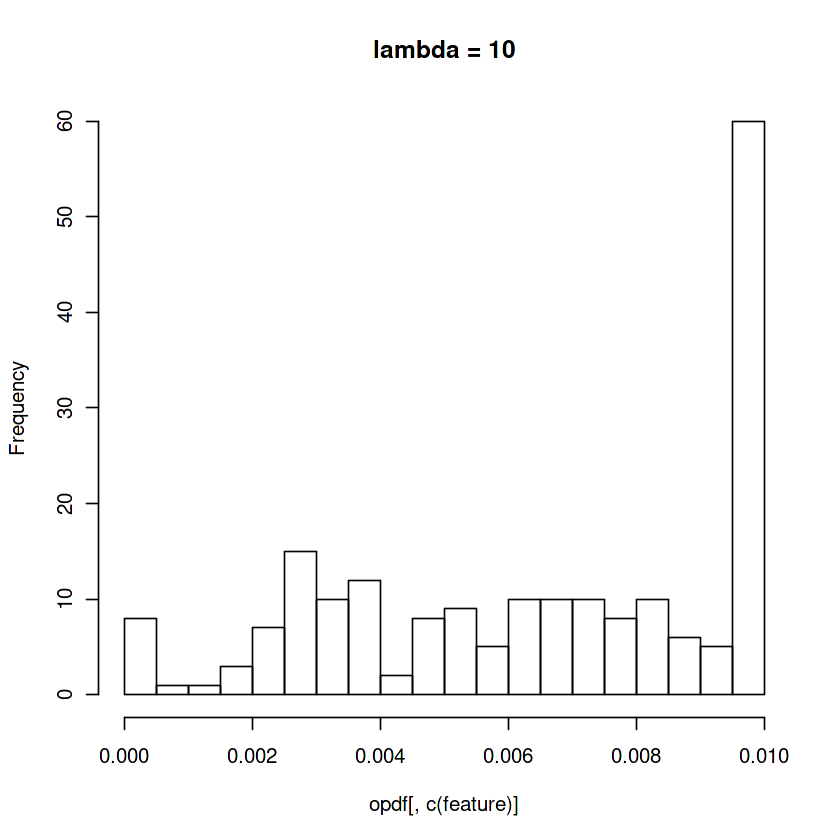

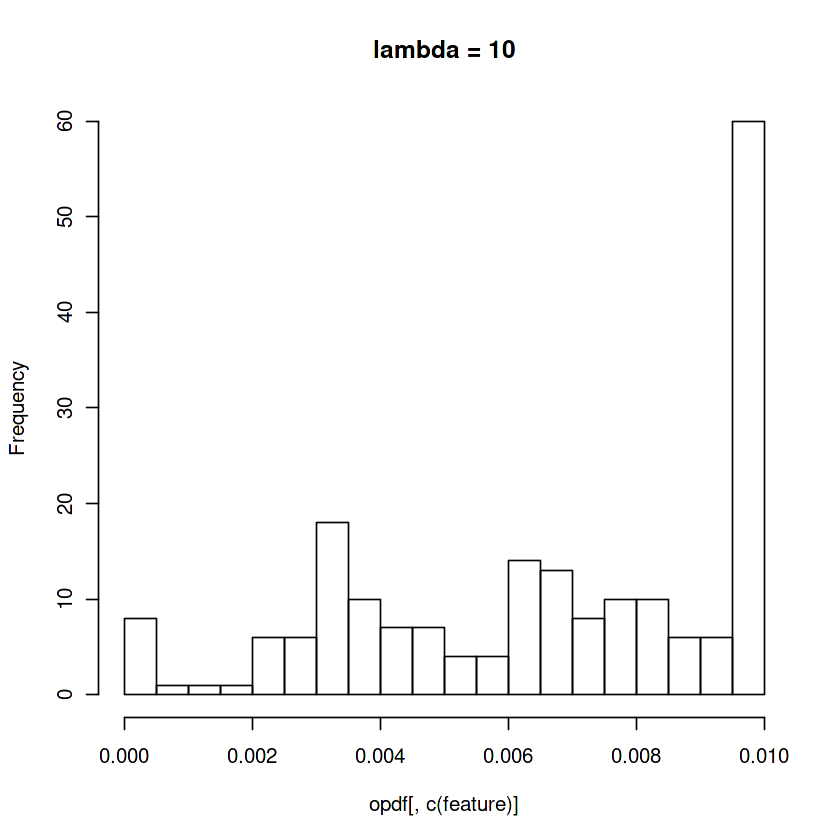

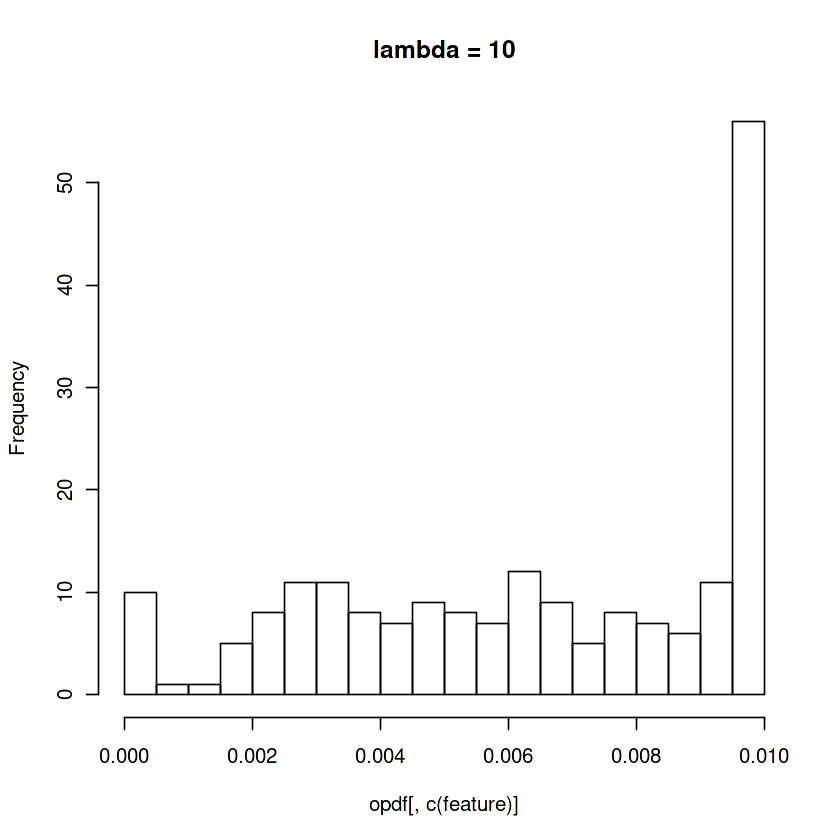

In [108]:
res3 = lapply(c("blood-transfusion-service-center", "kc1", "numerai28.6", "phoneme", "sylvine"), function(data) {
    compute_width_ci(data, c(0.5, 1, 2, 10), breaks = 20, feature = "learning_rate")
})

In [124]:
datasets = c("blood-transfusion-service-center")
res3 = lapply(seq_along(res3), function(i) {
    cbind(res[[i]], dataset = datasets[i], feature = "learning_rate")
})


In [115]:
res3 = do.call(rbind, res3)

In [120]:
res3$md = as.numeric(res3$md)

In [121]:
res3 = res3[, mean(md), by = c("lambda", "dataset")]

In [122]:
res3

lambda dataset                          V1         
1  0.5    blood-transfusion-service-center 0.136597836
2  1      blood-transfusion-service-center 0.135972872
3  2      blood-transfusion-service-center 0.122892295
4  10     blood-transfusion-service-center 0.141687369
5  0.5    kc1                              0.011768465
6  1      kc1                              0.006167972
7  2      kc1                              0.010083822
8  10     kc1                              0.003669521
9  0.5    numerai28.6                      0.222844014
10 1      numerai28.6                      0.222828354
11 2      numerai28.6                      0.222828299
12 10     numerai28.6                      0.223348034
13 0.5    phoneme                          0.011850519
14 1      phoneme                          0.012509444
15 2      phoneme                          0.008869526
16 10     phoneme                          0.008586133
17 0.5    sylvine                          0.096555576
18 1      sylvine                          0.098136176
19 2      sylvine                          0.101774095
20 10     sylvine                          0.100899649